In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Konfigurasi agar GPU digunakan secara efisien
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU Terdeteksi: ", physical_devices[0])
else:
    print("Peringatan: GPU tidak terdeteksi. Training akan lambat.")

GPU Terdeteksi:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
# IMPORTANT: Make sure you have uploaded kaggle.json to your Colab session's /content/ directory first.
# If you uploaded it somewhere else, adjust the source path accordingly.
!mv /content/kaggle.json ~/.kaggle/

# Set read-only permissions for the kaggle.json file for security
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API credentials set up successfully!")

Kaggle API credentials set up successfully!


In [ ]:
# Install kaggle if not already installed
!pip install -q kaggle

# Make sure your Kaggle API credentials (kaggle.json) are set up in ~/.kaggle/
# If you haven't done this, please refer to the previous instructions.

# Download the dataset
!kaggle datasets download -d joosthazelzet/lego-brick-images

# Unzip the downloaded dataset to the specified directory
# The zip file will be downloaded to the current working directory (/content/)
!unzip -q /content/lego-brick-images.zip -d /content/dataset/

# Clean up the zip file after extraction
!rm /content/lego-brick-images.zip

print("Dataset downloaded and extracted to /content/dataset/")

Dataset URL: https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images
License(s): GPL-2.0
 97% 994M/1.00G [00:14<00:00, 64.6MB/s]
100% 1.00G/1.00G [00:14<00:00, 76.1MB/s]
Dataset downloaded and extracted to /content/dataset/


In [ ]:
# Parameter Konfigurasi
BATCH_SIZE = 64
IMG_HEIGHT = 64  # Menggunakan 64x64 agar detail LEGO cukup terlihat
IMG_WIDTH = 64
CHANNELS = 3     # RGB


# --- OPSI B: Membuat Dataset Loader ---
# Ganti 'path/to/images' dengan path folder dataset Anda
dataset_dir = '/content/dataset/LEGO brick images v1'

# Jika folder kosong/tidak ada, kita buat dummy data agar kode tetap jalan (untuk testing)
if not os.path.exists(dataset_dir) or not os.listdir(dataset_dir):
    print("Dataset tidak ditemukan. Membuat data dummy untuk demonstrasi struktur kode.")
    os.makedirs(dataset_dir, exist_ok=True)
    # Membuat 100 gambar random noise sebagai placeholder
    for i in range(100):
        img = np.random.randint(0, 255, (64, 64, 3), dtype=np.uint8)
        tf.keras.utils.save_img(f"{dataset_dir}/dummy_{i}.png", img)

# Memuat dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    label_mode=None, # Kita tidak butuh label untuk GAN
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Normalisasi ke [-1, 1]
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)

# Optimasi performa (Caching & Prefetching)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 6379 files.


In [ ]:
latent_dim = 128

def build_generator():
    model = keras.Sequential(name="generator")

    # Input: Latent Vector
    # Mulai dengan dense layer yang cukup besar untuk di-reshape
    # Kita ingin mulai dari ukuran 8x8 dengan 512 filter
    model.add(layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Reshape menjadi tensor 3D
    model.add(layers.Reshape((8, 8, 512)))

    # Upsampling 1: 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 2: 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 3: 32x32 -> 64x64
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Output Layer: 64x64 -> 64x64x3 (RGB)
    # Aktivasi TANH penting agar output di range [-1, 1]
    model.add(layers.Conv2D(CHANNELS, (3, 3), padding='same', activation='tanh'))

    return model

def build_discriminator():
    model = keras.Sequential(name="discriminator")

    # Input: Gambar 64x64x3
    # Downsampling 1: 64 -> 32
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 2: 32 -> 16
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 3: 16 -> 8
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Flatten dan Output
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Output berupa logit (skor real/fake)

    return model

# Inisialisasi Model
generator = build_generator()
discriminator = build_discriminator()

generator.summary()
# discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,081,411 (27.01 MB)

 Trainable params: 7,014,979 (26.76 MB)

 Non-trainable params: 66,432 (259.50 KB)

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        # Metric trackers
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # 1. Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 2. Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # 3. Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # 4. Assemble labels discriminating real from fake images
        # Label 1 untuk fake, 0 untuk real (atau sebaliknya, teknik ini menggunakan label smoothing)
        # Di sini kita pakai standar: 1=Real, 0=Fake.
        # Namun, karena kita concat [Fake, Real], maka labelnya: [0...0, 1...1]
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Tambahkan sedikit noise pada label (Label Smoothing) untuk stabilitas
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # 5. Train the Discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # 6. Sample random points in the latent space (lagi, untuk Generator)
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 7. Assemble labels that say "all real images" (We want to fool the discriminator)
        misleading_labels = tf.ones((batch_size, 1))

        # 8. Train the Generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 127.5
        generated_images += 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(10, 4))
        for i in range(self.num_img):
            plt.subplot(1, self.num_img, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')

        plt.suptitle(f"Epoch {epoch+1}")
        plt.show() # Tampilkan inline di Colab

        # Opsional: Simpan ke file
        # plt.savefig(f"generated_lego_epoch_{epoch}.png")
        # plt.close()

Mulai Training...
Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - d_loss: 0.4721 - g_loss: 0.7457

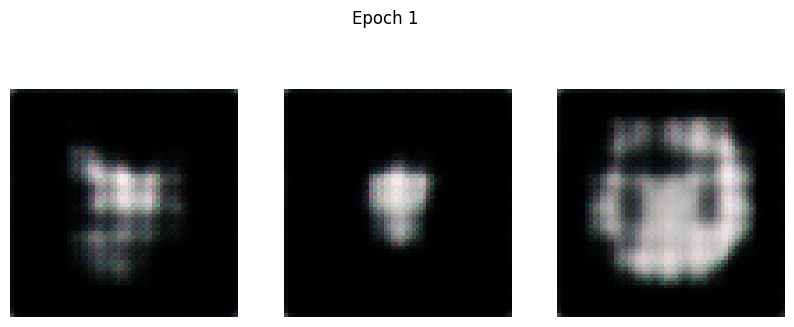

100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 205ms/step - d_loss: 0.4729 - g_loss: 0.7462
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.6746 - g_loss: 0.7105

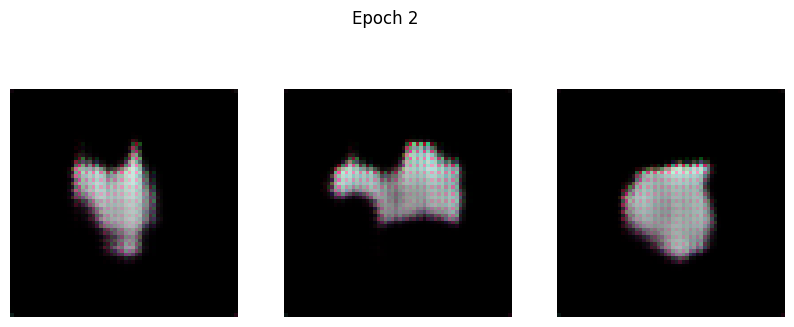

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.6747 - g_loss: 0.7105
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.6742 - g_loss: 0.7230

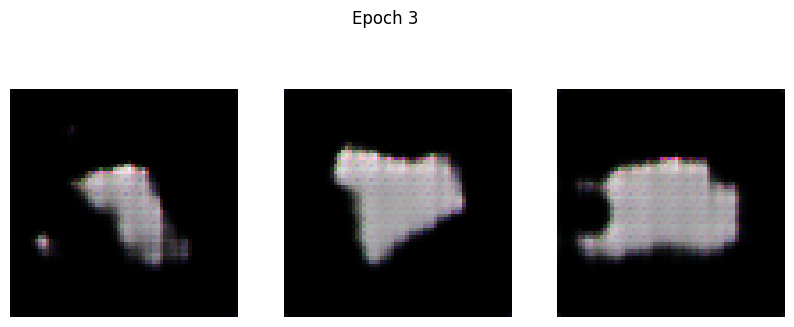

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.6742 - g_loss: 0.7228
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.6579 - g_loss: 0.7314

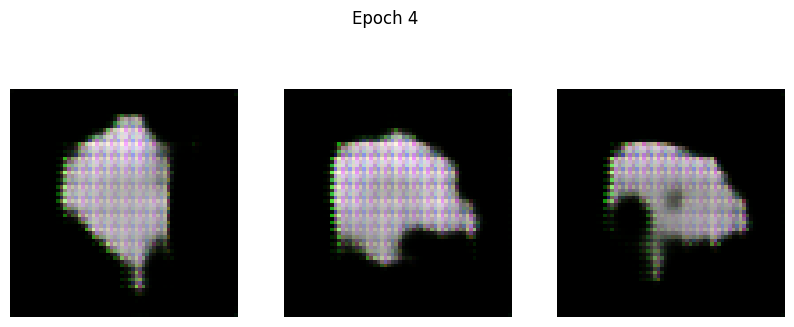

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.6580 - g_loss: 0.7315
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.6568 - g_loss: 0.7562

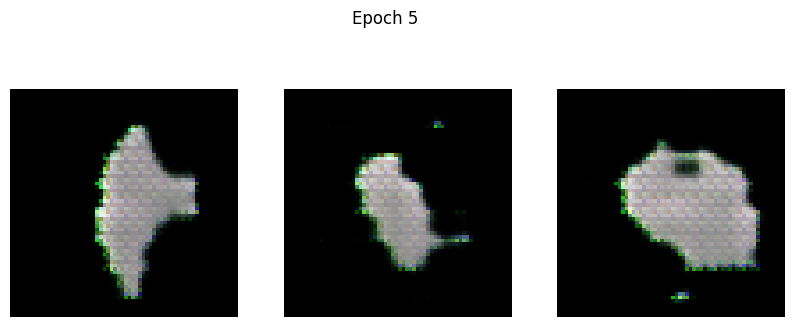

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.6568 - g_loss: 0.7563
Epoch 6/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.6611 - g_loss: 0.7871

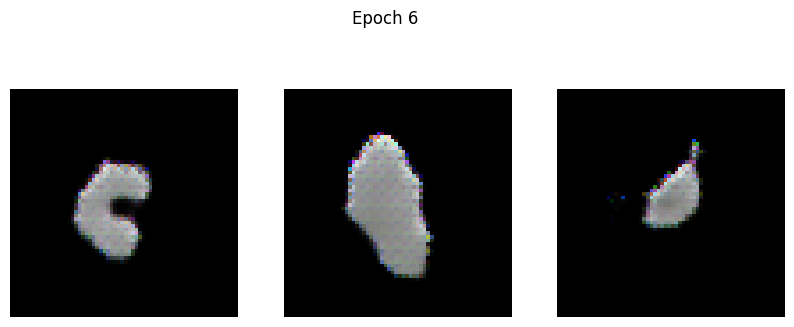

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.6611 - g_loss: 0.7869
Epoch 7/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - d_loss: 0.6586 - g_loss: 0.7716

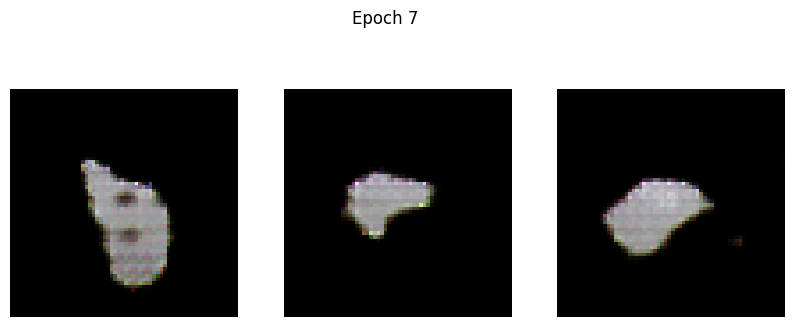

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.6586 - g_loss: 0.7718
Epoch 8/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - d_loss: 0.6676 - g_loss: 0.7277

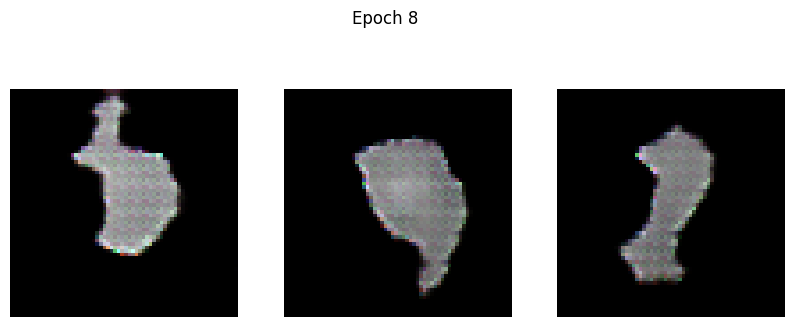

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - d_loss: 0.6675 - g_loss: 0.7277
Epoch 9/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - d_loss: 0.6643 - g_loss: 0.7594

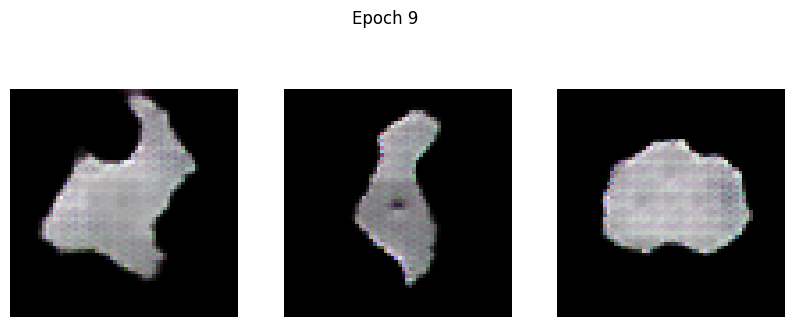

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - d_loss: 0.6643 - g_loss: 0.7592
Epoch 10/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.6584 - g_loss: 0.7233

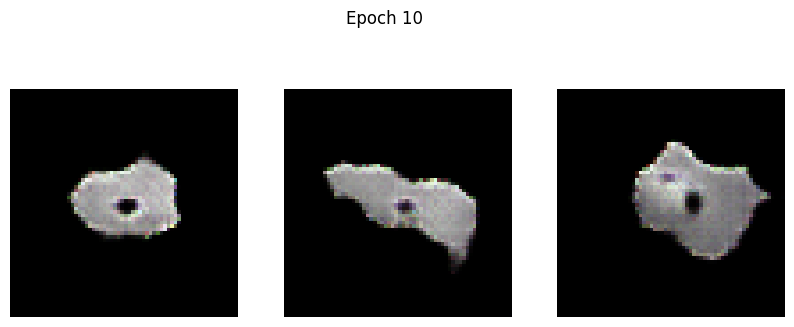

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.6584 - g_loss: 0.7234
Epoch 11/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.6573 - g_loss: 0.7331

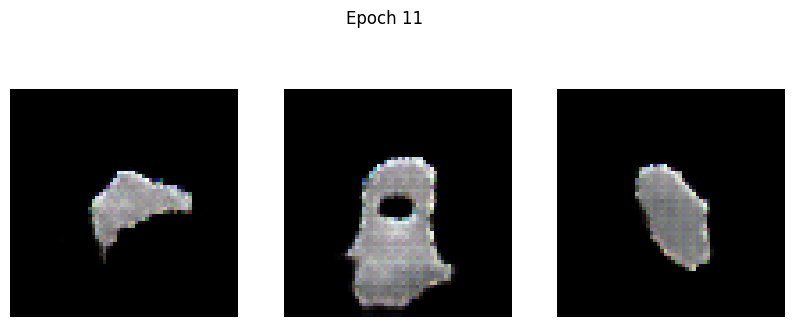

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.6573 - g_loss: 0.7332
Epoch 12/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.6497 - g_loss: 0.7527

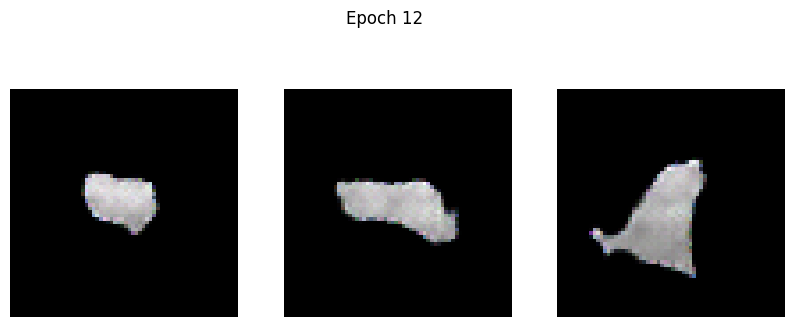

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.6497 - g_loss: 0.7527
Epoch 13/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.6429 - g_loss: 0.7909

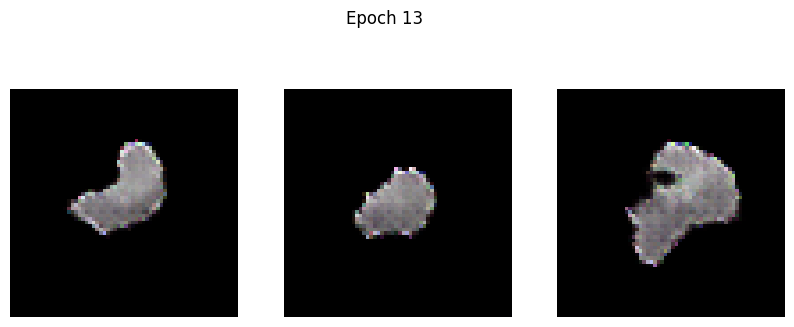

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.6430 - g_loss: 0.7909
Epoch 14/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.6272 - g_loss: 0.8277

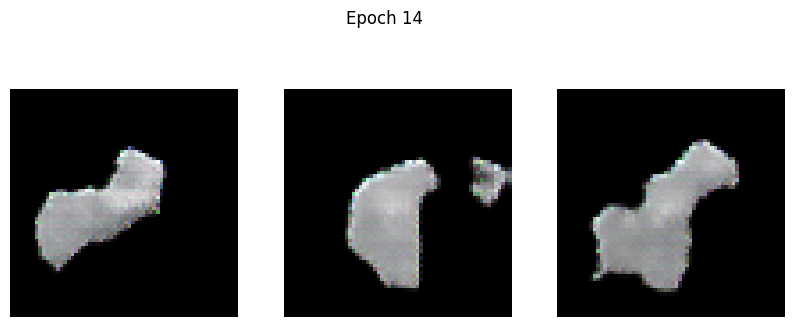

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.6272 - g_loss: 0.8277
Epoch 15/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.6276 - g_loss: 0.8721

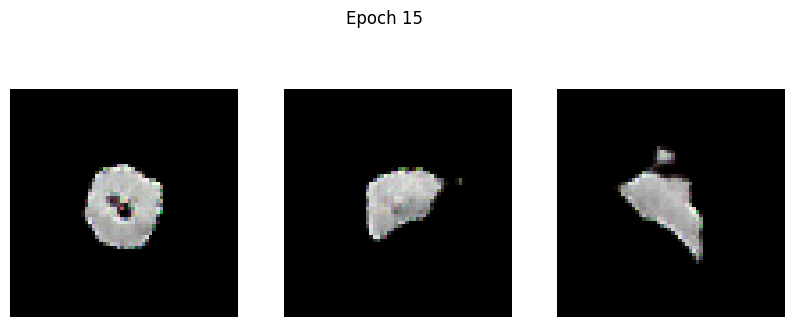

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.6276 - g_loss: 0.8722
Epoch 16/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.6111 - g_loss: 0.8932

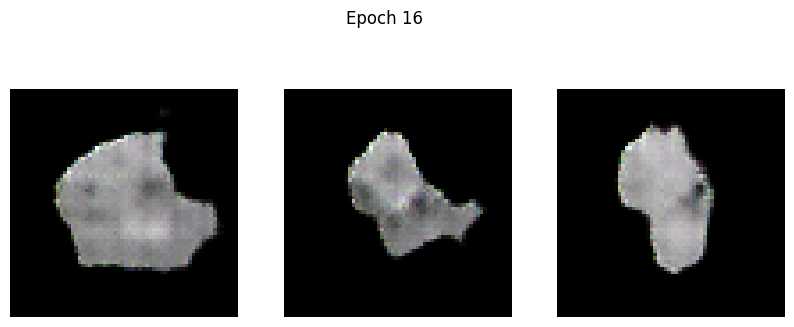

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.6111 - g_loss: 0.8933
Epoch 17/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.5994 - g_loss: 0.9156

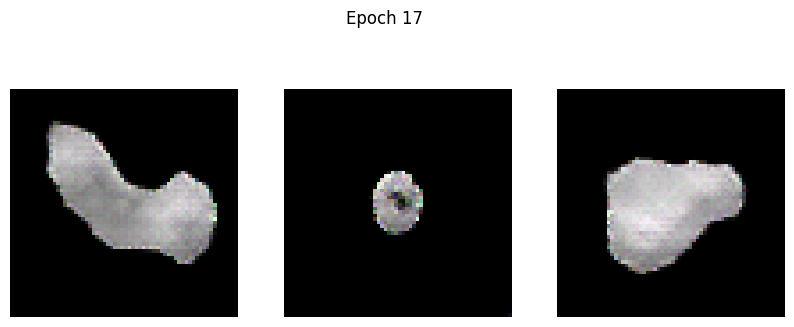

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.5993 - g_loss: 0.9156
Epoch 18/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.5841 - g_loss: 0.9241

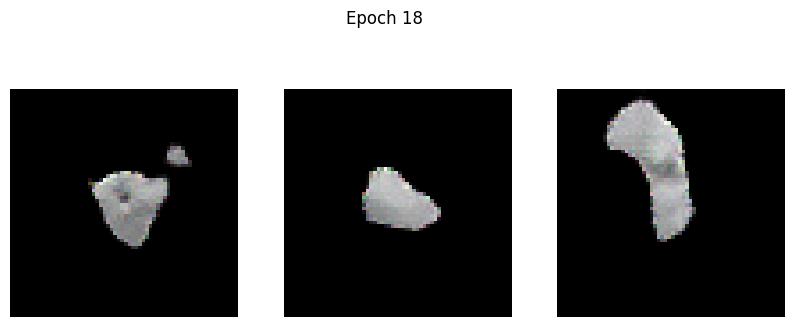

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.5840 - g_loss: 0.9240
Epoch 19/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.5760 - g_loss: 0.9137

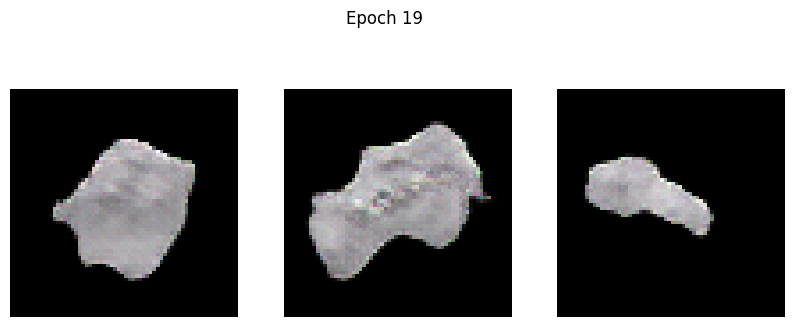

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.5760 - g_loss: 0.9137
Epoch 20/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.5770 - g_loss: 0.9606

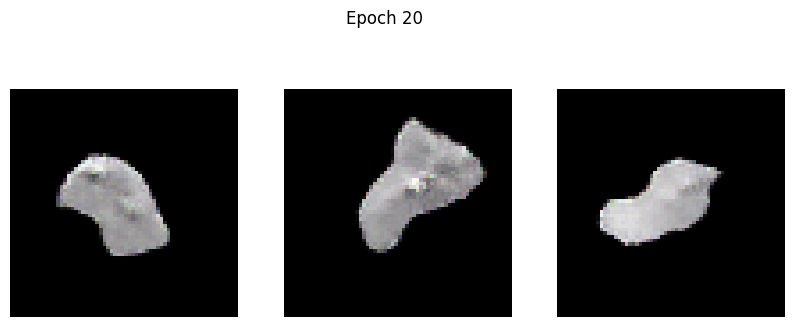

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.5769 - g_loss: 0.9606
Epoch 21/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.5681 - g_loss: 0.9684

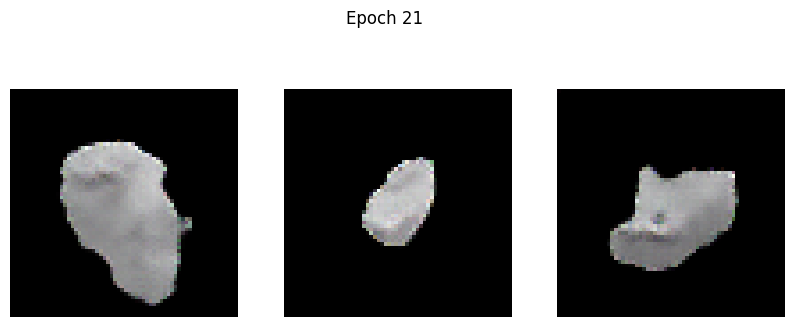

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.5682 - g_loss: 0.9686
Epoch 22/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.5499 - g_loss: 0.9686

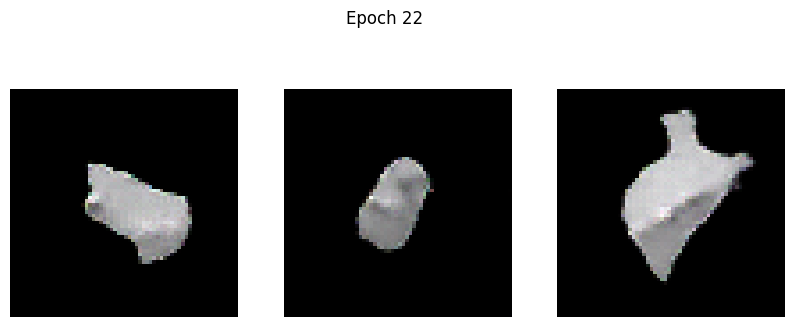

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.5499 - g_loss: 0.9687
Epoch 23/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.5455 - g_loss: 1.0299

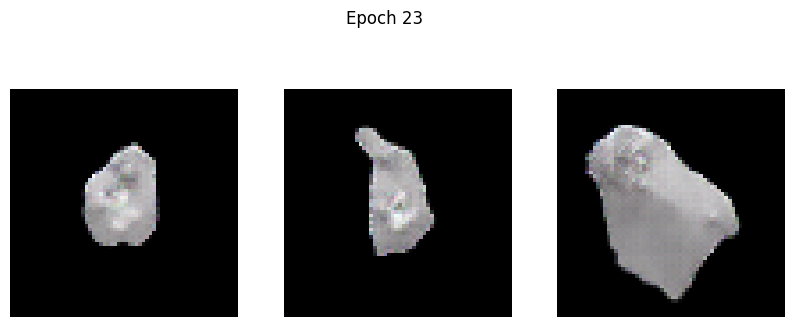

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.5454 - g_loss: 1.0299
Epoch 24/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.5308 - g_loss: 1.0531

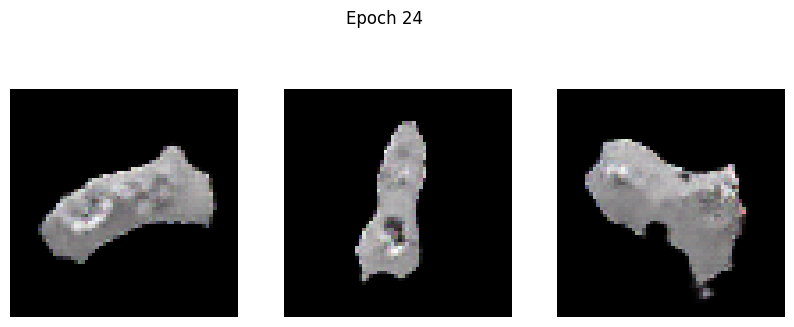

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.5308 - g_loss: 1.0531
Epoch 25/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.5206 - g_loss: 1.0800

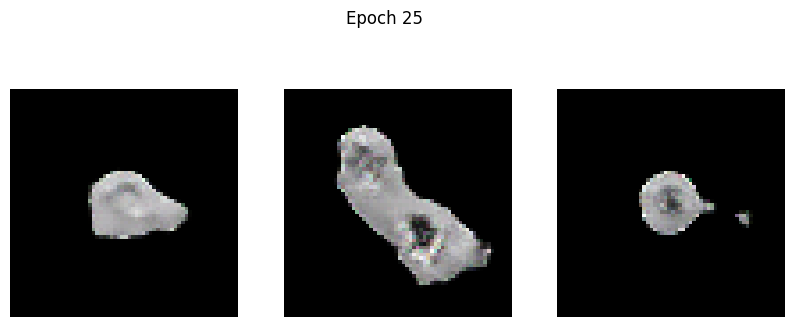

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.5206 - g_loss: 1.0800
Epoch 26/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.5102 - g_loss: 1.1055

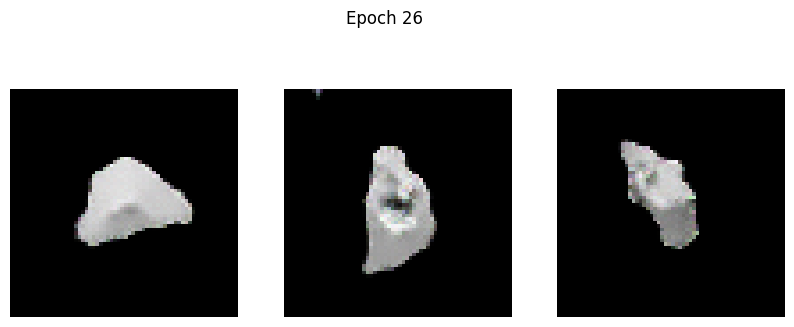

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.5102 - g_loss: 1.1056
Epoch 27/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.4924 - g_loss: 1.1435

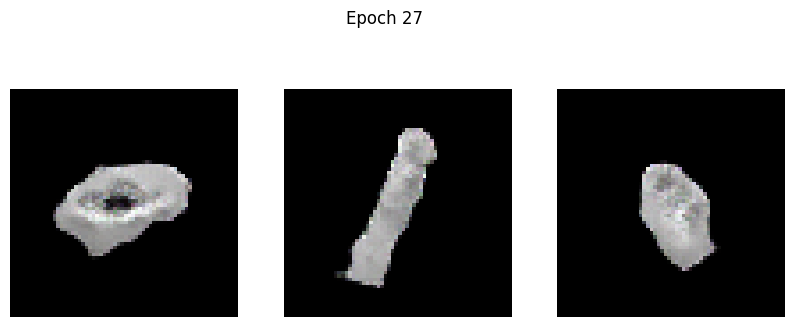

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.4924 - g_loss: 1.1437
Epoch 28/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.4859 - g_loss: 1.1718

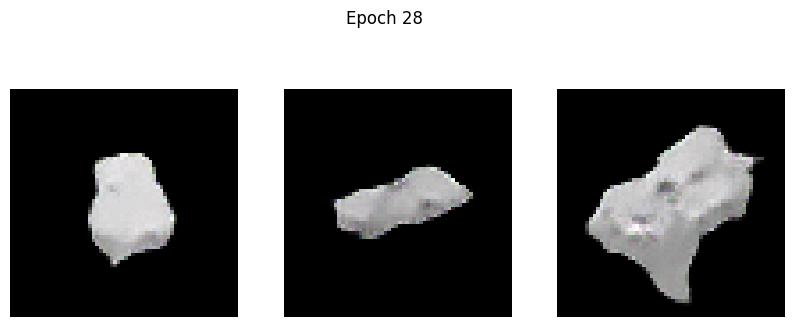

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.4859 - g_loss: 1.1721
Epoch 29/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.4712 - g_loss: 1.2270

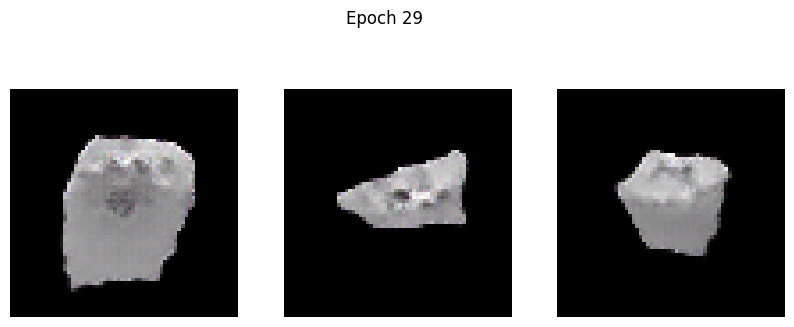

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.4715 - g_loss: 1.2275
Epoch 30/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.4512 - g_loss: 1.2062

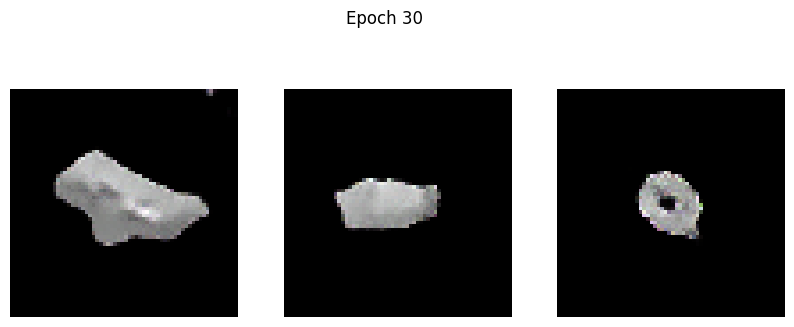

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.4511 - g_loss: 1.2063
Epoch 31/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.4592 - g_loss: 1.3168

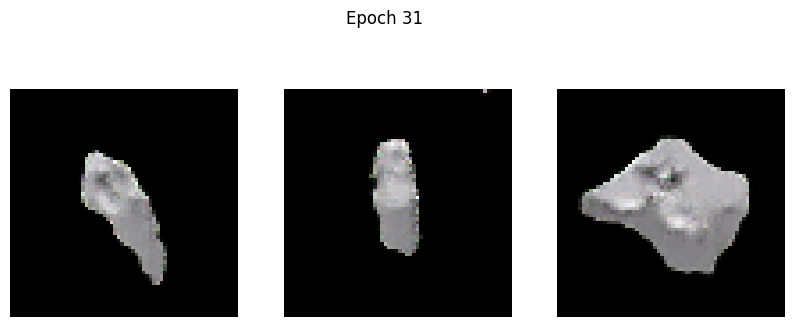

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.4593 - g_loss: 1.3171
Epoch 32/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.4264 - g_loss: 1.3011

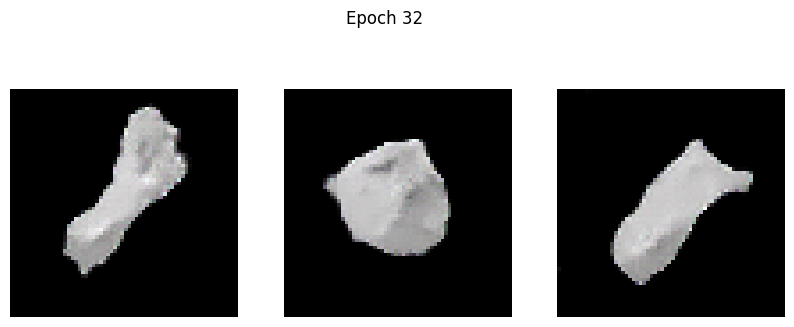

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.4265 - g_loss: 1.3013
Epoch 33/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.4183 - g_loss: 1.3560

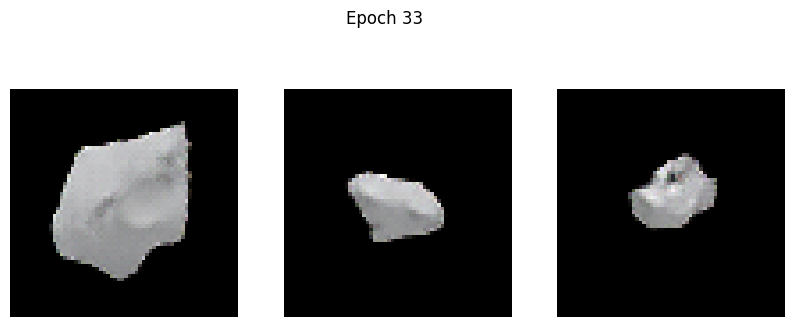

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.4183 - g_loss: 1.3560
Epoch 34/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.4630 - g_loss: 1.3962

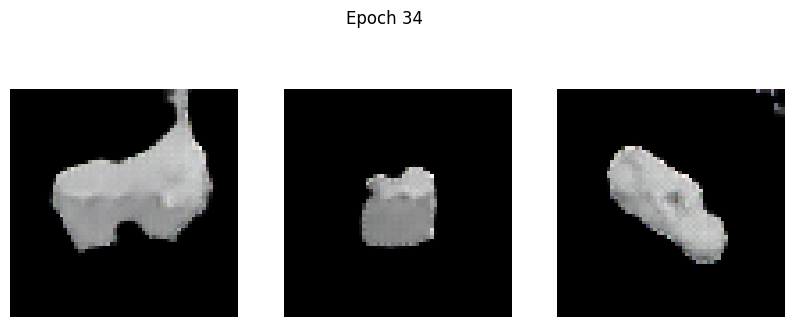

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.4637 - g_loss: 1.3972
Epoch 35/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.4136 - g_loss: 1.2733

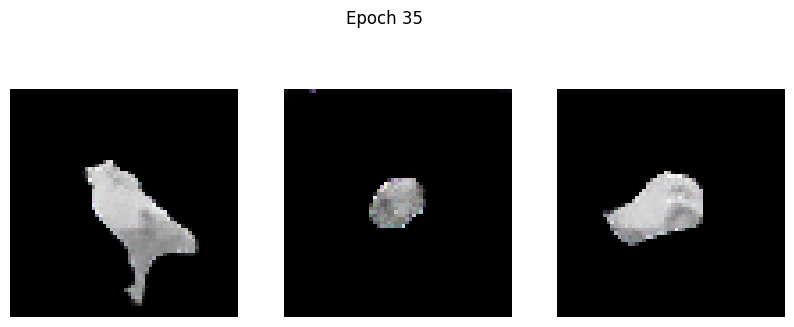

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.4134 - g_loss: 1.2737
Epoch 36/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3880 - g_loss: 1.3980

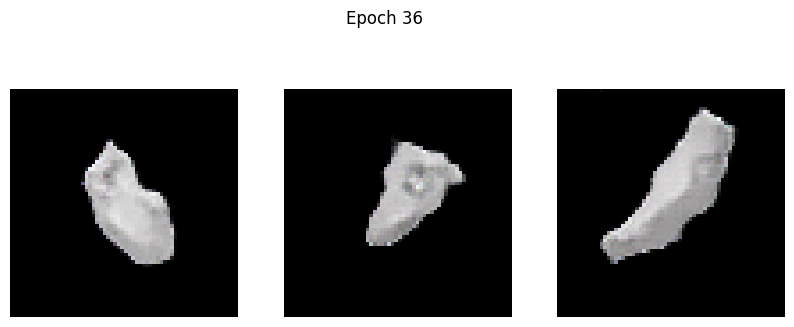

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.3881 - g_loss: 1.3981
Epoch 37/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3934 - g_loss: 1.4266

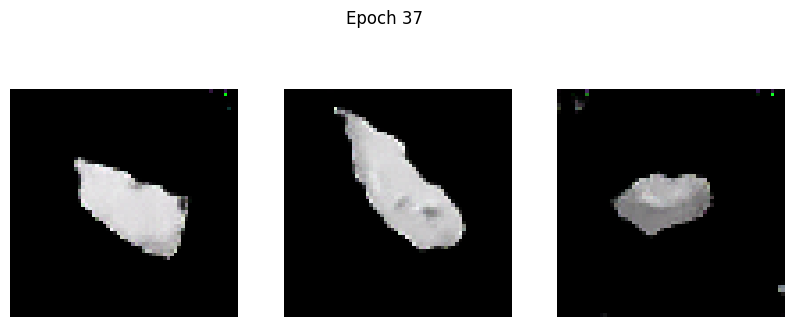

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.3934 - g_loss: 1.4267
Epoch 38/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.3979 - g_loss: 1.5198

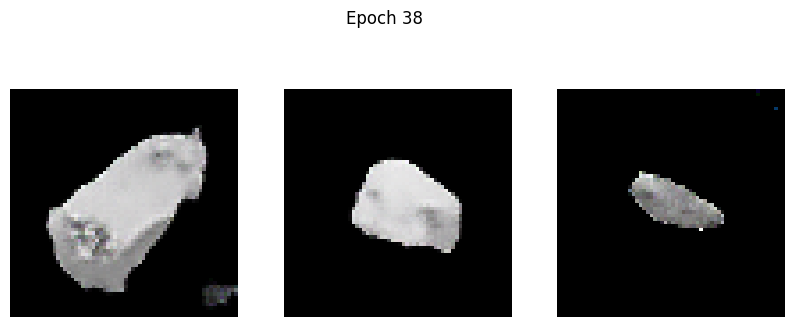

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.3980 - g_loss: 1.5198
Epoch 39/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.3817 - g_loss: 1.5398

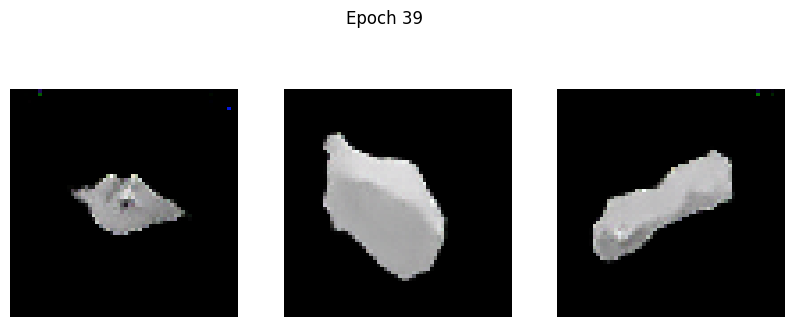

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.3817 - g_loss: 1.5398
Epoch 40/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.3844 - g_loss: 1.5281

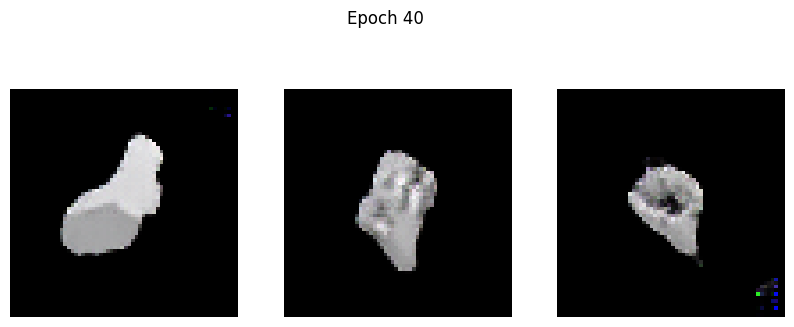

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.3844 - g_loss: 1.5282
Epoch 41/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.4103 - g_loss: 1.6058

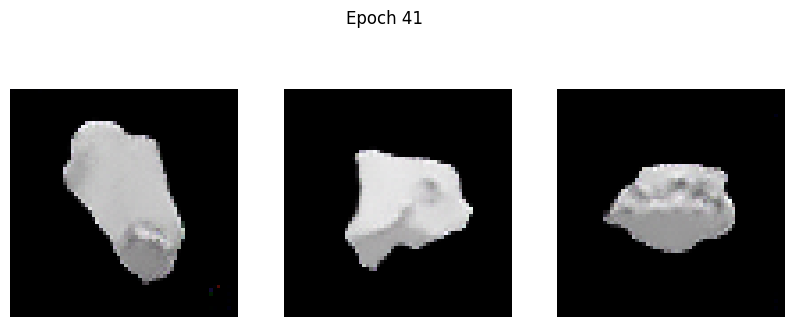

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.4103 - g_loss: 1.6055
Epoch 42/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3630 - g_loss: 1.5537

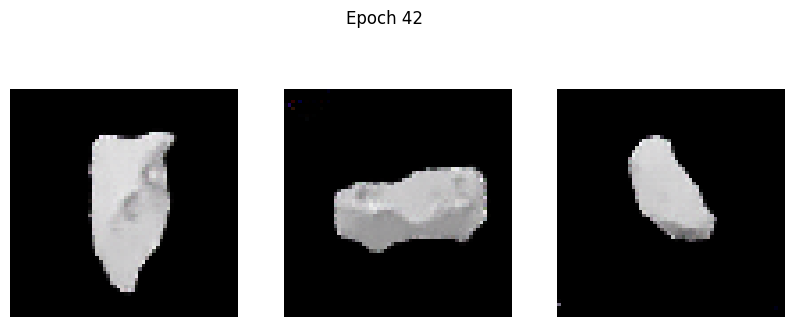

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3632 - g_loss: 1.5539
Epoch 43/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3551 - g_loss: 1.5714

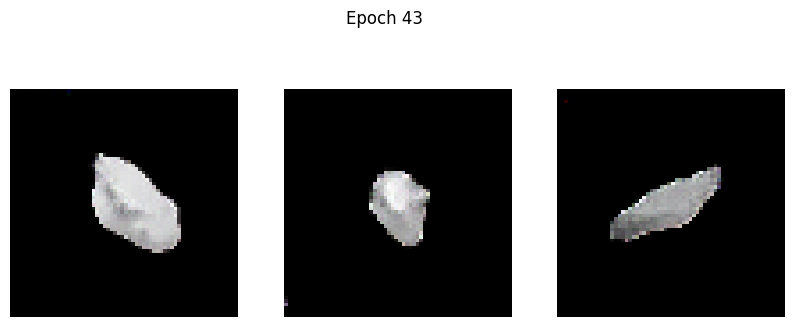

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3553 - g_loss: 1.5717
Epoch 44/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3491 - g_loss: 1.6238

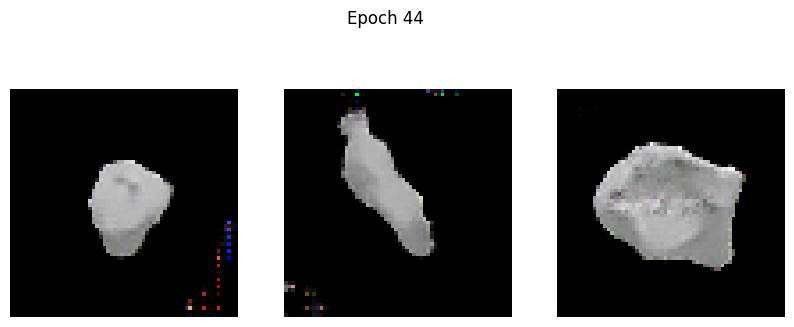

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.3492 - g_loss: 1.6240
Epoch 45/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.3728 - g_loss: 1.6798

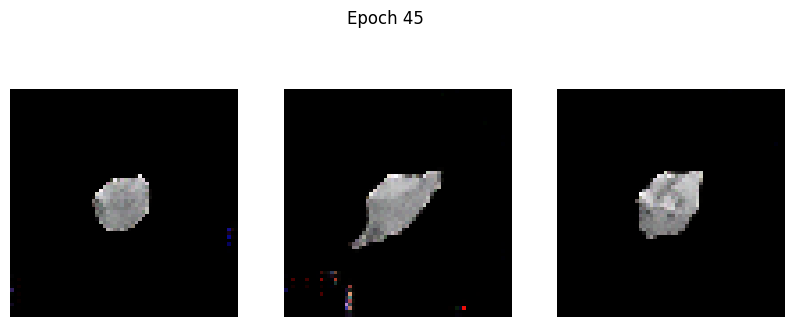

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.3729 - g_loss: 1.6797
Epoch 46/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.3437 - g_loss: 1.6204

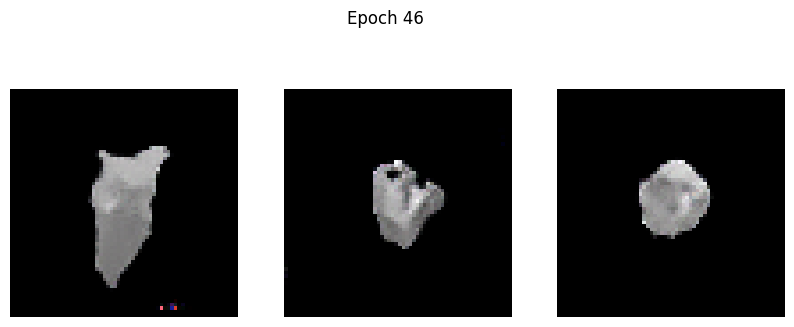

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.3437 - g_loss: 1.6206
Epoch 47/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.4545 - g_loss: 1.8792

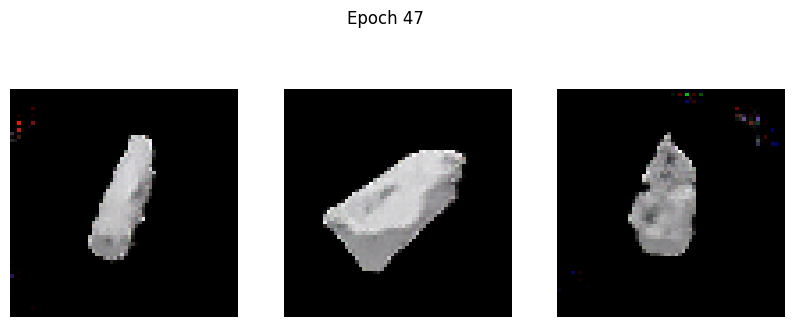

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.4543 - g_loss: 1.8784
Epoch 48/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.3358 - g_loss: 1.6487

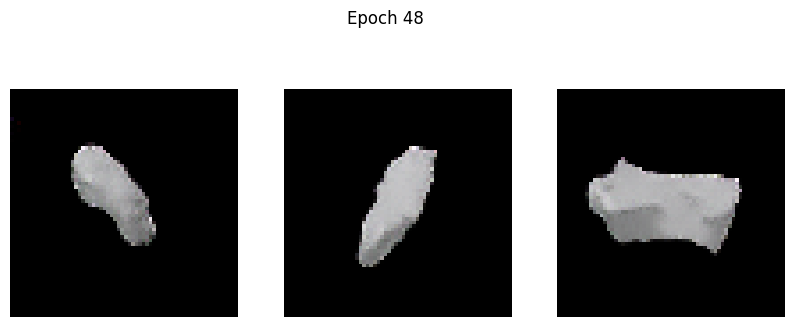

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.3359 - g_loss: 1.6488
Epoch 49/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3325 - g_loss: 1.6719

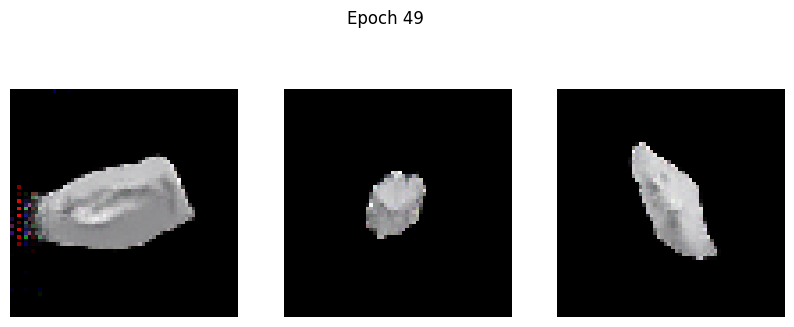

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3327 - g_loss: 1.6721
Epoch 50/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3465 - g_loss: 1.7589

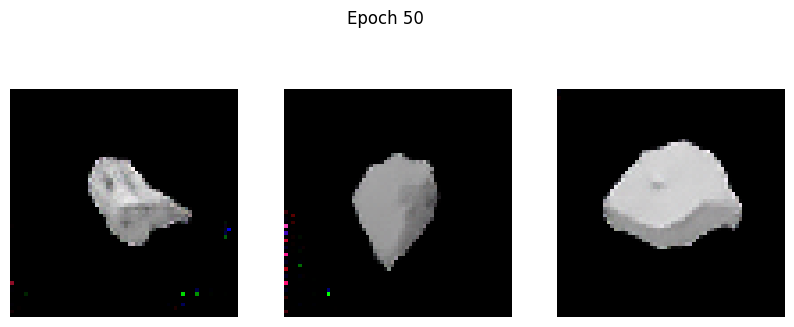

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.3469 - g_loss: 1.7591
Epoch 51/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3173 - g_loss: 1.6670

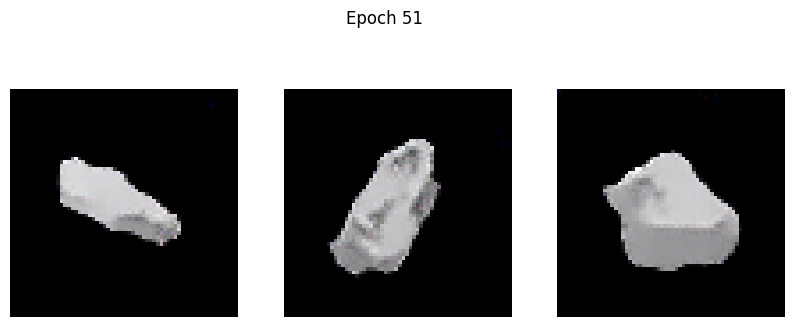

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3174 - g_loss: 1.6673
Epoch 52/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3777 - g_loss: 1.7639

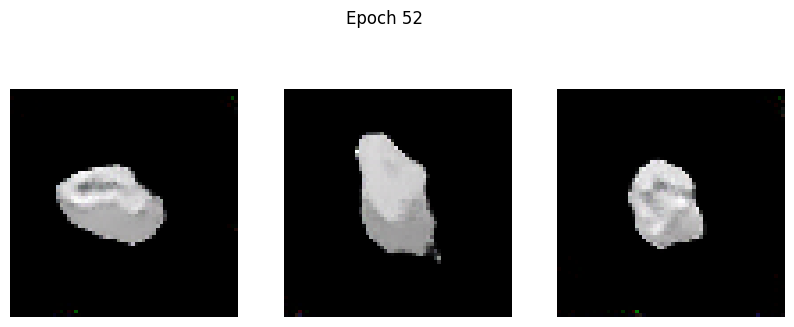

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3777 - g_loss: 1.7639
Epoch 53/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.4090 - g_loss: 1.8399

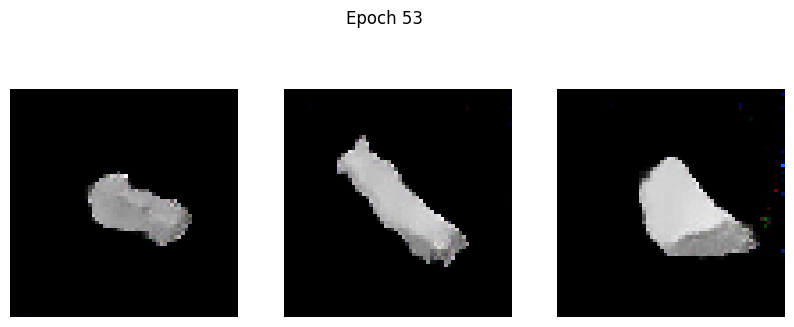

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.4090 - g_loss: 1.8397
Epoch 54/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3272 - g_loss: 1.6892

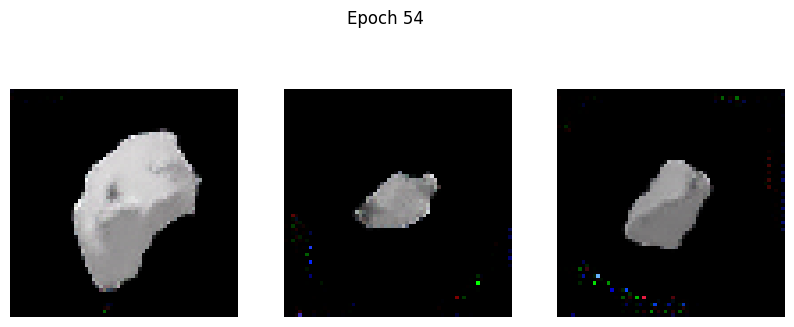

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3274 - g_loss: 1.6898
Epoch 55/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3195 - g_loss: 1.7089

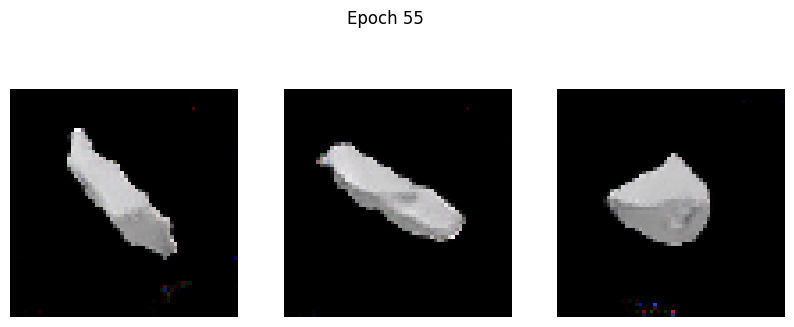

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3196 - g_loss: 1.7090
Epoch 56/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3492 - g_loss: 1.7959

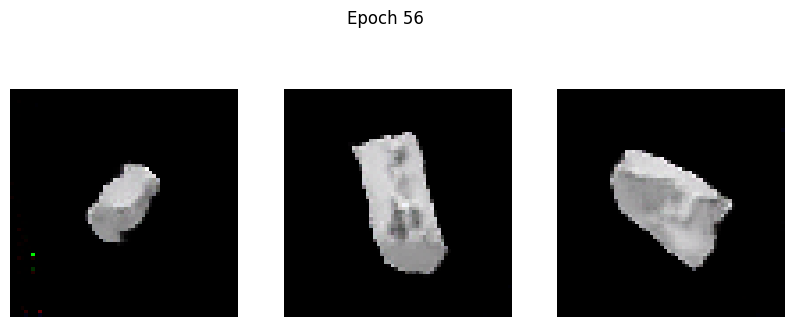

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3492 - g_loss: 1.7959
Epoch 57/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3134 - g_loss: 1.7624

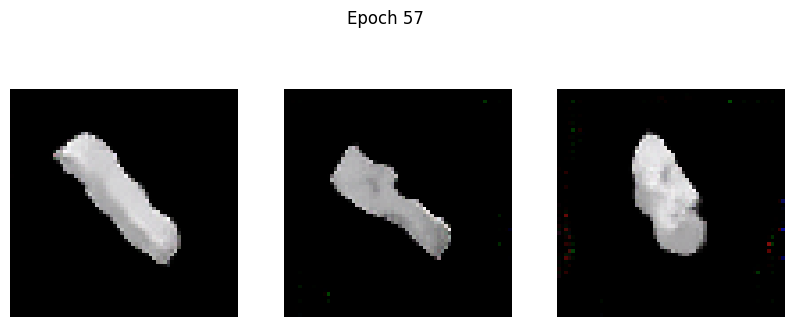

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - d_loss: 0.3136 - g_loss: 1.7625
Epoch 58/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3038 - g_loss: 1.7794

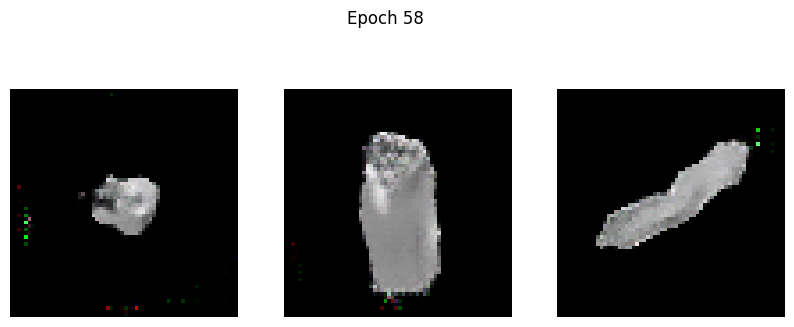

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3039 - g_loss: 1.7798
Epoch 59/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3087 - g_loss: 1.8352

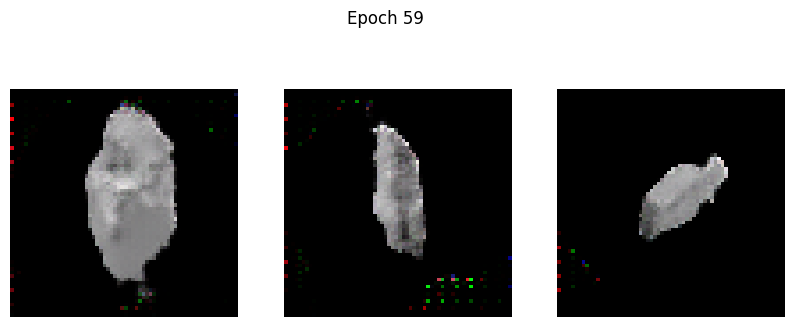

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3088 - g_loss: 1.8353
Epoch 60/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2867 - g_loss: 1.8604

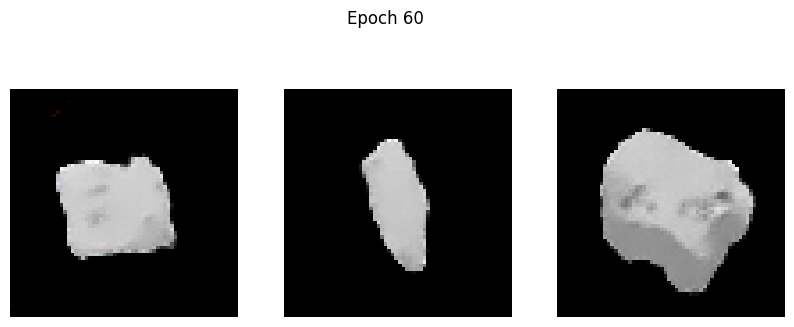

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.2869 - g_loss: 1.8604
Epoch 61/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3425 - g_loss: 1.9167

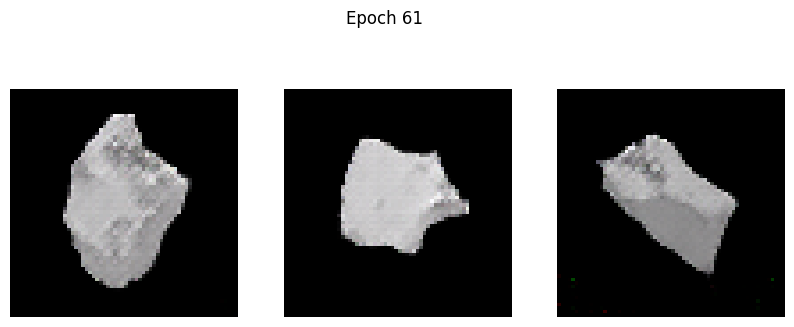

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3435 - g_loss: 1.9184
Epoch 62/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3026 - g_loss: 1.7377

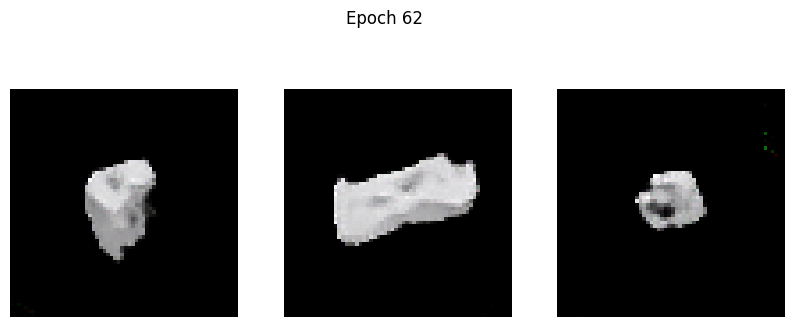

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3024 - g_loss: 1.7379
Epoch 63/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2898 - g_loss: 1.8607

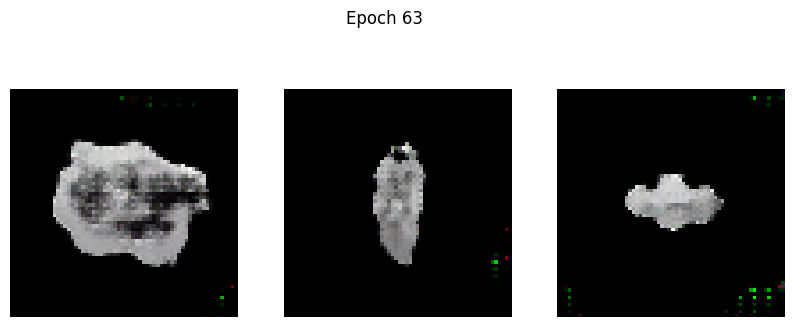

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.2902 - g_loss: 1.8612
Epoch 64/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.3000 - g_loss: 1.9146

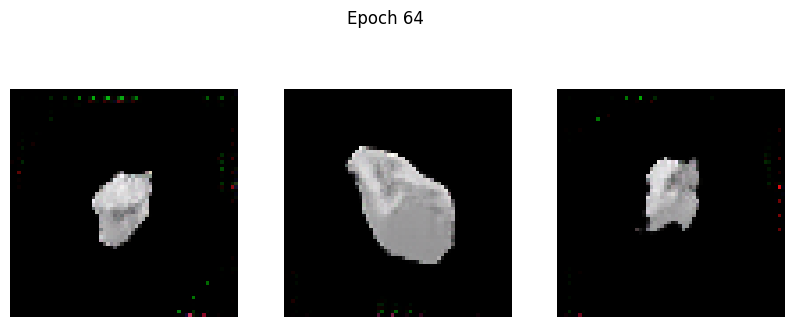

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.2999 - g_loss: 1.9142
Epoch 65/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3074 - g_loss: 1.9252

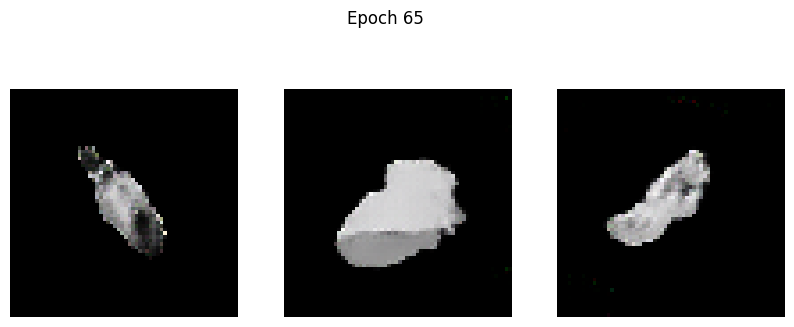

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3077 - g_loss: 1.9253
Epoch 66/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2730 - g_loss: 1.9098

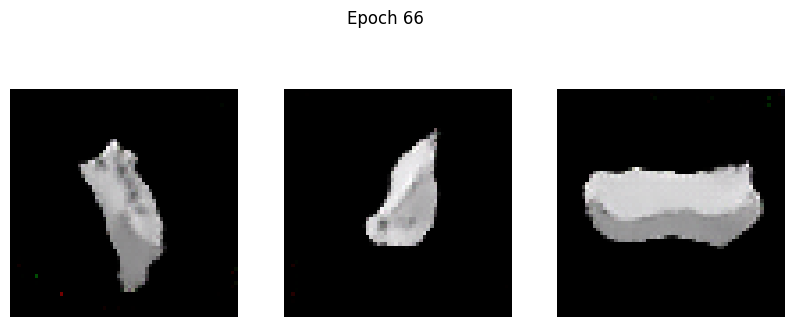

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2730 - g_loss: 1.9099
Epoch 67/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.2958 - g_loss: 1.9430

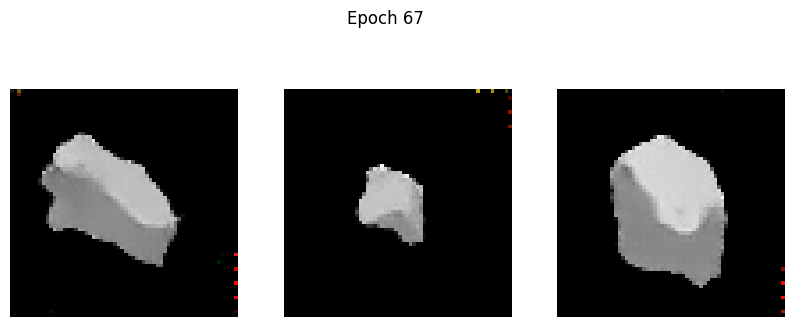

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2957 - g_loss: 1.9433
Epoch 68/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.3009 - g_loss: 1.9881

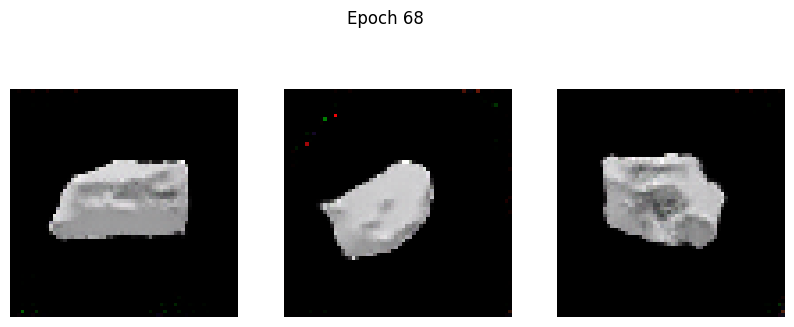

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3008 - g_loss: 1.9881
Epoch 69/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3621 - g_loss: 2.1058

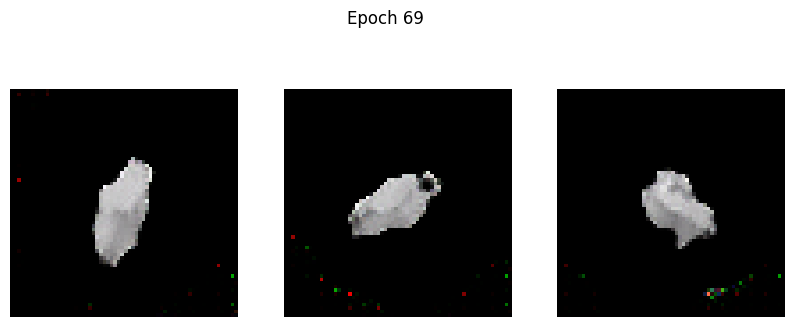

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3624 - g_loss: 2.1059
Epoch 70/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2651 - g_loss: 1.8819

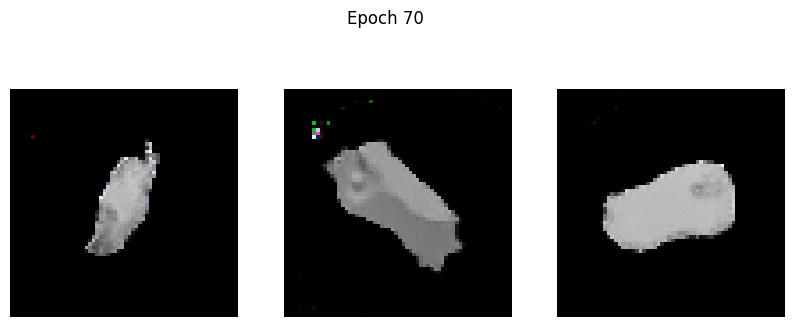

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2651 - g_loss: 1.8823
Epoch 71/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.2885 - g_loss: 2.0241

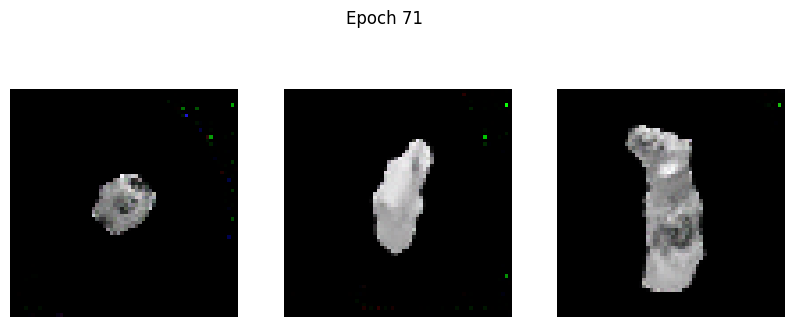

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.2886 - g_loss: 2.0242
Epoch 72/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.2707 - g_loss: 1.9680

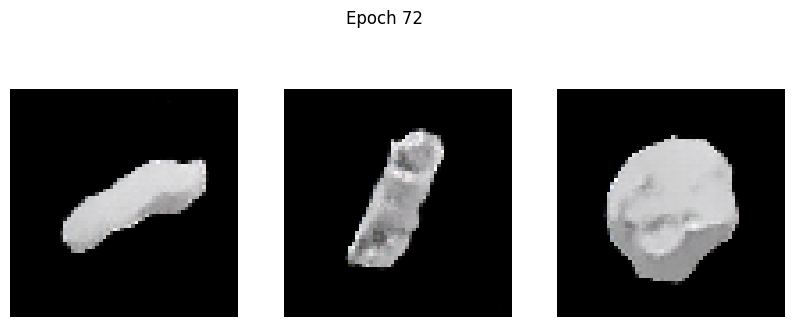

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - d_loss: 0.2707 - g_loss: 1.9683
Epoch 73/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - d_loss: 0.2953 - g_loss: 2.0195

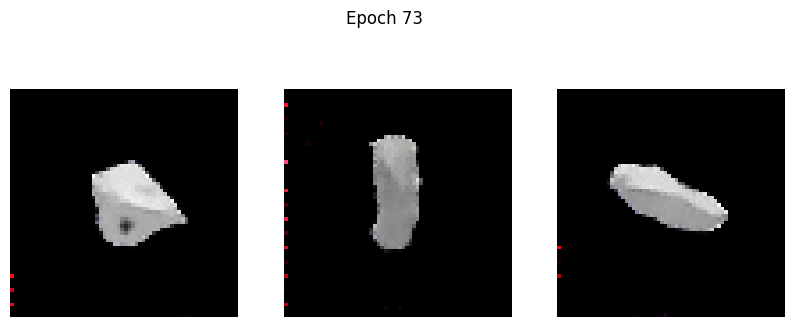

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - d_loss: 0.2957 - g_loss: 2.0199
Epoch 74/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - d_loss: 0.2681 - g_loss: 1.9755

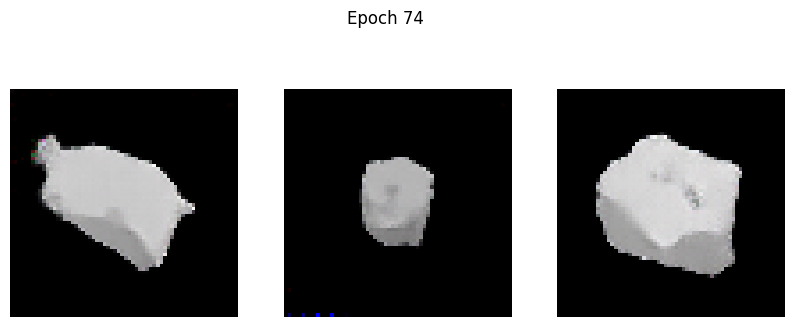

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - d_loss: 0.2681 - g_loss: 1.9758
Epoch 75/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.2926 - g_loss: 2.1281

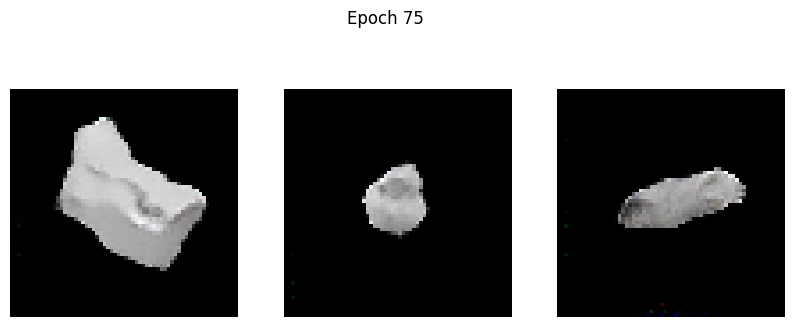

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.2925 - g_loss: 2.1281
Epoch 76/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.2964 - g_loss: 2.1265

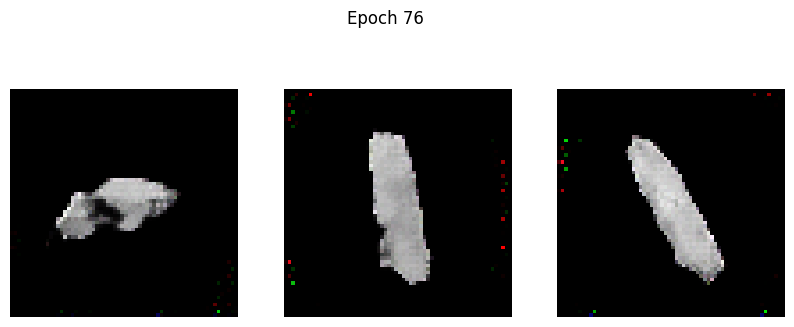

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.2966 - g_loss: 2.1271
Epoch 77/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.3106 - g_loss: 2.1150

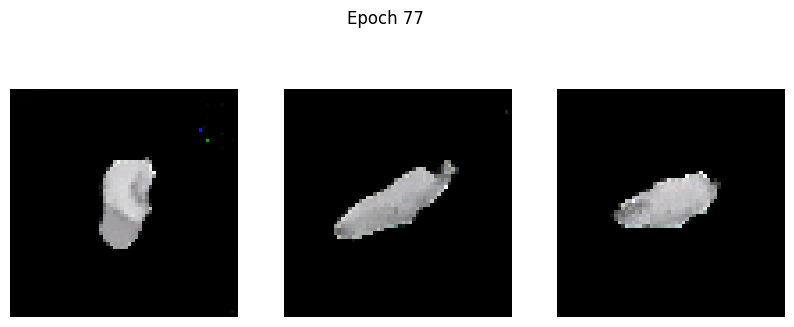

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.3102 - g_loss: 2.1146
Epoch 78/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.2595 - g_loss: 2.0997

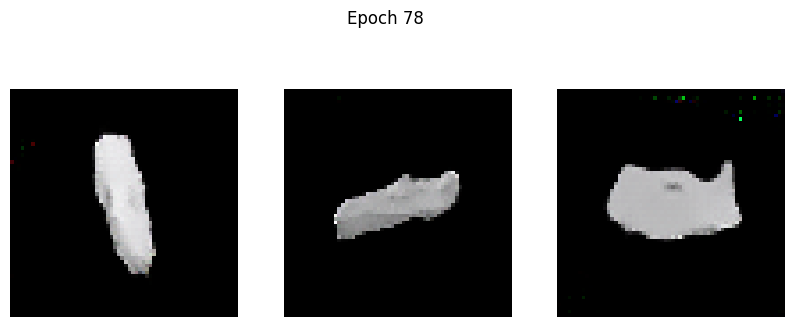

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.2596 - g_loss: 2.0998
Epoch 79/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2480 - g_loss: 2.1009

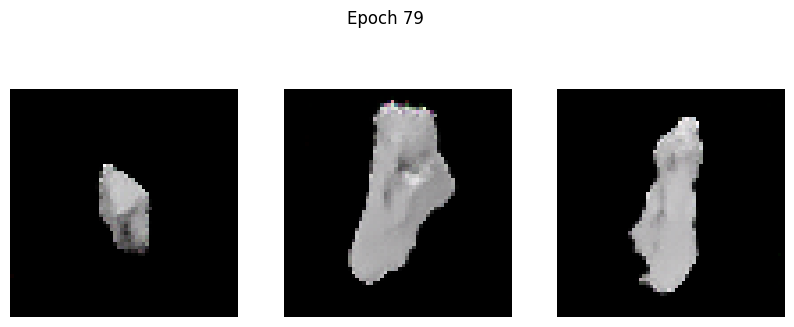

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2482 - g_loss: 2.1013
Epoch 80/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.2501 - g_loss: 2.1974

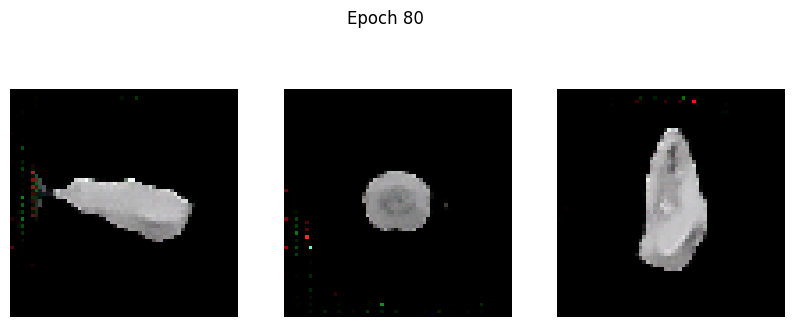

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2504 - g_loss: 2.1973
Epoch 81/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.2691 - g_loss: 2.1226

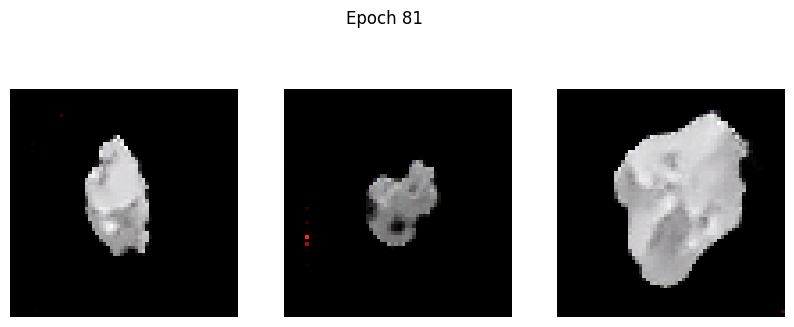

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.2696 - g_loss: 2.1231
Epoch 82/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2355 - g_loss: 2.1129

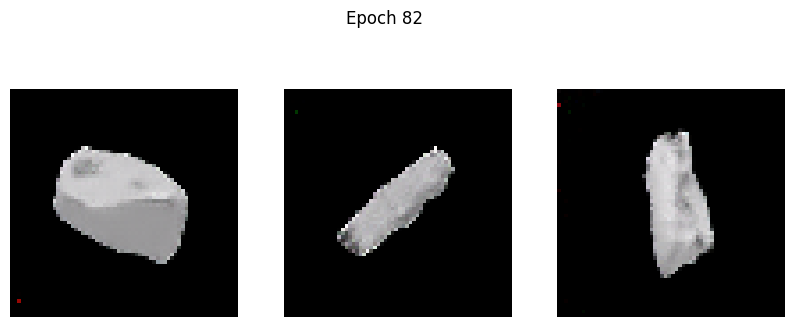

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2355 - g_loss: 2.1131
Epoch 83/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2570 - g_loss: 2.2129

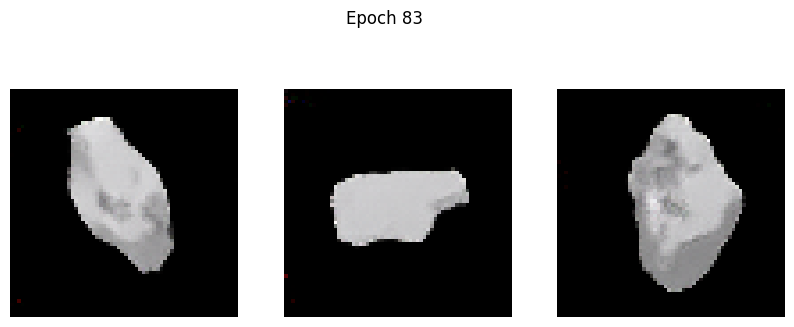

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2571 - g_loss: 2.2126
Epoch 84/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2172 - g_loss: 2.1821

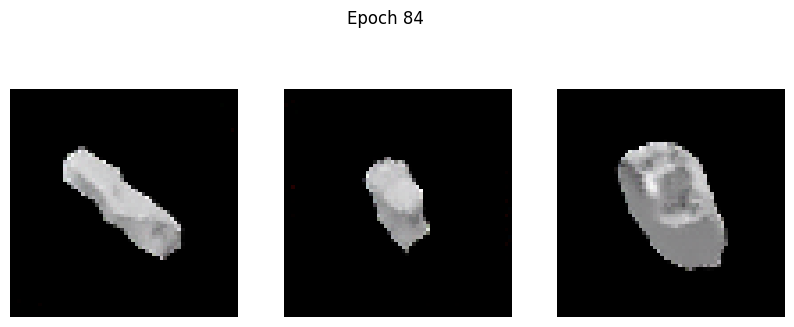

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.2173 - g_loss: 2.1824
Epoch 85/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2690 - g_loss: 2.3242

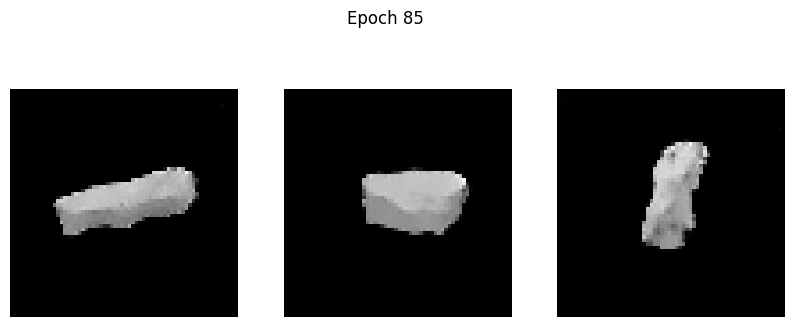

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2693 - g_loss: 2.3244
Epoch 86/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.2265 - g_loss: 2.2202

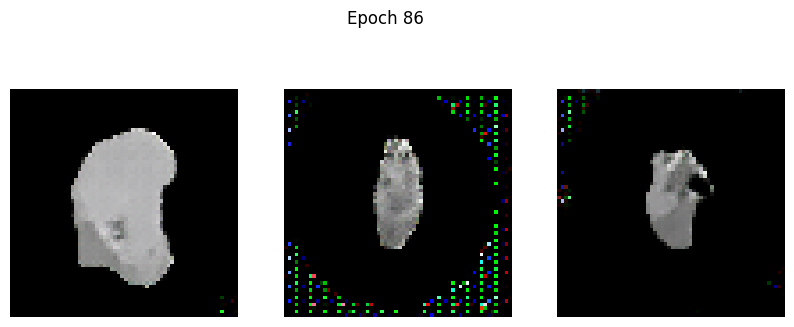

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.2272 - g_loss: 2.2213
Epoch 87/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.5387 - g_loss: 2.6611

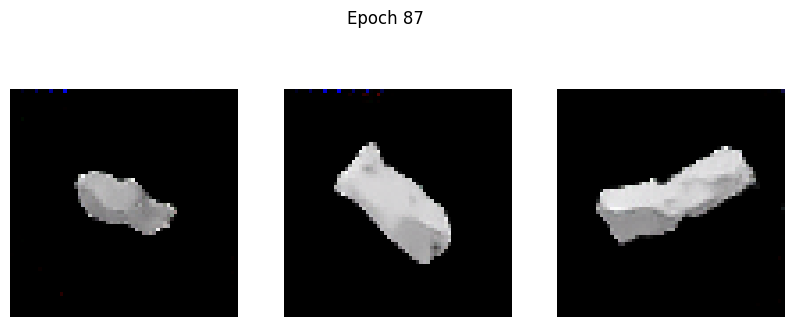

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.5366 - g_loss: 2.6566
Epoch 88/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2665 - g_loss: 2.1924

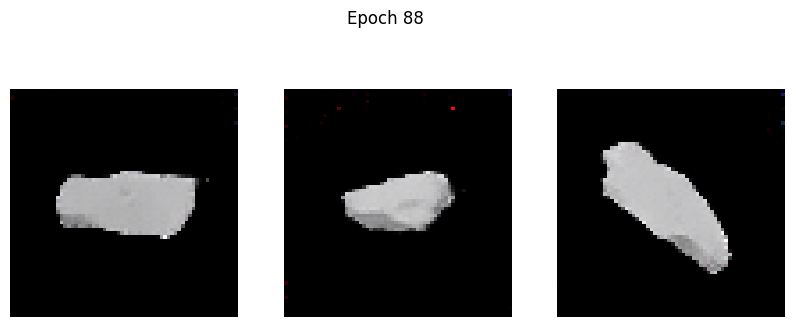

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2663 - g_loss: 2.1926
Epoch 89/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2263 - g_loss: 2.2466

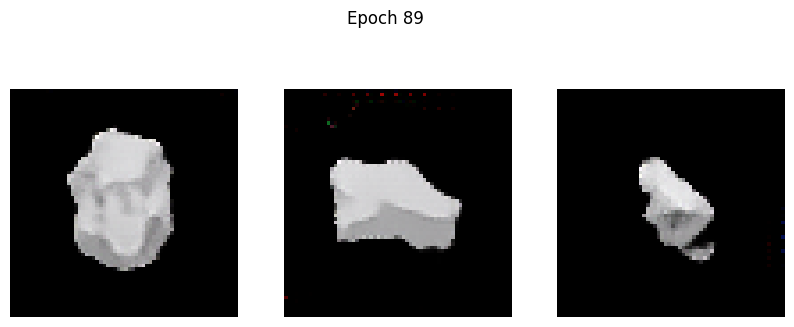

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2264 - g_loss: 2.2465
Epoch 90/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.2611 - g_loss: 2.2964

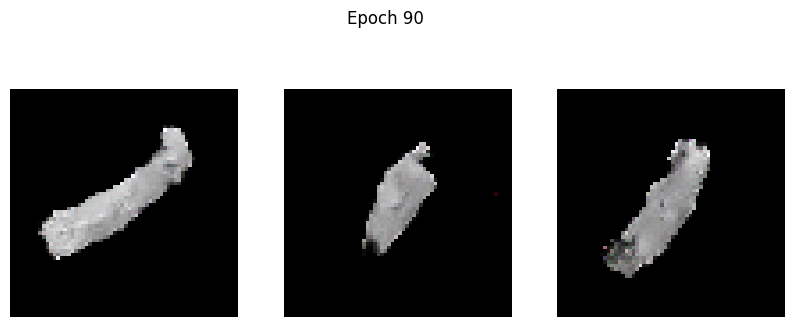

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2610 - g_loss: 2.2962
Epoch 91/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2251 - g_loss: 2.3024

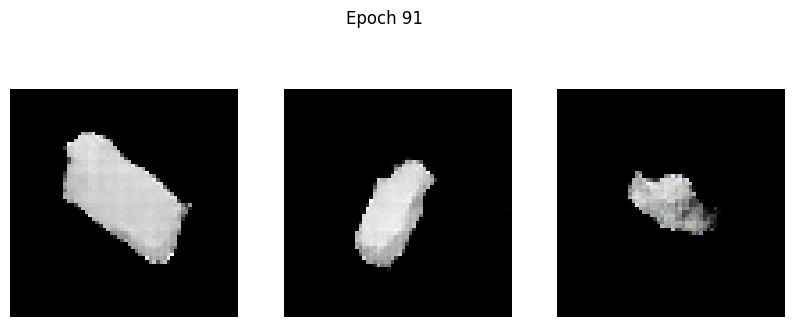

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.2265 - g_loss: 2.3050
Epoch 92/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.4365 - g_loss: 2.2886

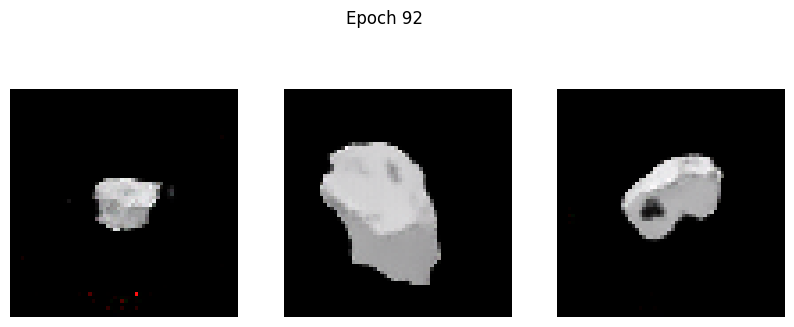

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.4353 - g_loss: 2.2873
Epoch 93/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2393 - g_loss: 2.1504

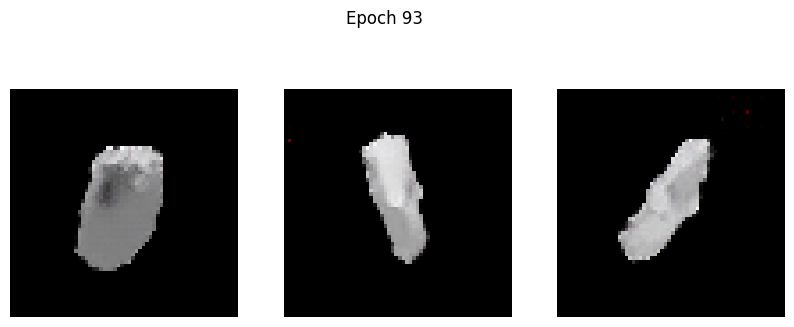

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2393 - g_loss: 2.1504
Epoch 94/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1966 - g_loss: 2.2446

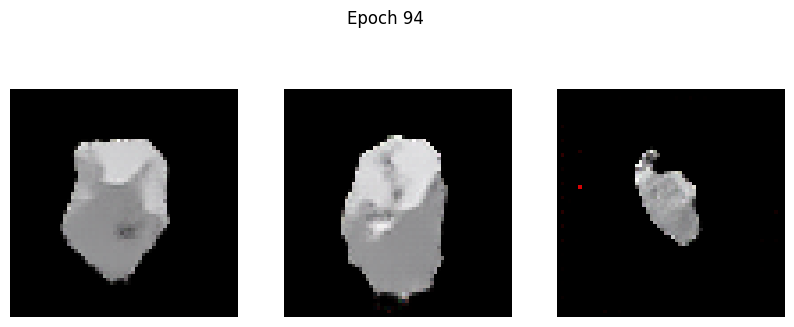

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1967 - g_loss: 2.2446
Epoch 95/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2241 - g_loss: 2.2606

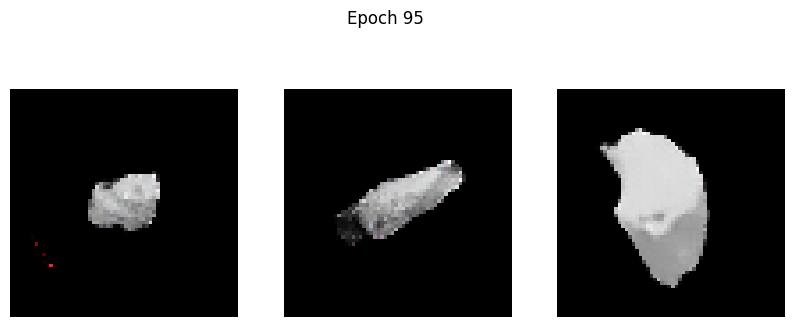

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2244 - g_loss: 2.2610
Epoch 96/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2181 - g_loss: 2.2802

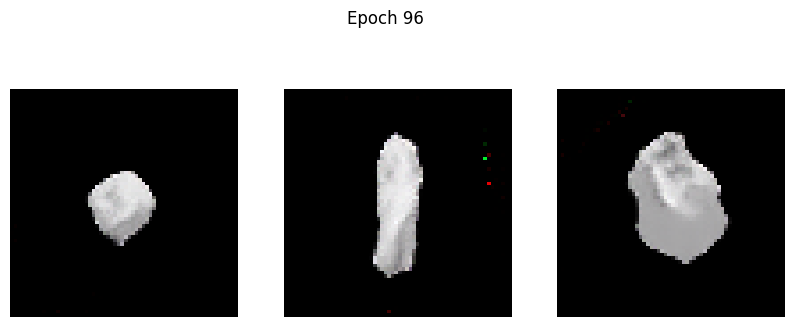

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2183 - g_loss: 2.2806
Epoch 97/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2179 - g_loss: 2.3107

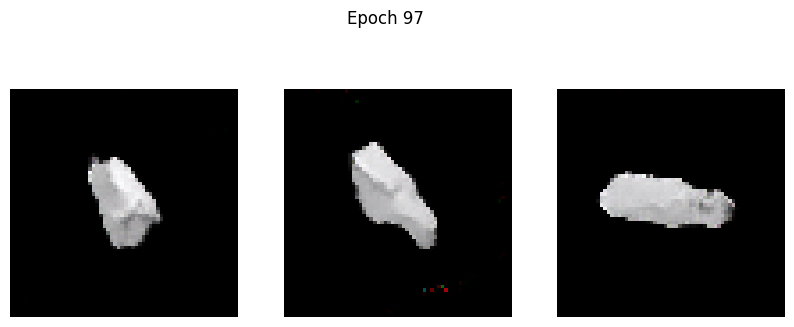

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2180 - g_loss: 2.3109
Epoch 98/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2223 - g_loss: 2.4160

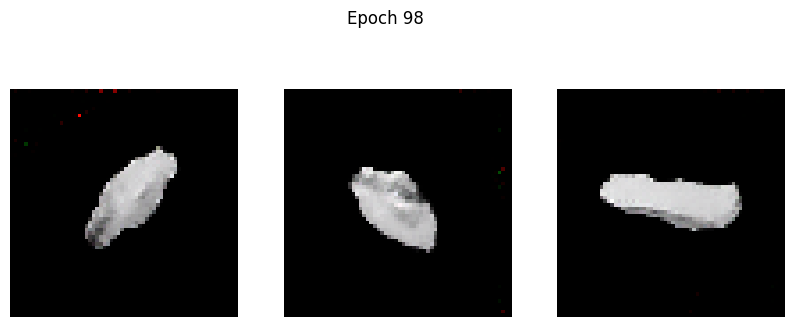

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2224 - g_loss: 2.4158
Epoch 99/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.2102 - g_loss: 2.3626

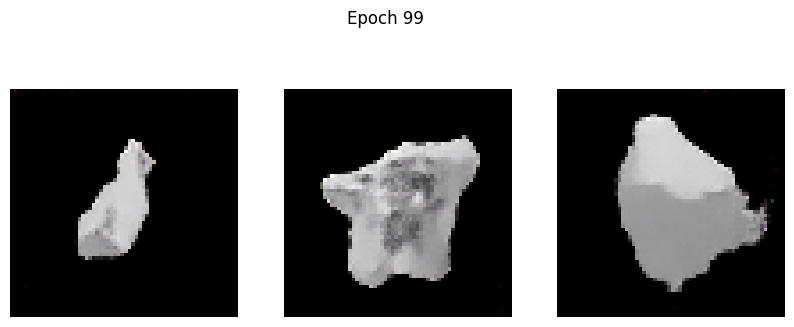

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.2101 - g_loss: 2.3631
Epoch 100/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.2676 - g_loss: 2.4456

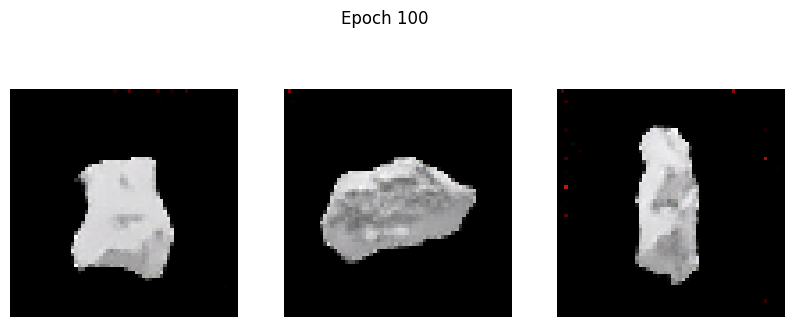

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2678 - g_loss: 2.4464
Epoch 101/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2175 - g_loss: 2.4185

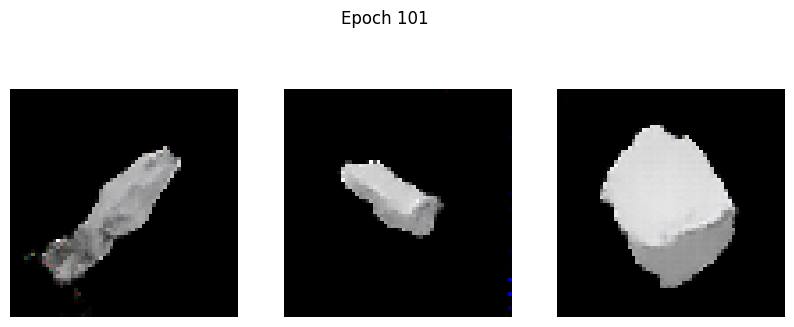

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2174 - g_loss: 2.4183
Epoch 102/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1845 - g_loss: 2.4288

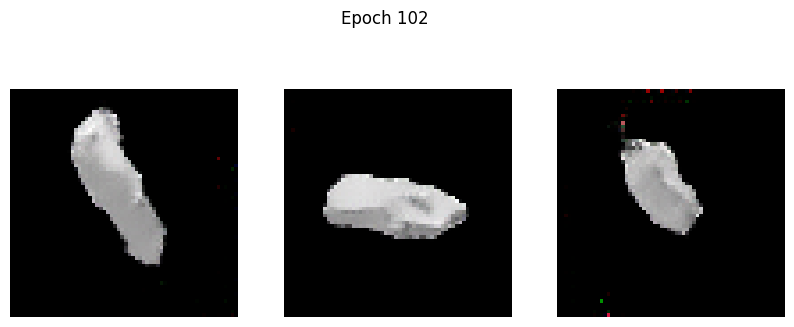

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1845 - g_loss: 2.4288
Epoch 103/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.2672 - g_loss: 2.5347

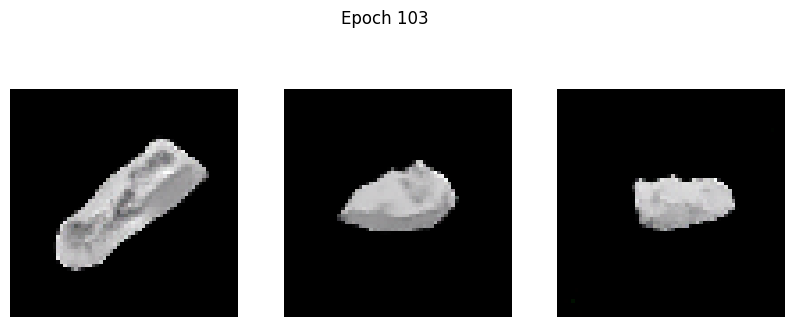

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.2672 - g_loss: 2.5345
Epoch 104/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2332 - g_loss: 2.5566

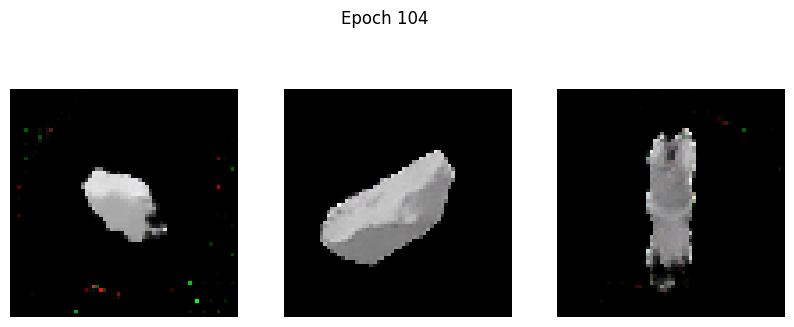

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2331 - g_loss: 2.5559
Epoch 105/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1881 - g_loss: 2.4849

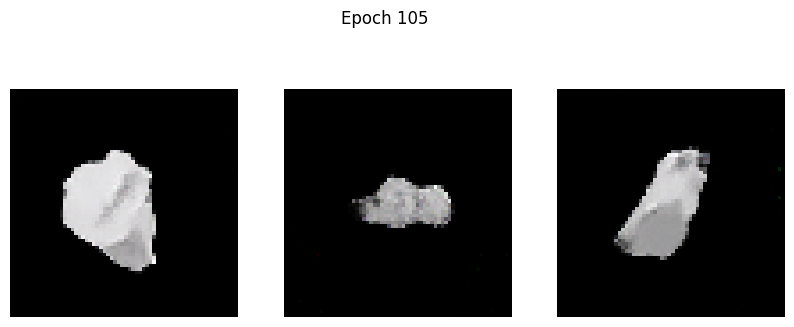

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1883 - g_loss: 2.4850
Epoch 106/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.5204 - g_loss: 2.8207

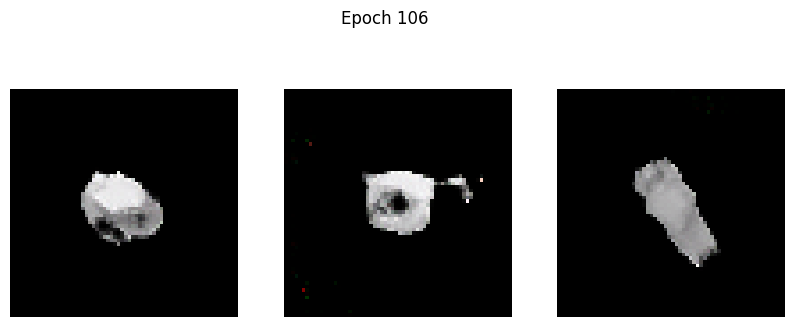

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.5192 - g_loss: 2.8187
Epoch 107/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1879 - g_loss: 2.4262

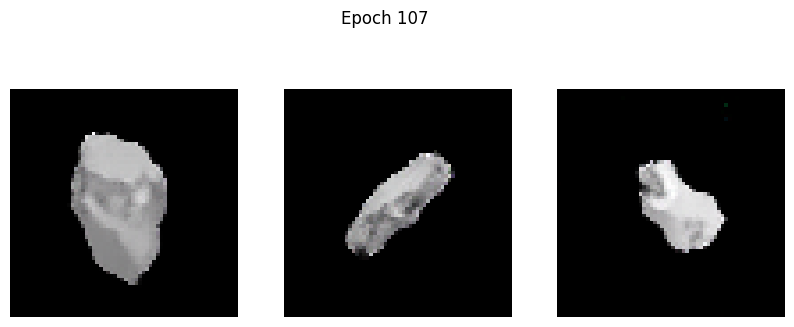

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - d_loss: 0.1881 - g_loss: 2.4264
Epoch 108/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - d_loss: 0.1867 - g_loss: 2.4809

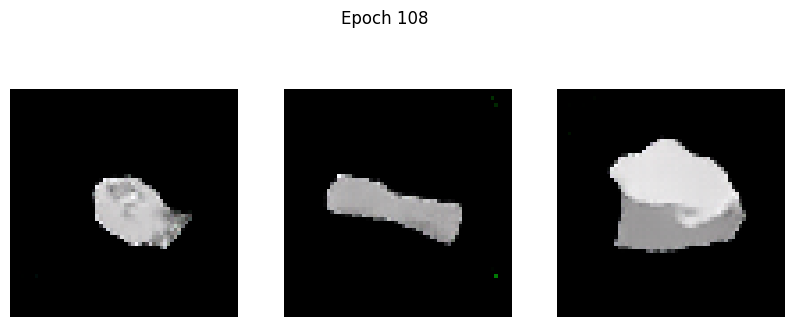

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - d_loss: 0.1869 - g_loss: 2.4810
Epoch 109/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - d_loss: 0.2141 - g_loss: 2.5202

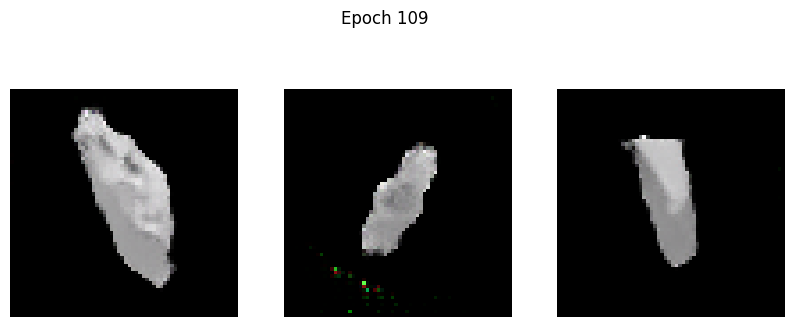

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - d_loss: 0.2139 - g_loss: 2.5200
Epoch 110/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3566 - g_loss: 2.7708

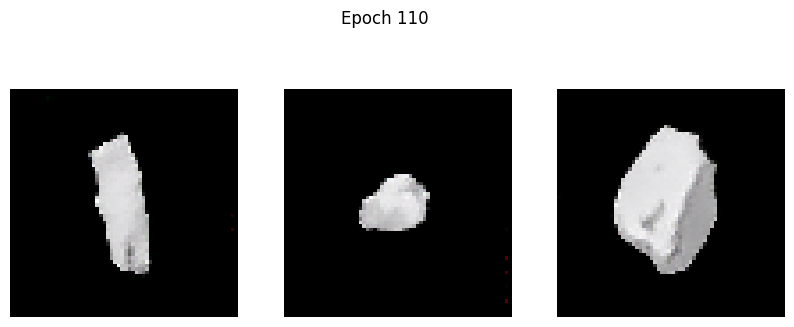

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3555 - g_loss: 2.7688
Epoch 111/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1829 - g_loss: 2.6231

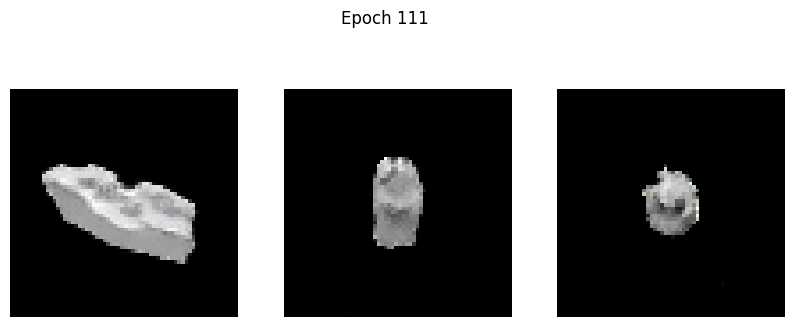

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1832 - g_loss: 2.6229
Epoch 112/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1929 - g_loss: 2.5546

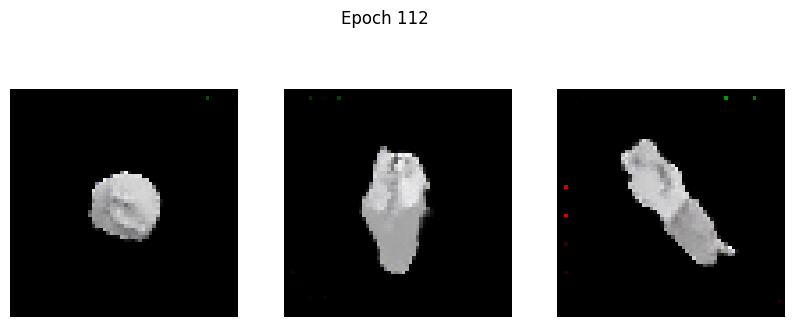

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1930 - g_loss: 2.5549
Epoch 113/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.2224 - g_loss: 2.7161

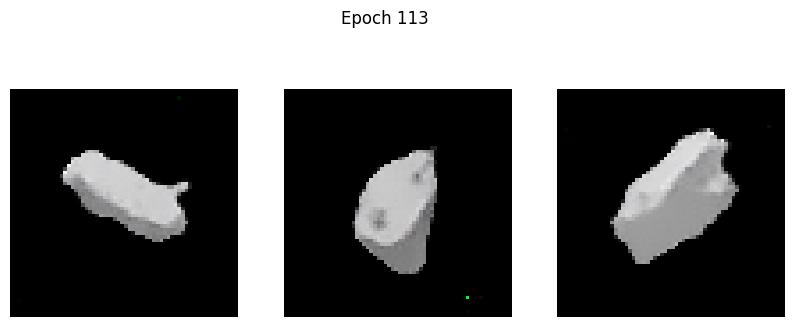

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.2222 - g_loss: 2.7154
Epoch 114/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1774 - g_loss: 2.6424

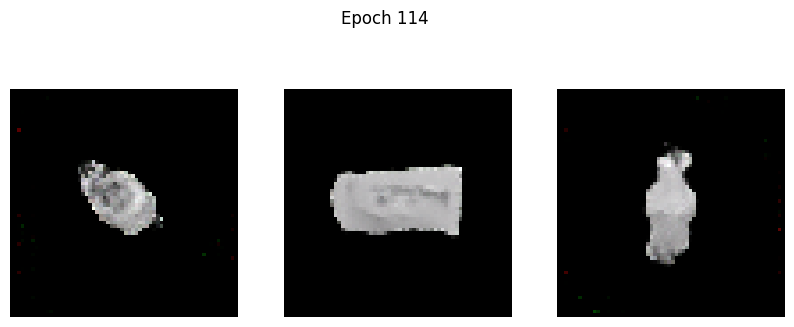

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1775 - g_loss: 2.6425
Epoch 115/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.3311 - g_loss: 2.8165

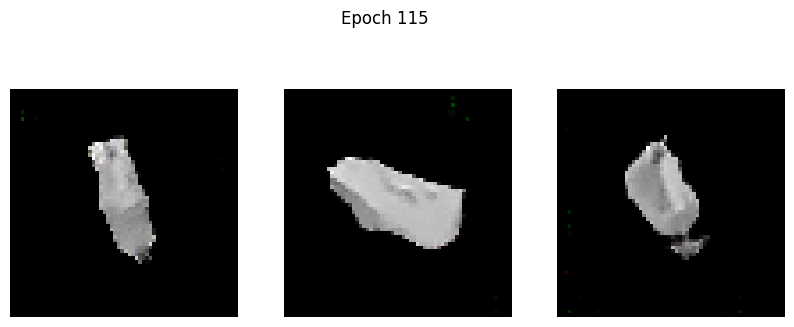

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3307 - g_loss: 2.8155
Epoch 116/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1838 - g_loss: 2.5797

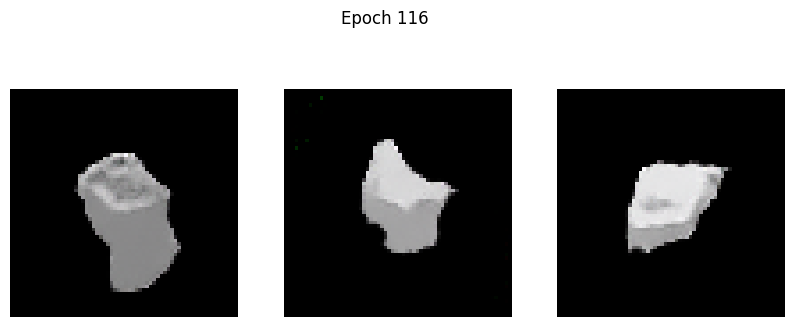

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1838 - g_loss: 2.5800
Epoch 117/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2545 - g_loss: 2.6998

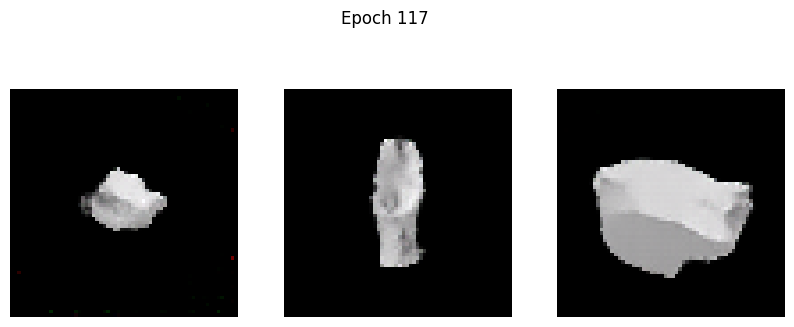

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2545 - g_loss: 2.6998
Epoch 118/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1804 - g_loss: 2.6460

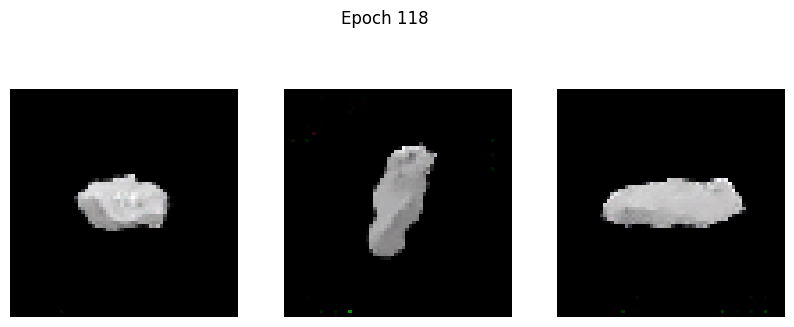

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1808 - g_loss: 2.6465
Epoch 119/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1582 - g_loss: 2.6623

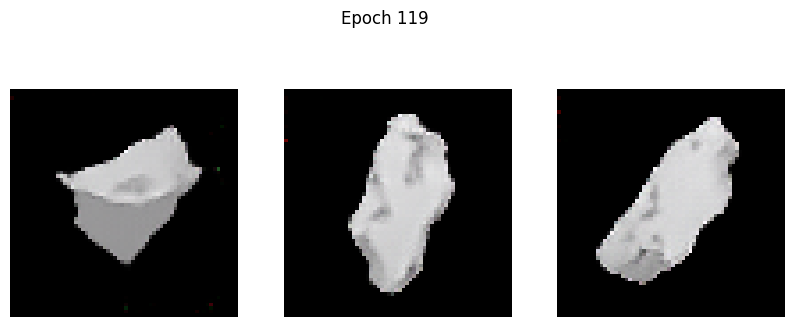

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1584 - g_loss: 2.6625
Epoch 120/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2387 - g_loss: 2.7190

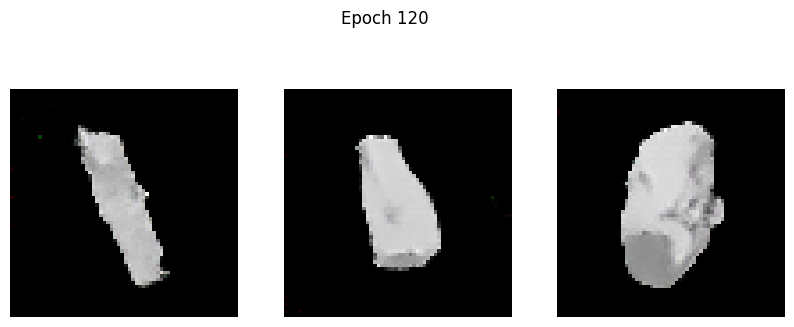

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2383 - g_loss: 2.7189
Epoch 121/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1720 - g_loss: 2.7214

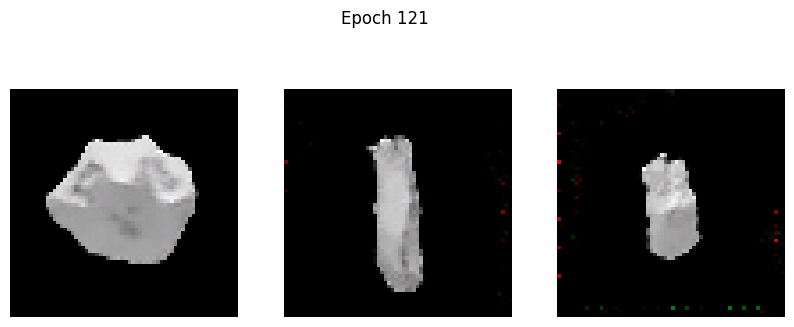

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1726 - g_loss: 2.7217
Epoch 122/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2057 - g_loss: 2.7022

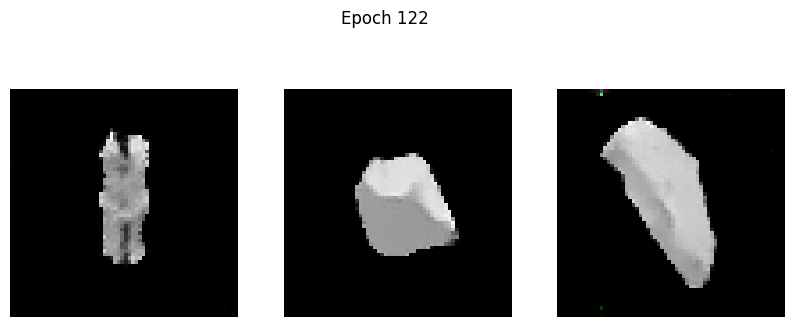

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2057 - g_loss: 2.7023
Epoch 123/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.1798 - g_loss: 2.7717

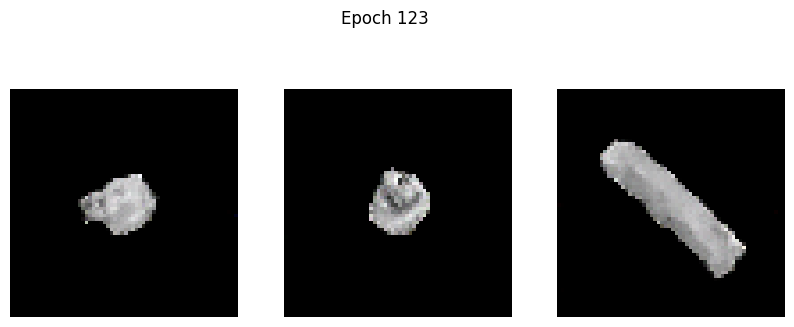

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1797 - g_loss: 2.7709
Epoch 124/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1683 - g_loss: 2.7223

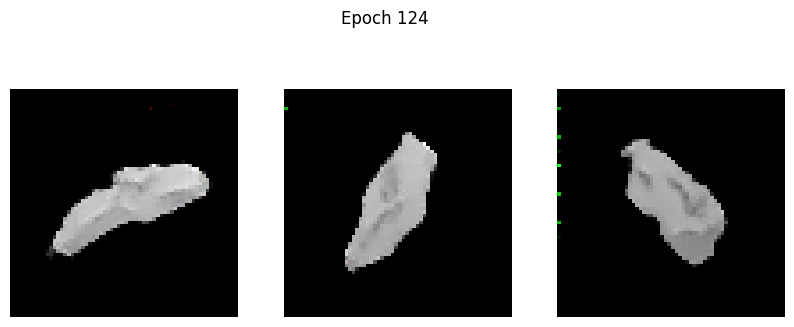

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1689 - g_loss: 2.7227
Epoch 125/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.1779 - g_loss: 2.7259

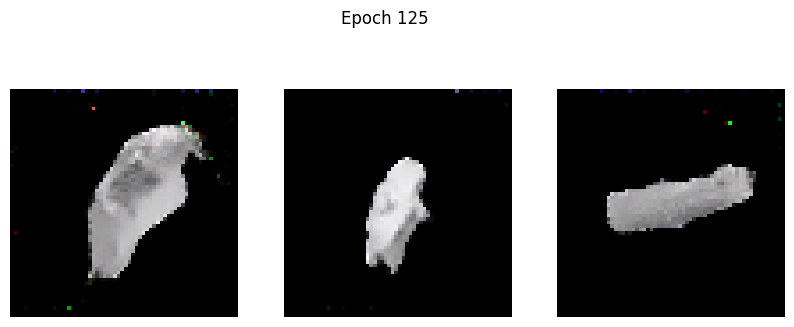

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1778 - g_loss: 2.7259
Epoch 126/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.2350 - g_loss: 2.8653

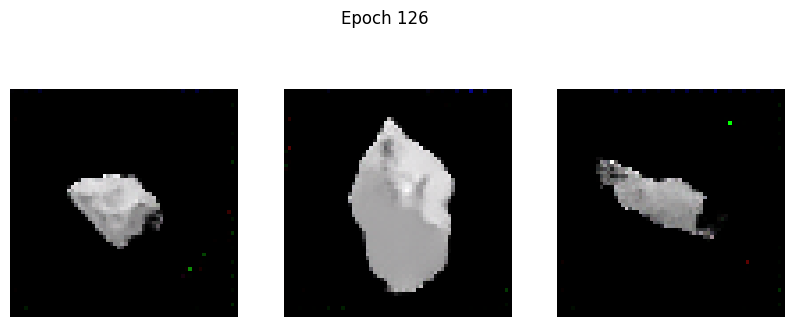

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - d_loss: 0.2347 - g_loss: 2.8650
Epoch 127/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.1568 - g_loss: 2.8017

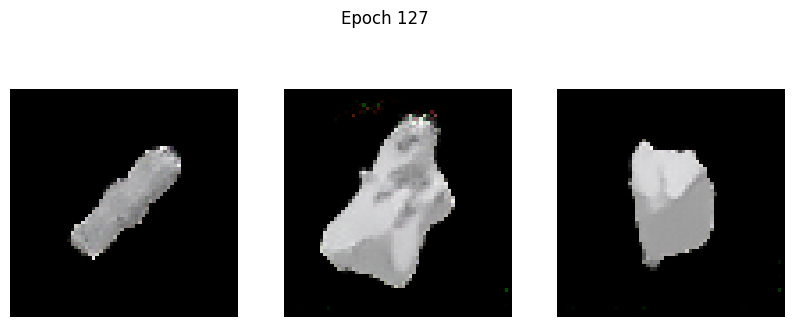

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1572 - g_loss: 2.8018
Epoch 128/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1731 - g_loss: 2.7077

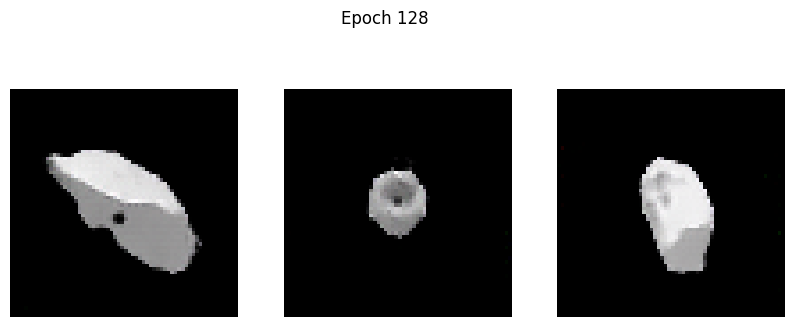

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1731 - g_loss: 2.7082
Epoch 129/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.1726 - g_loss: 2.8436

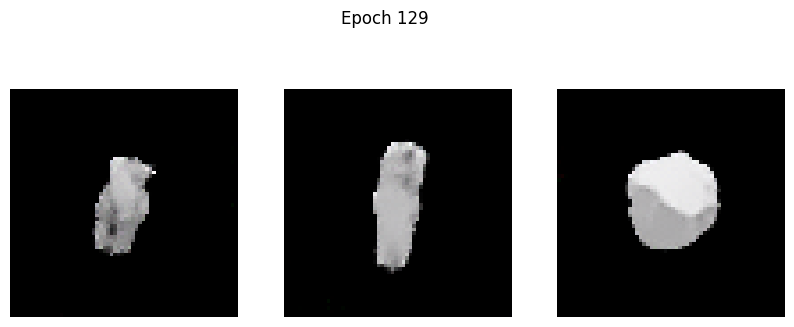

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1727 - g_loss: 2.8436
Epoch 130/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1670 - g_loss: 2.9461

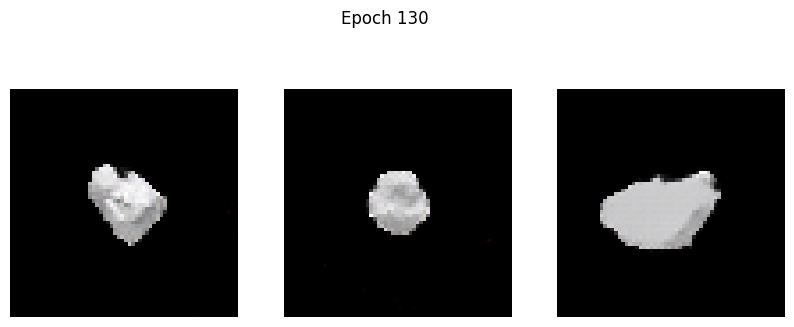

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1673 - g_loss: 2.9458
Epoch 131/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.2039 - g_loss: 2.9683

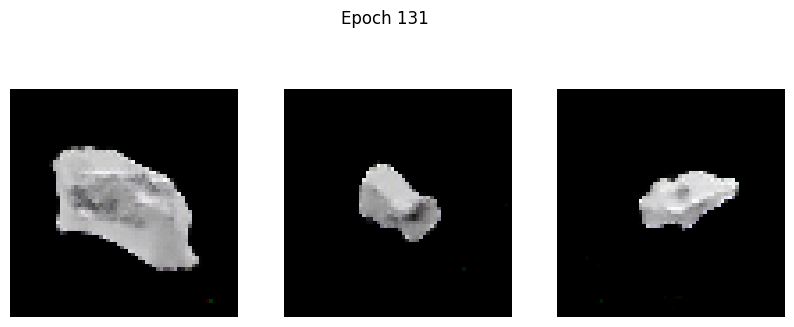

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2046 - g_loss: 2.9688
Epoch 132/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.3434 - g_loss: 2.9502

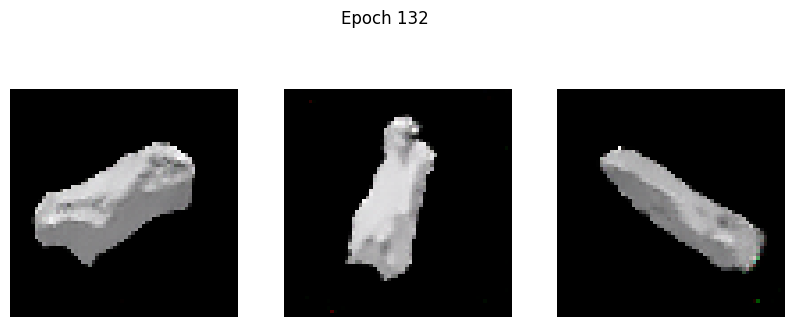

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.3422 - g_loss: 2.9487
Epoch 133/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1425 - g_loss: 2.7995

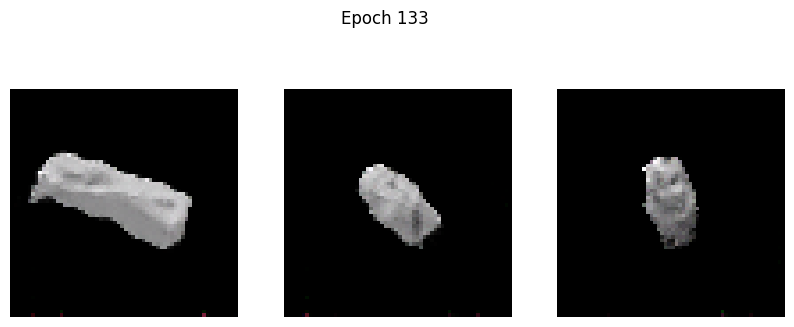

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1424 - g_loss: 2.7997
Epoch 134/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.2333 - g_loss: 2.9670

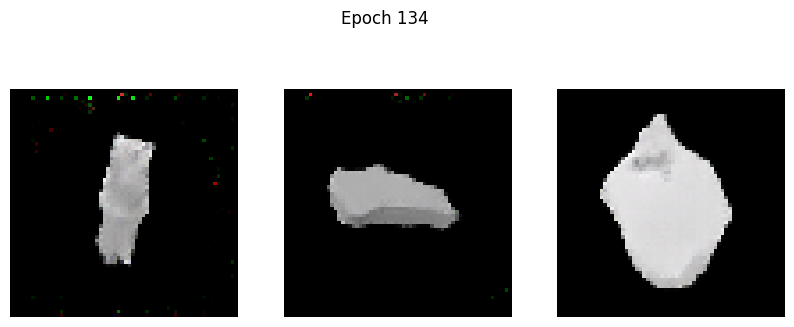

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2336 - g_loss: 2.9670
Epoch 135/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.1572 - g_loss: 2.8164

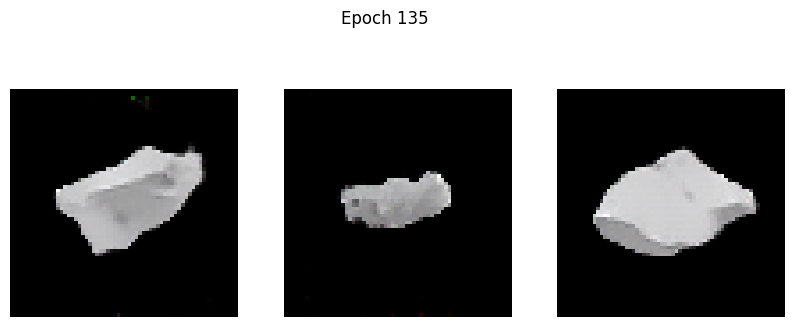

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1571 - g_loss: 2.8161
Epoch 136/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1611 - g_loss: 2.9172

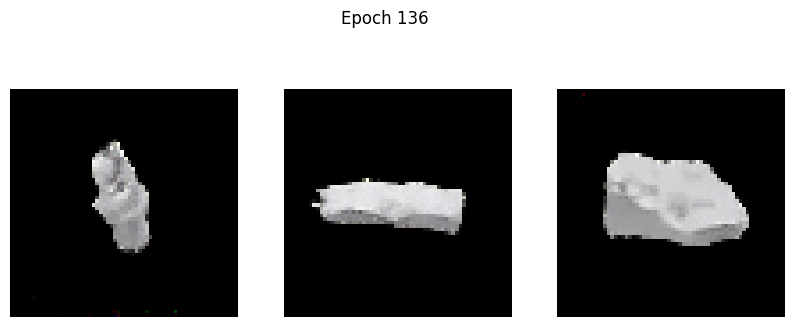

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1610 - g_loss: 2.9171
Epoch 137/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1501 - g_loss: 2.9252

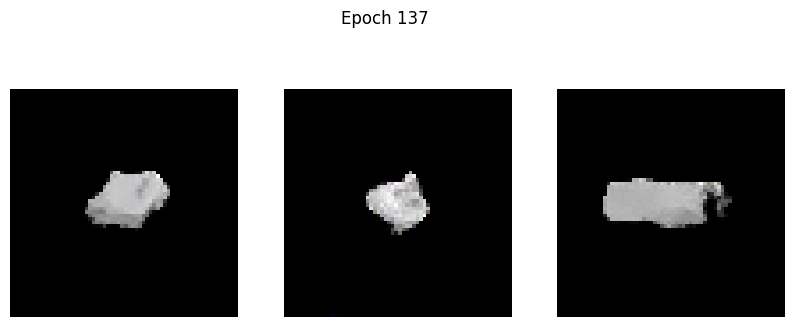

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1503 - g_loss: 2.9252
Epoch 138/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2205 - g_loss: 3.0178

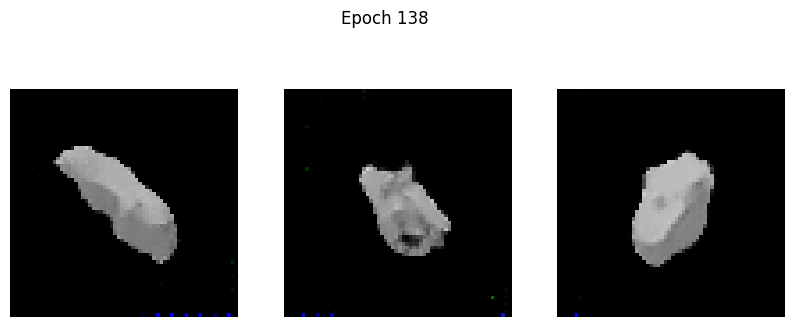

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2202 - g_loss: 3.0174
Epoch 139/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2406 - g_loss: 3.0557

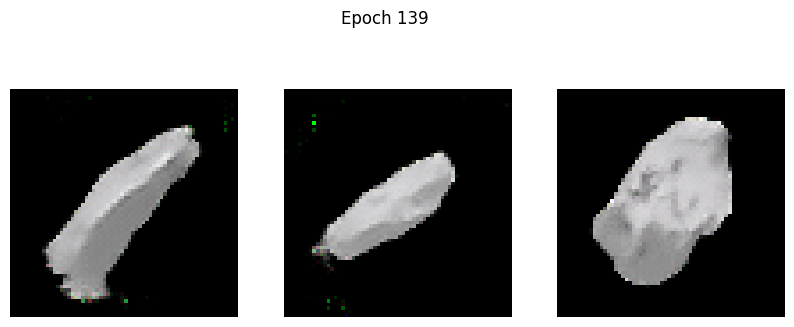

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2419 - g_loss: 3.0567
Epoch 140/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1973 - g_loss: 2.8412

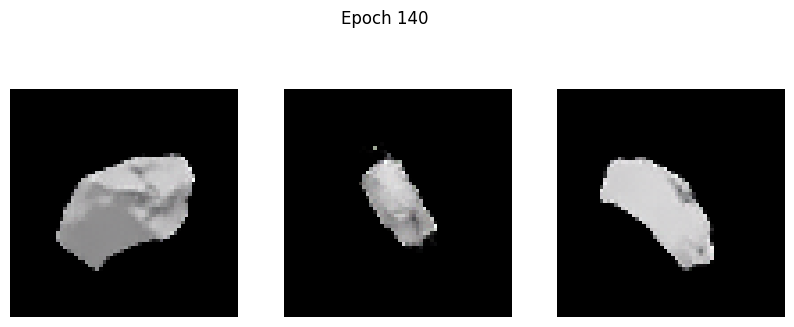

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1970 - g_loss: 2.8410
Epoch 141/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1290 - g_loss: 2.8467

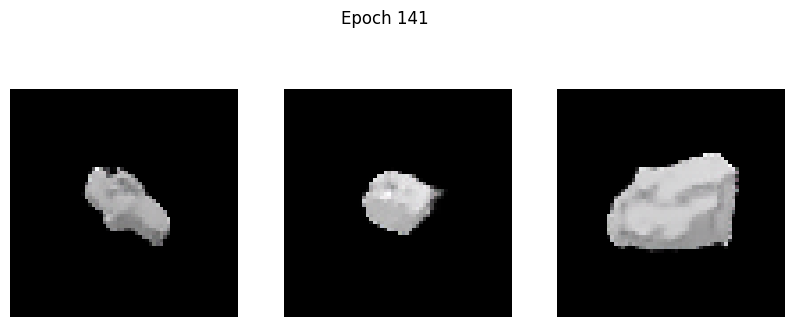

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1290 - g_loss: 2.8470
Epoch 142/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1403 - g_loss: 2.8267

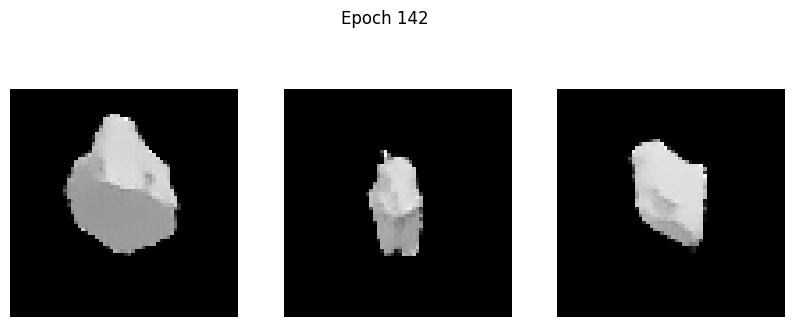

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1403 - g_loss: 2.8269
Epoch 143/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1589 - g_loss: 3.0456

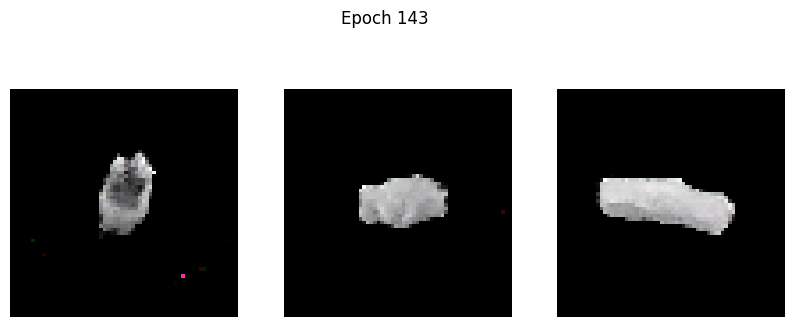

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1589 - g_loss: 3.0448
Epoch 144/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1538 - g_loss: 3.0331

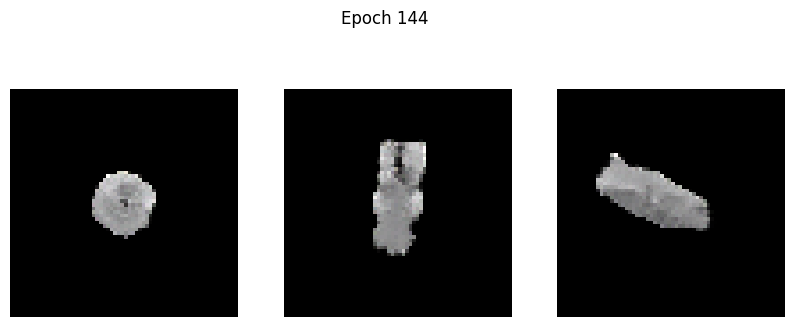

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1539 - g_loss: 3.0329
Epoch 145/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.4870 - g_loss: 3.4877

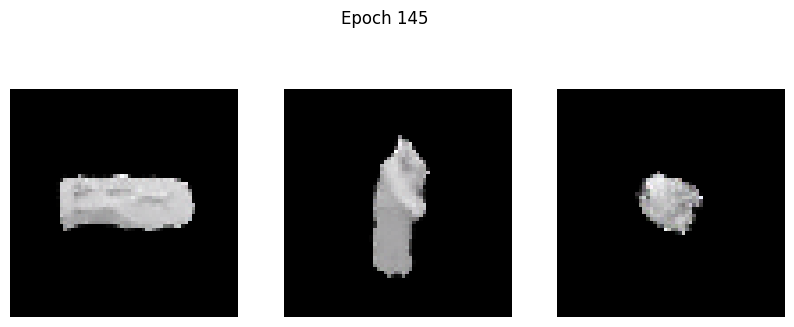

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.4873 - g_loss: 3.4868
Epoch 146/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1646 - g_loss: 2.7721

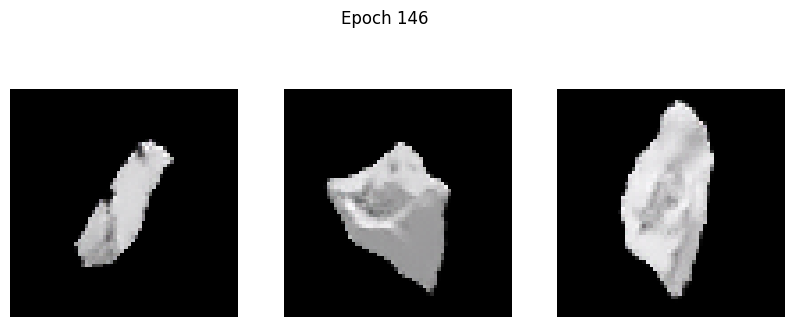

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1645 - g_loss: 2.7726
Epoch 147/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1361 - g_loss: 2.8350

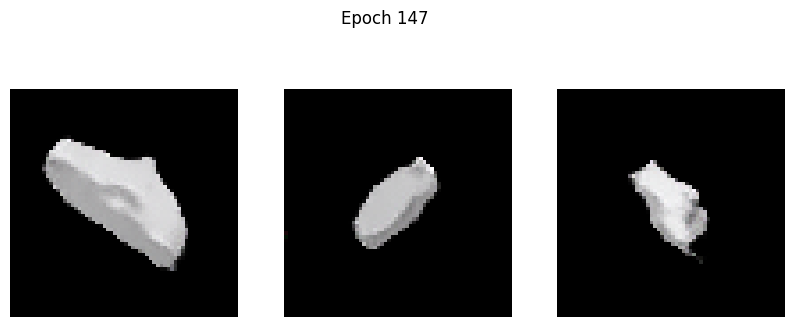

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1361 - g_loss: 2.8353
Epoch 148/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1291 - g_loss: 2.9395

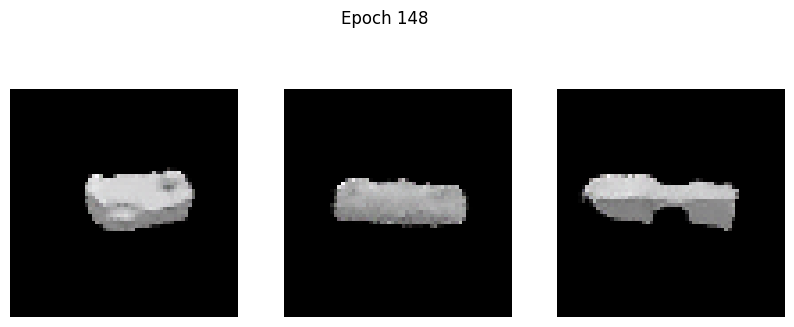

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1294 - g_loss: 2.9397
Epoch 149/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1566 - g_loss: 2.9115

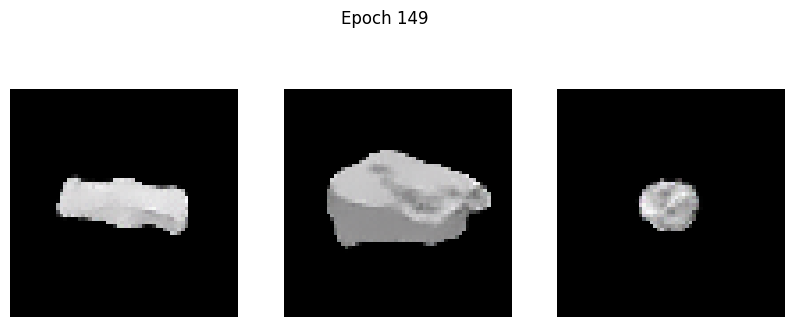

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1567 - g_loss: 2.9118
Epoch 150/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1424 - g_loss: 3.0189

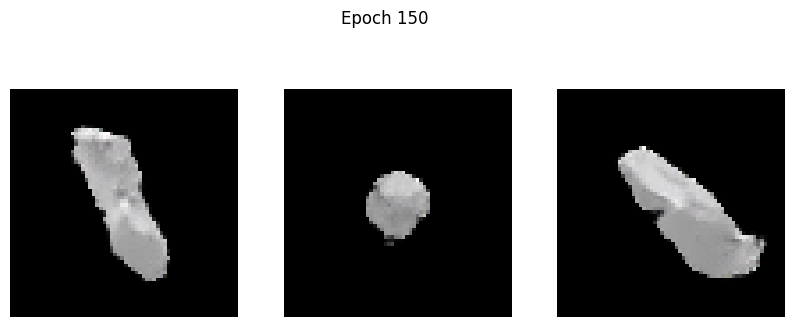

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1424 - g_loss: 3.0191
Epoch 151/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1707 - g_loss: 3.1159

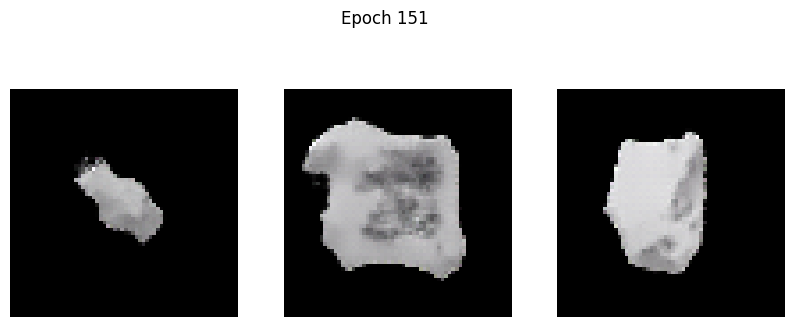

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1718 - g_loss: 3.1168
Epoch 152/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1762 - g_loss: 2.8782

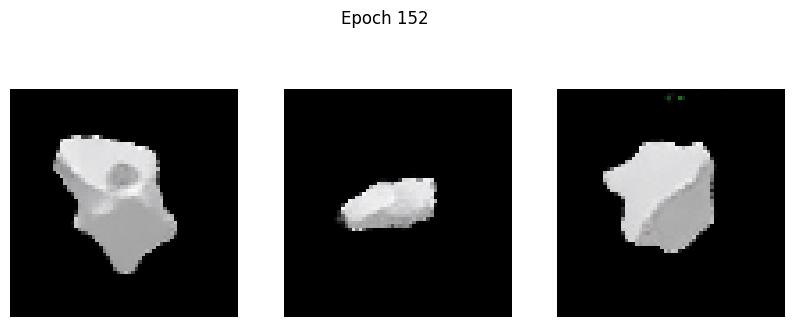

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1760 - g_loss: 2.8783
Epoch 153/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1393 - g_loss: 3.0274

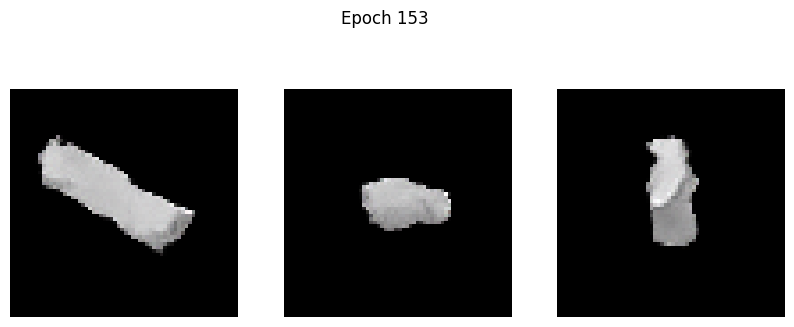

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1393 - g_loss: 3.0274
Epoch 154/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1450 - g_loss: 3.0864

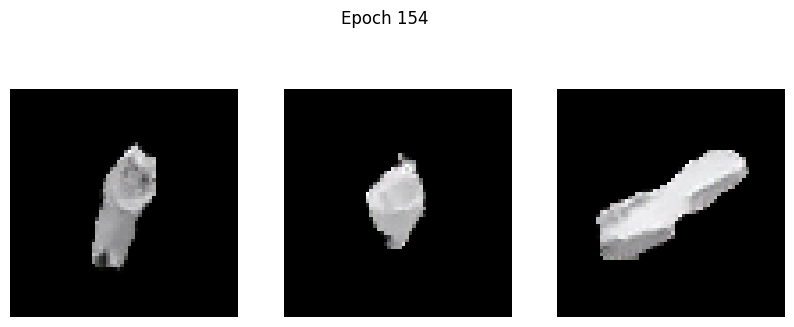

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1449 - g_loss: 3.0862
Epoch 155/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1864 - g_loss: 3.0815

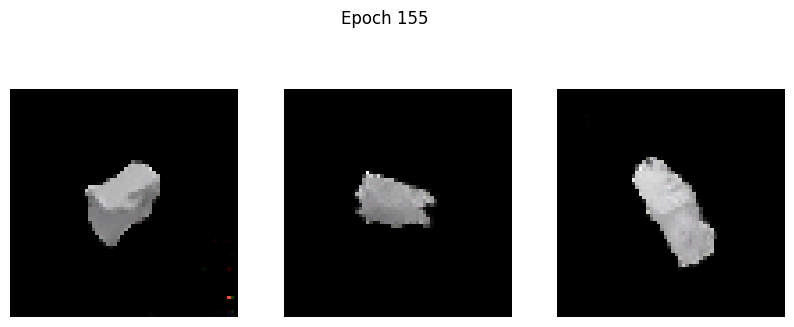

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1864 - g_loss: 3.0814
Epoch 156/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1515 - g_loss: 3.0966

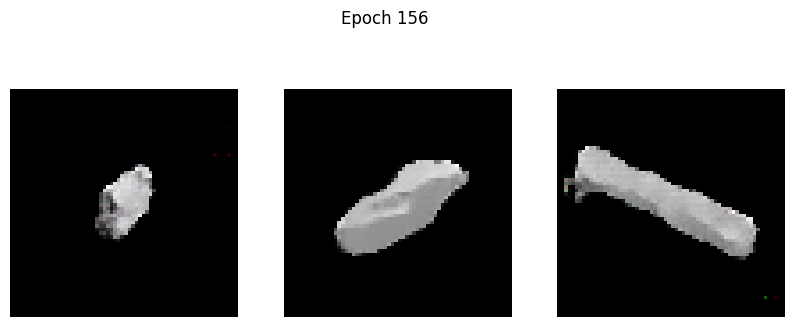

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1515 - g_loss: 3.0965
Epoch 157/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2849 - g_loss: 3.3053

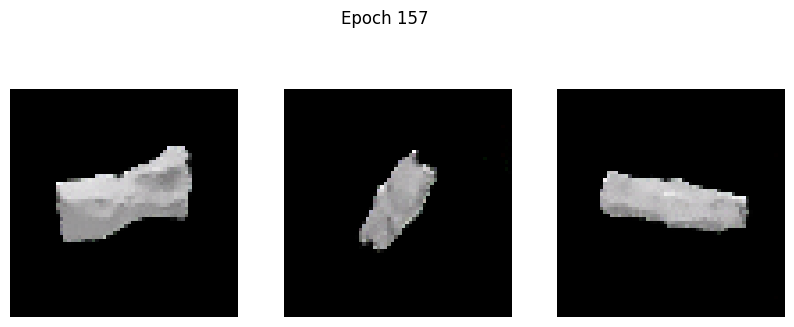

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2846 - g_loss: 3.3039
Epoch 158/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1501 - g_loss: 3.1201

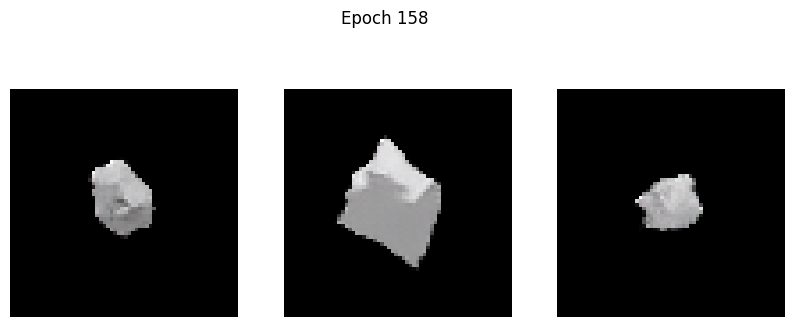

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1501 - g_loss: 3.1198
Epoch 159/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1306 - g_loss: 3.0877

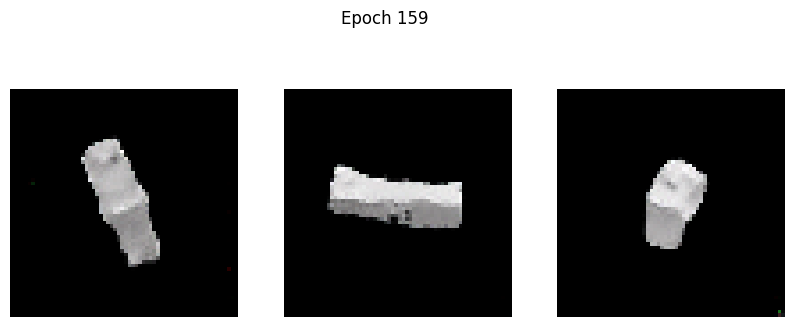

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1306 - g_loss: 3.0880
Epoch 160/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1558 - g_loss: 3.2301

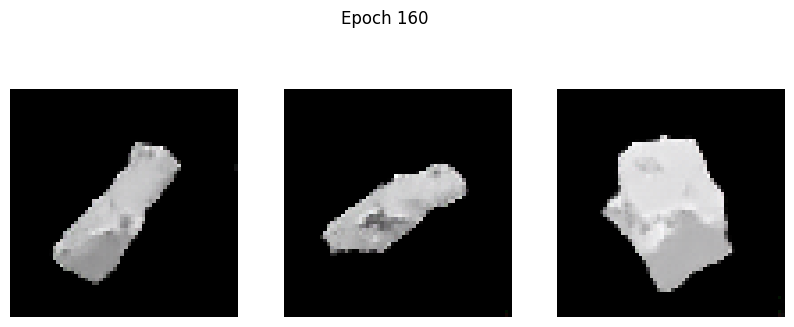

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1570 - g_loss: 3.2314
Epoch 161/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1514 - g_loss: 3.0701

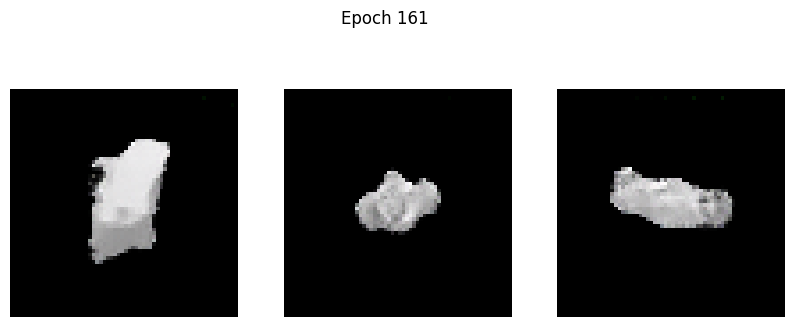

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1513 - g_loss: 3.0697
Epoch 162/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1308 - g_loss: 3.1206

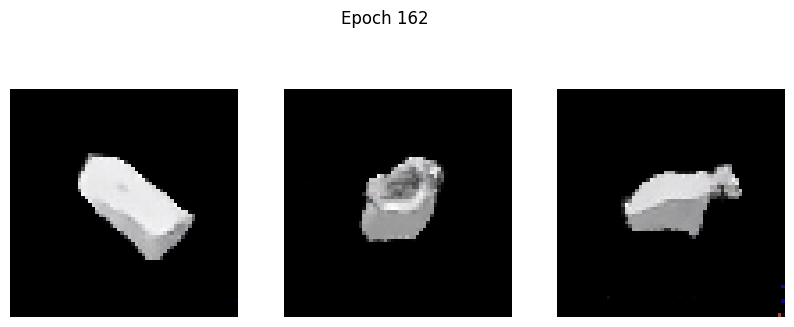

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1308 - g_loss: 3.1204
Epoch 163/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1358 - g_loss: 3.2075

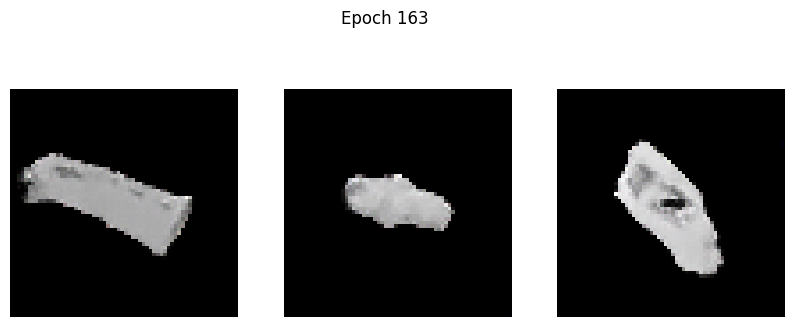

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1360 - g_loss: 3.2074
Epoch 164/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1602 - g_loss: 3.2373

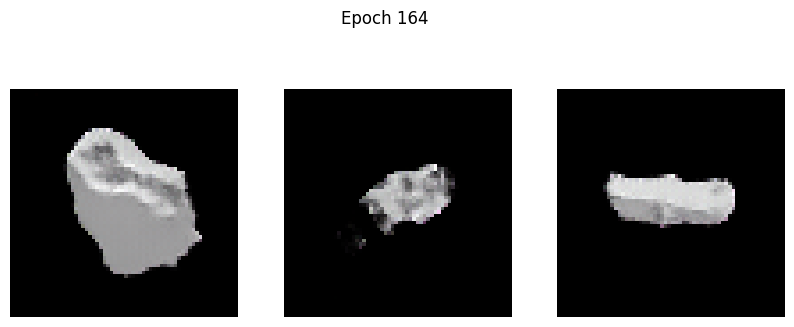

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1607 - g_loss: 3.2376
Epoch 165/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2575 - g_loss: 3.3070

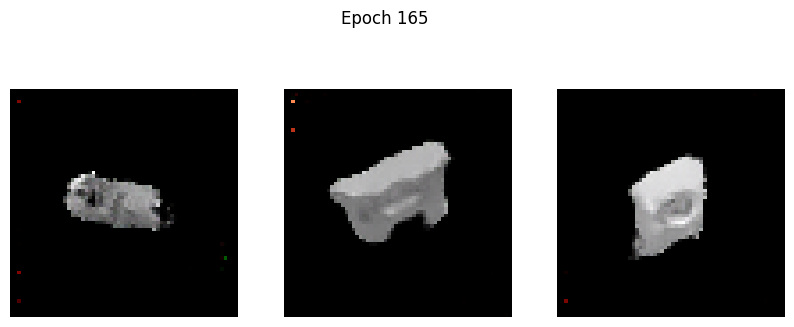

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.2567 - g_loss: 3.3055
Epoch 166/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1947 - g_loss: 3.2942

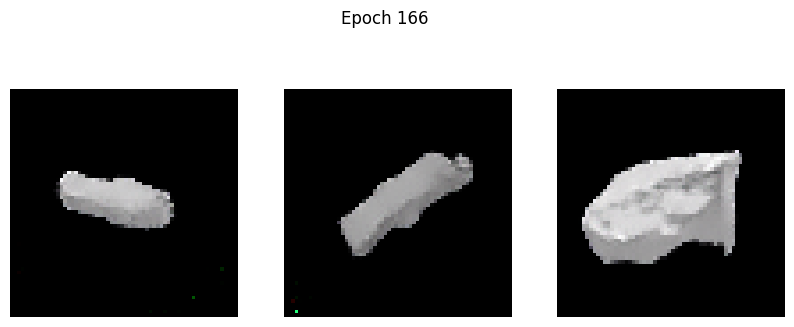

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1944 - g_loss: 3.2936
Epoch 167/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1404 - g_loss: 3.0477

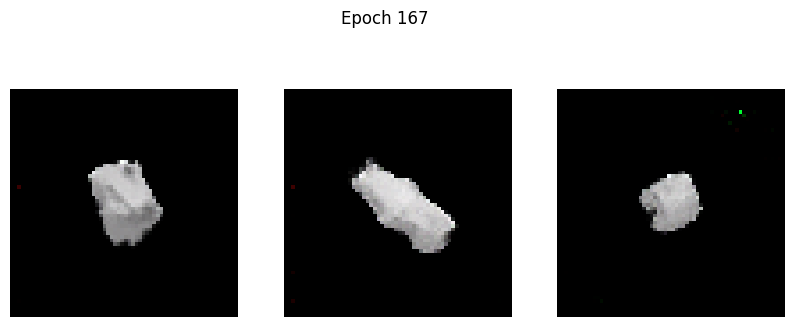

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1404 - g_loss: 3.0481
Epoch 168/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1275 - g_loss: 3.2501

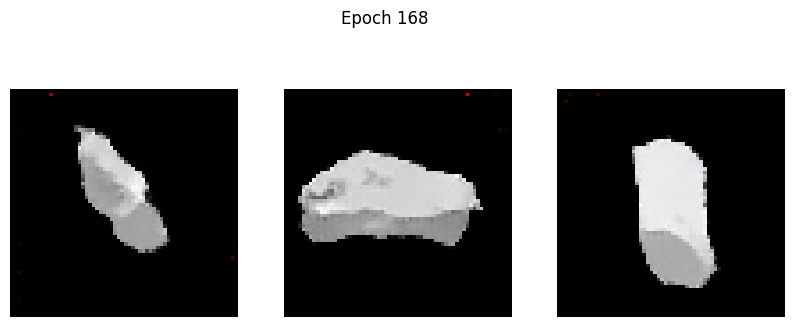

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1276 - g_loss: 3.2502
Epoch 169/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2139 - g_loss: 3.3017

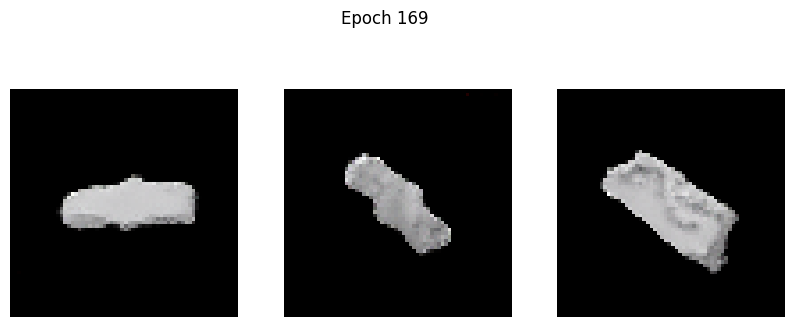

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2137 - g_loss: 3.3014
Epoch 170/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1360 - g_loss: 3.3234

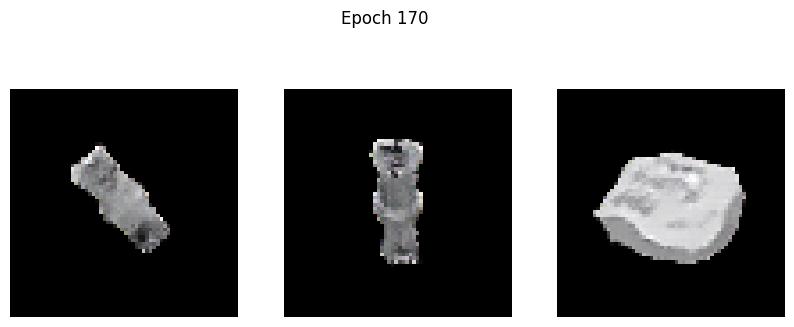

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1363 - g_loss: 3.3234
Epoch 171/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.3583 - g_loss: 3.1408

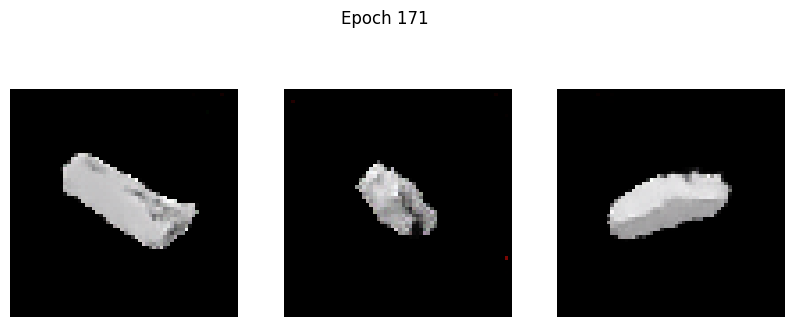

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.3566 - g_loss: 3.1407
Epoch 172/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1308 - g_loss: 3.2150

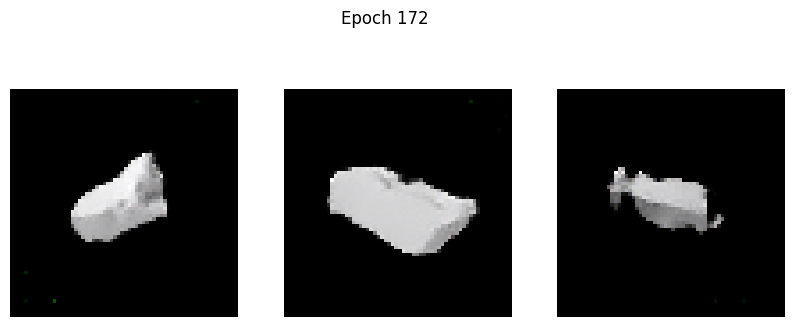

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1309 - g_loss: 3.2150
Epoch 173/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1436 - g_loss: 3.2510

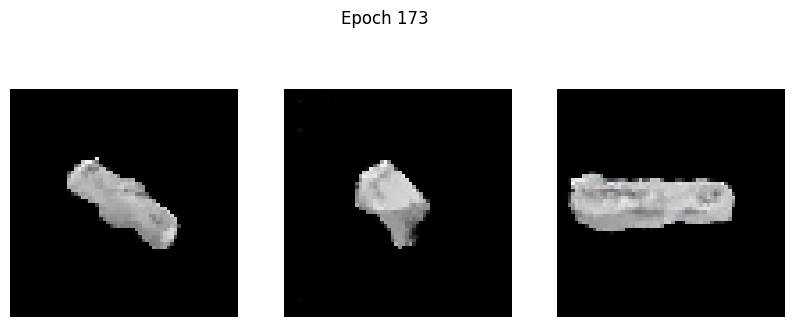

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1438 - g_loss: 3.2513
Epoch 174/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1485 - g_loss: 3.3103

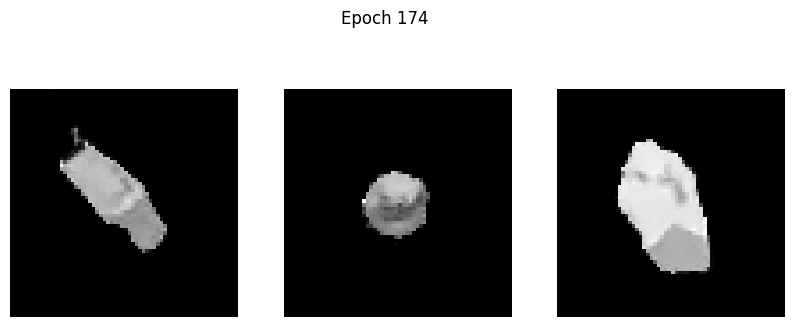

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1486 - g_loss: 3.3101
Epoch 175/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1176 - g_loss: 3.2891

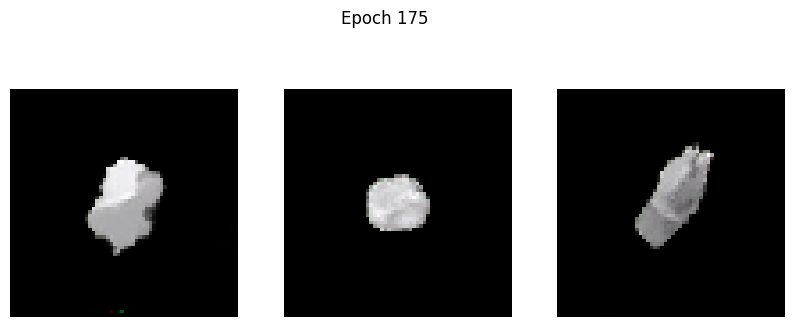

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1179 - g_loss: 3.2893
Epoch 176/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2616 - g_loss: 3.5905

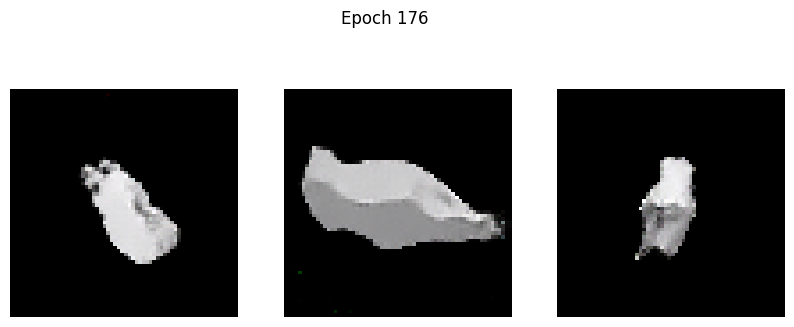

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2608 - g_loss: 3.5882
Epoch 177/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1404 - g_loss: 3.3563

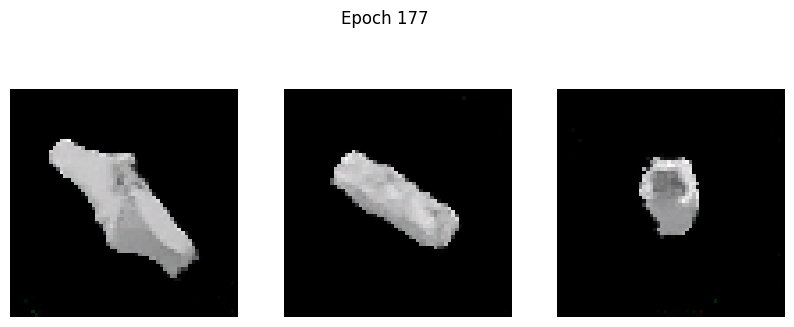

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1402 - g_loss: 3.3559
Epoch 178/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1410 - g_loss: 3.4139

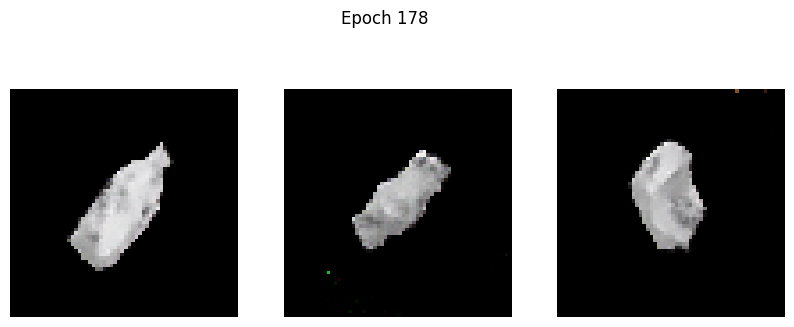

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1416 - g_loss: 3.4141
Epoch 179/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1456 - g_loss: 3.2404

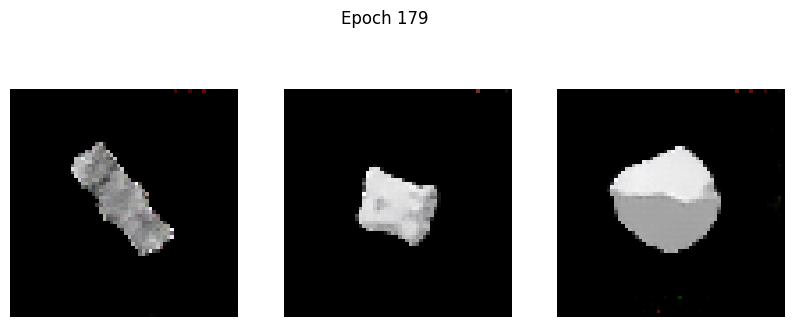

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1455 - g_loss: 3.2409
Epoch 180/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2004 - g_loss: 3.4403

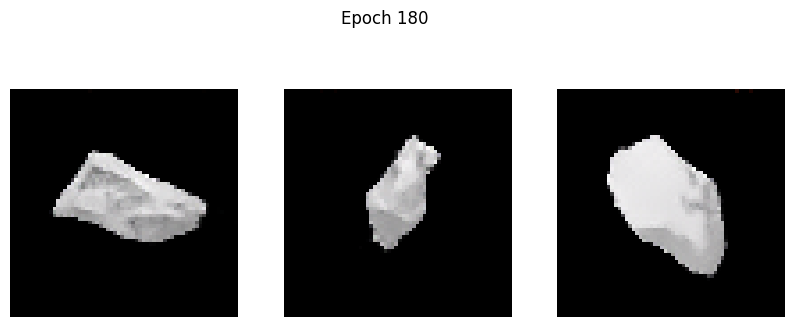

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2005 - g_loss: 3.4403
Epoch 181/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1014 - g_loss: 3.3004

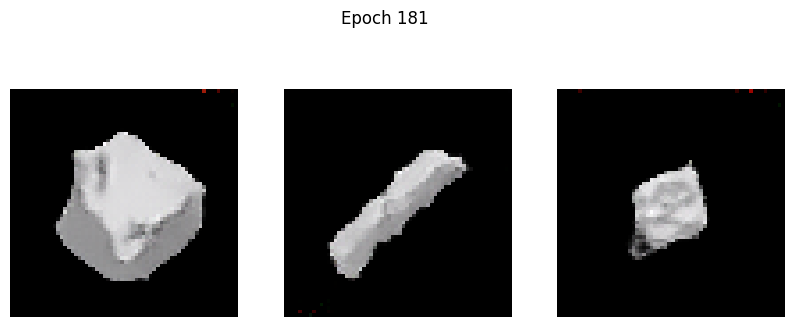

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1014 - g_loss: 3.3005
Epoch 182/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1559 - g_loss: 3.4127

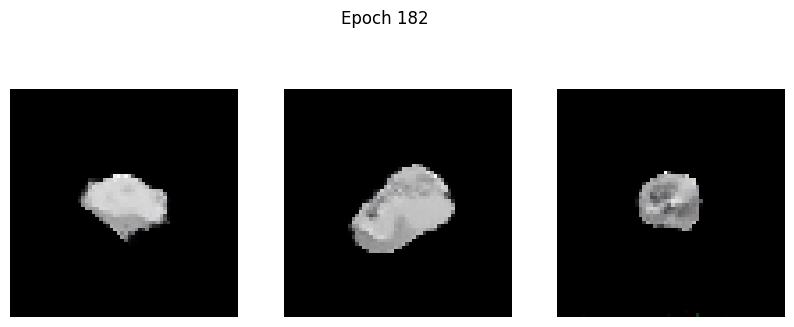

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1562 - g_loss: 3.4125
Epoch 183/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1000 - g_loss: 3.2969

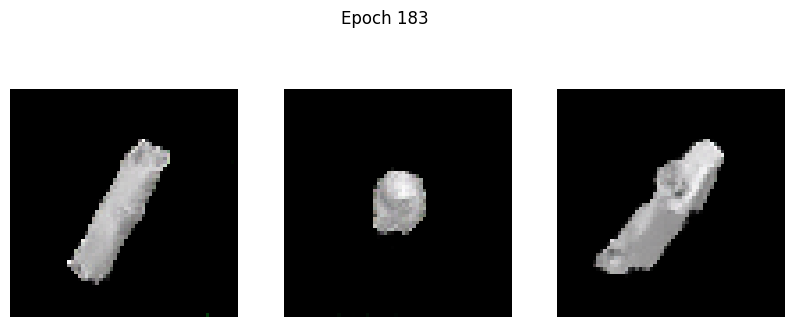

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0999 - g_loss: 3.2971
Epoch 184/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1102 - g_loss: 3.3438

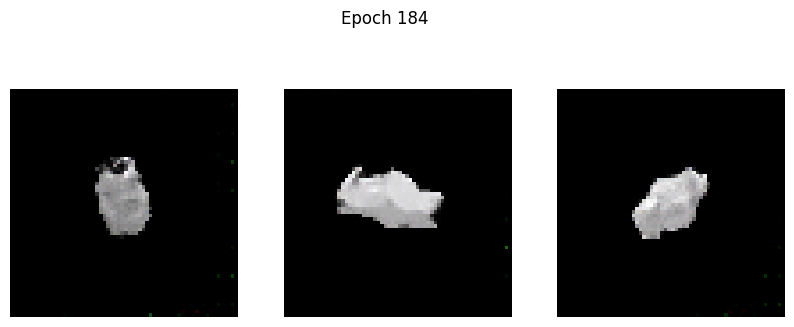

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1102 - g_loss: 3.3440
Epoch 185/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.4396 - g_loss: 4.1023

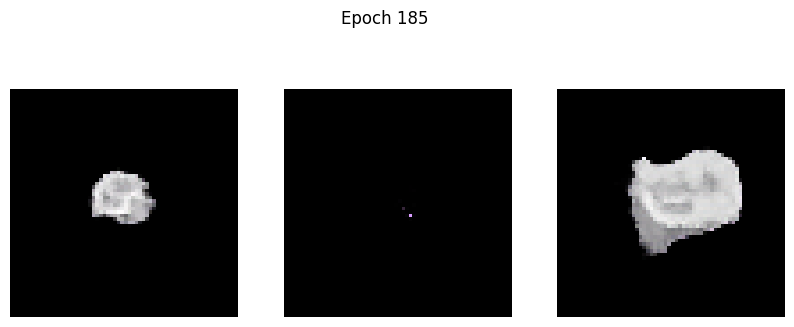

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.4402 - g_loss: 4.1036
Epoch 186/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1035 - g_loss: 3.4394

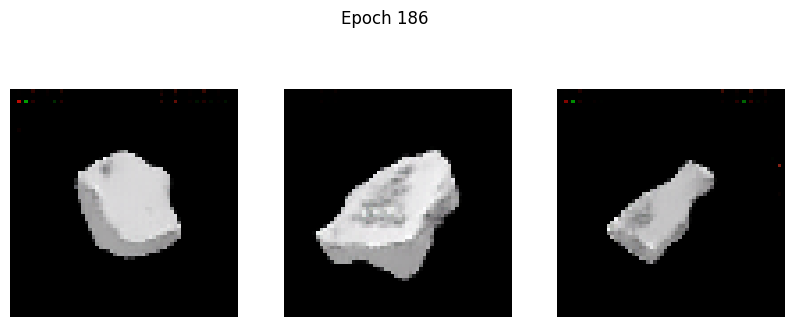

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1035 - g_loss: 3.4385
Epoch 187/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1199 - g_loss: 3.4067

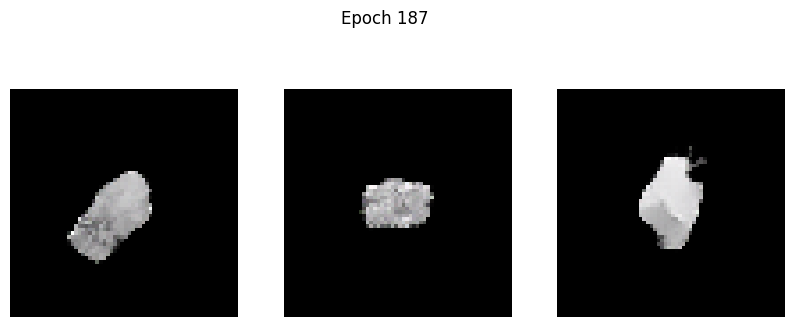

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1199 - g_loss: 3.4057
Epoch 188/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1132 - g_loss: 3.3168

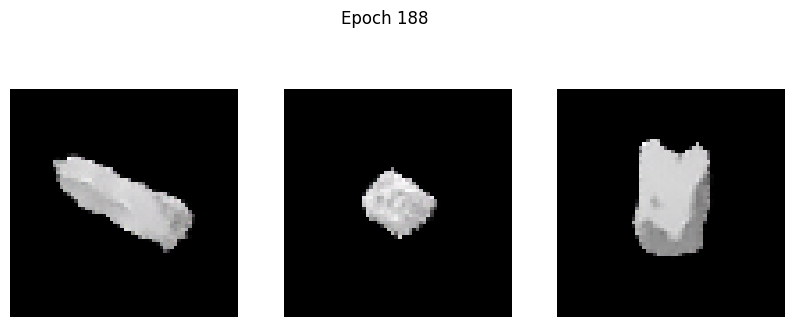

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1132 - g_loss: 3.3164
Epoch 189/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1550 - g_loss: 3.4421

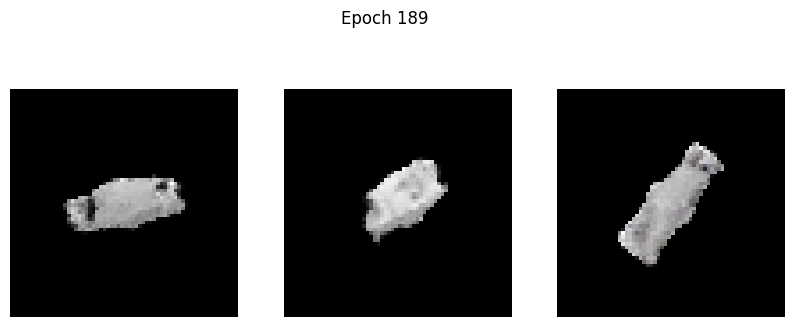

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1549 - g_loss: 3.4415
Epoch 190/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1127 - g_loss: 3.3799

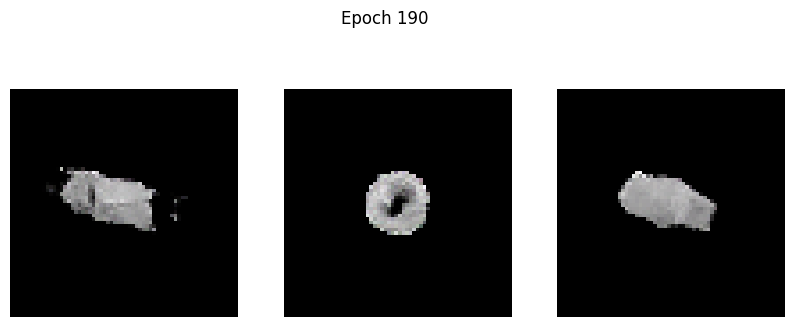

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1127 - g_loss: 3.3797
Epoch 191/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1788 - g_loss: 3.5415

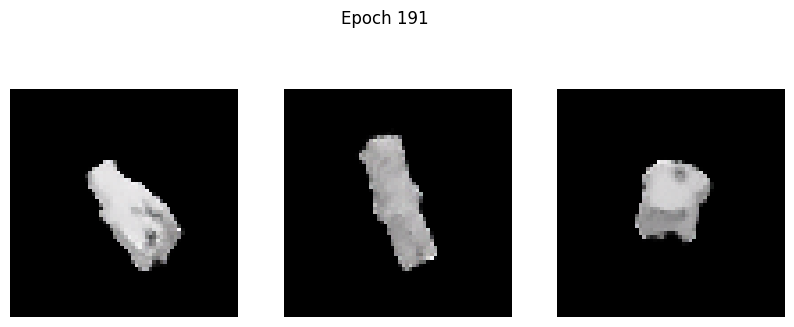

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1789 - g_loss: 3.5410
Epoch 192/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1304 - g_loss: 3.3425

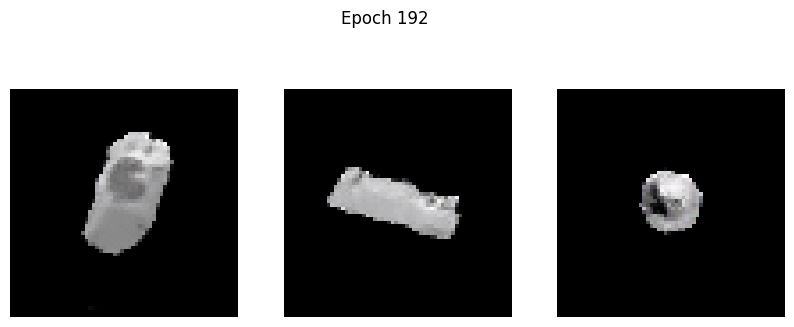

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1305 - g_loss: 3.3431
Epoch 193/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1350 - g_loss: 3.4045

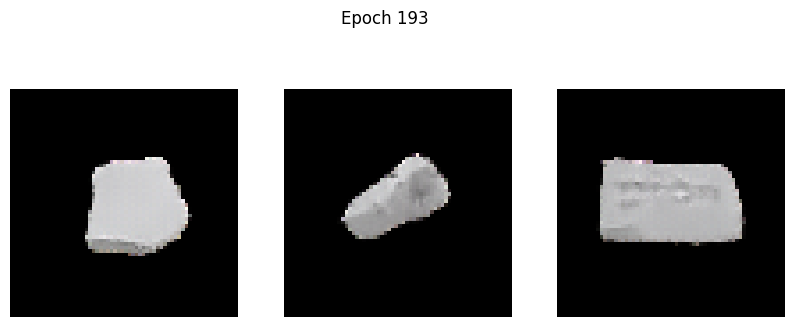

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1363 - g_loss: 3.4073
Epoch 194/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1285 - g_loss: 3.4010

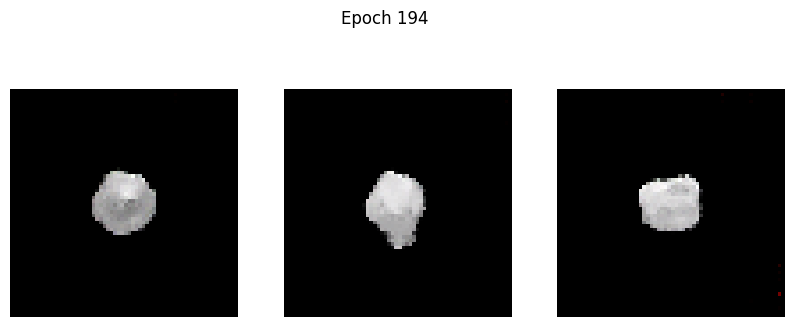

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1283 - g_loss: 3.4006
Epoch 195/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0955 - g_loss: 3.4105

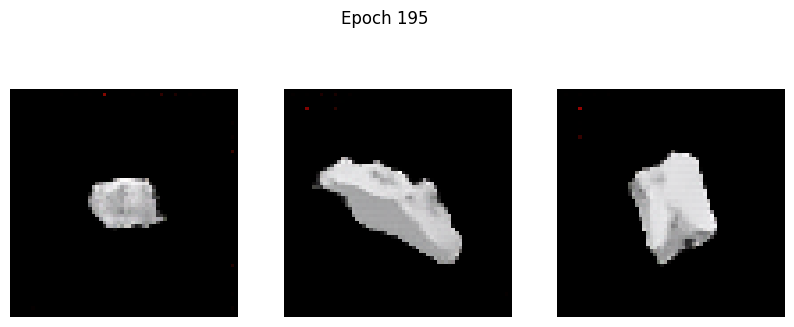

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - d_loss: 0.0956 - g_loss: 3.4103
Epoch 196/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1019 - g_loss: 3.4422

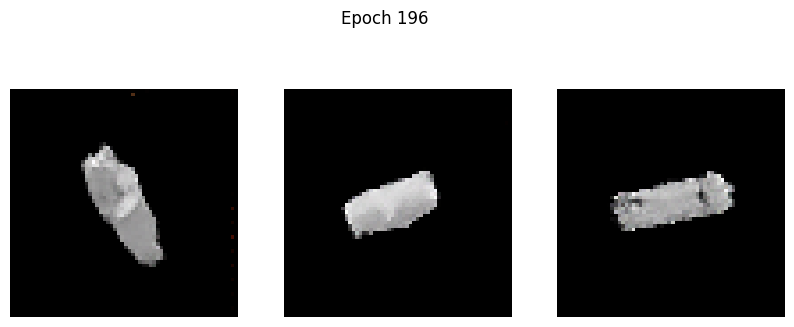

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1020 - g_loss: 3.4422
Epoch 197/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1117 - g_loss: 3.4566

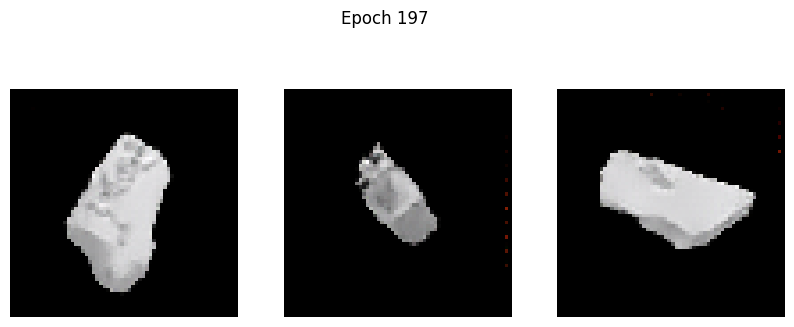

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1119 - g_loss: 3.4569
Epoch 198/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1213 - g_loss: 3.5549

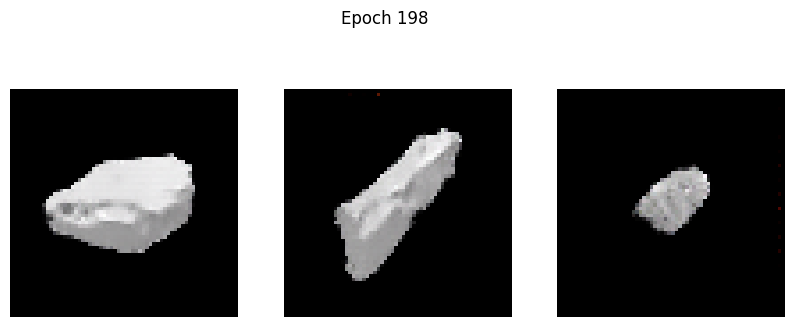

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1212 - g_loss: 3.5546
Epoch 199/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1102 - g_loss: 3.5597

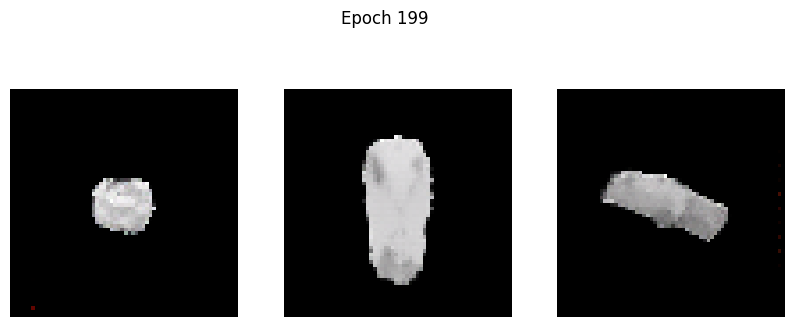

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1105 - g_loss: 3.5596
Epoch 200/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1407 - g_loss: 3.5324

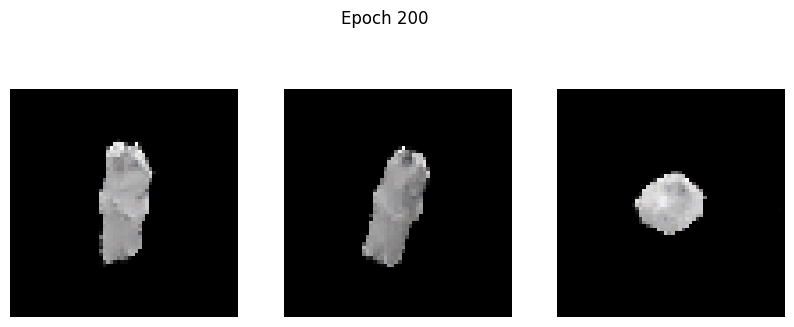

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1408 - g_loss: 3.5324
Epoch 201/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0925 - g_loss: 3.5391

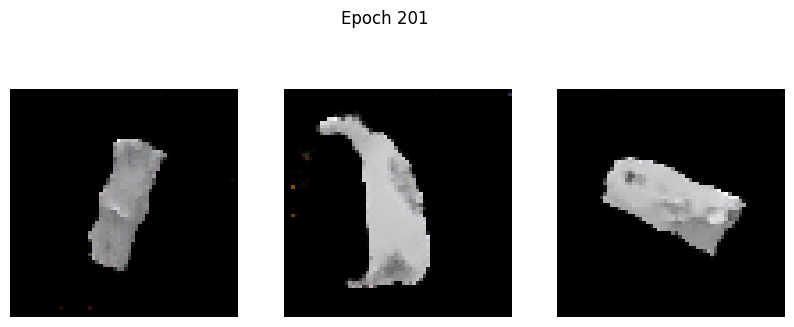

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0925 - g_loss: 3.5390
Epoch 202/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1678 - g_loss: 3.6580

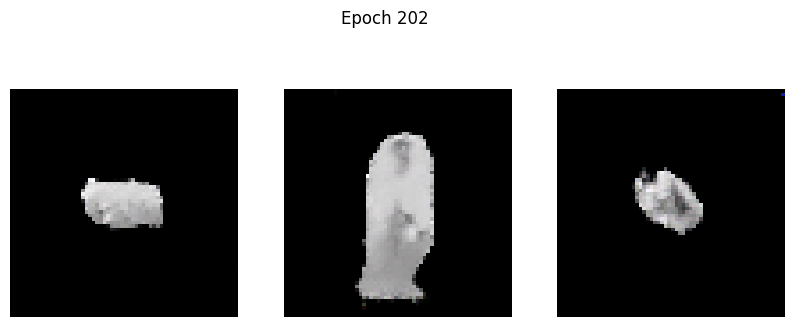

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1679 - g_loss: 3.6584
Epoch 203/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1174 - g_loss: 3.5594

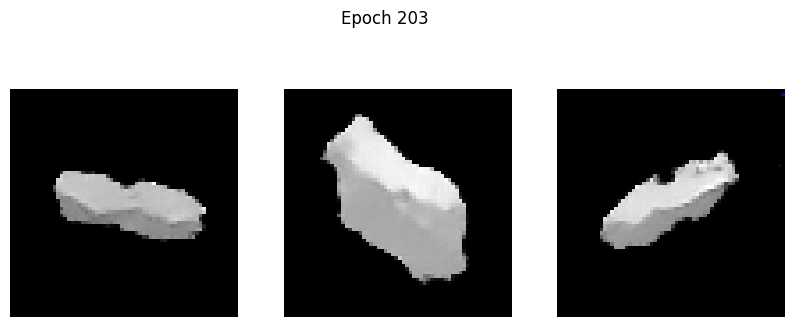

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1175 - g_loss: 3.5597
Epoch 204/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1506 - g_loss: 3.5834

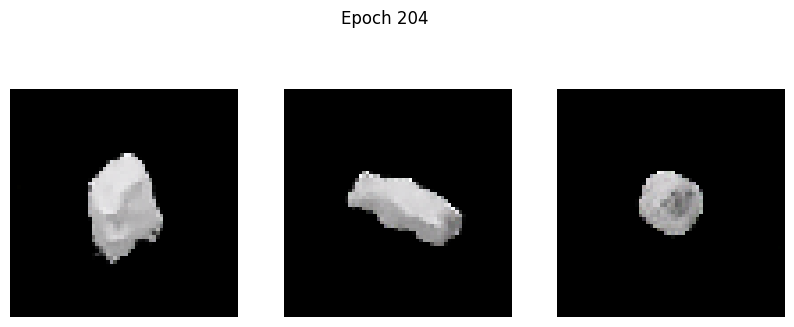

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1505 - g_loss: 3.5831
Epoch 205/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1316 - g_loss: 3.6653

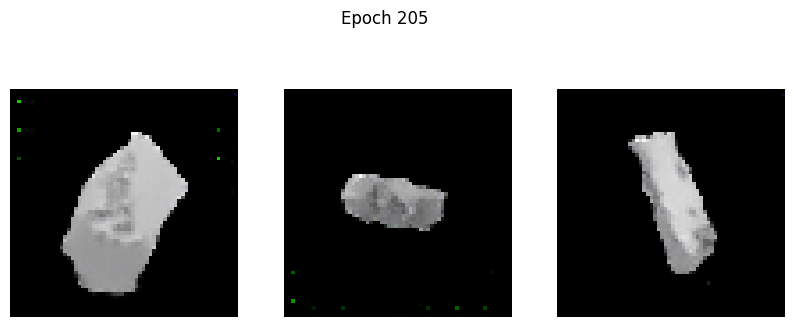

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1316 - g_loss: 3.6646
Epoch 206/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1159 - g_loss: 3.5821

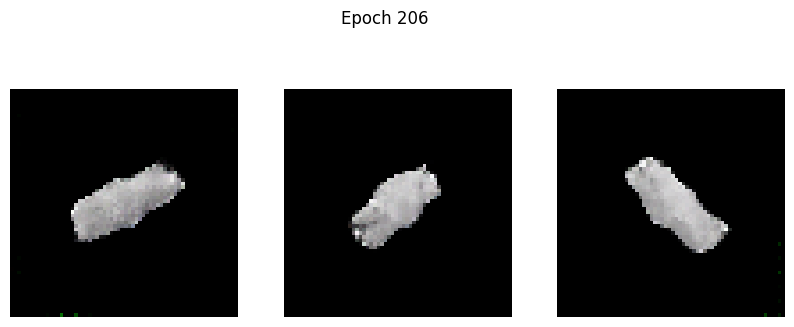

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1159 - g_loss: 3.5819
Epoch 207/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1640 - g_loss: 3.6500

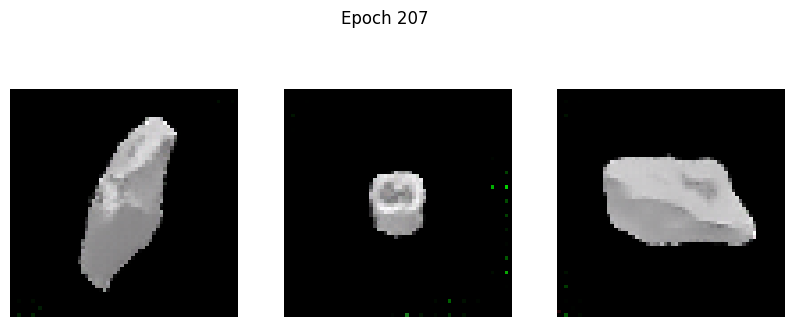

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1648 - g_loss: 3.6502
Epoch 208/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1189 - g_loss: 3.5245

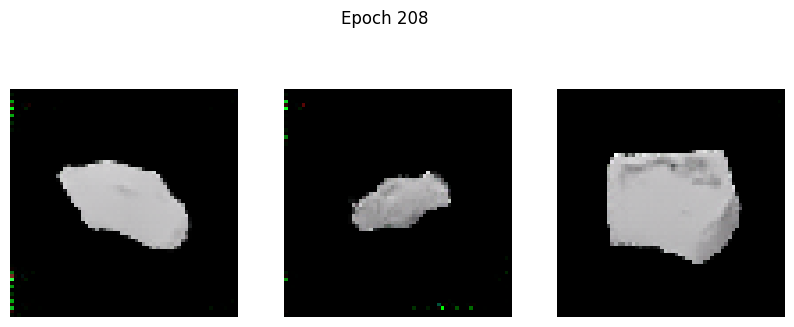

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1188 - g_loss: 3.5244
Epoch 209/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1495 - g_loss: 3.5428

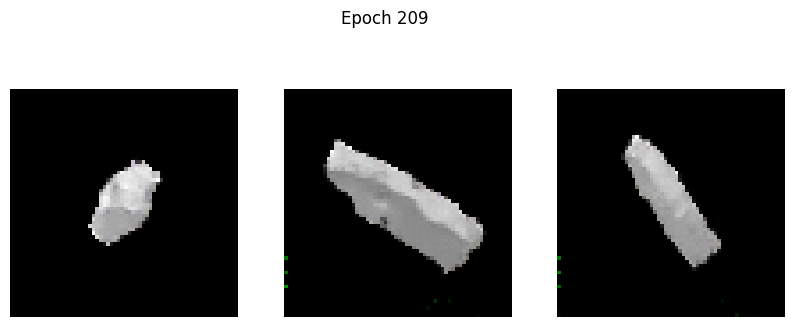

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1497 - g_loss: 3.5435
Epoch 210/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1023 - g_loss: 3.4613

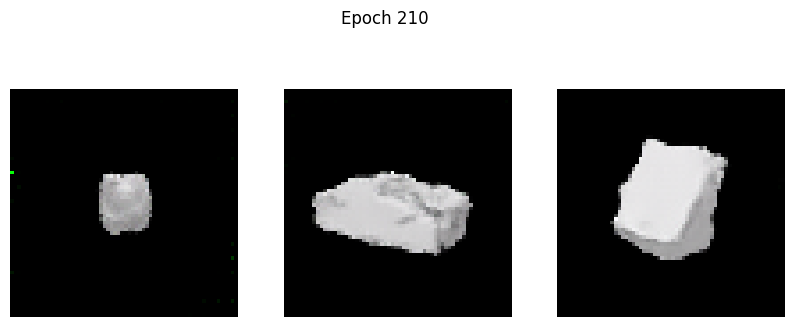

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1023 - g_loss: 3.4618
Epoch 211/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1094 - g_loss: 3.5469

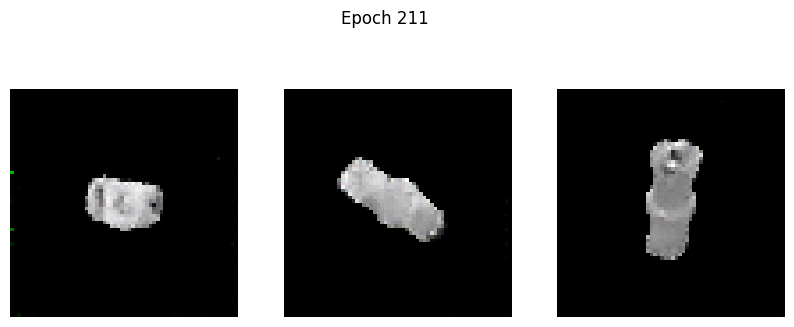

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1095 - g_loss: 3.5475
Epoch 212/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1508 - g_loss: 3.6213

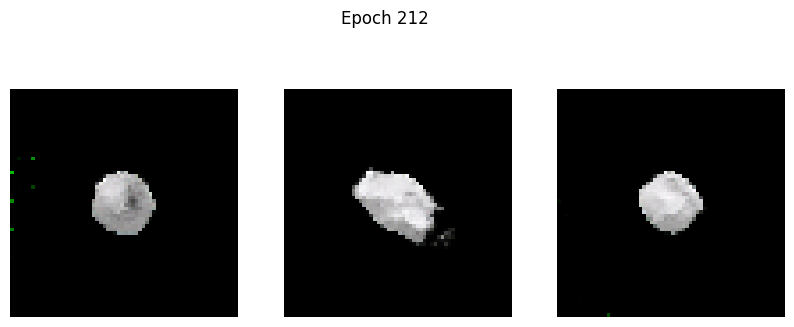

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1508 - g_loss: 3.6214
Epoch 213/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0915 - g_loss: 3.5763

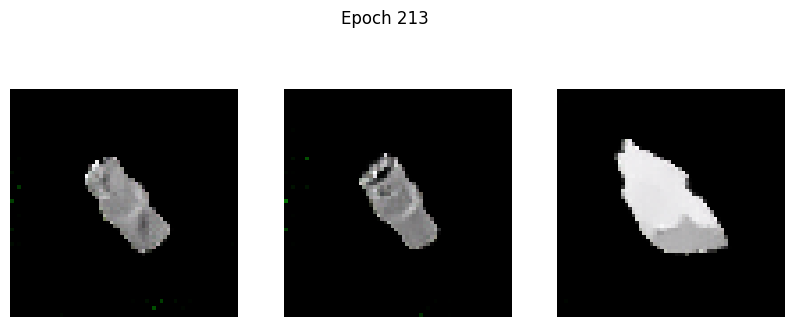

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0916 - g_loss: 3.5765
Epoch 214/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1364 - g_loss: 3.6619

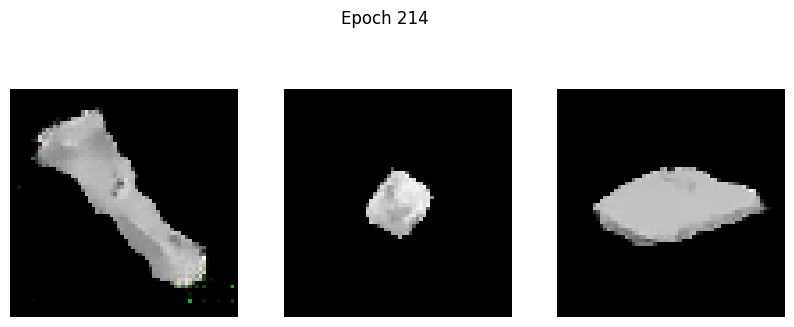

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1365 - g_loss: 3.6619
Epoch 215/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1166 - g_loss: 3.6967

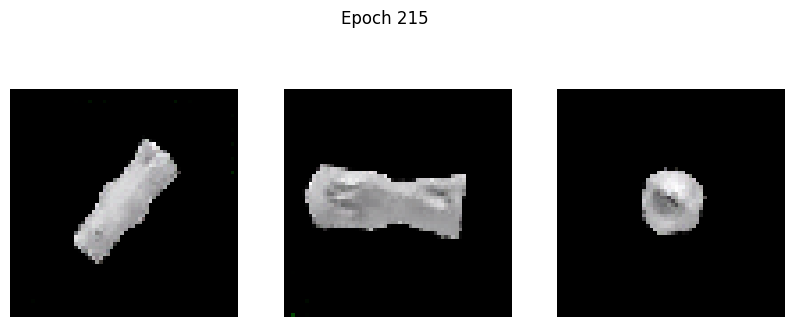

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1166 - g_loss: 3.6965
Epoch 216/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0822 - g_loss: 3.5717

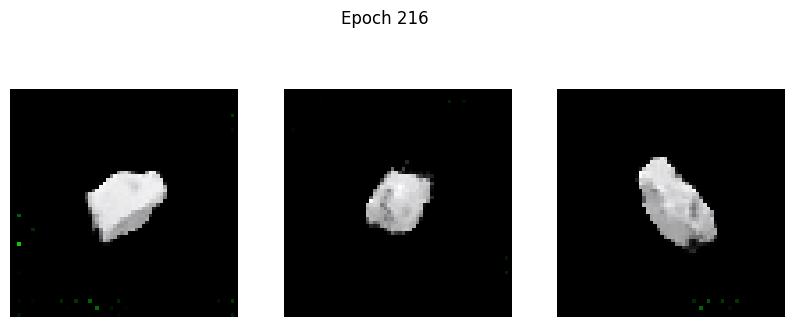

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0823 - g_loss: 3.5720
Epoch 217/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0997 - g_loss: 3.7831

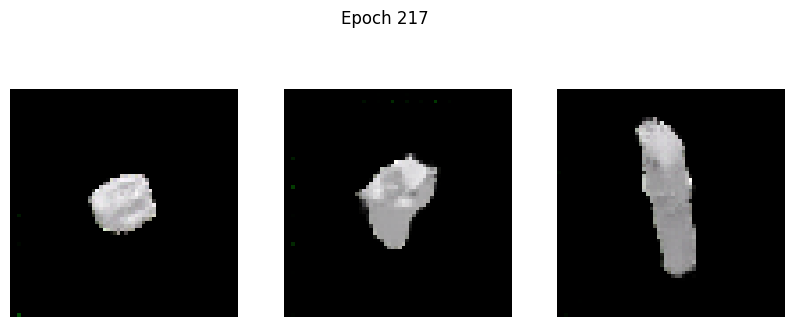

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0999 - g_loss: 3.7829
Epoch 218/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.1446 - g_loss: 3.6867

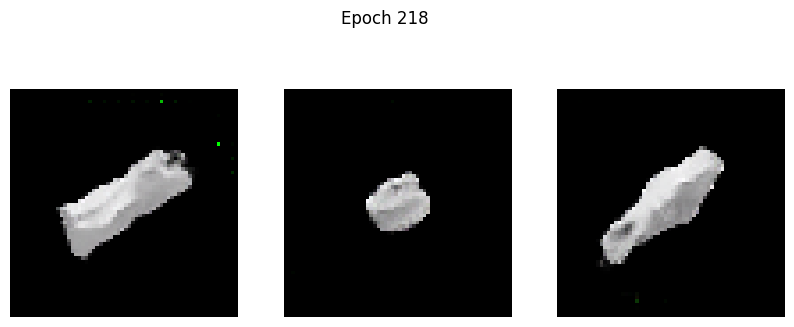

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - d_loss: 0.1442 - g_loss: 3.6870
Epoch 219/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - d_loss: 0.2180 - g_loss: 3.9396

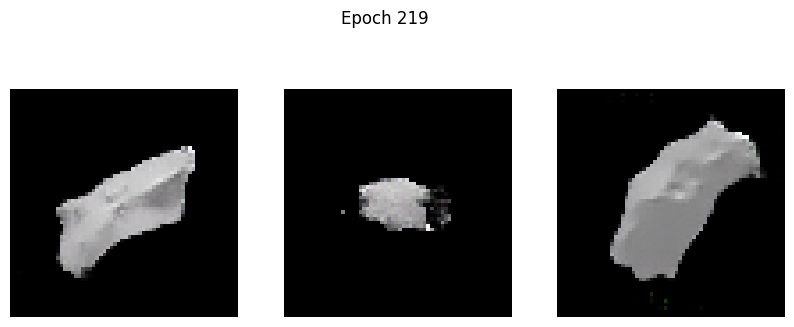

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - d_loss: 0.2182 - g_loss: 3.9394
Epoch 220/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - d_loss: 0.1137 - g_loss: 3.7416

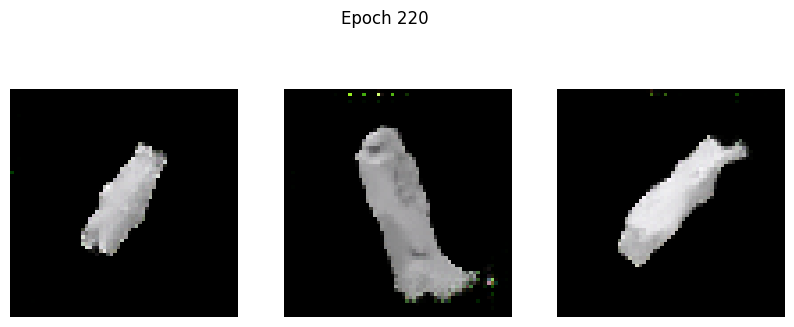

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - d_loss: 0.1142 - g_loss: 3.7418
Epoch 221/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.1214 - g_loss: 3.6108

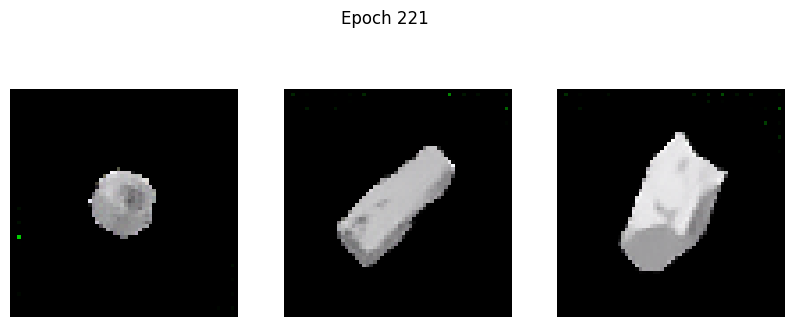

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.1213 - g_loss: 3.6110
Epoch 222/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0985 - g_loss: 3.7599

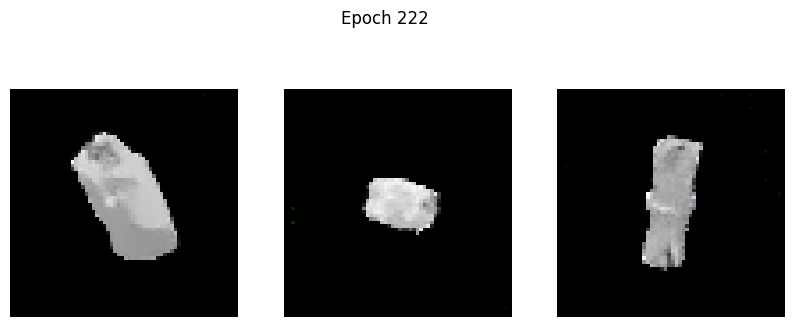

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0984 - g_loss: 3.7589
Epoch 223/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.1857 - g_loss: 3.8489

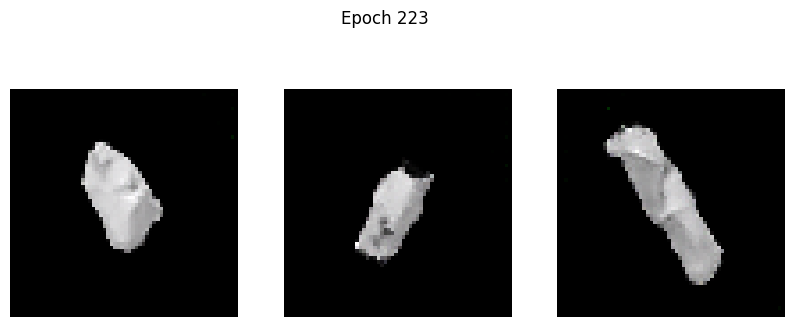

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.1859 - g_loss: 3.8491
Epoch 224/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0820 - g_loss: 3.5967

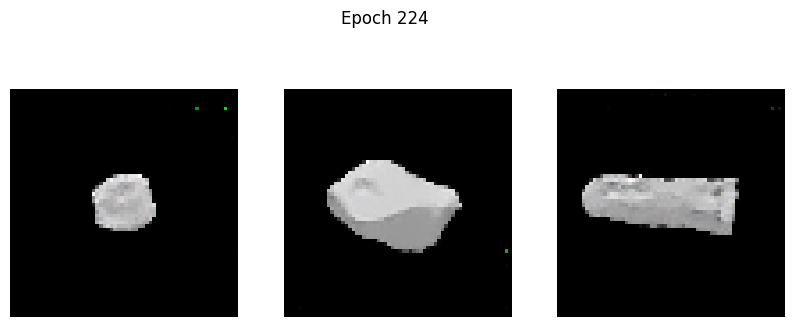

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0820 - g_loss: 3.5970
Epoch 225/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1170 - g_loss: 3.7952

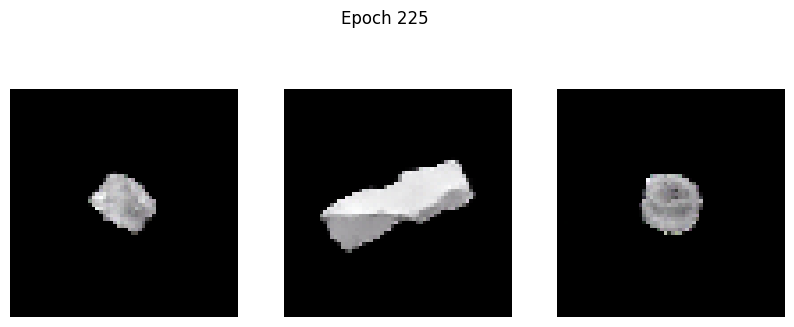

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1175 - g_loss: 3.7955
Epoch 226/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.1006 - g_loss: 3.7117

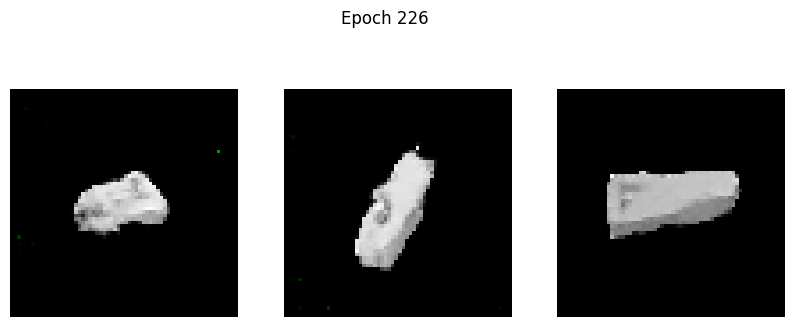

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1007 - g_loss: 3.7117
Epoch 227/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0793 - g_loss: 3.7509

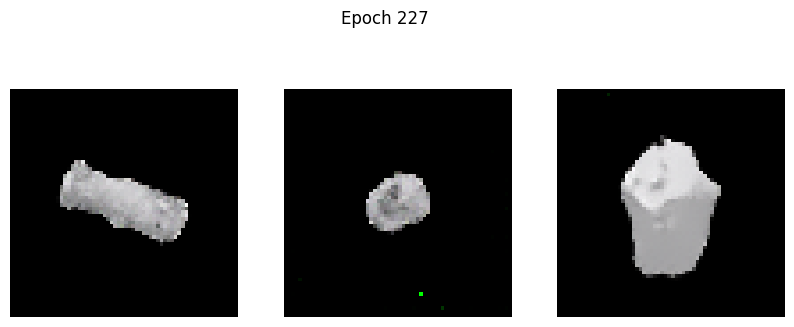

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0793 - g_loss: 3.7506
Epoch 228/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1007 - g_loss: 3.7859

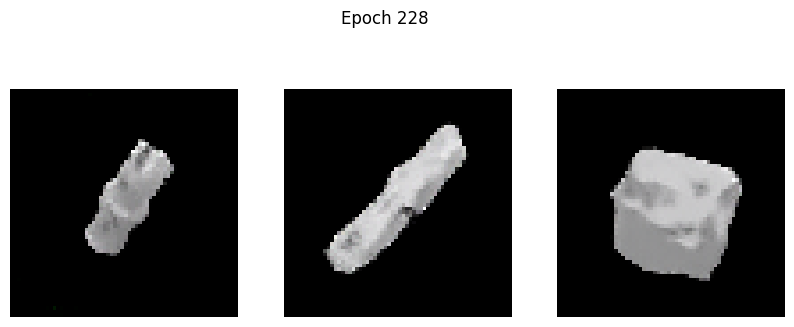

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1007 - g_loss: 3.7856
Epoch 229/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0940 - g_loss: 3.8135

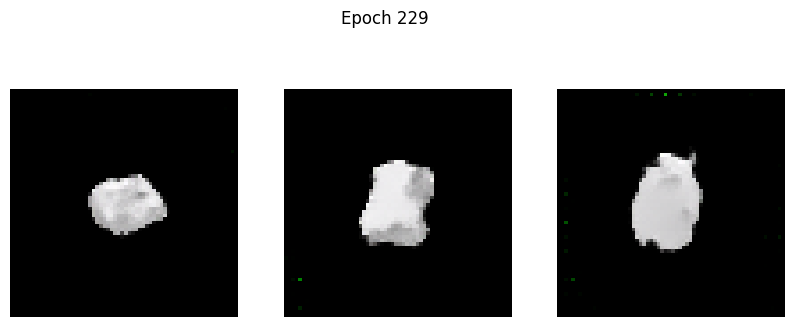

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0941 - g_loss: 3.8138
Epoch 230/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1057 - g_loss: 3.8873

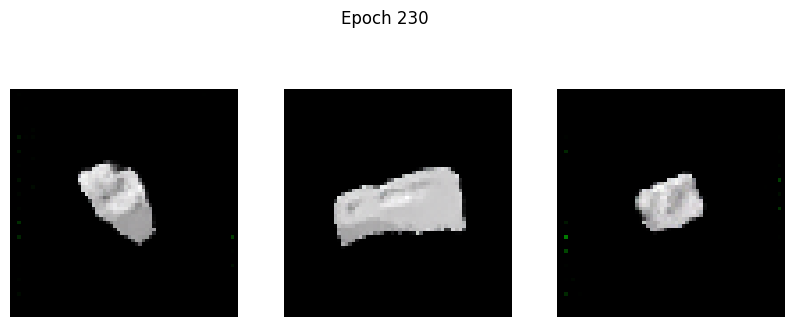

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1058 - g_loss: 3.8869
Epoch 231/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0863 - g_loss: 3.8742

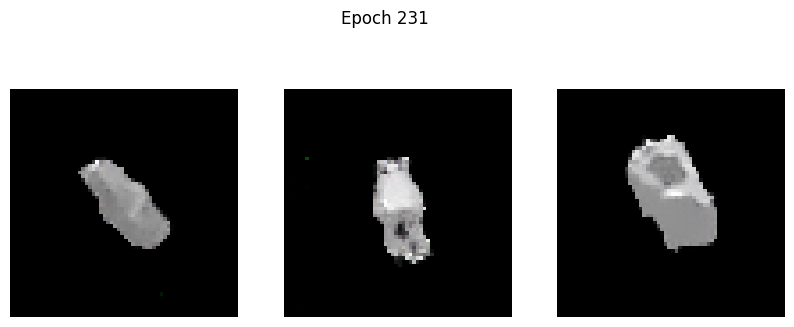

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0865 - g_loss: 3.8744
Epoch 232/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.3395 - g_loss: 4.4761

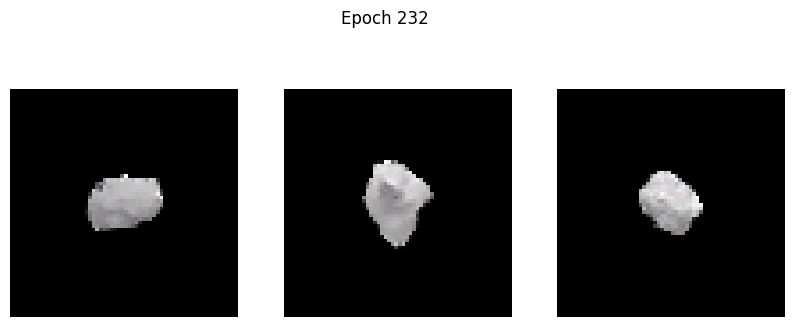

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.3399 - g_loss: 4.4756
Epoch 233/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0912 - g_loss: 3.6745

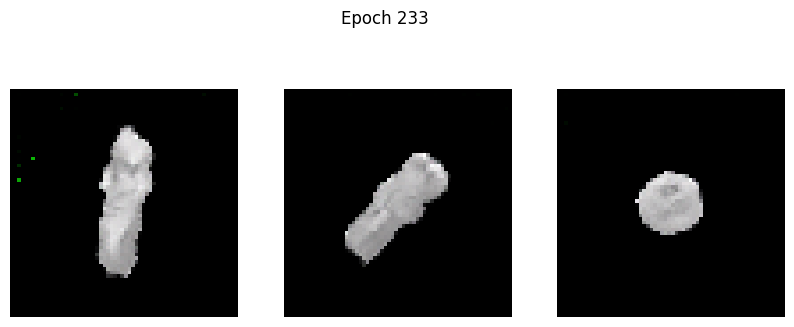

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0912 - g_loss: 3.6749
Epoch 234/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0720 - g_loss: 3.5596

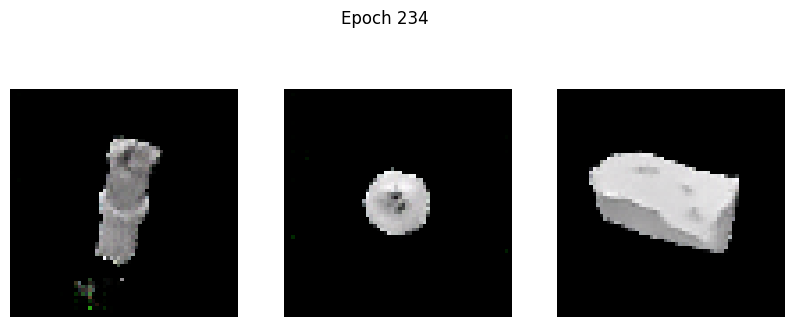

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0720 - g_loss: 3.5601
Epoch 235/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0978 - g_loss: 3.7476

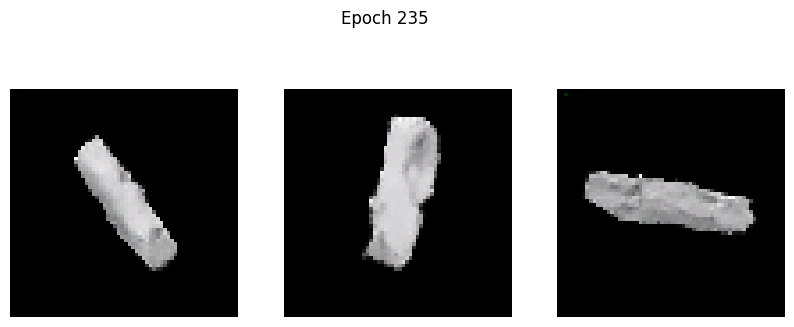

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0977 - g_loss: 3.7472
Epoch 236/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0788 - g_loss: 3.7021

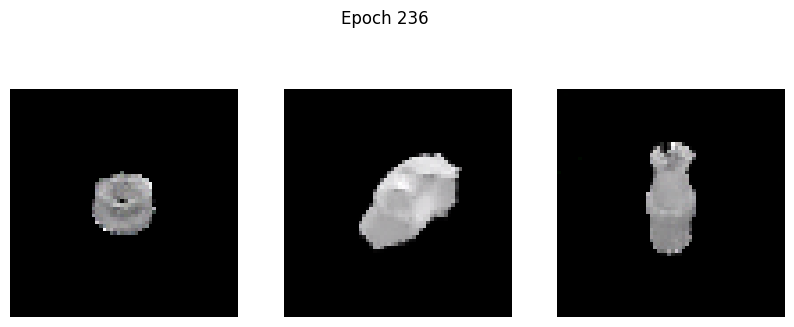

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0789 - g_loss: 3.7023
Epoch 237/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1038 - g_loss: 3.9561

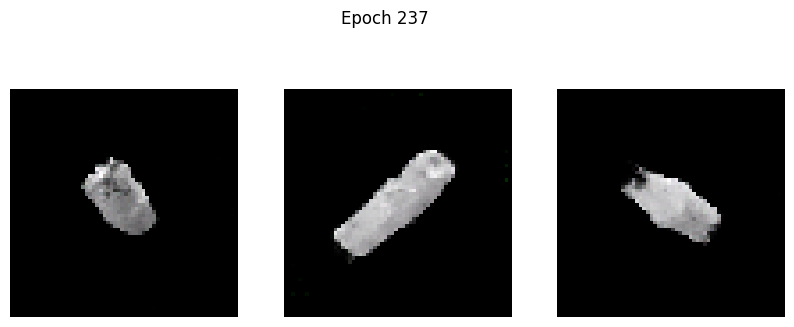

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1040 - g_loss: 3.9559
Epoch 238/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1529 - g_loss: 4.0426

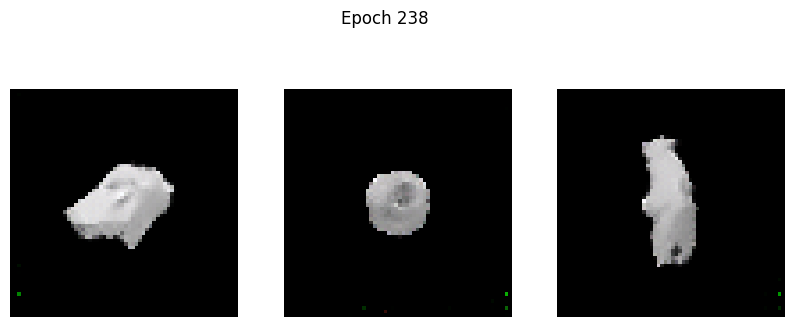

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1534 - g_loss: 4.0424
Epoch 239/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0859 - g_loss: 3.7314

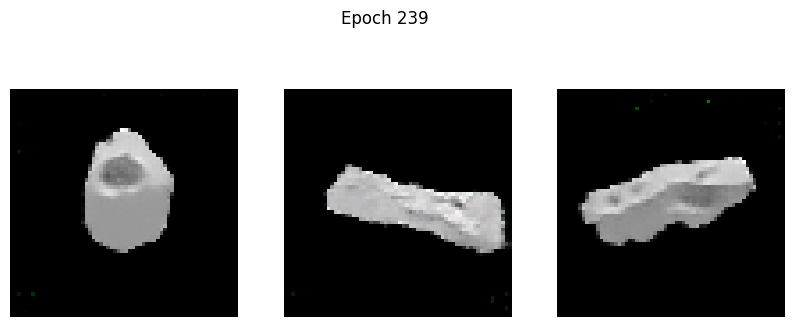

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0858 - g_loss: 3.7314
Epoch 240/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0822 - g_loss: 3.8170

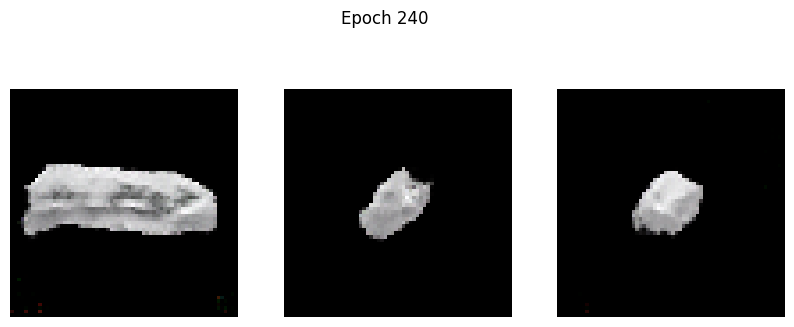

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0826 - g_loss: 3.8175
Epoch 241/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0981 - g_loss: 3.9122

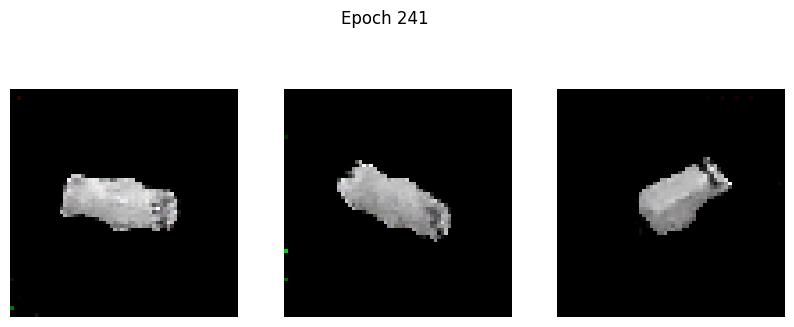

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0981 - g_loss: 3.9118
Epoch 242/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1011 - g_loss: 3.8873

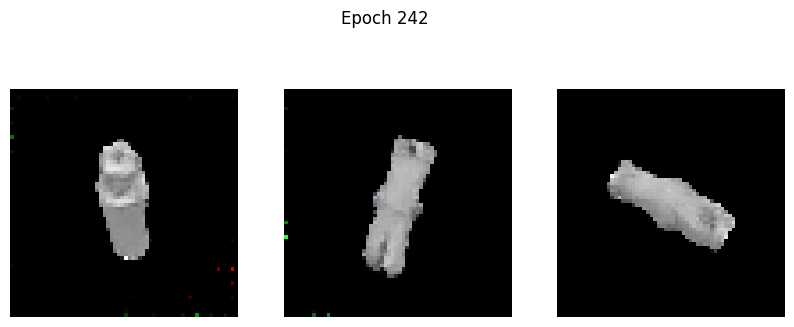

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1011 - g_loss: 3.8874
Epoch 243/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1512 - g_loss: 4.0262

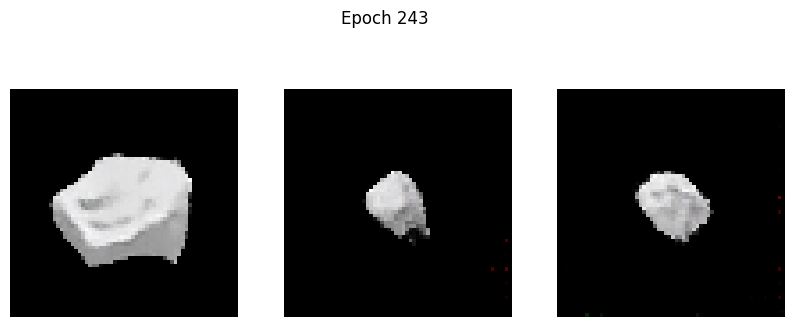

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1514 - g_loss: 4.0266
Epoch 244/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0657 - g_loss: 3.8152

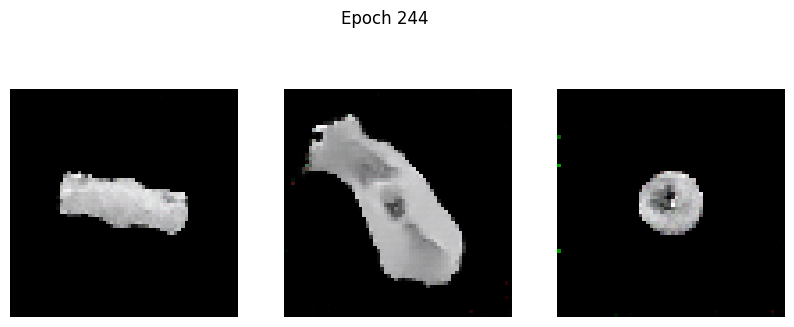

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0659 - g_loss: 3.8150
Epoch 245/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2082 - g_loss: 4.1180

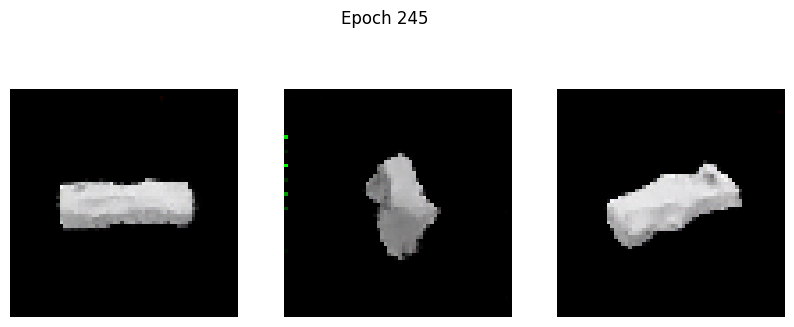

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2081 - g_loss: 4.1169
Epoch 246/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0962 - g_loss: 3.8400

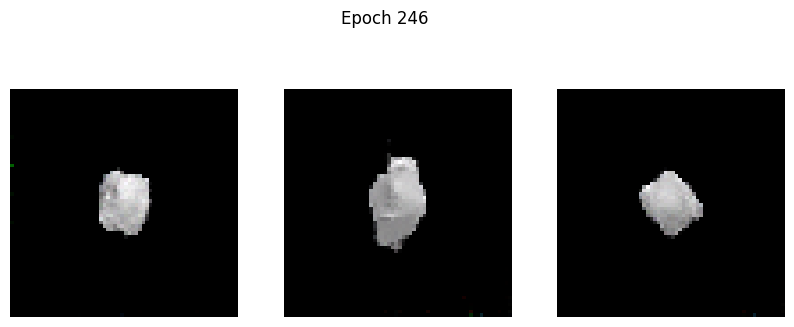

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0962 - g_loss: 3.8402
Epoch 247/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0621 - g_loss: 3.8466

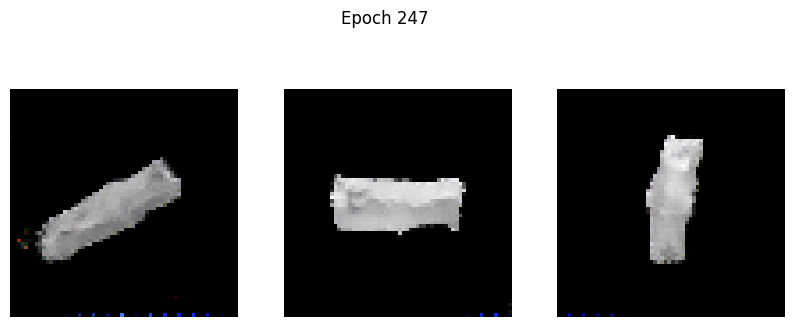

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0625 - g_loss: 3.8475
Epoch 248/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1169 - g_loss: 4.0771

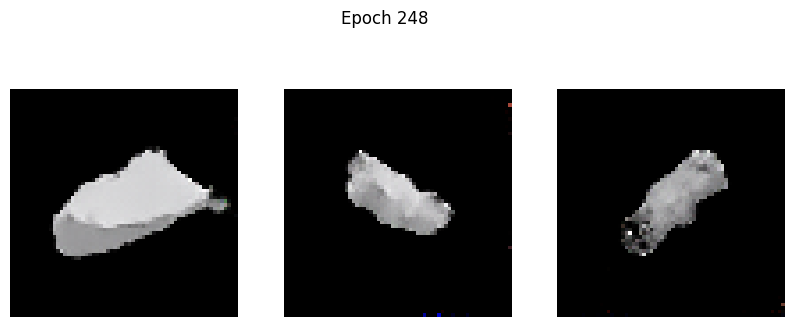

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1167 - g_loss: 4.0763
Epoch 249/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0867 - g_loss: 4.0130

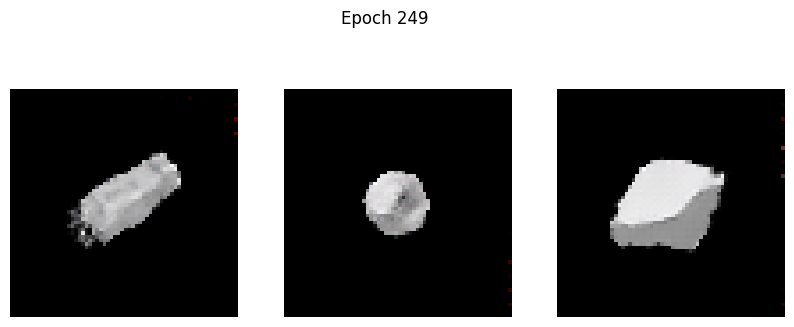

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0868 - g_loss: 4.0129
Epoch 250/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0866 - g_loss: 3.9821

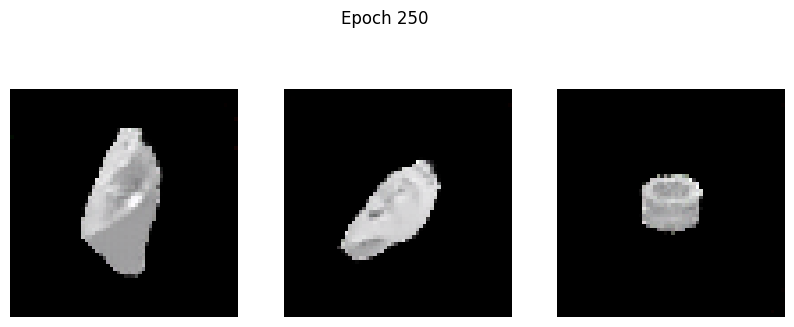

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0868 - g_loss: 3.9822
Epoch 251/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1257 - g_loss: 4.1229

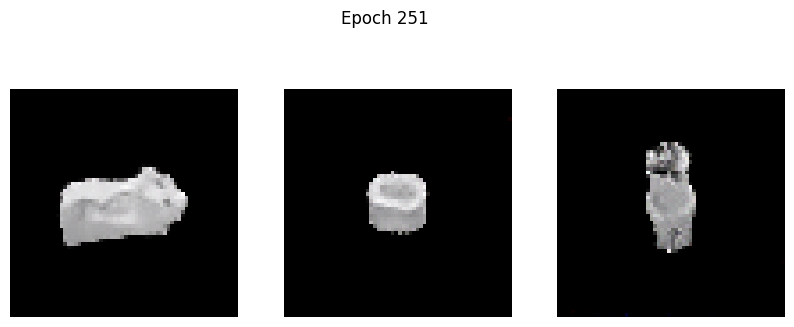

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1255 - g_loss: 4.1217
Epoch 252/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1641 - g_loss: 4.0720

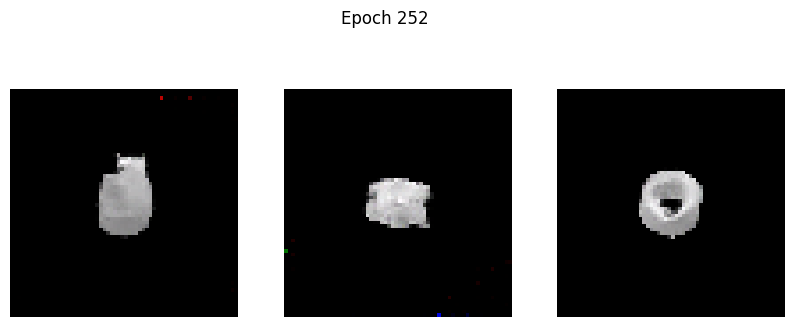

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1638 - g_loss: 4.0717
Epoch 253/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0740 - g_loss: 3.9096

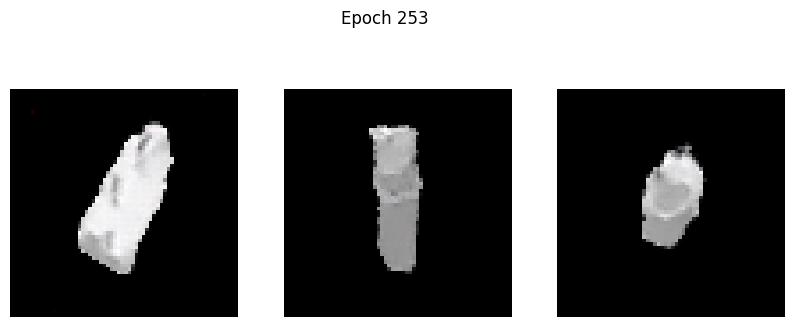

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0742 - g_loss: 3.9099
Epoch 254/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1029 - g_loss: 4.1185

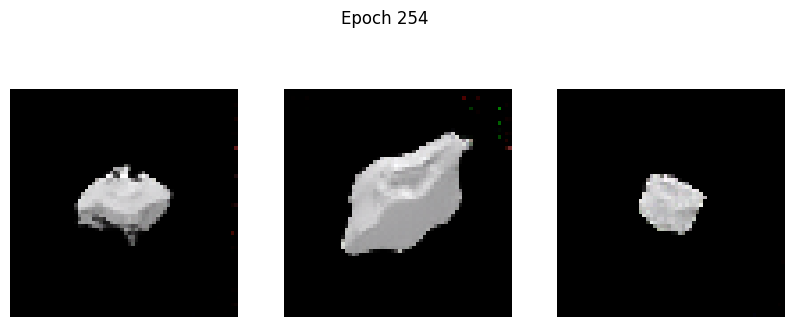

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1027 - g_loss: 4.1169
Epoch 255/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1673 - g_loss: 4.1145

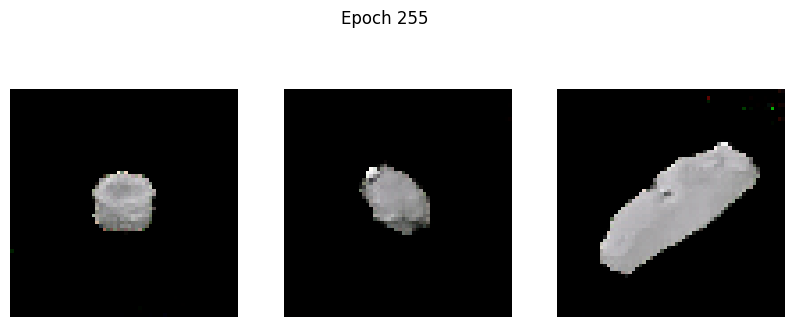

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1695 - g_loss: 4.1171
Epoch 256/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1690 - g_loss: 3.8989

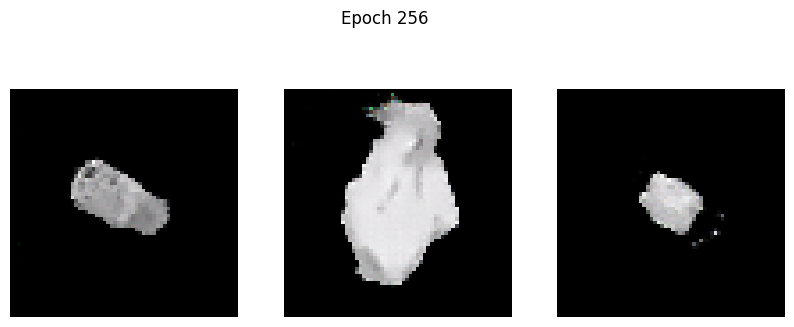

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1687 - g_loss: 3.8987
Epoch 257/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0682 - g_loss: 3.7154

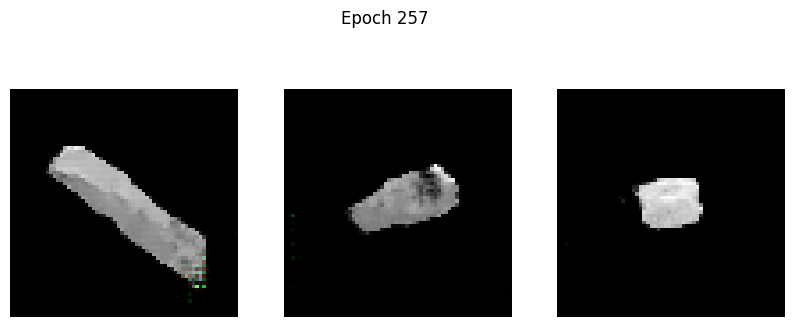

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0682 - g_loss: 3.7160
Epoch 258/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0768 - g_loss: 3.9093

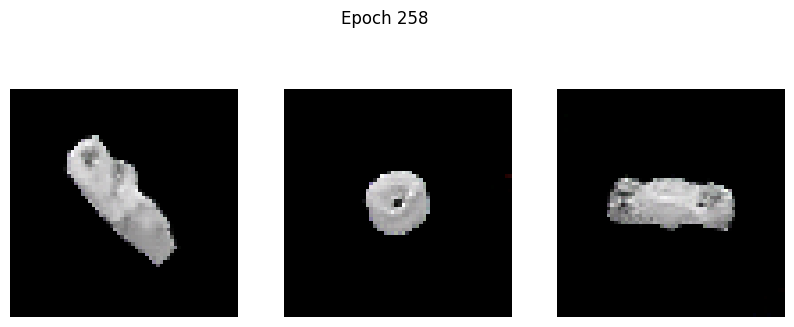

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0770 - g_loss: 3.9093
Epoch 259/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1221 - g_loss: 3.8488

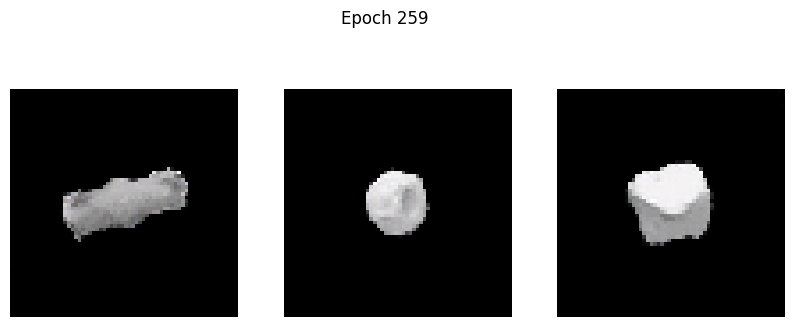

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1223 - g_loss: 3.8496
Epoch 260/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0625 - g_loss: 3.7289

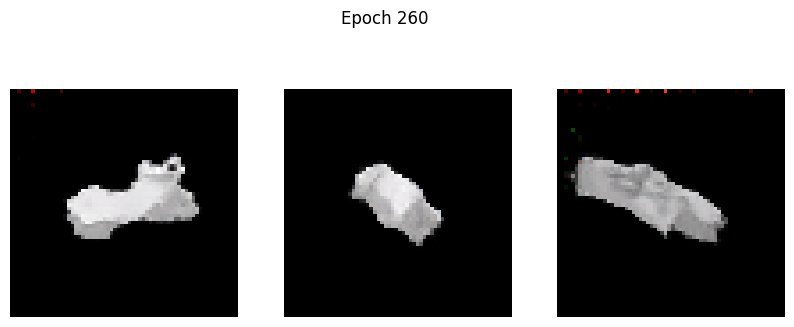

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0625 - g_loss: 3.7300
Epoch 261/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0706 - g_loss: 3.8991

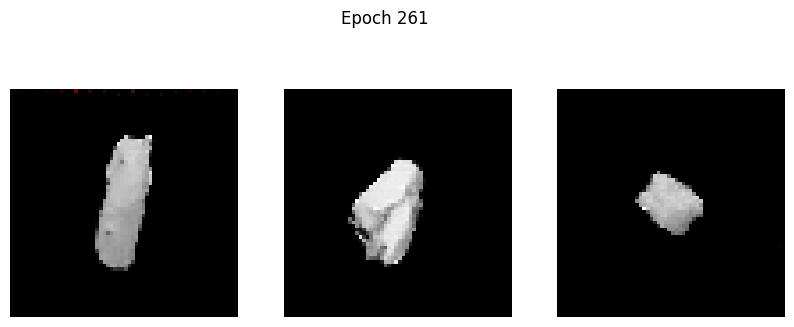

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0709 - g_loss: 3.8997
Epoch 262/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0897 - g_loss: 4.0034

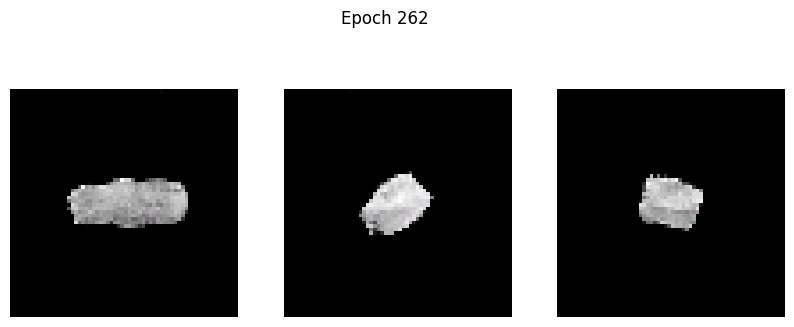

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - d_loss: 0.0900 - g_loss: 4.0032
Epoch 263/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1515 - g_loss: 4.4078

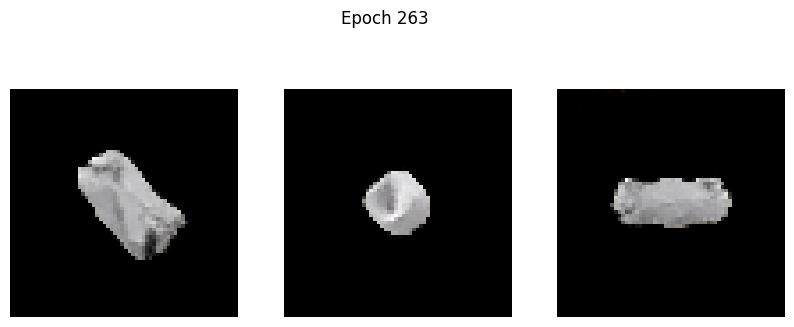

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1510 - g_loss: 4.4039
Epoch 264/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0686 - g_loss: 3.8912

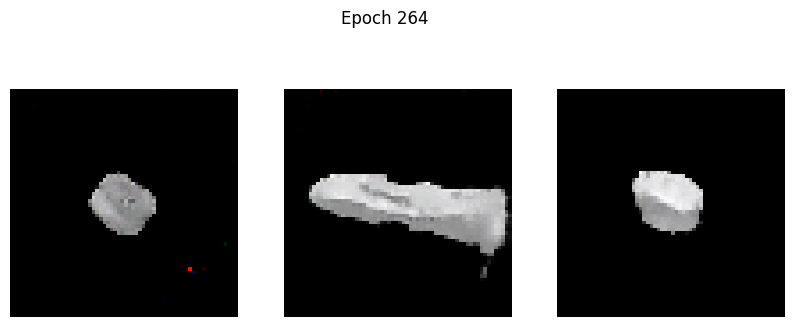

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0686 - g_loss: 3.8914
Epoch 265/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0749 - g_loss: 4.1263

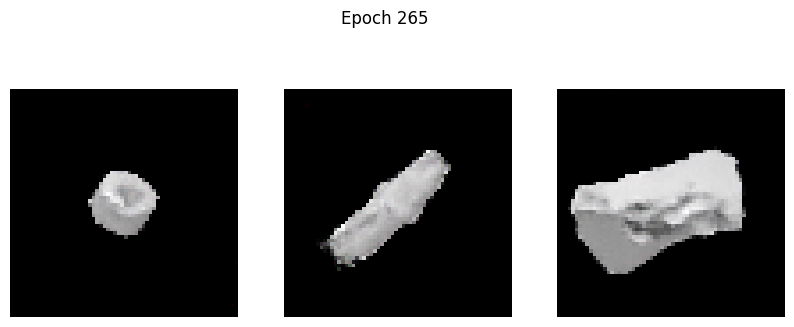

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0751 - g_loss: 4.1263
Epoch 266/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0585 - g_loss: 3.9801

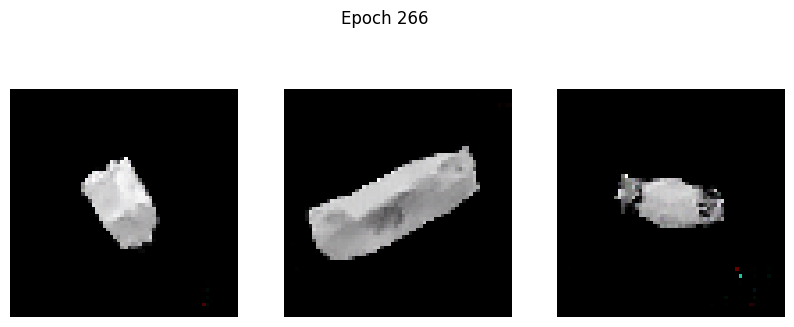

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0586 - g_loss: 3.9798
Epoch 267/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1220 - g_loss: 4.1452

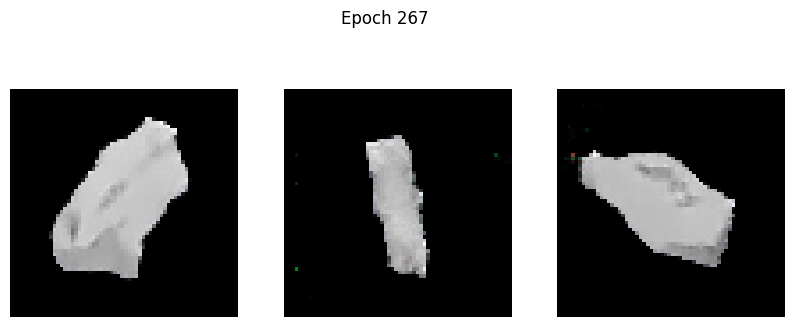

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1232 - g_loss: 4.1480
Epoch 268/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0959 - g_loss: 3.9548

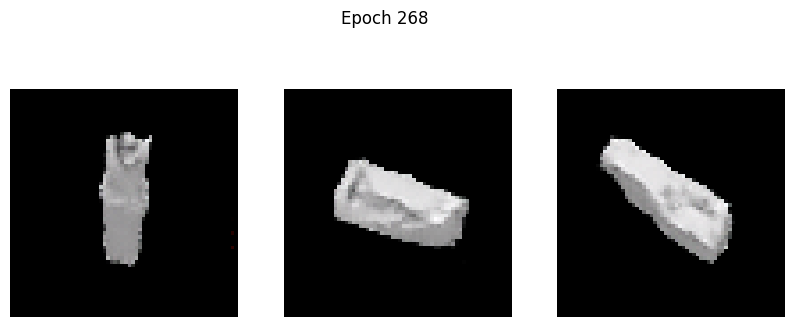

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0958 - g_loss: 3.9552
Epoch 269/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0548 - g_loss: 3.8340

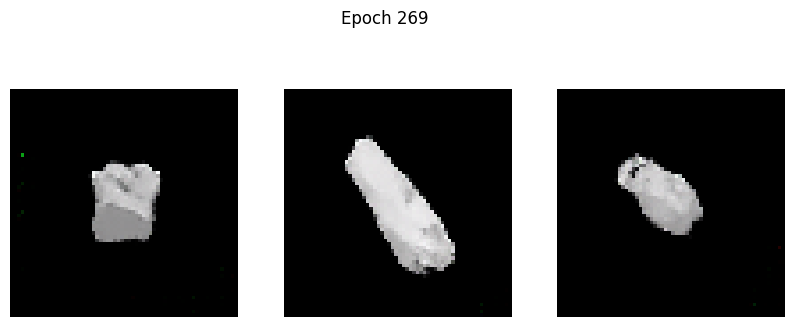

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0548 - g_loss: 3.8351
Epoch 270/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0712 - g_loss: 4.1138

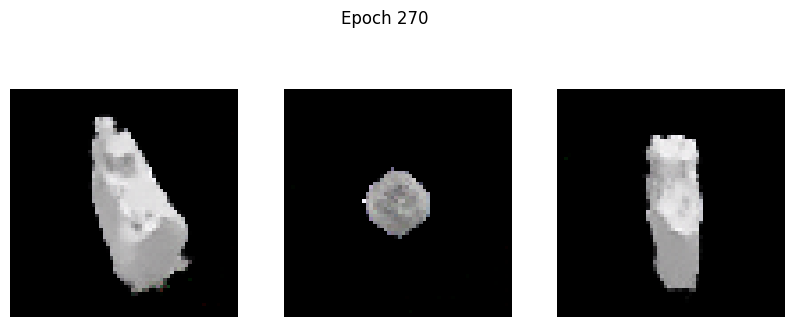

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0713 - g_loss: 4.1134
Epoch 271/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0714 - g_loss: 4.0870

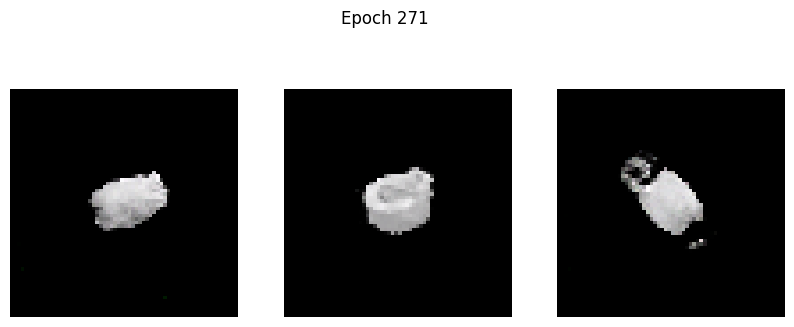

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0715 - g_loss: 4.0880
Epoch 272/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1199 - g_loss: 4.2763

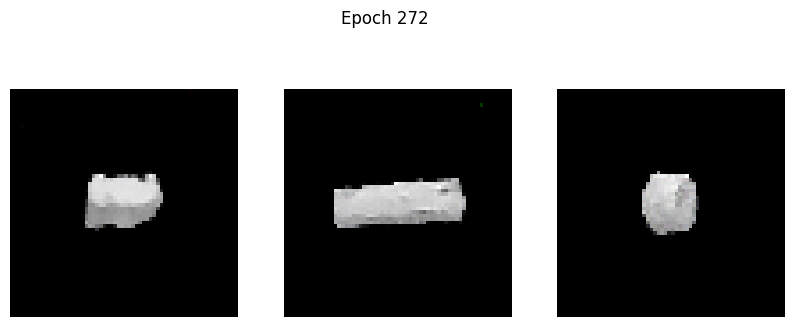

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1197 - g_loss: 4.2751
Epoch 273/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0521 - g_loss: 3.9737

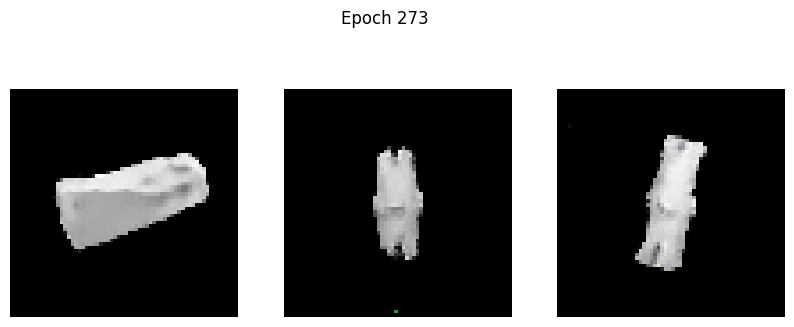

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0522 - g_loss: 3.9739
Epoch 274/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1334 - g_loss: 4.3954

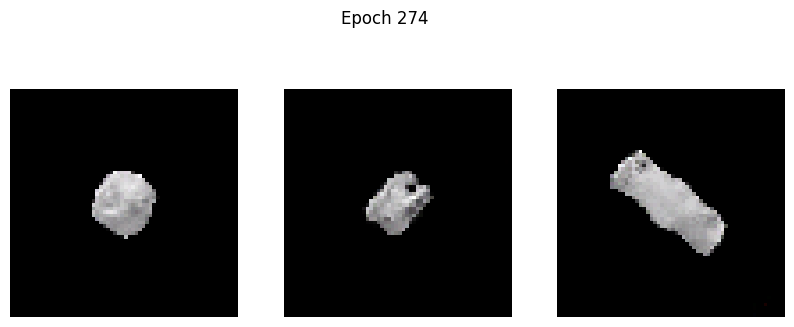

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1337 - g_loss: 4.3952
Epoch 275/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0754 - g_loss: 4.1525

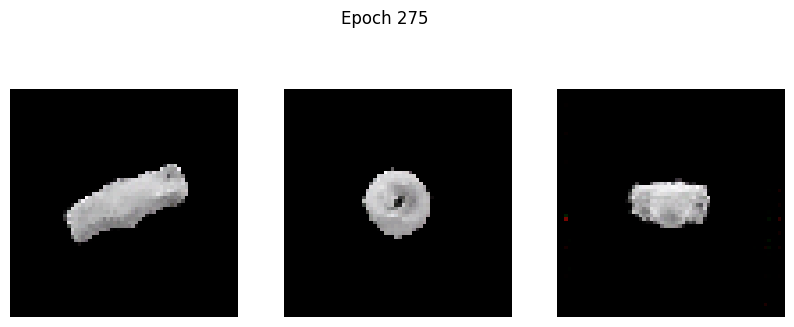

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0755 - g_loss: 4.1528
Epoch 276/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1576 - g_loss: 4.3395

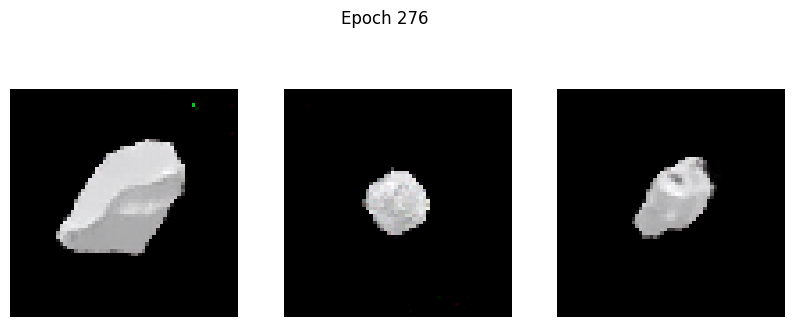

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1572 - g_loss: 4.3384
Epoch 277/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0581 - g_loss: 4.0441

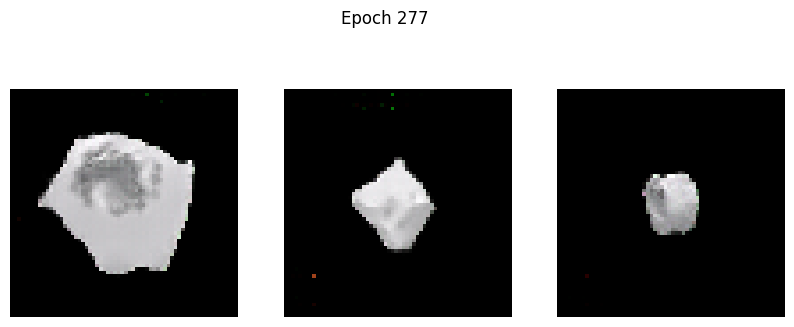

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0586 - g_loss: 4.0445
Epoch 278/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1036 - g_loss: 4.2755

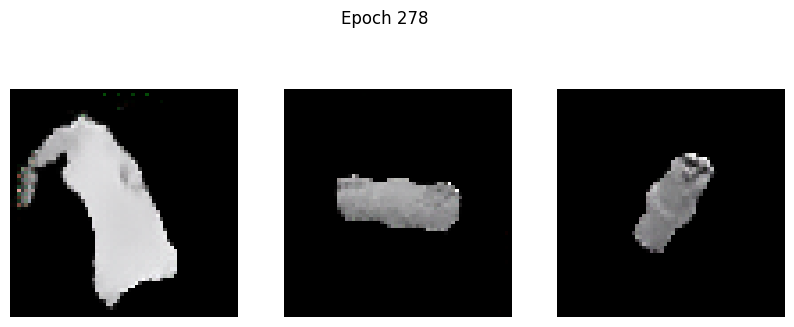

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1033 - g_loss: 4.2734
Epoch 279/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1606 - g_loss: 4.2822

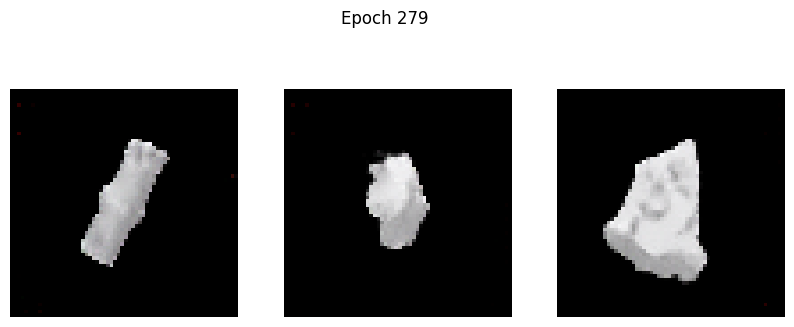

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1603 - g_loss: 4.2817
Epoch 280/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0804 - g_loss: 4.0679

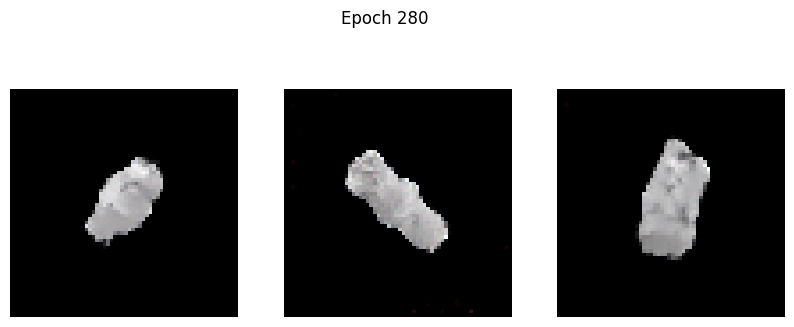

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0803 - g_loss: 4.0682
Epoch 281/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0631 - g_loss: 4.1417

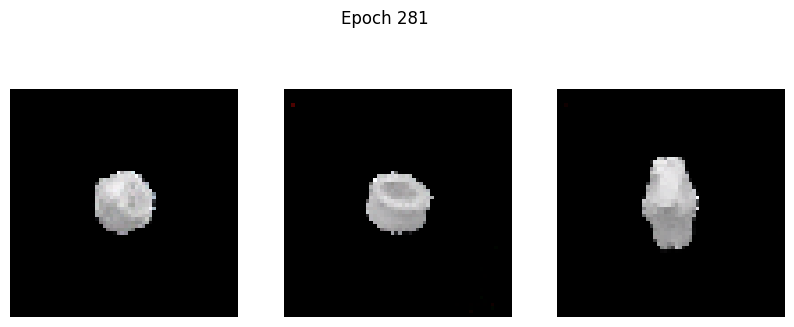

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0631 - g_loss: 4.1409
Epoch 282/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.2185 - g_loss: 4.6417

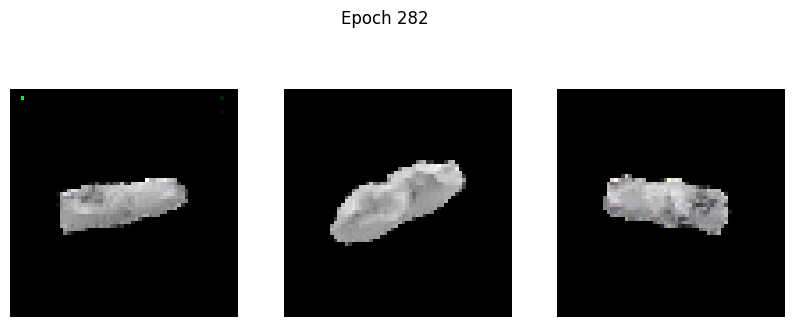

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2180 - g_loss: 4.6406
Epoch 283/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0704 - g_loss: 4.1103

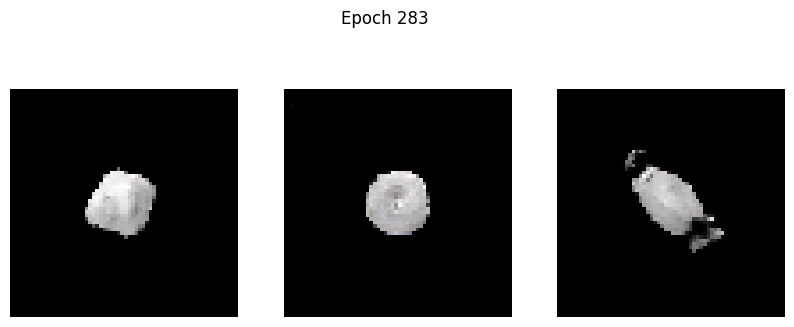

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0706 - g_loss: 4.1112
Epoch 284/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1046 - g_loss: 4.2143

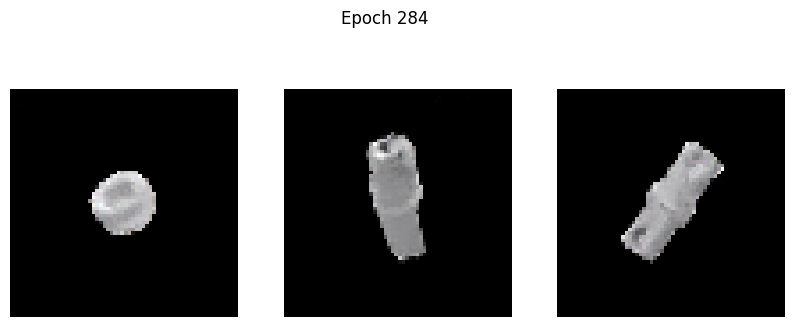

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1044 - g_loss: 4.2139
Epoch 285/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0503 - g_loss: 4.1762

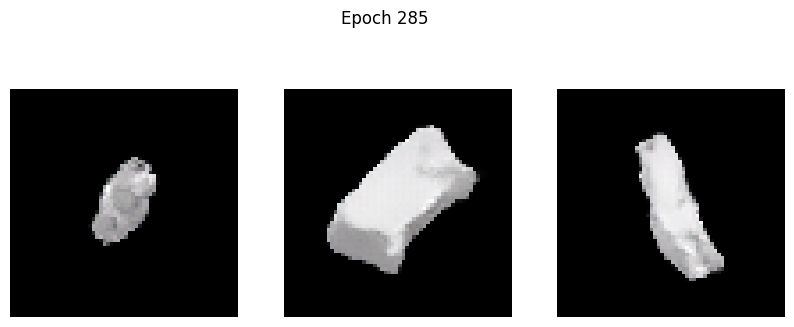

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0506 - g_loss: 4.1763
Epoch 286/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1244 - g_loss: 4.1107

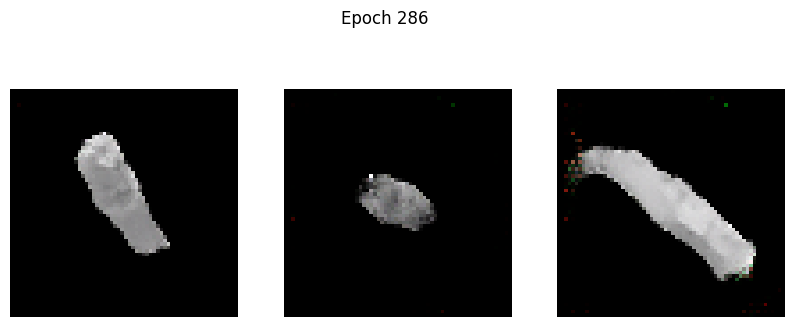

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1240 - g_loss: 4.1110
Epoch 287/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0794 - g_loss: 4.2150

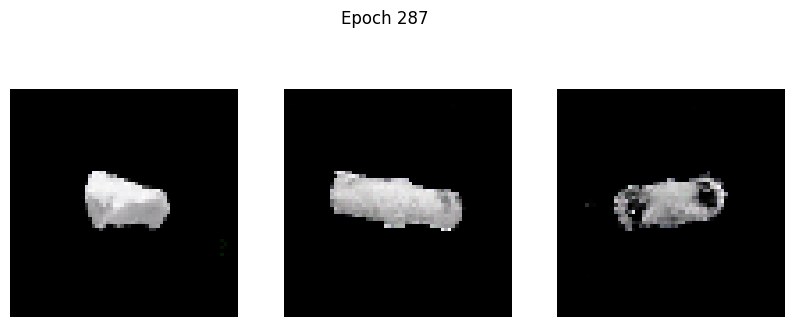

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0793 - g_loss: 4.2139
Epoch 288/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0844 - g_loss: 4.3616

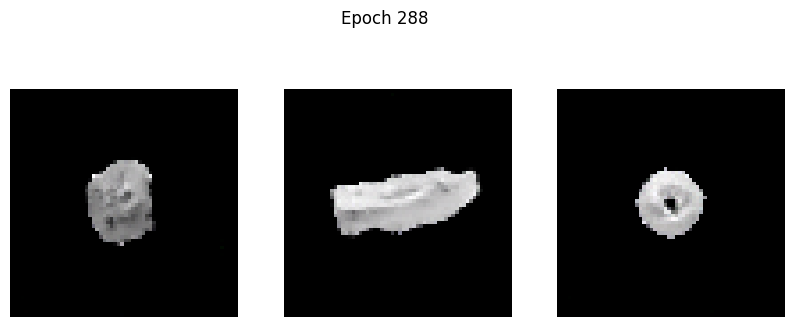

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0845 - g_loss: 4.3607
Epoch 289/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0606 - g_loss: 4.1355

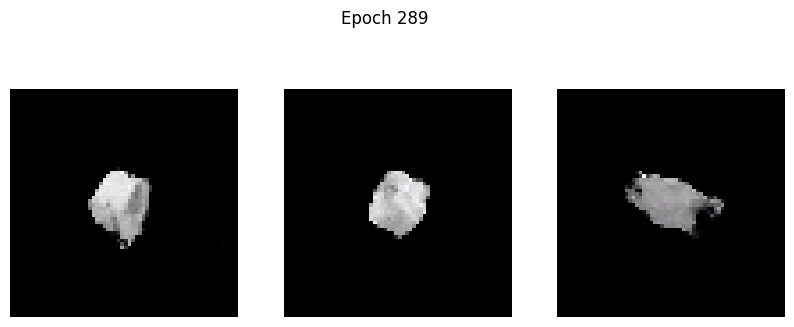

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0609 - g_loss: 4.1364
Epoch 290/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0678 - g_loss: 4.2002

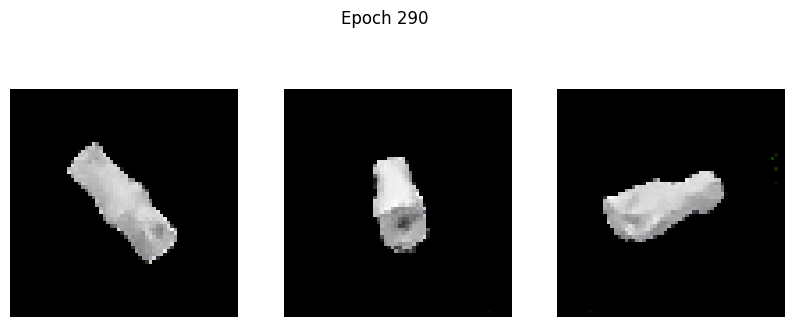

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0679 - g_loss: 4.2005
Epoch 291/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1595 - g_loss: 4.5764

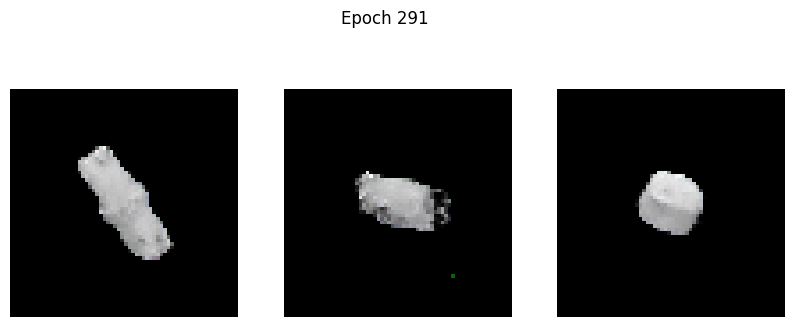

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1605 - g_loss: 4.5771
Epoch 292/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0797 - g_loss: 4.2027

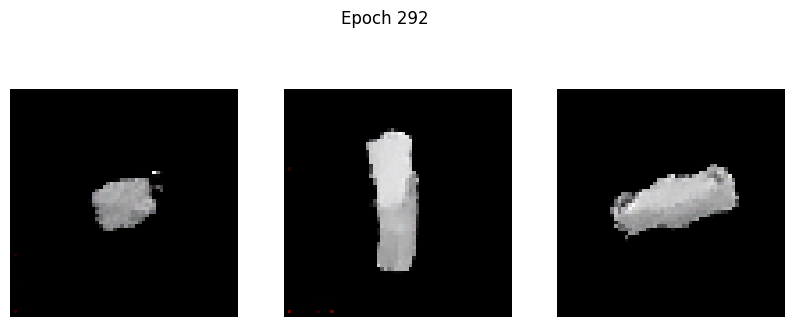

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0795 - g_loss: 4.2018
Epoch 293/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0418 - g_loss: 3.9962

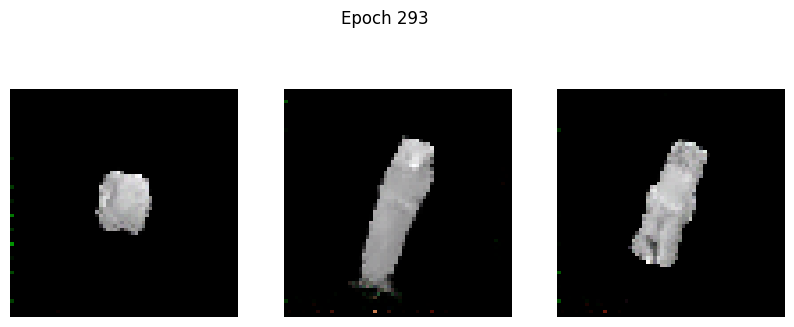

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0421 - g_loss: 3.9980
Epoch 294/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0892 - g_loss: 4.3208

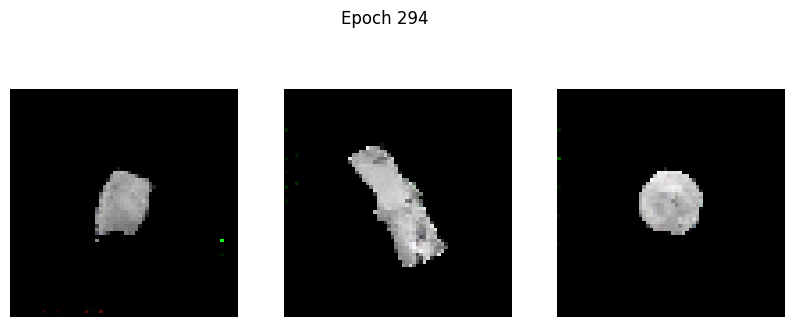

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0893 - g_loss: 4.3213
Epoch 295/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0799 - g_loss: 4.2670

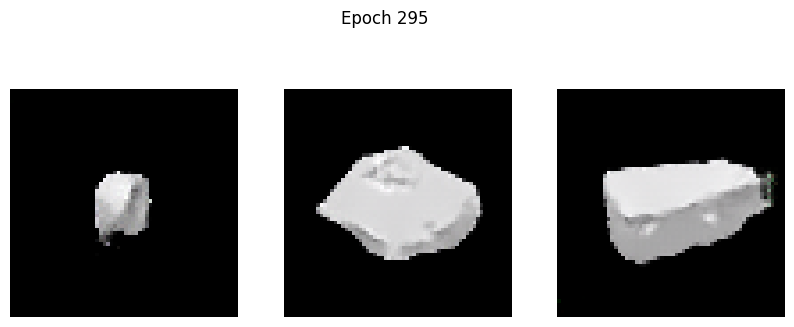

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0798 - g_loss: 4.2665
Epoch 296/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.2578 - g_loss: 4.6677

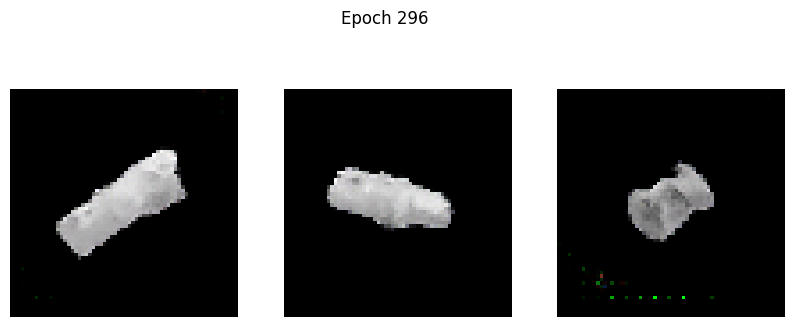

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.2585 - g_loss: 4.6693
Epoch 297/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0585 - g_loss: 3.9679

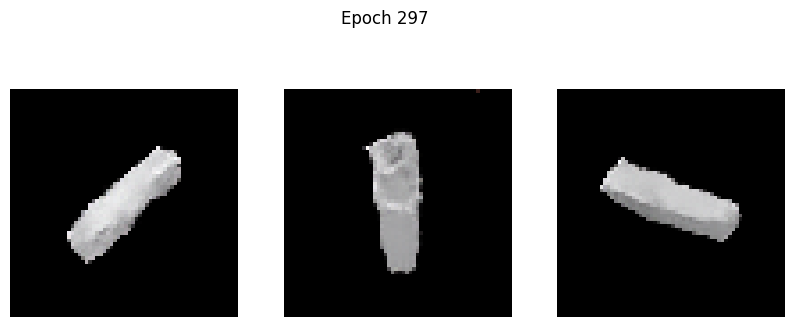

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0585 - g_loss: 3.9685
Epoch 298/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0473 - g_loss: 4.0369

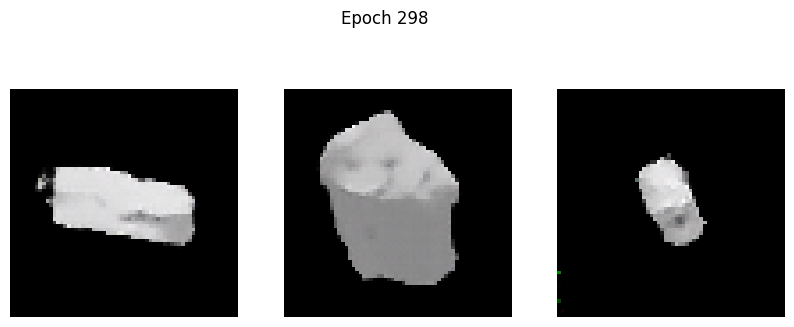

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0472 - g_loss: 4.0368
Epoch 299/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0439 - g_loss: 4.2408

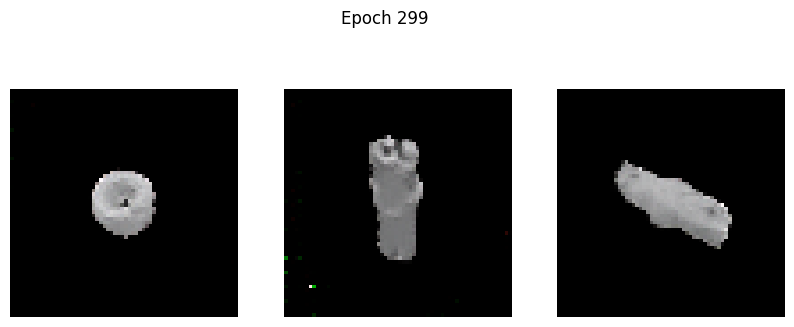

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0439 - g_loss: 4.2400
Epoch 300/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0504 - g_loss: 4.0770

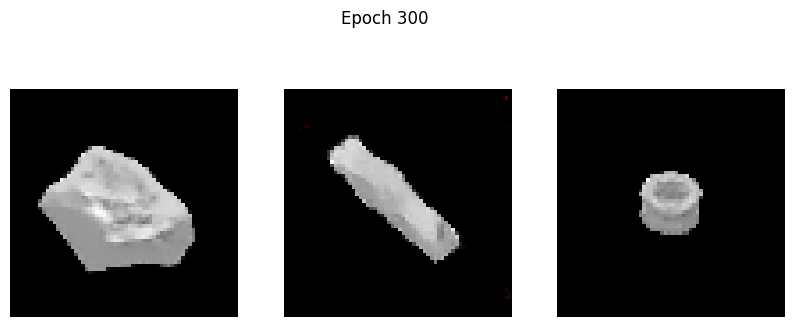

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0504 - g_loss: 4.0780
Epoch 301/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1516 - g_loss: 4.5224

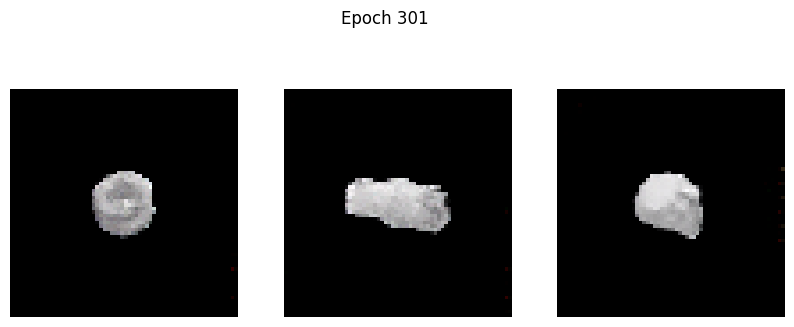

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1520 - g_loss: 4.5229
Epoch 302/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0775 - g_loss: 4.2957

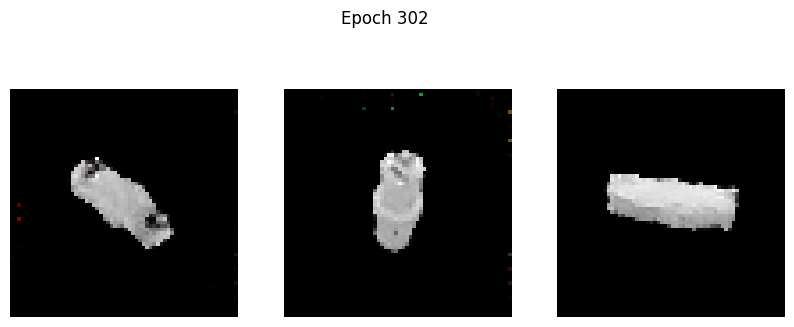

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0776 - g_loss: 4.2954
Epoch 303/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0645 - g_loss: 4.2538

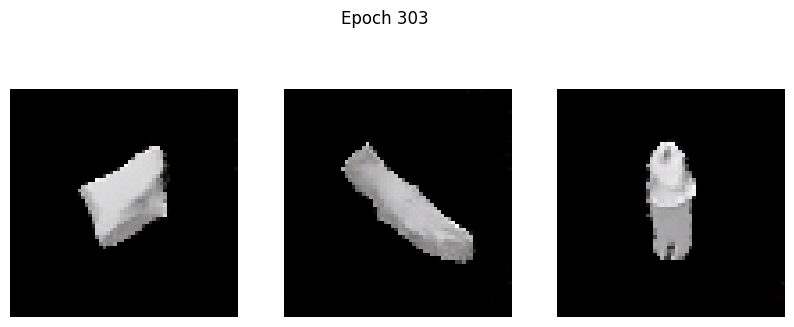

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0646 - g_loss: 4.2546
Epoch 304/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0429 - g_loss: 4.3072

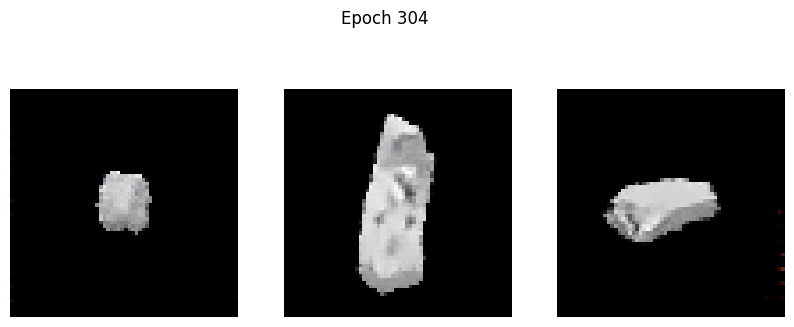

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0430 - g_loss: 4.3066
Epoch 305/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0654 - g_loss: 4.2855

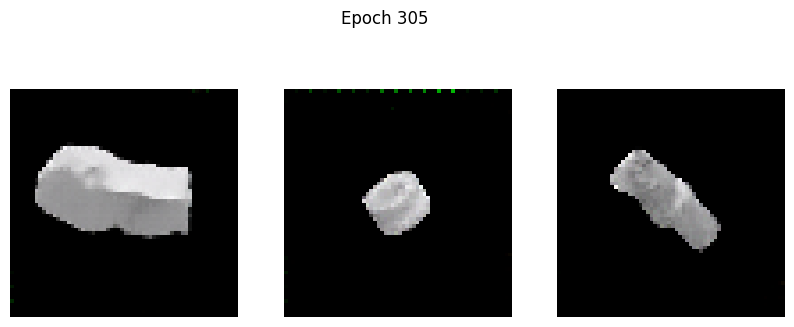

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0653 - g_loss: 4.2848
Epoch 306/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0475 - g_loss: 4.2621

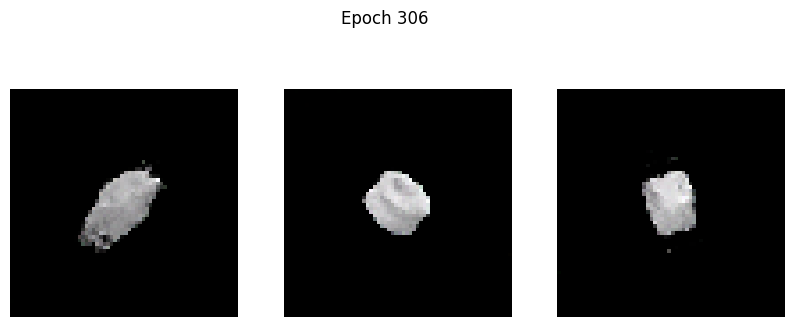

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0475 - g_loss: 4.2630
Epoch 307/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0945 - g_loss: 4.3966

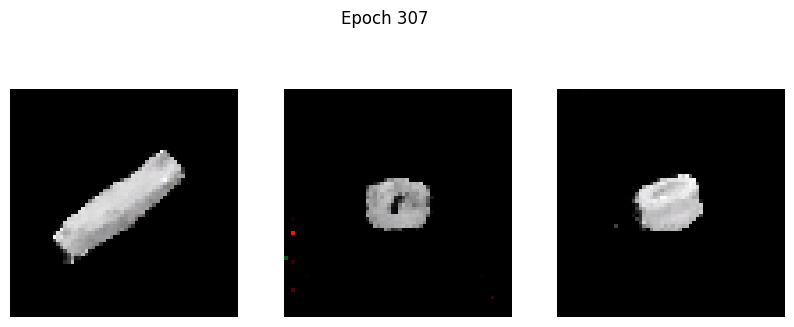

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0945 - g_loss: 4.3967
Epoch 308/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0802 - g_loss: 4.3422

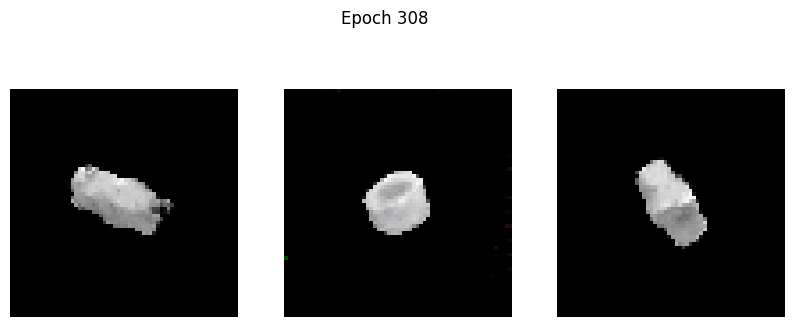

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0803 - g_loss: 4.3429
Epoch 309/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1194 - g_loss: 4.6347

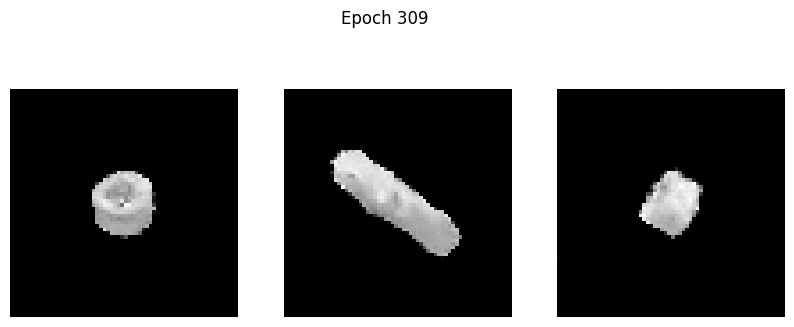

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1197 - g_loss: 4.6334
Epoch 310/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0562 - g_loss: 4.2648

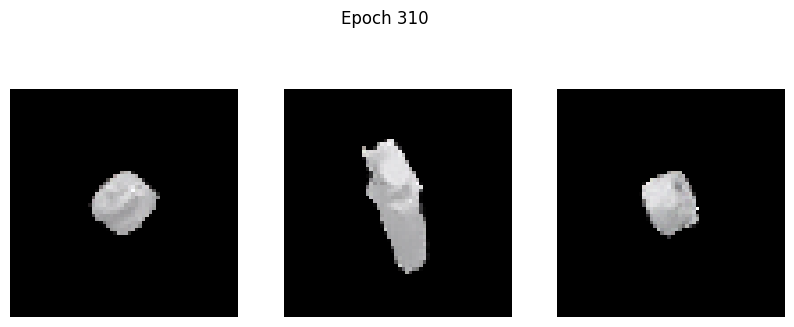

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0563 - g_loss: 4.2648
Epoch 311/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0403 - g_loss: 4.2958

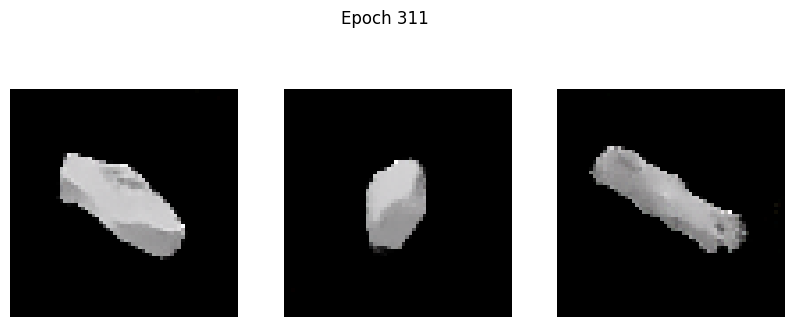

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0404 - g_loss: 4.2958
Epoch 312/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0992 - g_loss: 4.4695

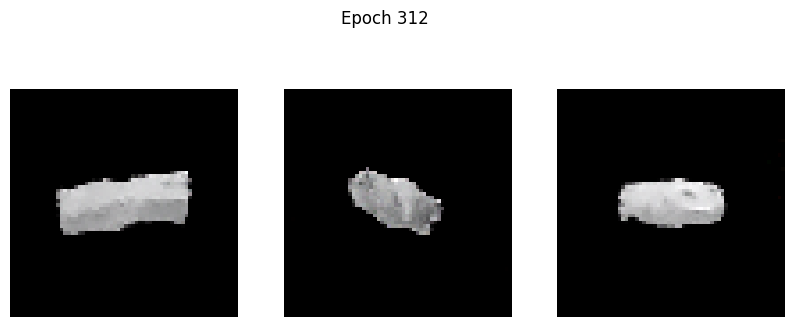

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0989 - g_loss: 4.4688
Epoch 313/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0650 - g_loss: 4.4348

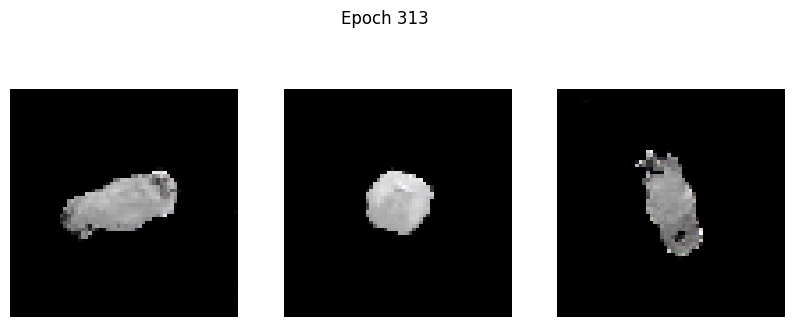

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0653 - g_loss: 4.4362
Epoch 314/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0699 - g_loss: 4.3380

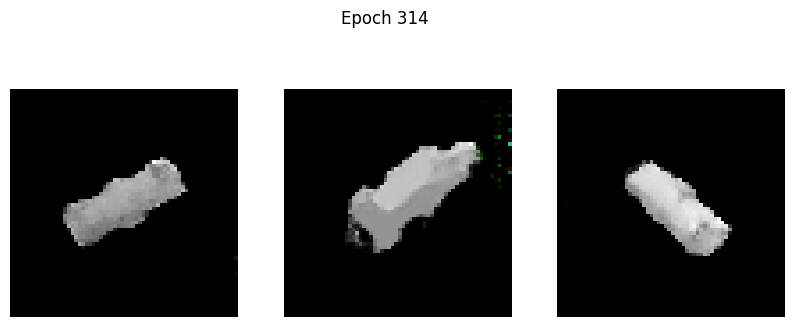

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0697 - g_loss: 4.3386
Epoch 315/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0967 - g_loss: 4.5514

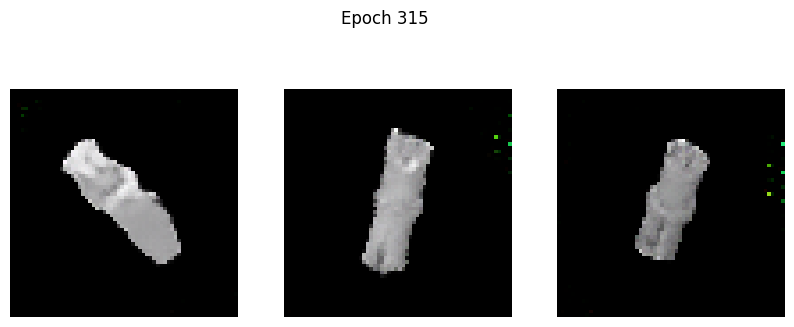

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0965 - g_loss: 4.5504
Epoch 316/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0801 - g_loss: 4.5289

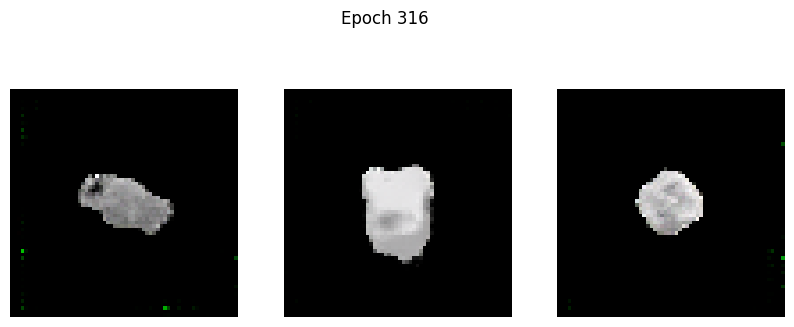

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0804 - g_loss: 4.5292
Epoch 317/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0729 - g_loss: 4.3703

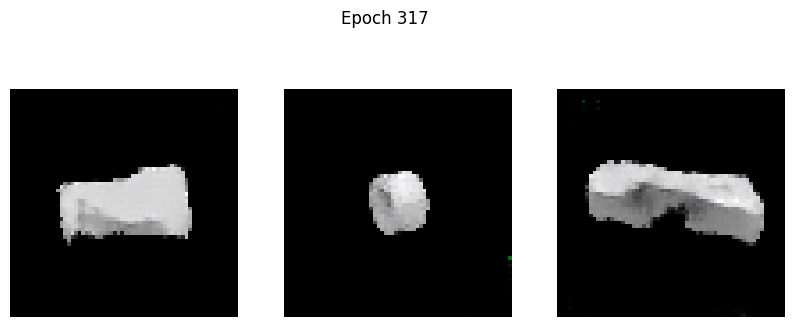

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0727 - g_loss: 4.3700
Epoch 318/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0634 - g_loss: 4.4872

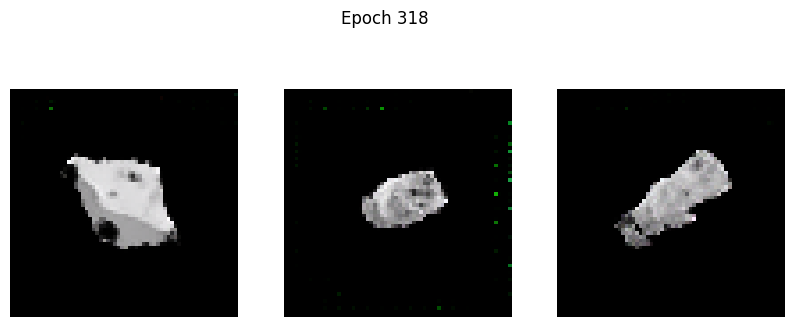

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0636 - g_loss: 4.4880
Epoch 319/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1153 - g_loss: 4.7148

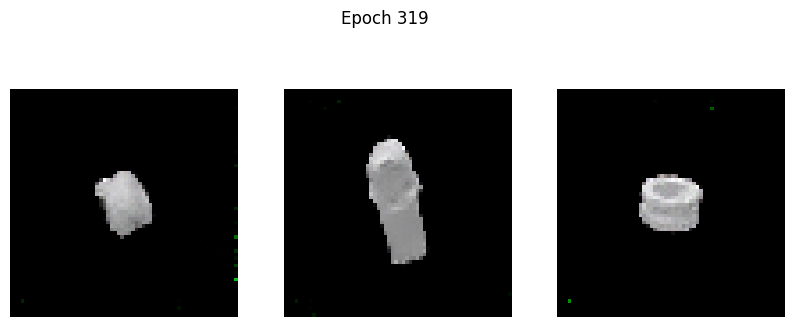

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1149 - g_loss: 4.7126
Epoch 320/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0589 - g_loss: 4.4841

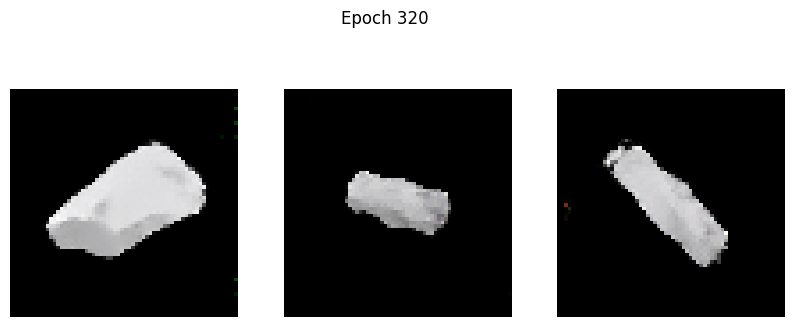

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0591 - g_loss: 4.4842
Epoch 321/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0561 - g_loss: 4.5970

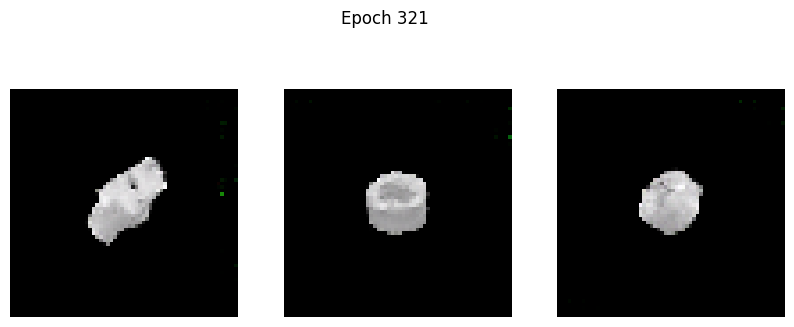

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0563 - g_loss: 4.5970
Epoch 322/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0343 - g_loss: 4.3948

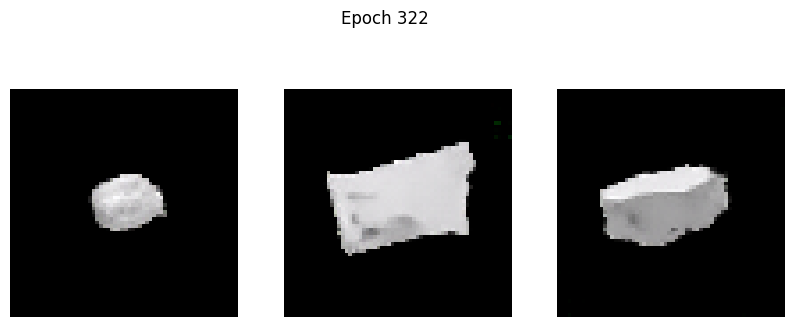

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0345 - g_loss: 4.3959
Epoch 323/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0677 - g_loss: 4.4820

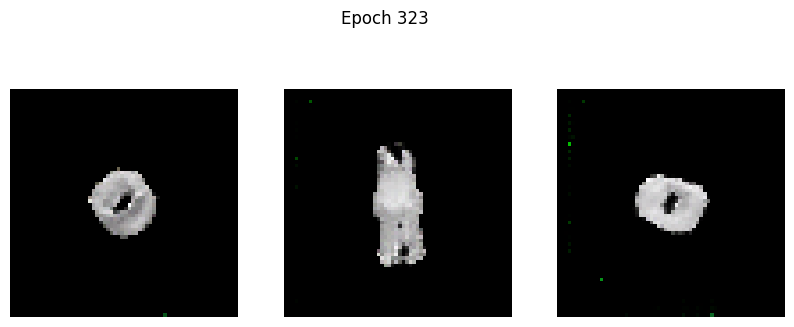

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0678 - g_loss: 4.4820
Epoch 324/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1193 - g_loss: 4.6203

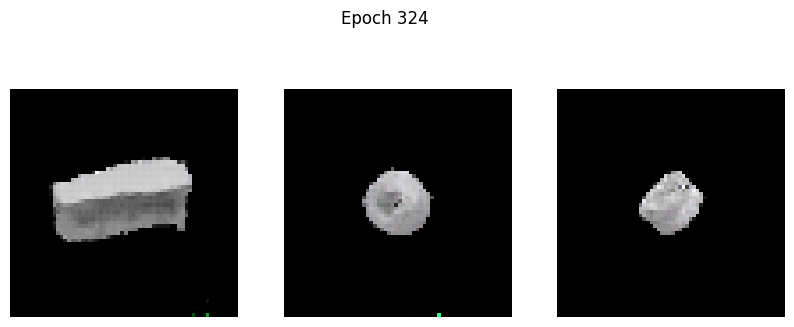

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.1192 - g_loss: 4.6208
Epoch 325/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0769 - g_loss: 4.4020

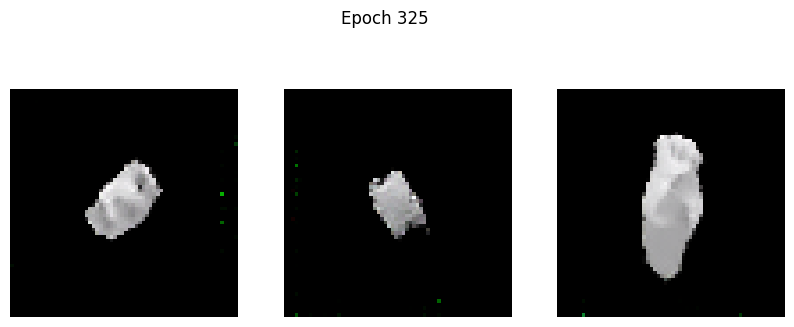

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0769 - g_loss: 4.4034
Epoch 326/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0480 - g_loss: 4.4897

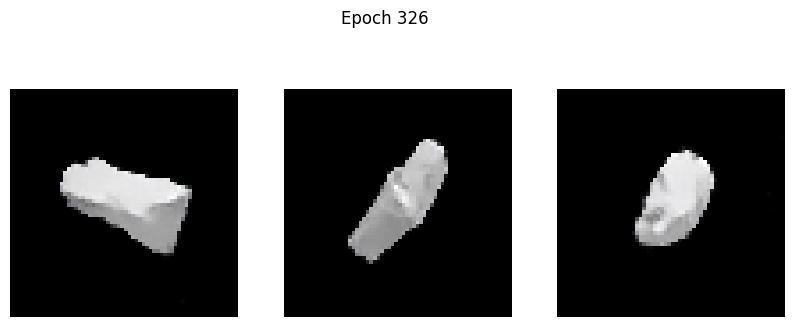

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0482 - g_loss: 4.4898
Epoch 327/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0419 - g_loss: 4.5356

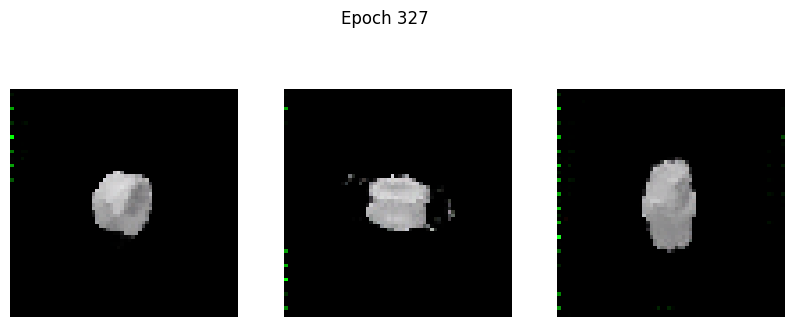

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0421 - g_loss: 4.5360
Epoch 328/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0856 - g_loss: 4.6810

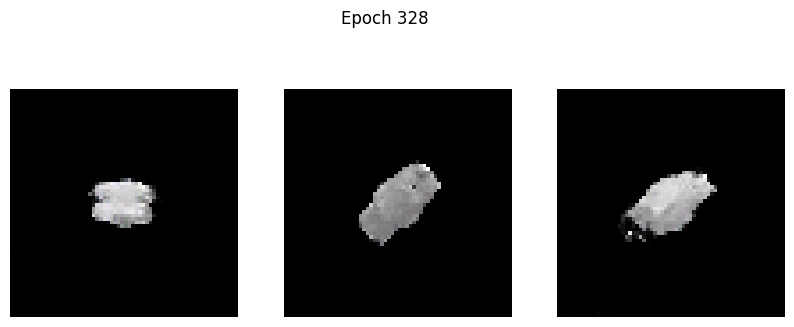

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0857 - g_loss: 4.6801
Epoch 329/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0864 - g_loss: 4.5673

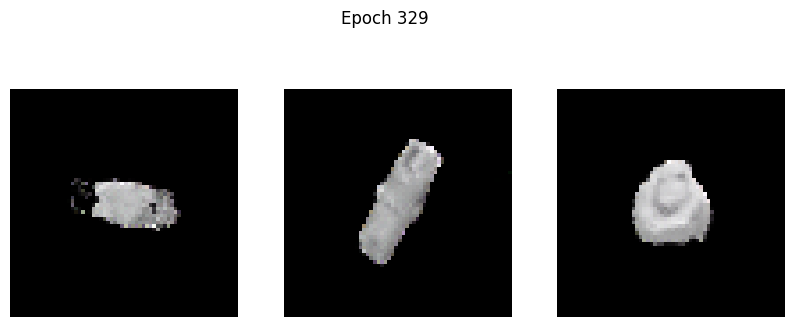

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - d_loss: 0.0879 - g_loss: 4.5725
Epoch 330/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0837 - g_loss: 4.3700

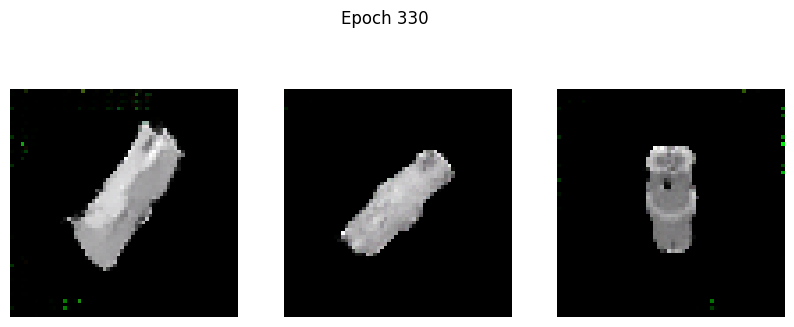

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0833 - g_loss: 4.3692
Epoch 331/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0526 - g_loss: 4.5381

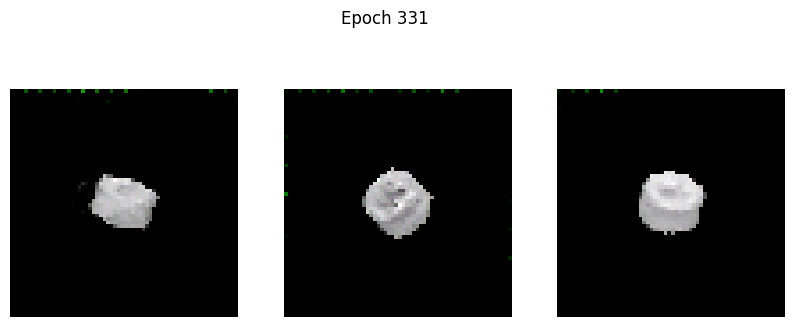

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0525 - g_loss: 4.5367
Epoch 332/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0393 - g_loss: 4.3267

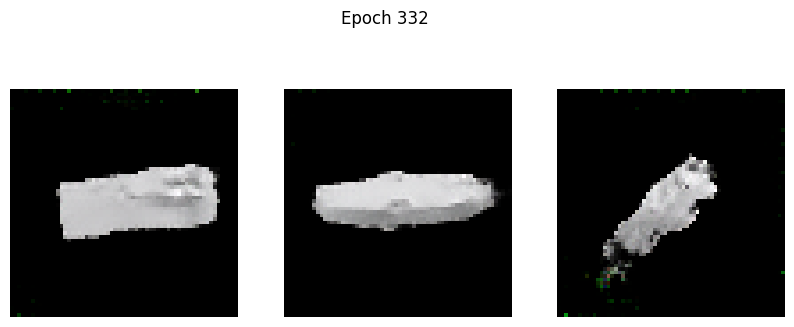

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0393 - g_loss: 4.3276
Epoch 333/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0728 - g_loss: 4.7083

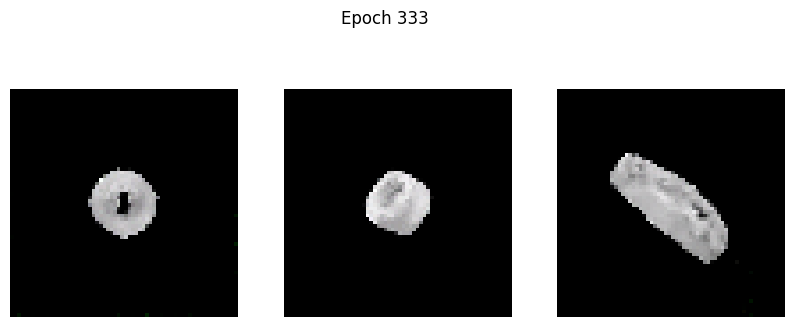

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0728 - g_loss: 4.7070
Epoch 334/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.0491 - g_loss: 4.5700

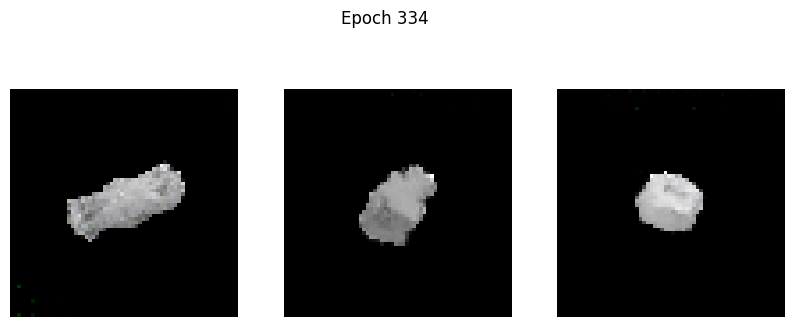

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.0492 - g_loss: 4.5700
Epoch 335/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0702 - g_loss: 4.7158

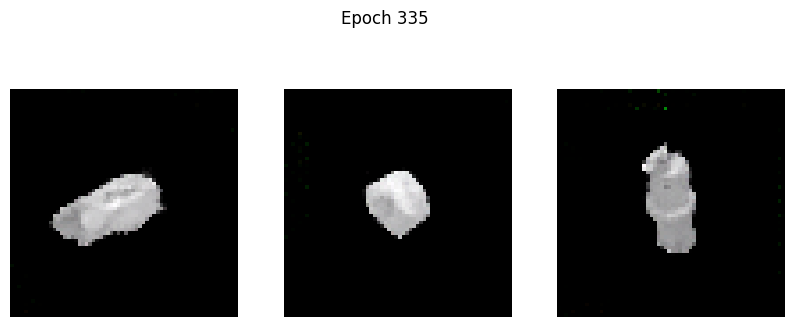

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0702 - g_loss: 4.7152
Epoch 336/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0146 - g_loss: 4.5255

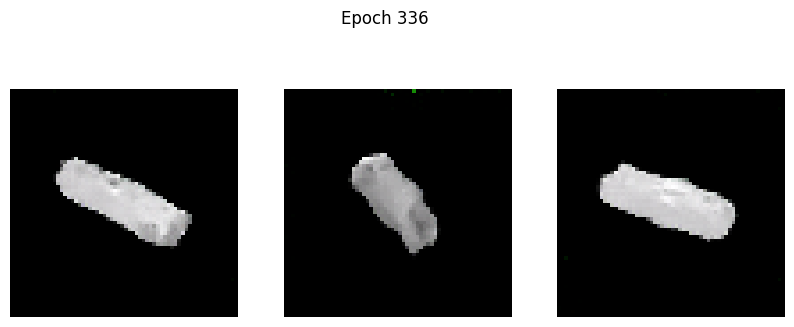

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0148 - g_loss: 4.5252
Epoch 337/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0530 - g_loss: 4.6654

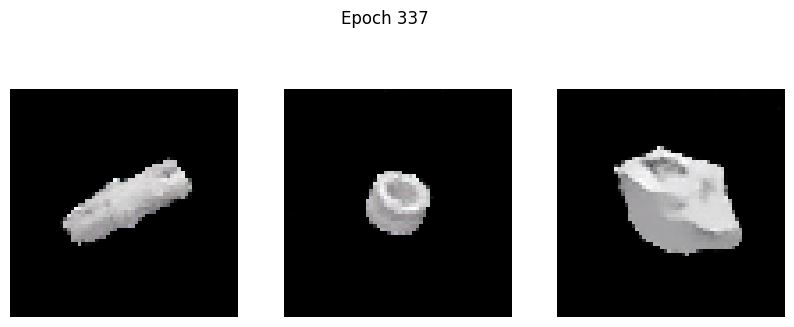

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0530 - g_loss: 4.6645
Epoch 338/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0275 - g_loss: 4.6733

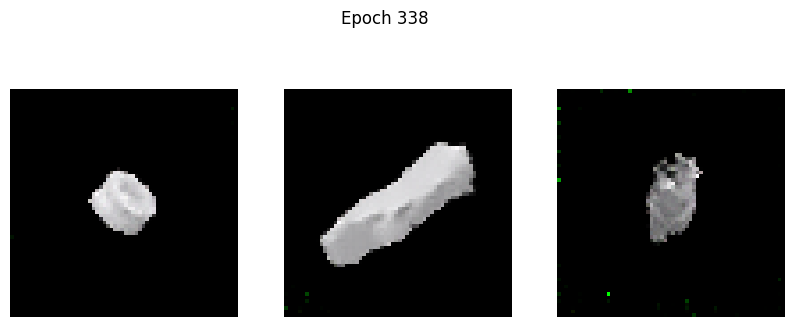

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0279 - g_loss: 4.6746
Epoch 339/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1574 - g_loss: 5.1402

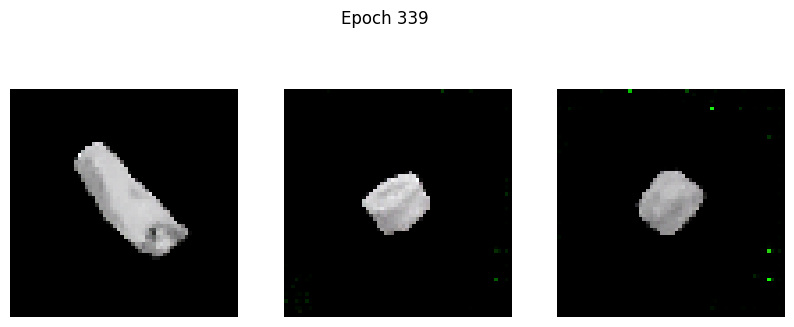

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1565 - g_loss: 5.1373
Epoch 340/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0178 - g_loss: 4.5019

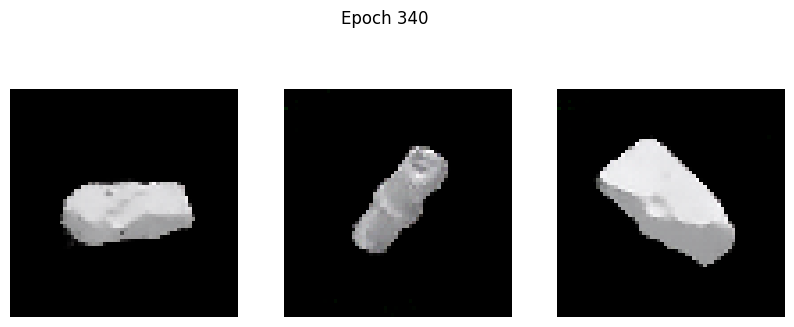

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0182 - g_loss: 4.5034
Epoch 341/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0737 - g_loss: 4.7364

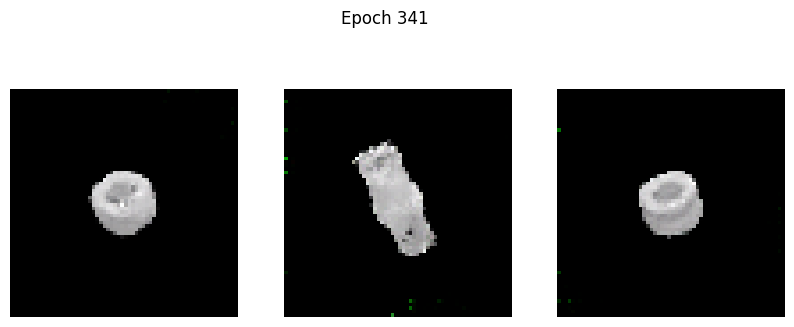

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0738 - g_loss: 4.7370
Epoch 342/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0295 - g_loss: 4.5652

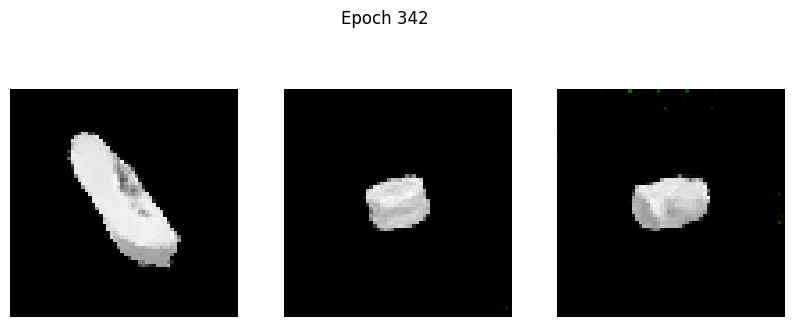

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0294 - g_loss: 4.5651
Epoch 343/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0625 - g_loss: 4.7708

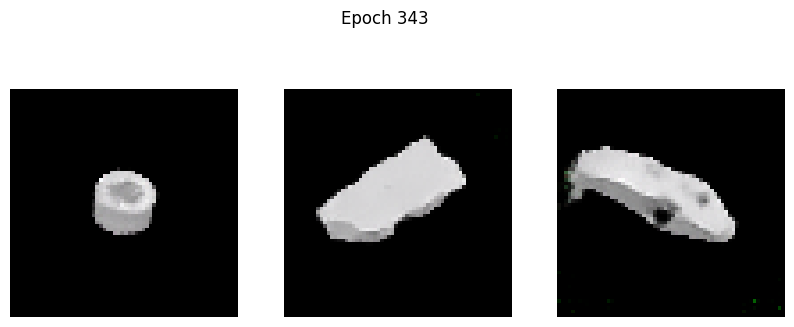

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0627 - g_loss: 4.7711
Epoch 344/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0932 - g_loss: 4.8439

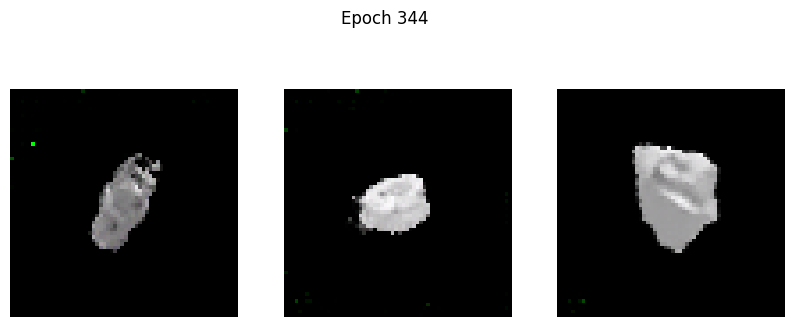

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0934 - g_loss: 4.8447
Epoch 345/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0397 - g_loss: 4.6792

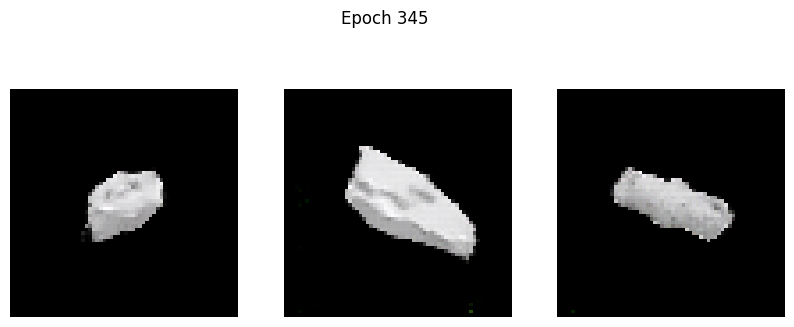

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0398 - g_loss: 4.6789
Epoch 346/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0583 - g_loss: 4.8814

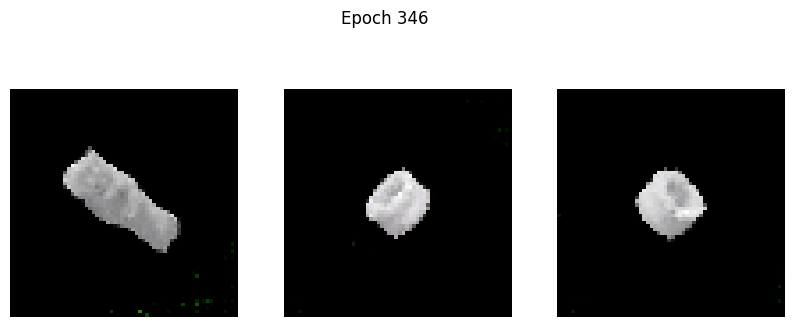

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0583 - g_loss: 4.8803
Epoch 347/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0553 - g_loss: 4.6152

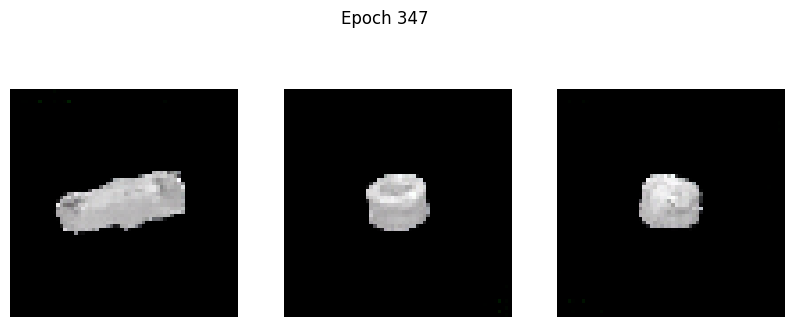

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0551 - g_loss: 4.6157
Epoch 348/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0347 - g_loss: 4.7713

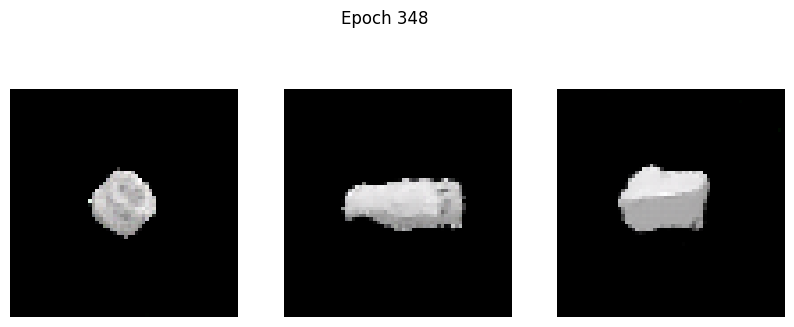

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0347 - g_loss: 4.7712
Epoch 349/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0402 - g_loss: 4.8628

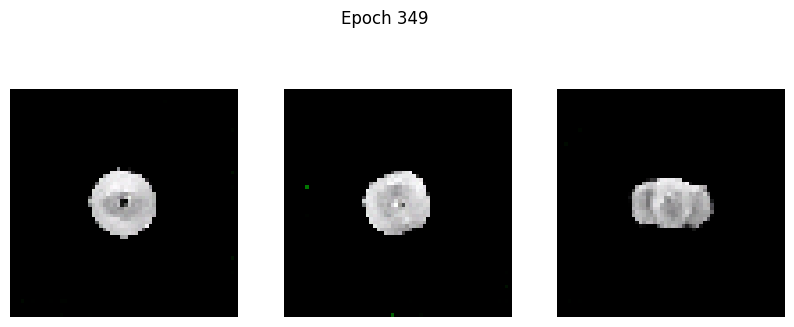

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0403 - g_loss: 4.8631
Epoch 350/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1429 - g_loss: 5.3049

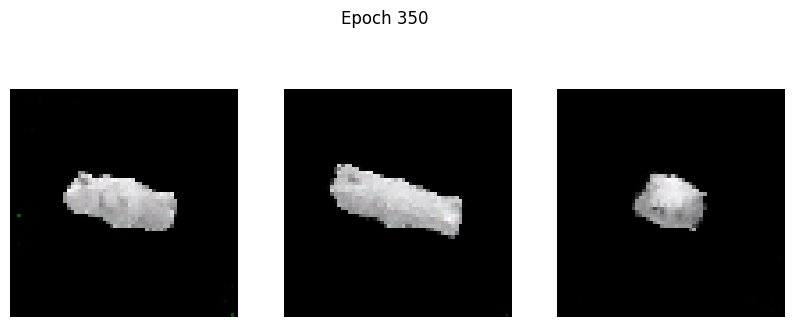

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1425 - g_loss: 5.3013
Epoch 351/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0714 - g_loss: 4.6703

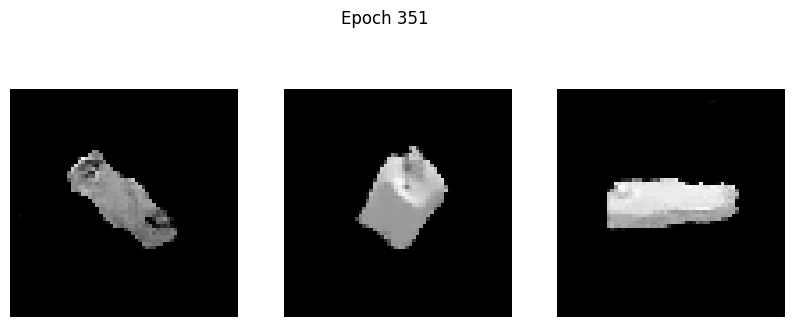

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0715 - g_loss: 4.6716
Epoch 352/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0832 - g_loss: 4.8287

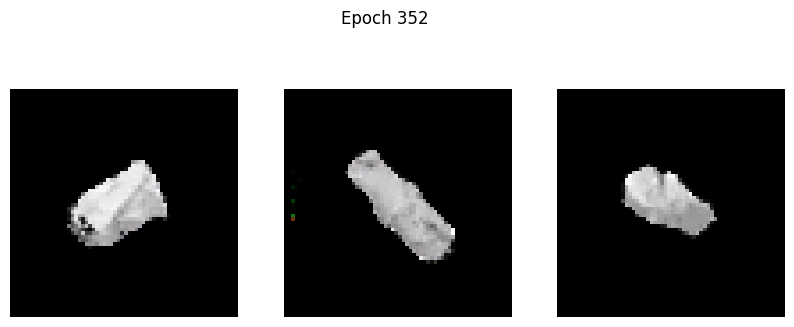

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0835 - g_loss: 4.8296
Epoch 353/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0752 - g_loss: 4.7502

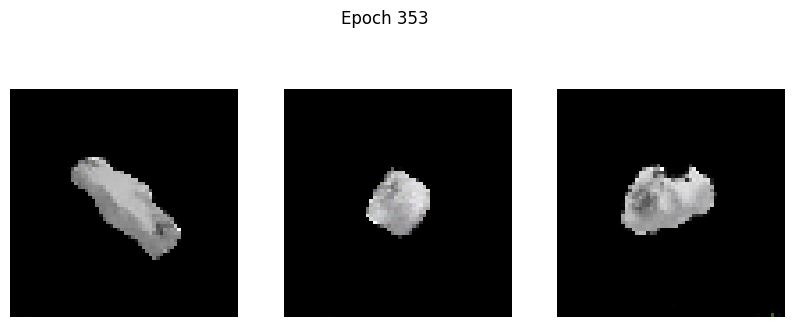

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0751 - g_loss: 4.7490
Epoch 354/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0124 - g_loss: 4.5451

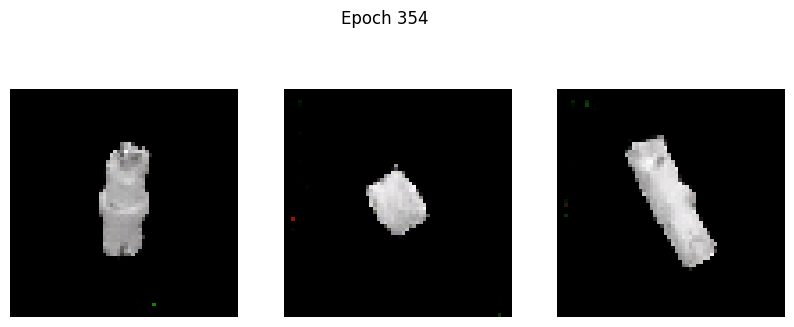

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0127 - g_loss: 4.5466
Epoch 355/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0672 - g_loss: 4.9429

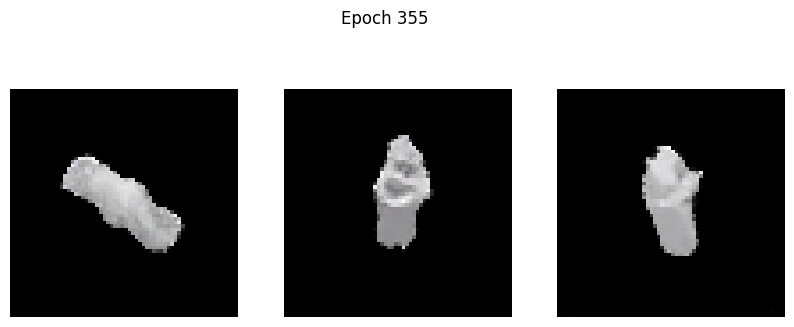

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0671 - g_loss: 4.9419
Epoch 356/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0353 - g_loss: 4.5904

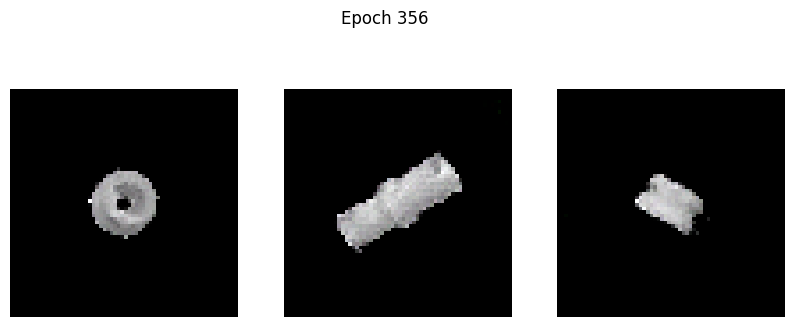

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0353 - g_loss: 4.5911
Epoch 357/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0697 - g_loss: 4.9069

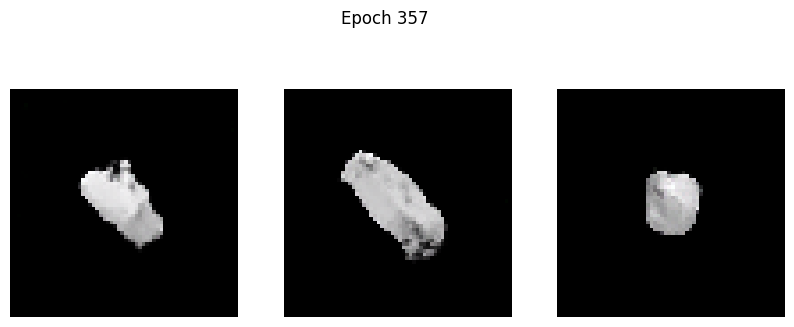

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0698 - g_loss: 4.9062
Epoch 358/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0280 - g_loss: 4.8706

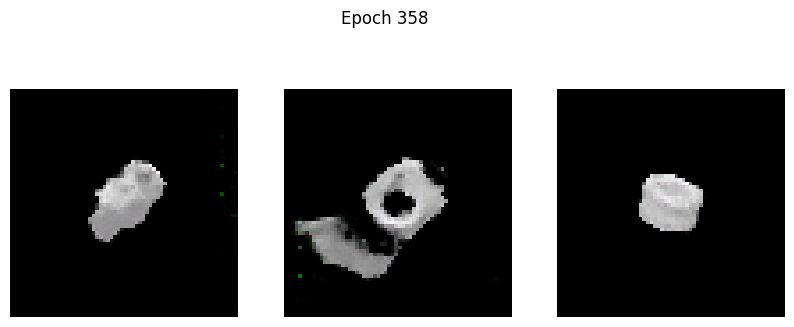

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.0279 - g_loss: 4.8690
Epoch 359/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0637 - g_loss: 4.9972

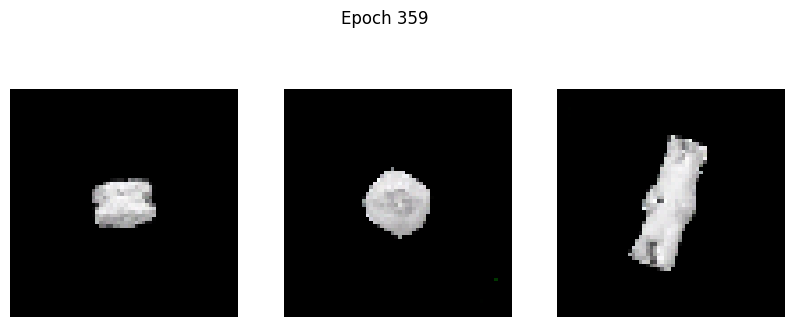

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.0638 - g_loss: 4.9977
Epoch 360/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0370 - g_loss: 4.7837

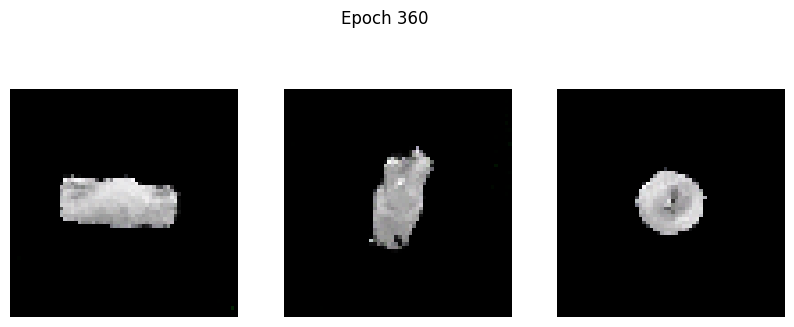

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - d_loss: 0.0370 - g_loss: 4.7836
Epoch 361/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - d_loss: 0.0375 - g_loss: 4.9237

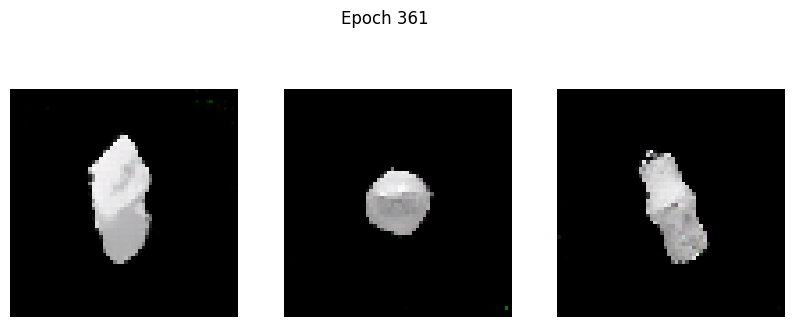

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - d_loss: 0.0375 - g_loss: 4.9235
Epoch 362/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - d_loss: 0.0333 - g_loss: 4.6998

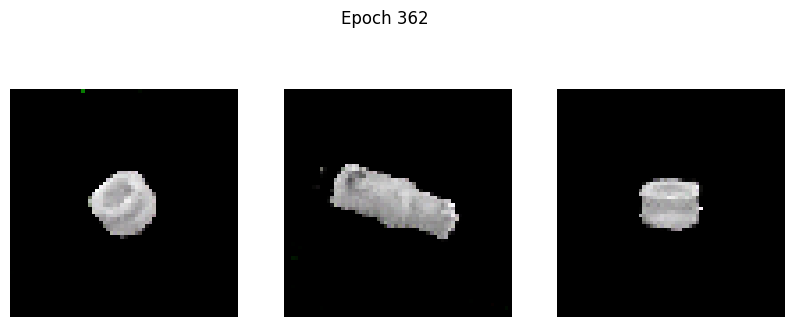

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - d_loss: 0.0331 - g_loss: 4.6995
Epoch 363/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.0041 - g_loss: 4.5952

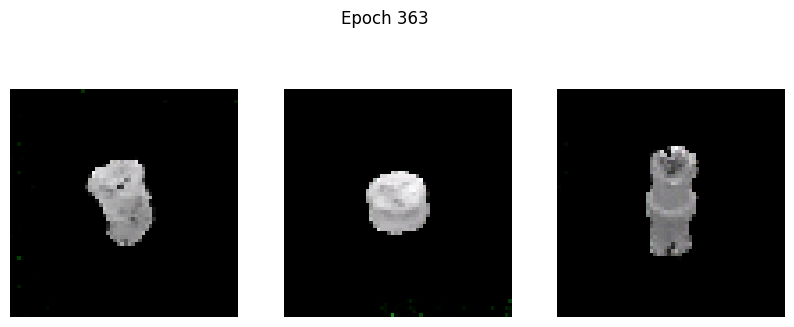

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.0039 - g_loss: 4.5952
Epoch 364/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0701 - g_loss: 5.0052

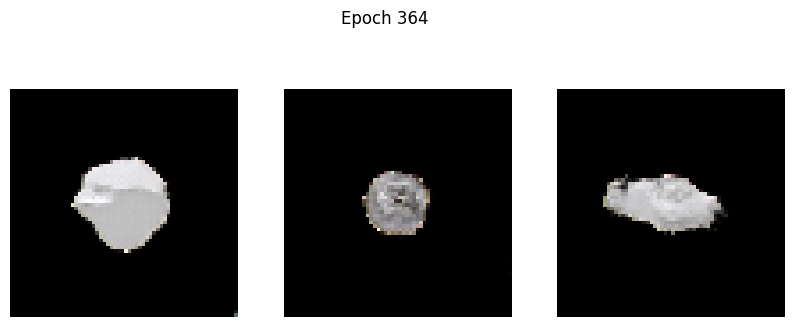

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0732 - g_loss: 5.0147
Epoch 365/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.1761 - g_loss: 4.4928

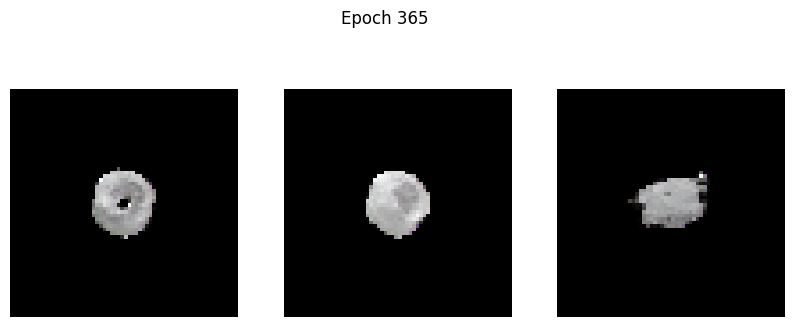

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.1753 - g_loss: 4.4919
Epoch 366/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0108 - g_loss: 4.3269

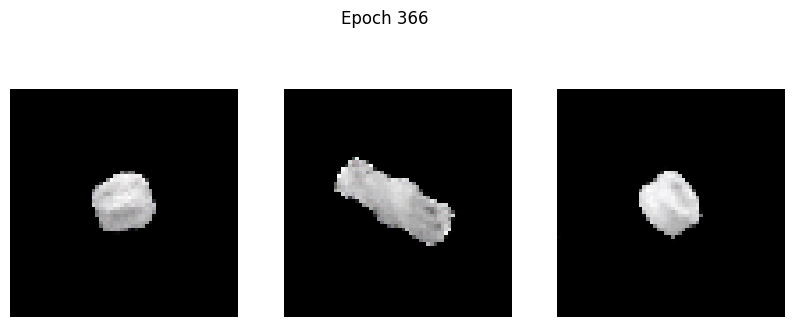

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0107 - g_loss: 4.3277
Epoch 367/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0235 - g_loss: 4.7517

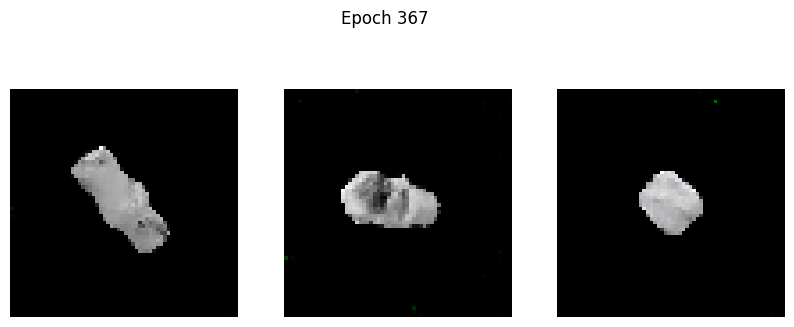

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0235 - g_loss: 4.7513
Epoch 368/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.0024 - g_loss: 4.5713

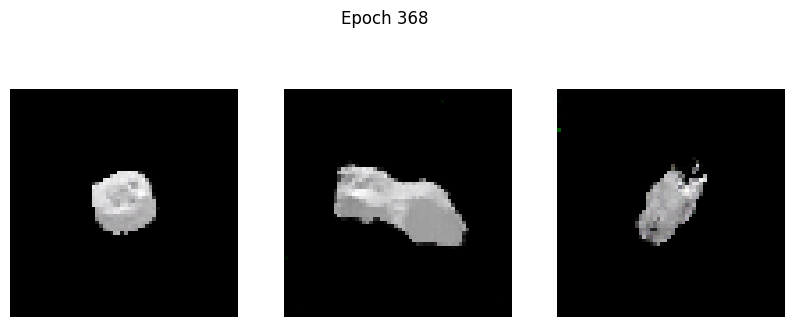

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.0020 - g_loss: 4.5742
Epoch 369/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0217 - g_loss: 4.9256

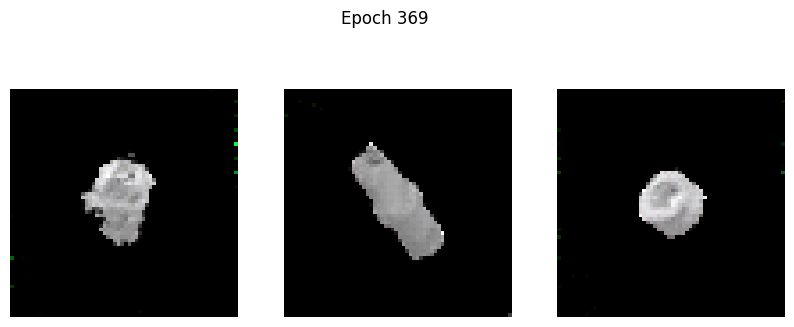

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0215 - g_loss: 4.9237
Epoch 370/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0104 - g_loss: 4.7551

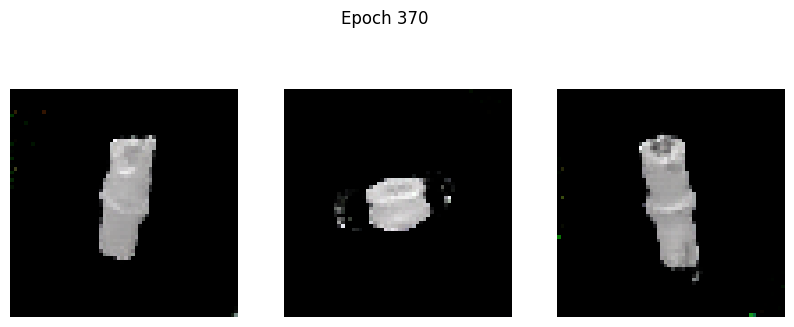

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0107 - g_loss: 4.7565
Epoch 371/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0092 - g_loss: 4.9459

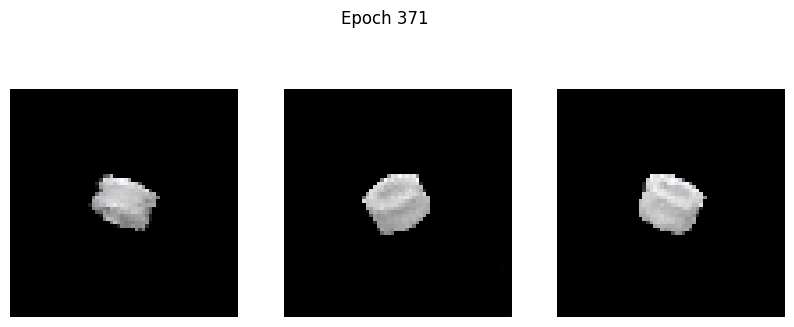

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0094 - g_loss: 4.9450
Epoch 372/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0208 - g_loss: 5.1276

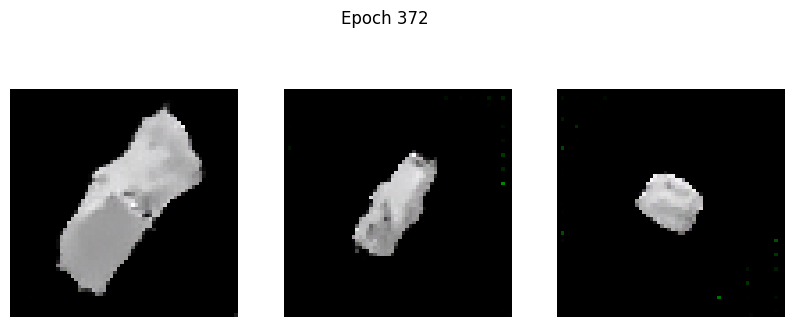

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0208 - g_loss: 5.1262
Epoch 373/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -0.0029 - g_loss: 4.7762

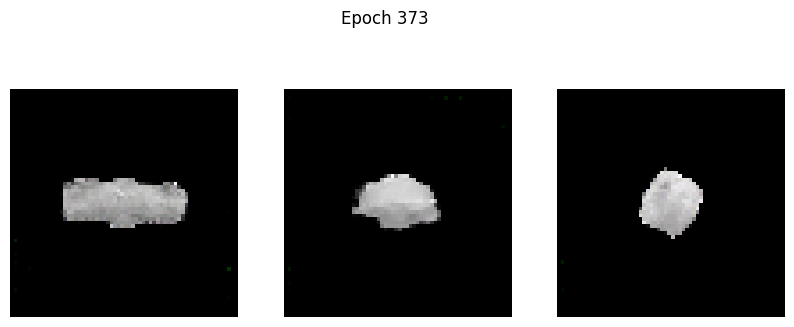

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: -0.0025 - g_loss: 4.7784
Epoch 374/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0471 - g_loss: 4.9539

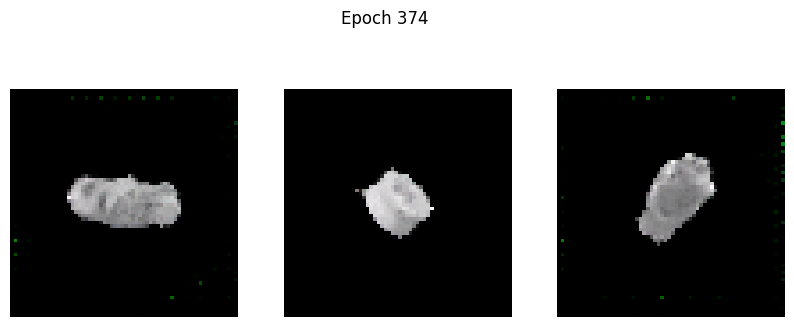

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0469 - g_loss: 4.9534
Epoch 375/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0639 - g_loss: 5.2857

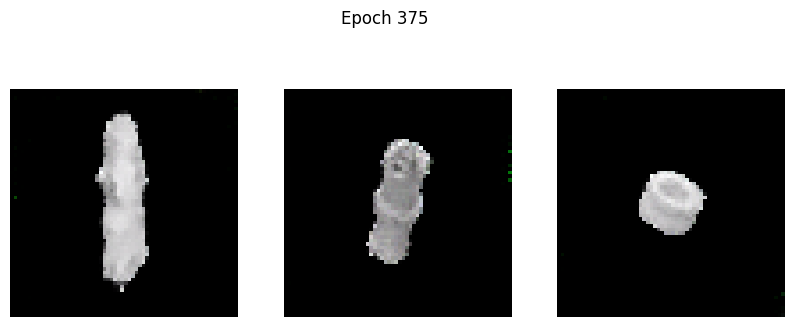

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0638 - g_loss: 5.2837
Epoch 376/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0917 - g_loss: 5.4542

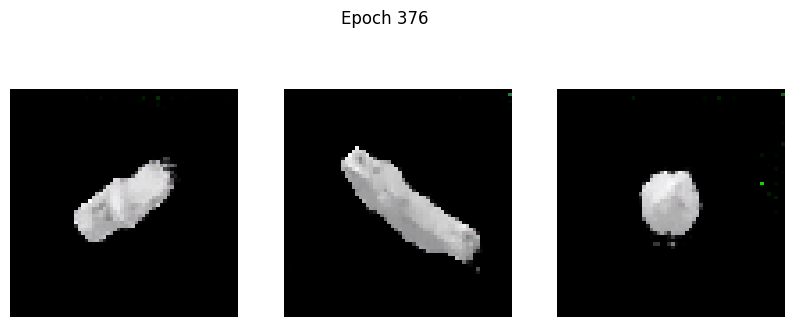

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0914 - g_loss: 5.4512
Epoch 377/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0064 - g_loss: 4.8426

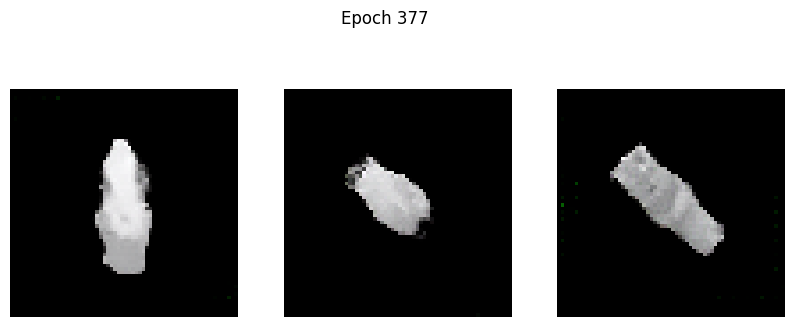

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0062 - g_loss: 4.8435
Epoch 378/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0333 - g_loss: 5.0412

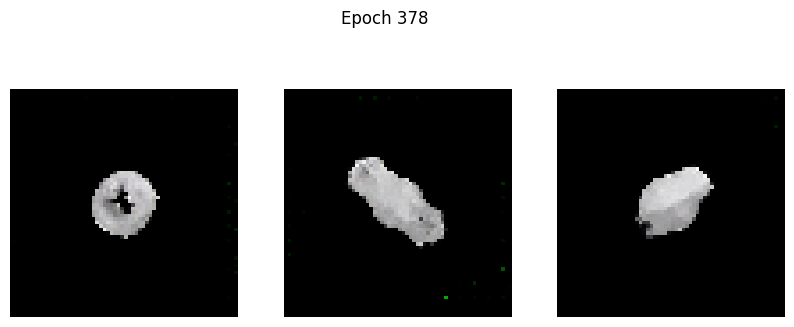

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0333 - g_loss: 5.0402
Epoch 379/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0145 - g_loss: 5.1412

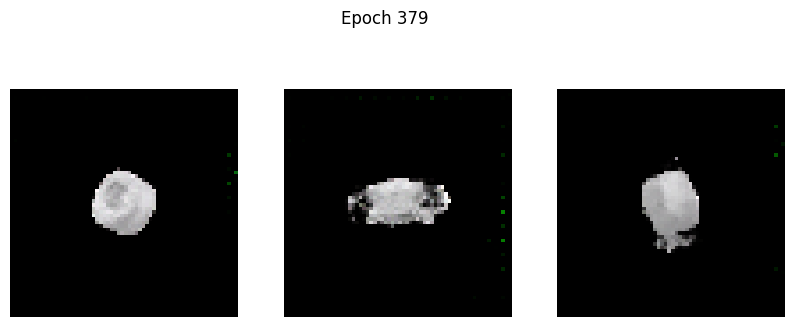

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0148 - g_loss: 5.1428
Epoch 380/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0712 - g_loss: 5.2064

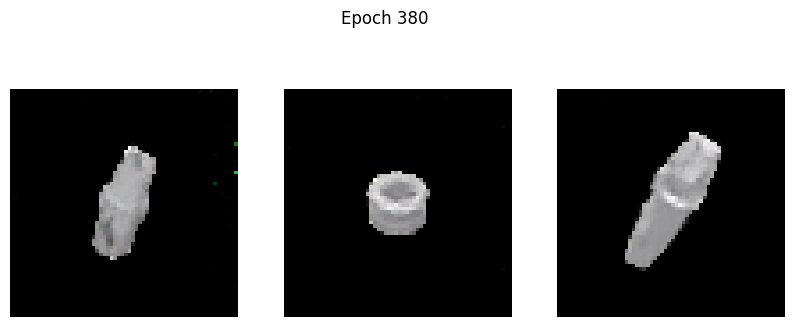

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0716 - g_loss: 5.2068
Epoch 381/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0259 - g_loss: 4.9190

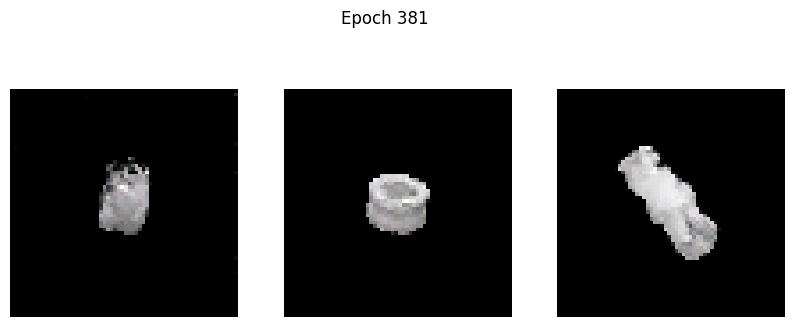

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0257 - g_loss: 4.9186
Epoch 382/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0385 - g_loss: 5.3663

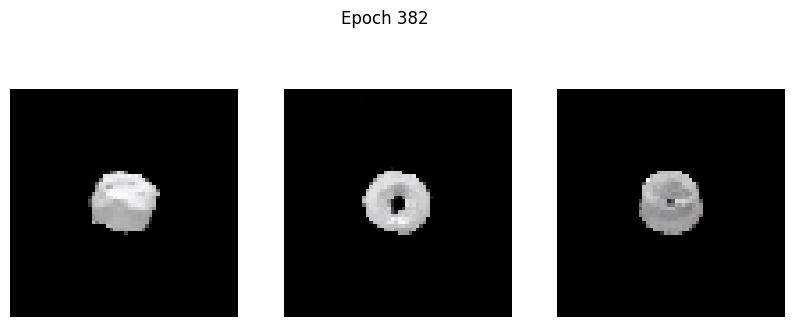

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.0384 - g_loss: 5.3644
Epoch 383/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.0026 - g_loss: 4.8681

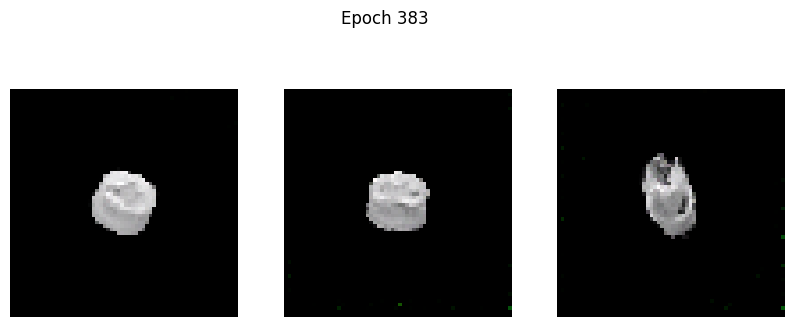

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.0026 - g_loss: 4.8690
Epoch 384/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0088 - g_loss: 4.8587

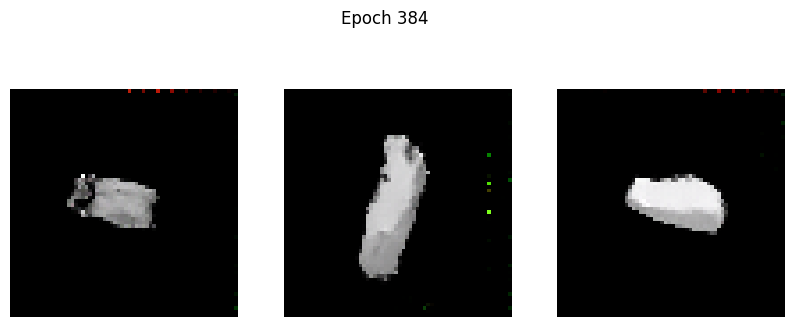

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0091 - g_loss: 4.8596
Epoch 385/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0318 - g_loss: 5.1850

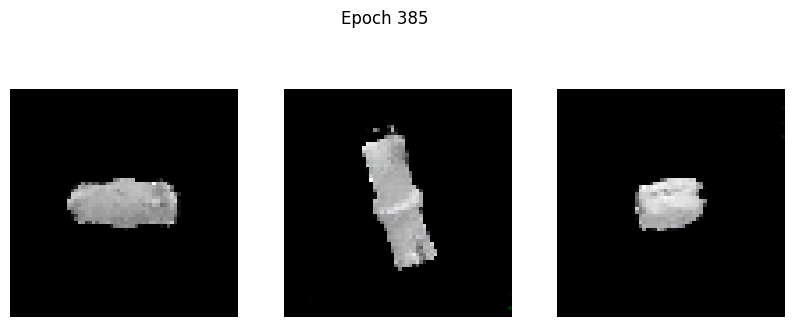

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0316 - g_loss: 5.1842
Epoch 386/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0192 - g_loss: 4.8420

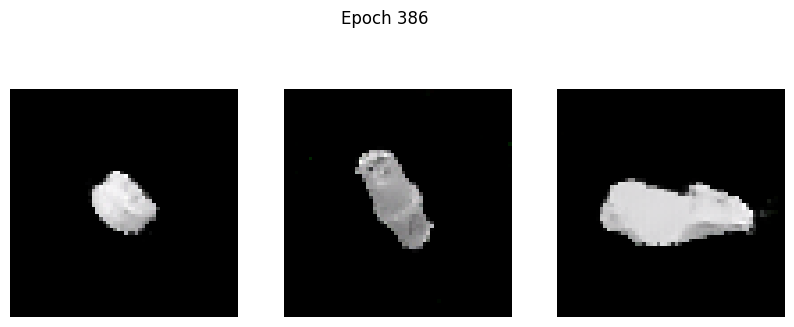

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0189 - g_loss: 4.8442
Epoch 387/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0739 - g_loss: 5.4561

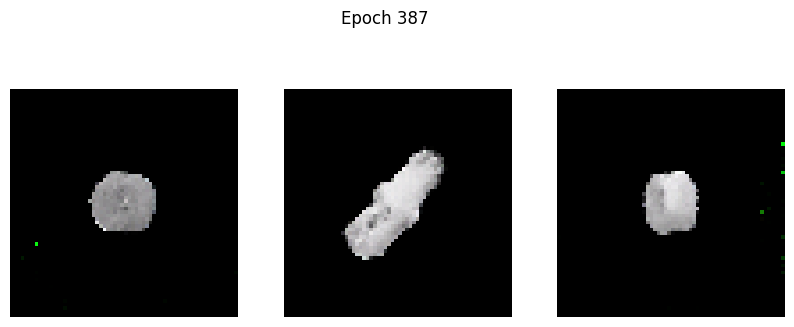

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0735 - g_loss: 5.4543
Epoch 388/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0543 - g_loss: 5.3467

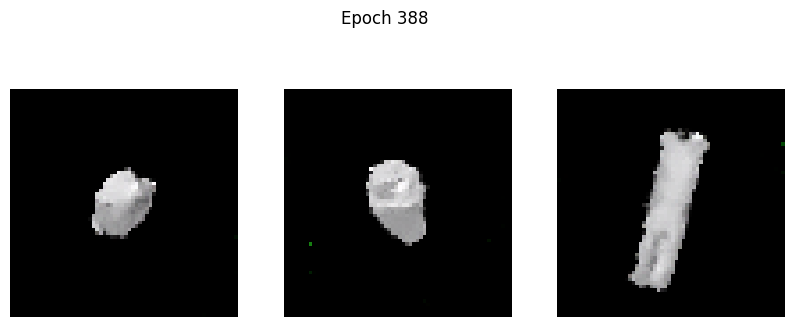

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0540 - g_loss: 5.3445
Epoch 389/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0147 - g_loss: 5.2183

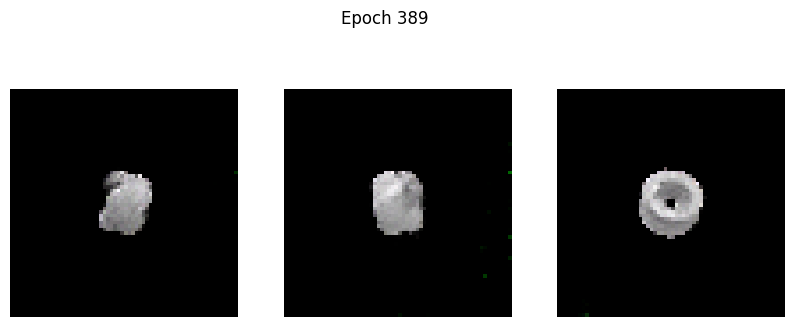

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0149 - g_loss: 5.2189
Epoch 390/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1056 - g_loss: 5.6692

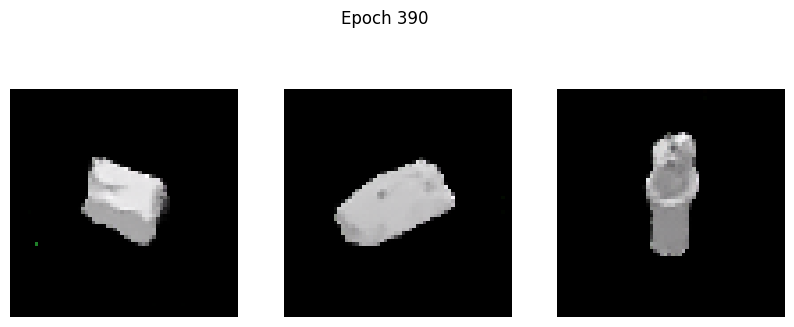

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1050 - g_loss: 5.6656
Epoch 391/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0240 - g_loss: 4.8998

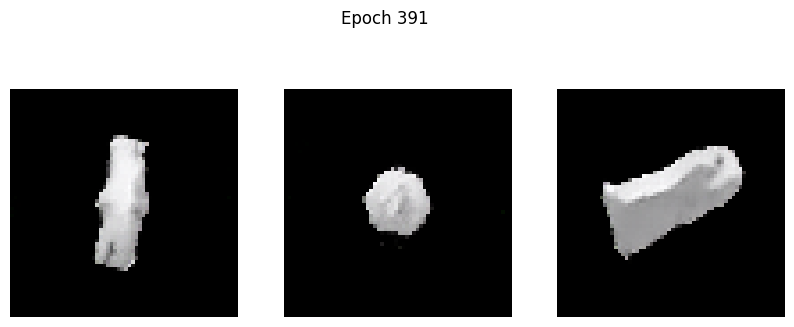

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0240 - g_loss: 4.8999
Epoch 392/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0048 - g_loss: 5.2487

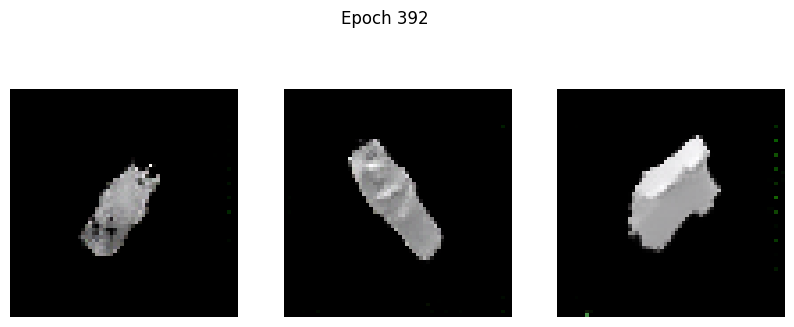

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0048 - g_loss: 5.2492
Epoch 393/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0116 - g_loss: 4.9069

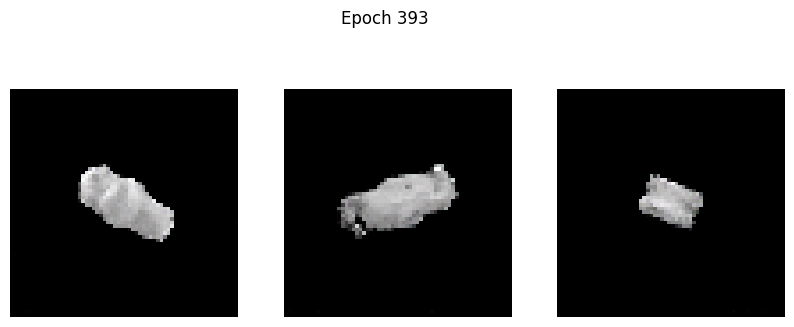

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0119 - g_loss: 4.9059
Epoch 394/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0303 - g_loss: 5.0860

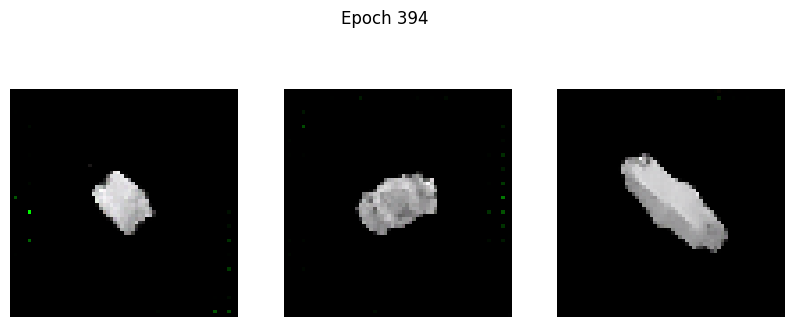

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0298 - g_loss: 5.0880
Epoch 395/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.1103 - g_loss: 5.6499

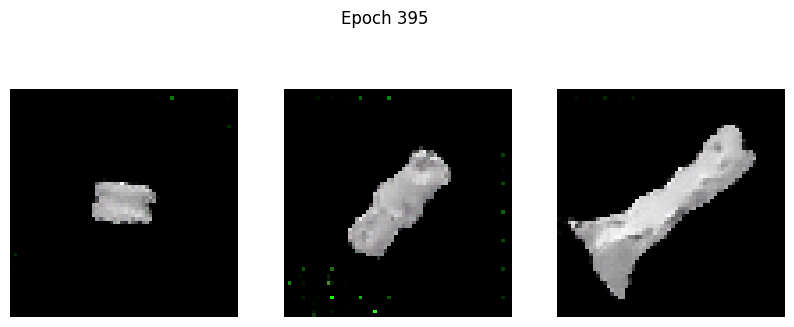

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.1097 - g_loss: 5.6463
Epoch 396/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0366 - g_loss: 5.6572

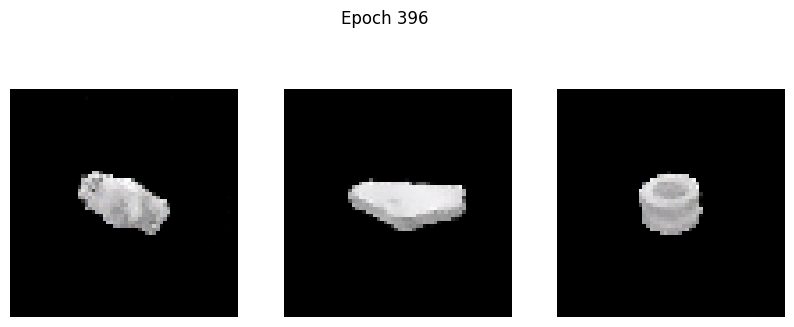

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - d_loss: 0.0366 - g_loss: 5.6551
Epoch 397/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0348 - g_loss: 5.2584

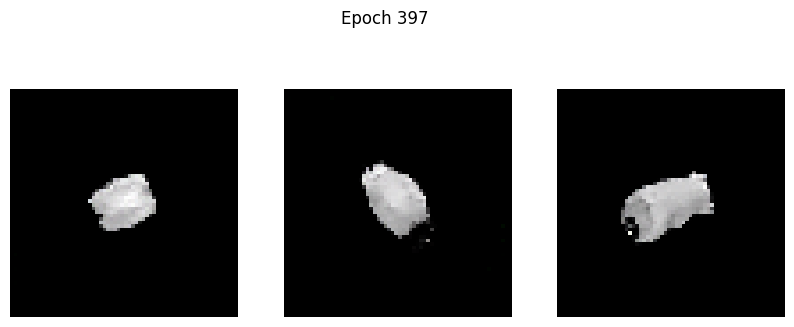

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0346 - g_loss: 5.2575
Epoch 398/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0355 - g_loss: 5.1687

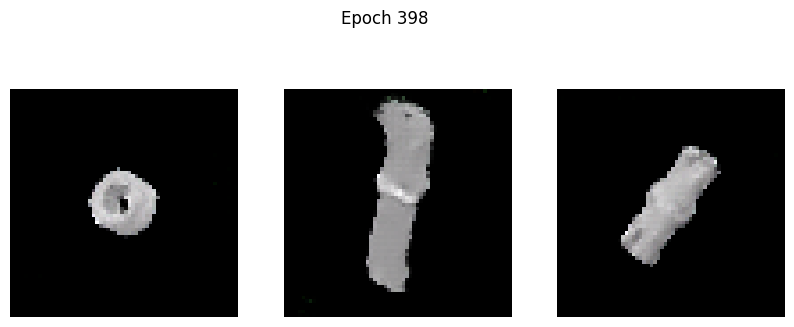

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: 0.0355 - g_loss: 5.1706
Epoch 399/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0247 - g_loss: 5.1369

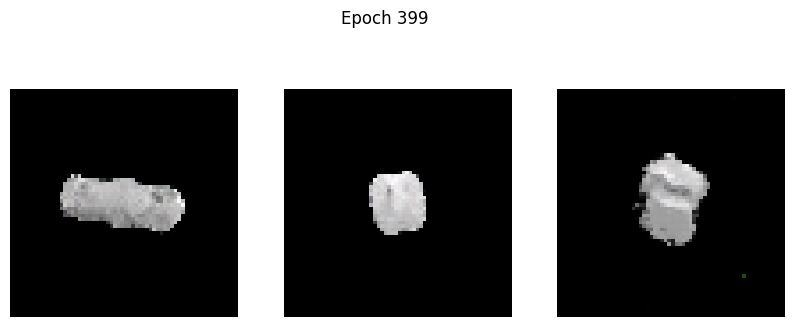

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0244 - g_loss: 5.1378
Epoch 400/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0207 - g_loss: 5.3408

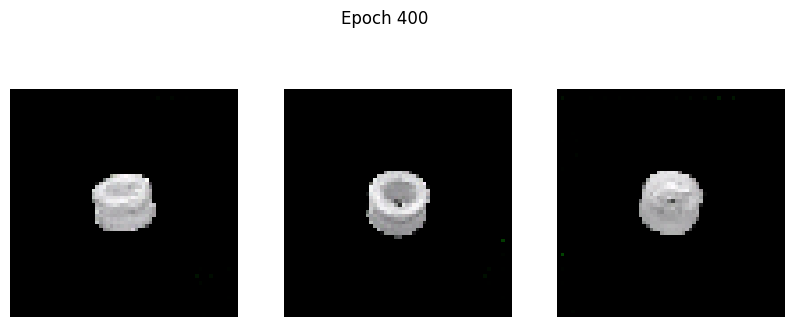

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0206 - g_loss: 5.3400
Epoch 401/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0433 - g_loss: 5.1471

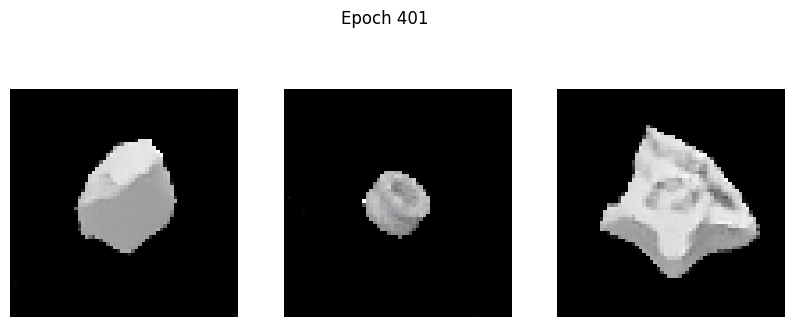

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0430 - g_loss: 5.1467
Epoch 402/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0238 - g_loss: 5.2729

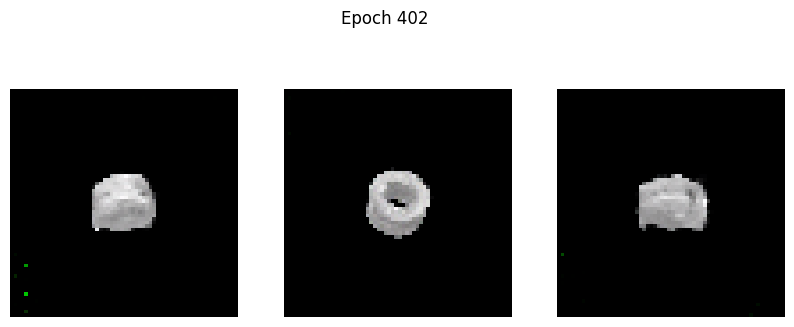

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0238 - g_loss: 5.2725
Epoch 403/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0237 - g_loss: 5.2022

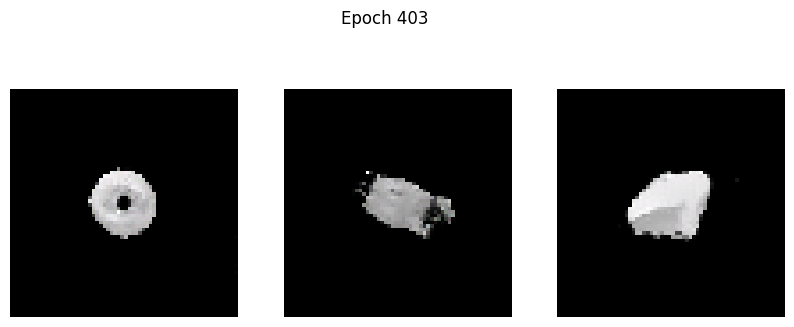

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.0235 - g_loss: 5.2019
Epoch 404/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0019 - g_loss: 5.3927

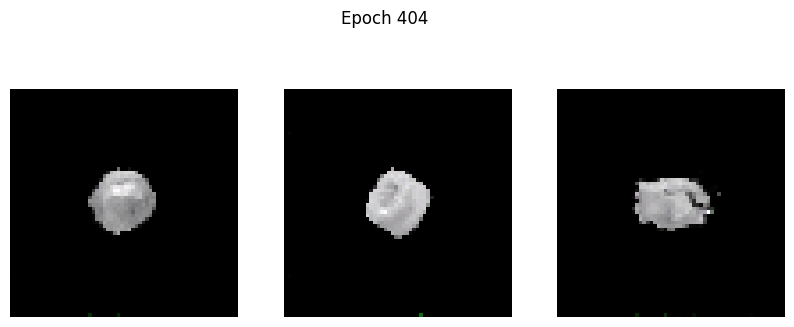

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.0016 - g_loss: 5.3910
Epoch 405/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0041 - g_loss: 5.5638

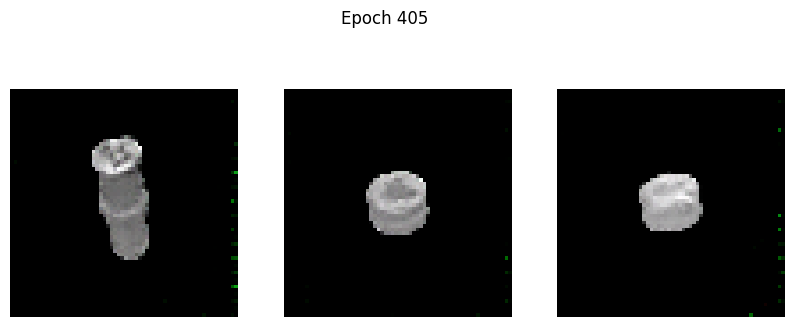

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0040 - g_loss: 5.5642
Epoch 406/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0388 - g_loss: 5.7487

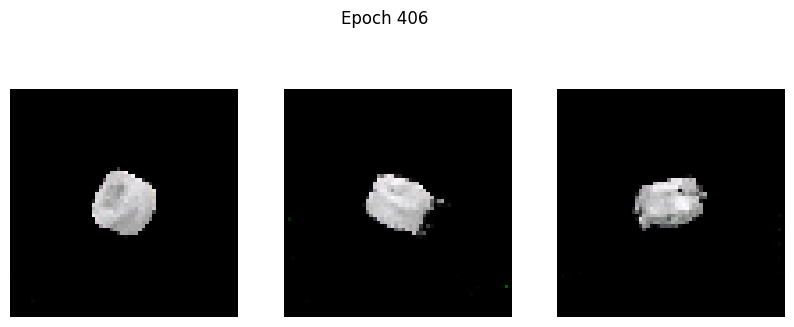

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.0390 - g_loss: 5.7480
Epoch 407/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0636 - g_loss: 5.6112

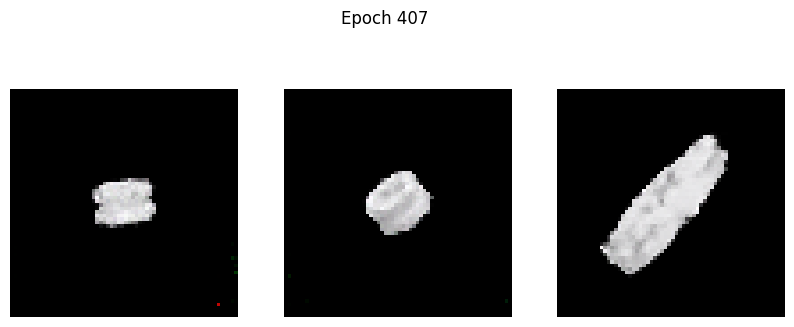

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.0634 - g_loss: 5.6097
Epoch 408/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0241 - g_loss: 5.2920

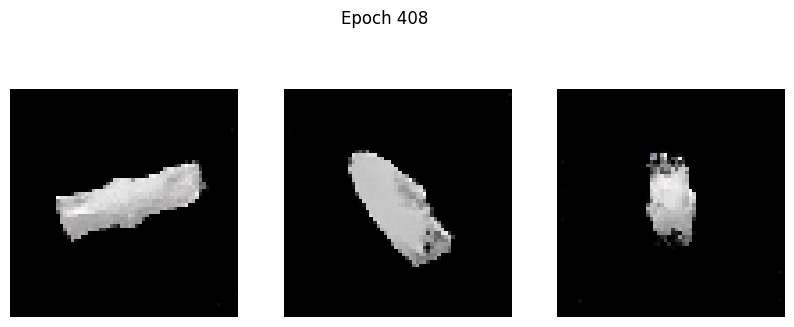

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0241 - g_loss: 5.2923
Epoch 409/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0472 - g_loss: 5.2213

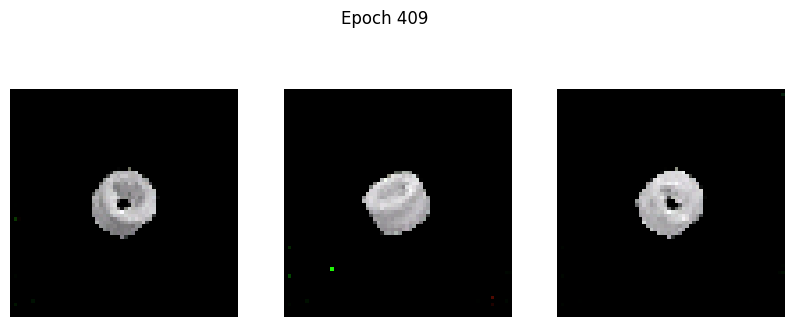

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0472 - g_loss: 5.2218
Epoch 410/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0348 - g_loss: 5.8033

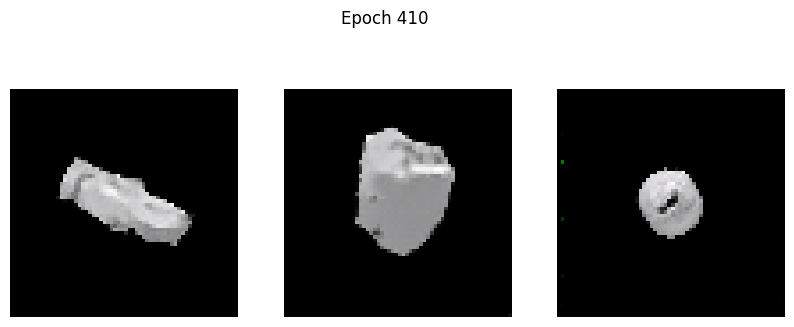

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0345 - g_loss: 5.8012
Epoch 411/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0428 - g_loss: 4.9926

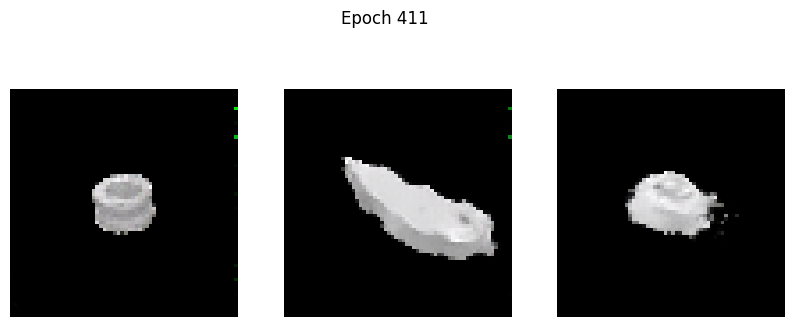

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0426 - g_loss: 4.9935
Epoch 412/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0190 - g_loss: 5.6741

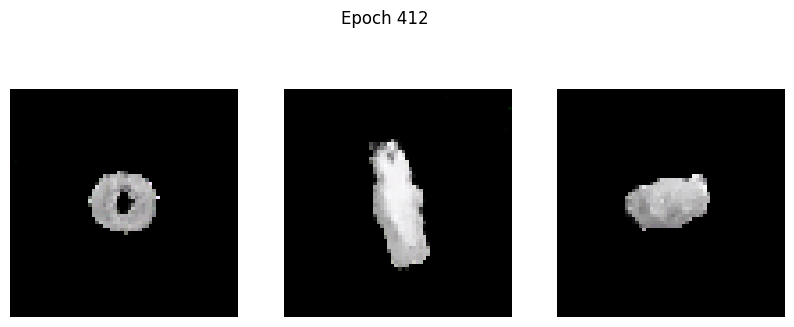

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0187 - g_loss: 5.6715
Epoch 413/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0728 - g_loss: 5.9771

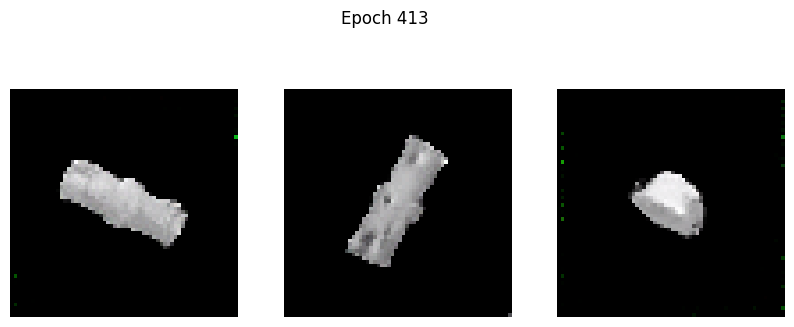

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0727 - g_loss: 5.9764
Epoch 414/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0653 - g_loss: 5.0301

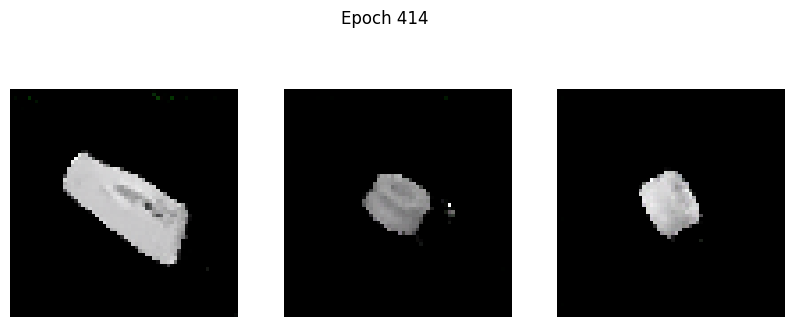

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0648 - g_loss: 5.0342
Epoch 415/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0013 - g_loss: 6.1374

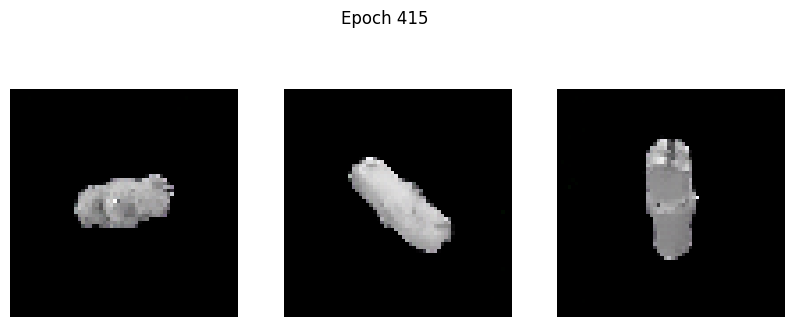

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0010 - g_loss: 6.1339
Epoch 416/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0125 - g_loss: 5.3220

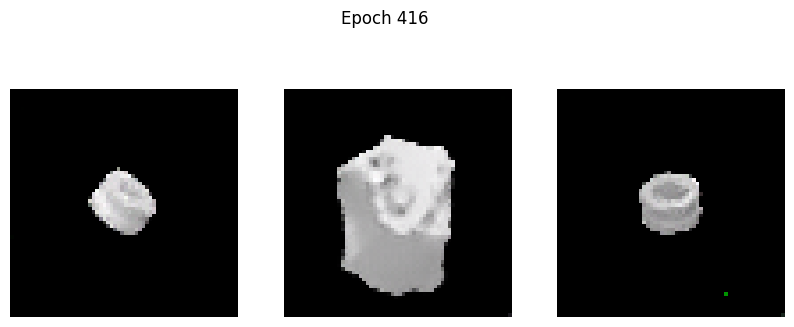

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0124 - g_loss: 5.3231
Epoch 417/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0080 - g_loss: 5.6750

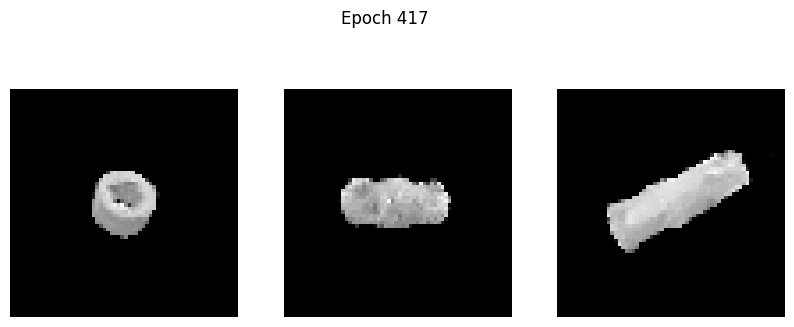

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0088 - g_loss: 5.6772
Epoch 418/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -0.0473 - g_loss: 5.2690

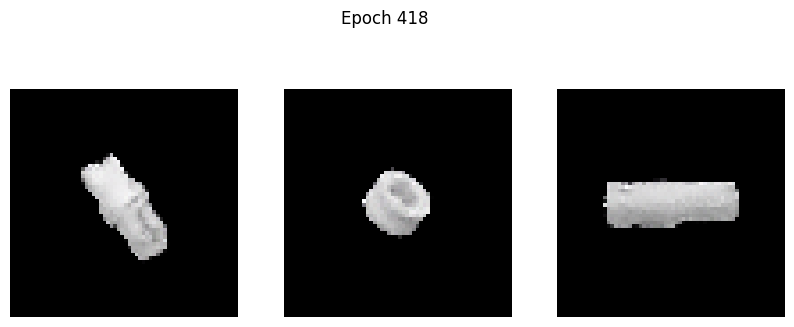

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: -0.0473 - g_loss: 5.2699
Epoch 419/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0506 - g_loss: 5.6842

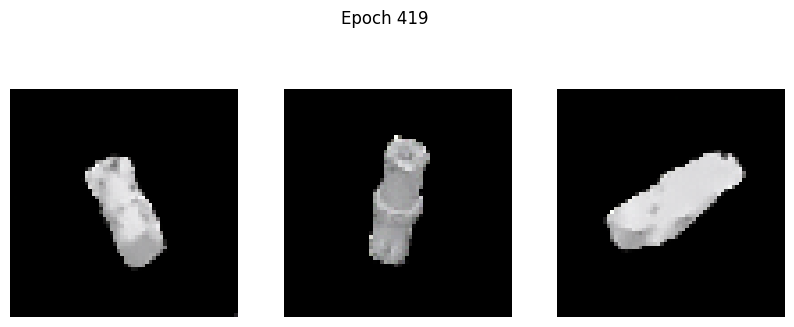

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0502 - g_loss: 5.6834
Epoch 420/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0405 - g_loss: 5.2144

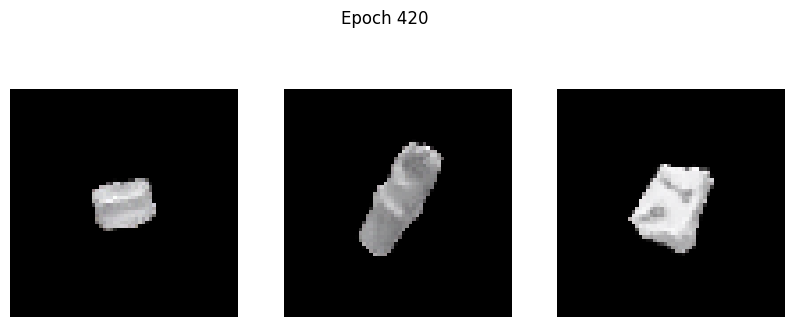

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0404 - g_loss: 5.2158
Epoch 421/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -0.0617 - g_loss: 5.1955

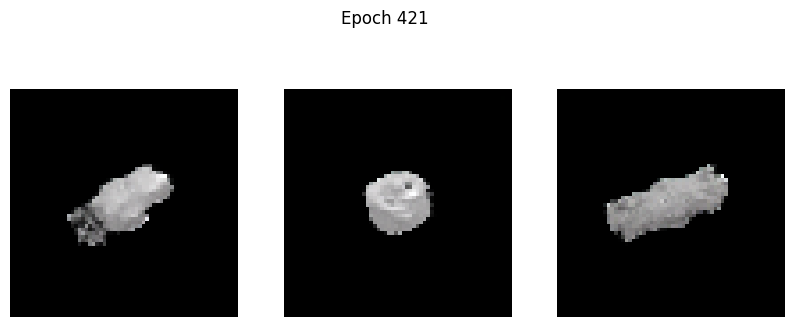

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: -0.0616 - g_loss: 5.1960
Epoch 422/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0172 - g_loss: 5.6934

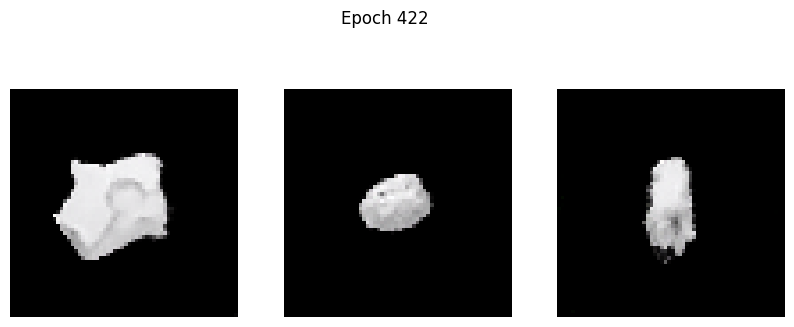

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0169 - g_loss: 5.6953
Epoch 423/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0845 - g_loss: 5.1722

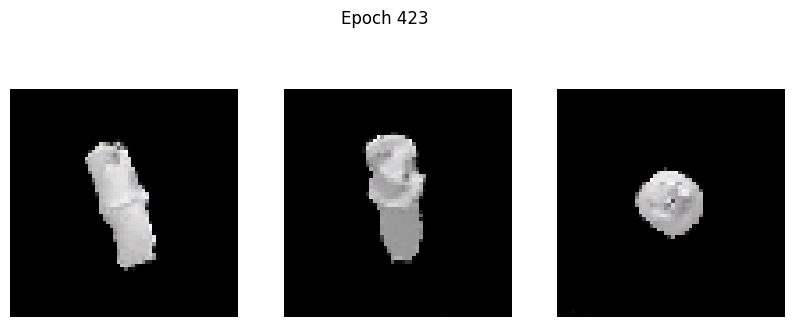

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0841 - g_loss: 5.1746
Epoch 424/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0245 - g_loss: 5.4695

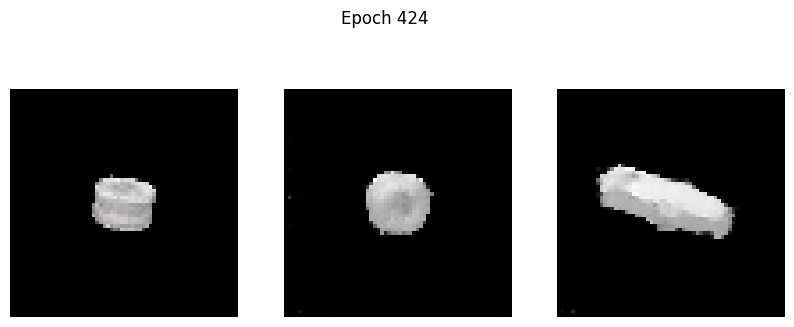

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0243 - g_loss: 5.4712
Epoch 425/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0521 - g_loss: 5.8170

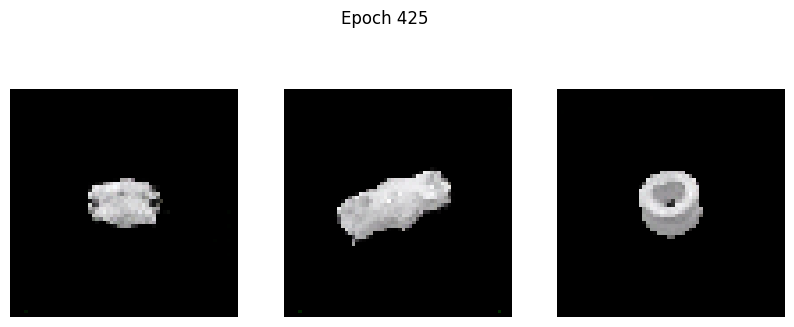

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0523 - g_loss: 5.8131
Epoch 426/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0453 - g_loss: 5.8336

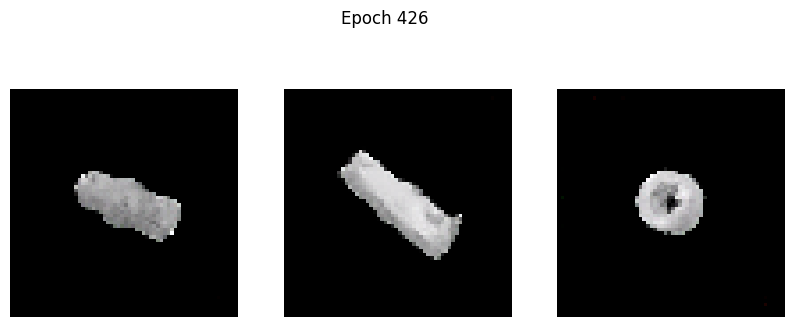

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0450 - g_loss: 5.8327
Epoch 427/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -0.0435 - g_loss: 5.5491

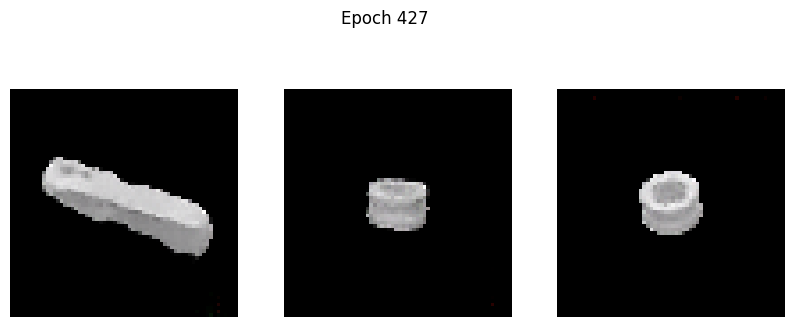

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0437 - g_loss: 5.5499
Epoch 428/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0372 - g_loss: 5.9151

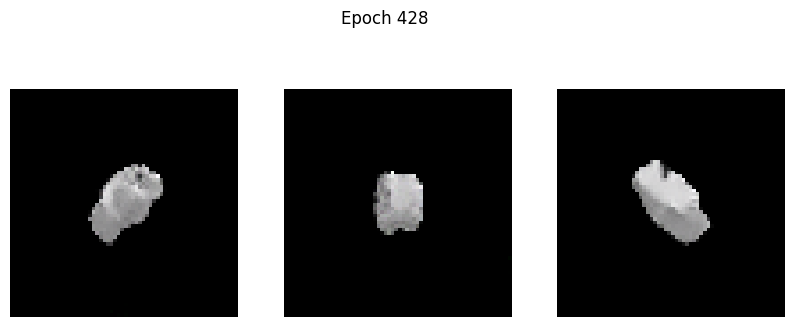

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0373 - g_loss: 5.9140
Epoch 429/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0736 - g_loss: 6.3982

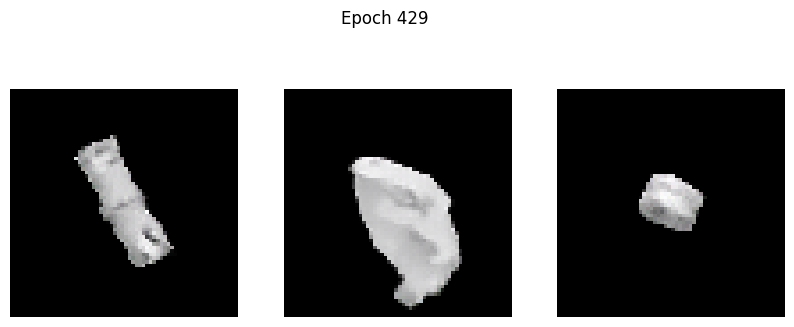

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0730 - g_loss: 6.3947
Epoch 430/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -7.6978e-04 - g_loss: 5.7098

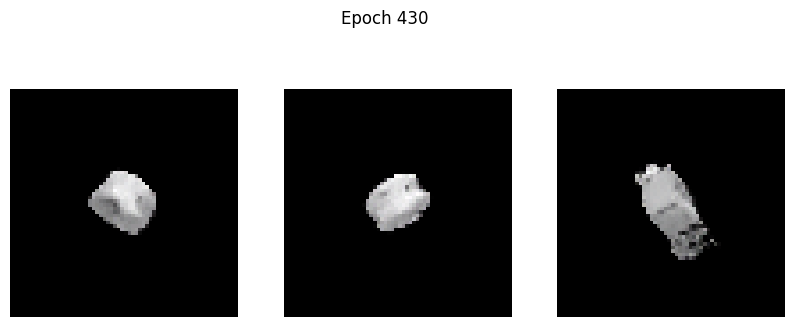

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -2.5226e-04 - g_loss: 5.7104
Epoch 431/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0016 - g_loss: 5.8293

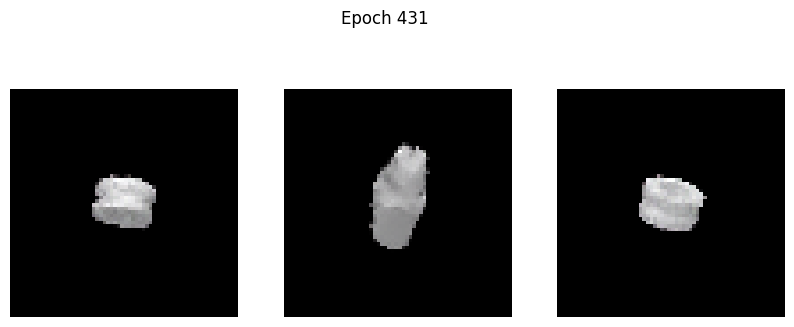

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0020 - g_loss: 5.8268
Epoch 432/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -0.0452 - g_loss: 5.8028

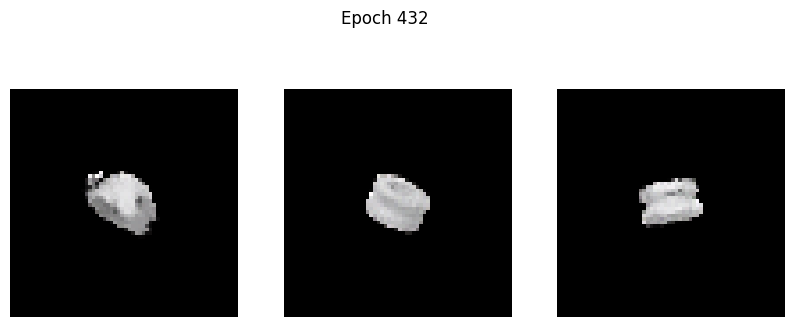

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: -0.0452 - g_loss: 5.8019
Epoch 433/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -0.0487 - g_loss: 5.9378

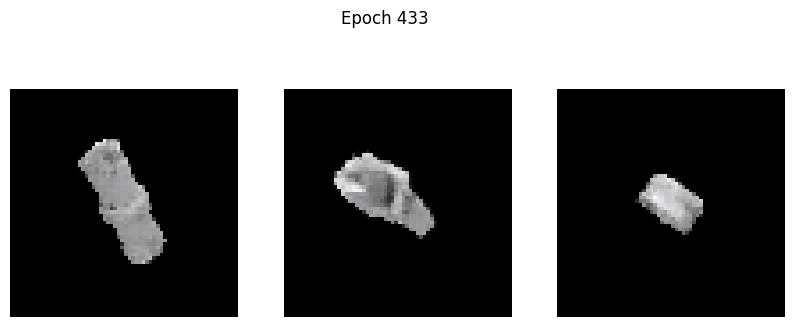

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: -0.0486 - g_loss: 5.9371
Epoch 434/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -0.0226 - g_loss: 5.7958

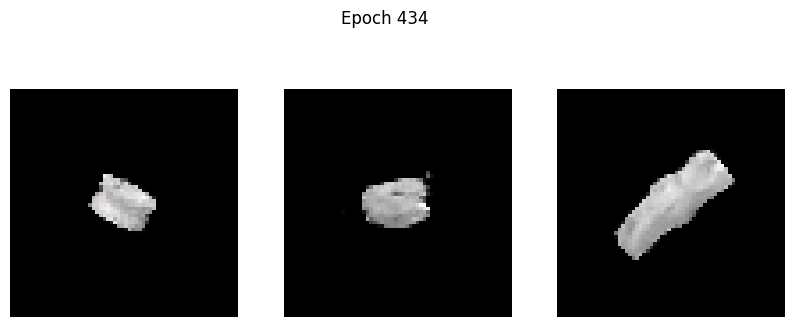

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: -0.0230 - g_loss: 5.7935
Epoch 435/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -0.0755 - g_loss: 5.7926

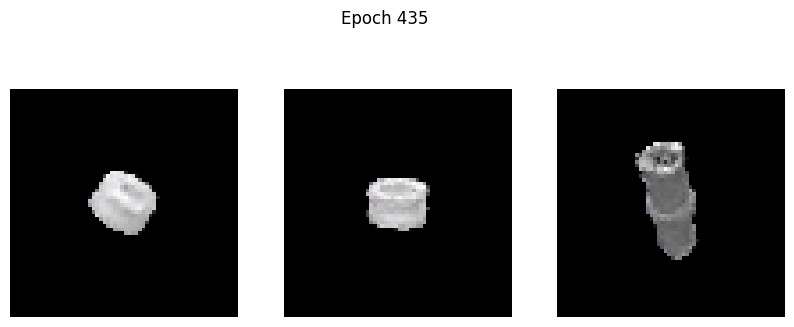

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: -0.0757 - g_loss: 5.7910
Epoch 436/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -0.0879 - g_loss: 5.7562

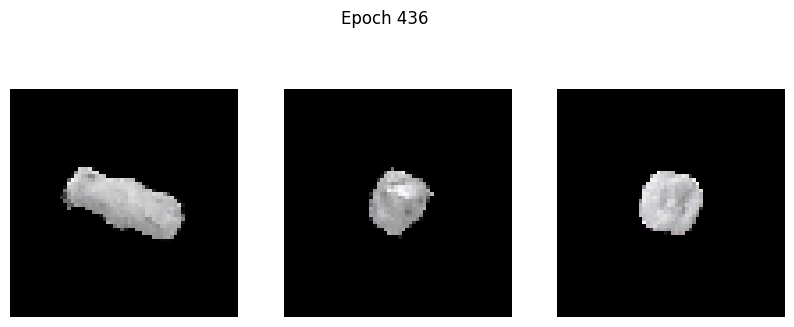

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: -0.0872 - g_loss: 5.7605
Epoch 437/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: 0.0311 - g_loss: 6.4346

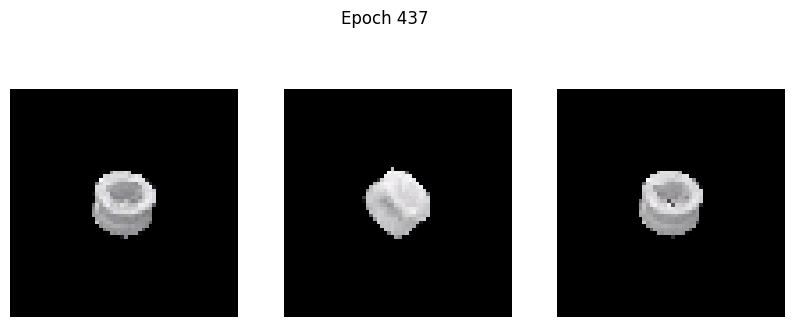

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0309 - g_loss: 6.4323
Epoch 438/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1310 - g_loss: 5.3611

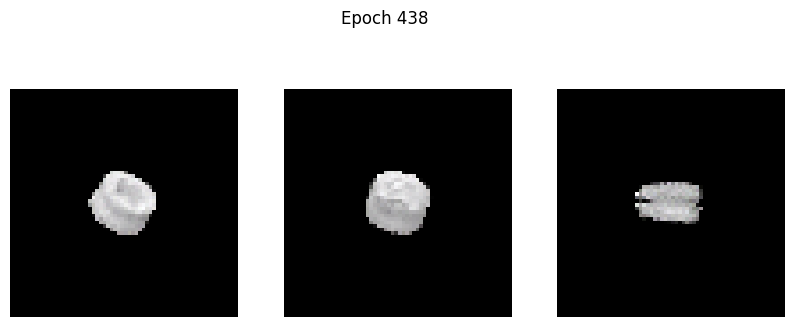

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1307 - g_loss: 5.3644
Epoch 439/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1514 - g_loss: 5.5528

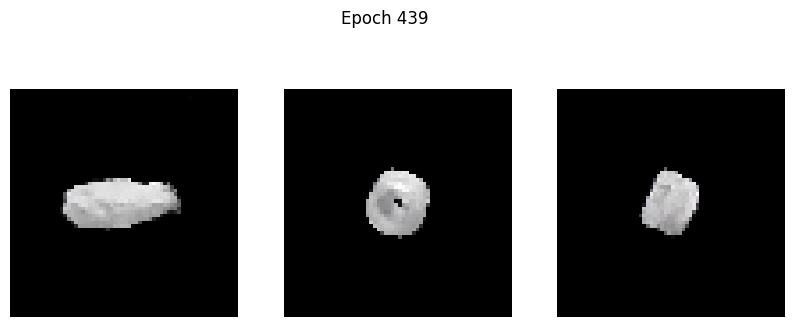

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1507 - g_loss: 5.5556
Epoch 440/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0096 - g_loss: 6.0900

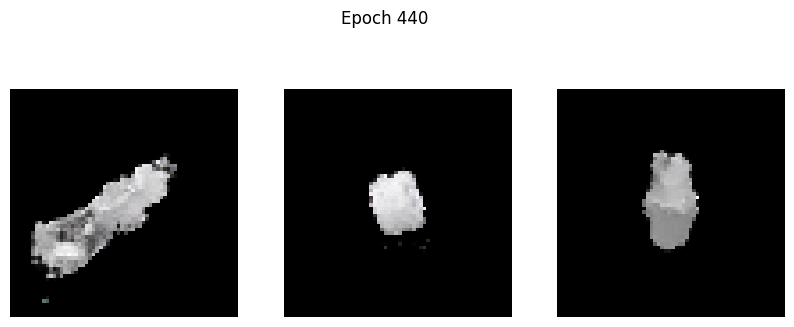

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0100 - g_loss: 6.0887
Epoch 441/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0880 - g_loss: 6.0108

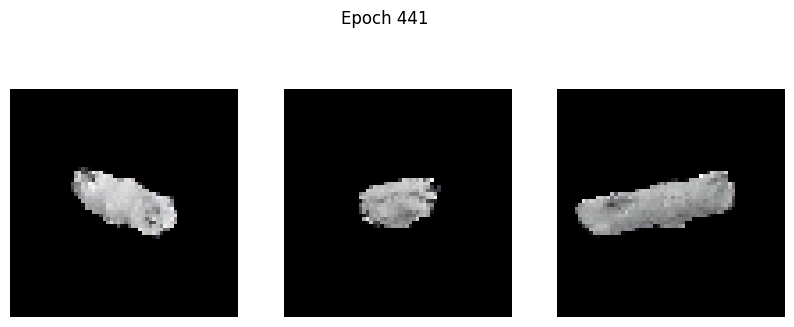

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0875 - g_loss: 6.0119
Epoch 442/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0149 - g_loss: 6.2284

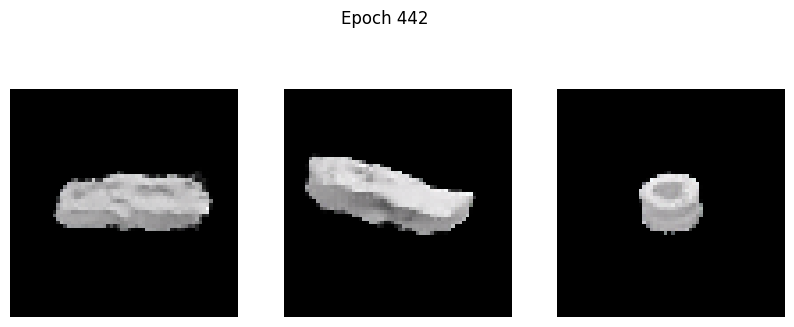

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0150 - g_loss: 6.2267
Epoch 443/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0445 - g_loss: 5.6607

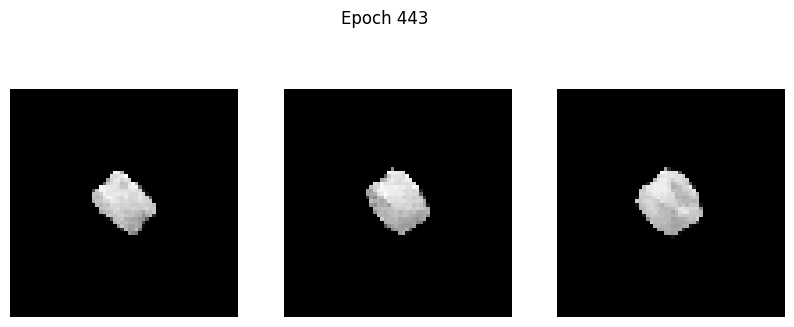

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0443 - g_loss: 5.6640
Epoch 444/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: 0.0445 - g_loss: 6.3142

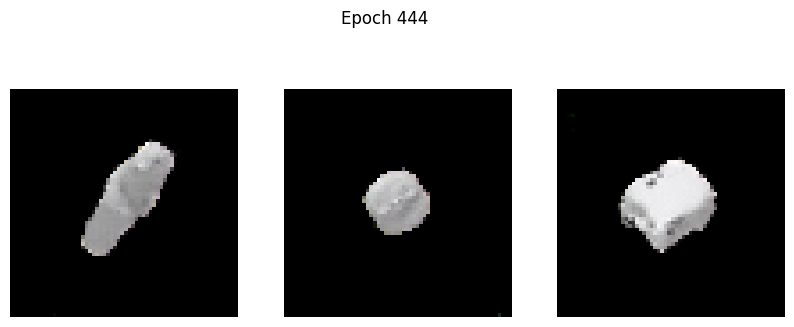

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: 0.0465 - g_loss: 6.3236
Epoch 445/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0444 - g_loss: 5.4150

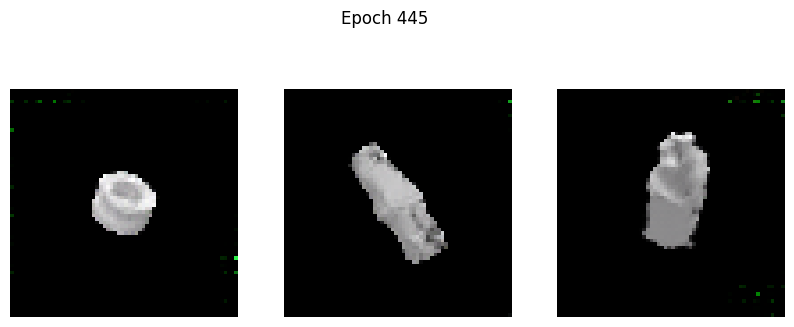

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0442 - g_loss: 5.4177
Epoch 446/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0889 - g_loss: 5.9749

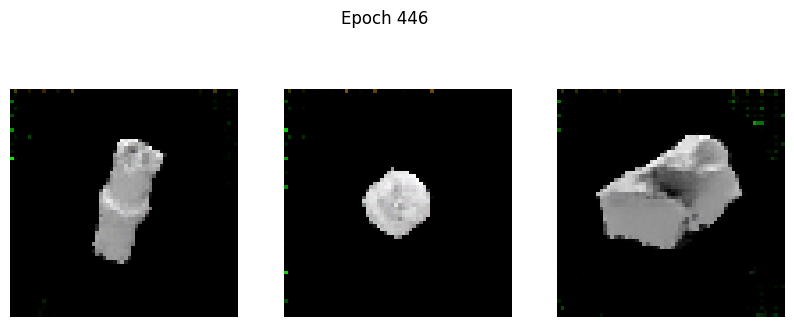

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.0890 - g_loss: 5.9734
Epoch 447/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.0756 - g_loss: 5.9142

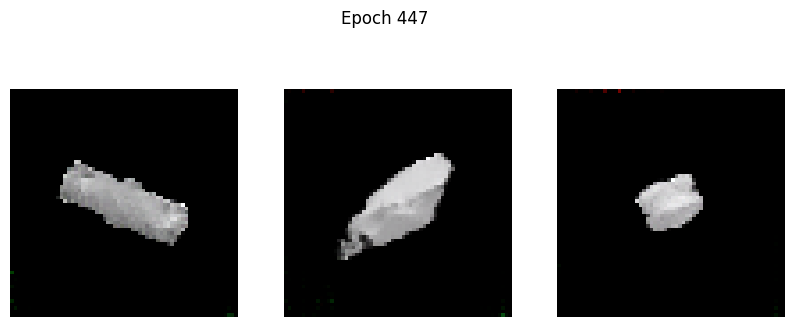

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.0756 - g_loss: 5.9152
Epoch 448/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.0702 - g_loss: 5.9411

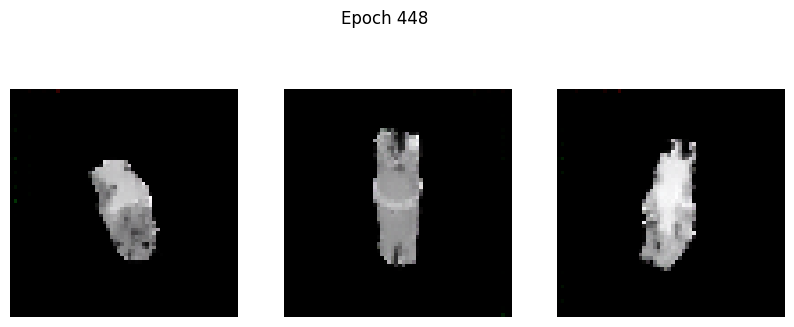

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.0704 - g_loss: 5.9394
Epoch 449/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.0769 - g_loss: 5.8684

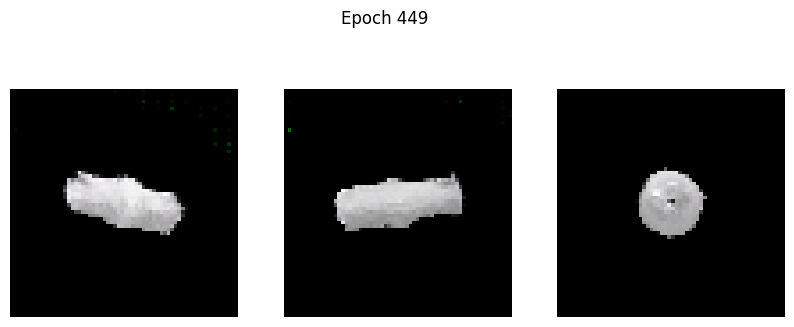

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.0766 - g_loss: 5.8699
Epoch 450/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.0921 - g_loss: 5.8188

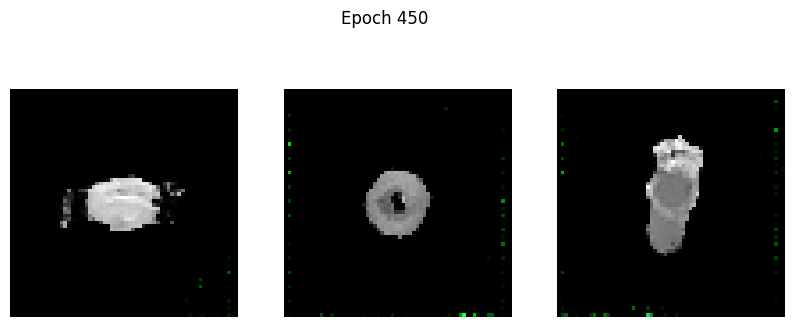

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.0920 - g_loss: 5.8208
Epoch 451/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.0578 - g_loss: 5.9546

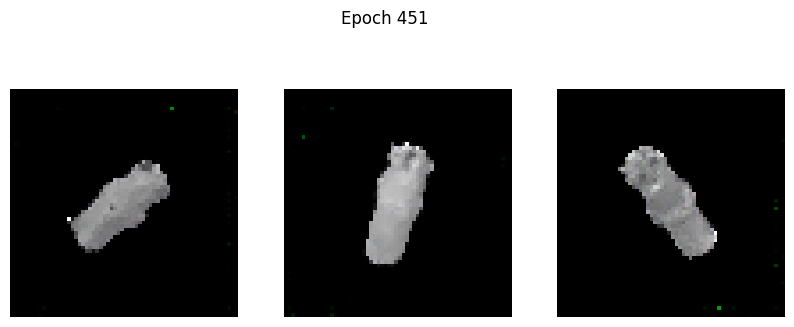

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0577 - g_loss: 5.9567
Epoch 452/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.1031 - g_loss: 5.9681

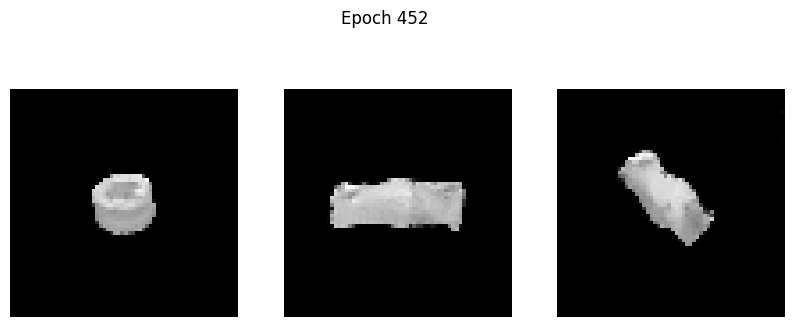

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.1032 - g_loss: 5.9667
Epoch 453/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0958 - g_loss: 6.4990

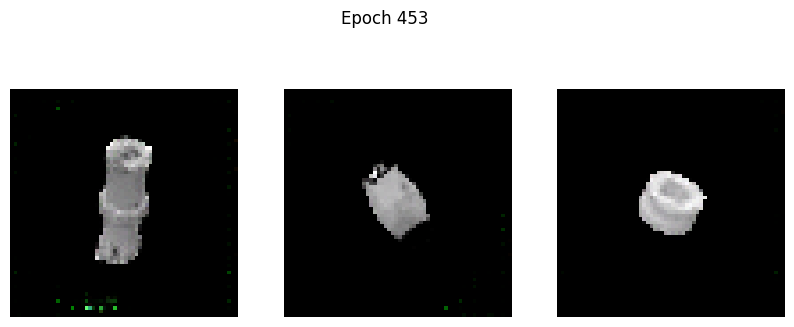

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0958 - g_loss: 6.4979
Epoch 454/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1549 - g_loss: 5.8889

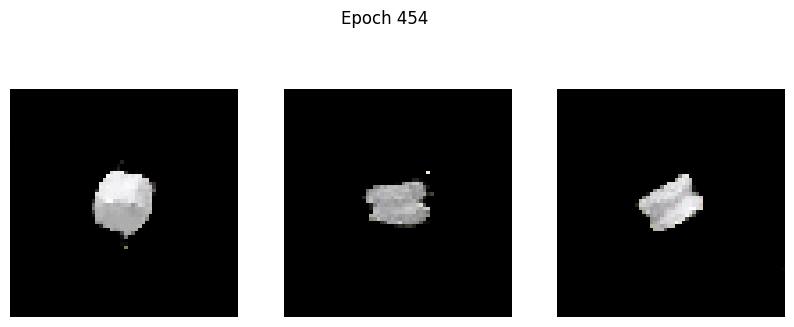

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1548 - g_loss: 5.8897
Epoch 455/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.0602 - g_loss: 6.4735

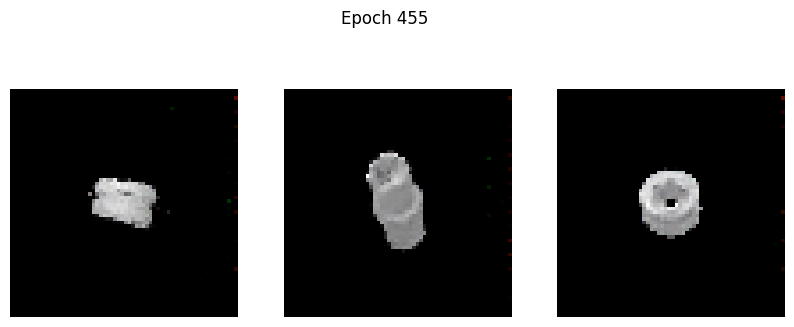

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.0596 - g_loss: 6.4764
Epoch 456/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0389 - g_loss: 6.6492

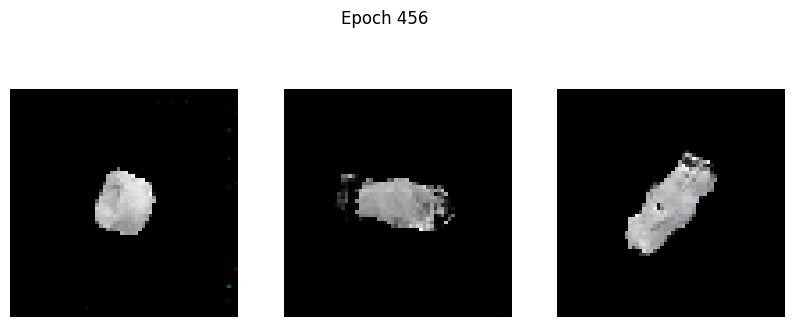

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0389 - g_loss: 6.6485
Epoch 457/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1058 - g_loss: 6.0226

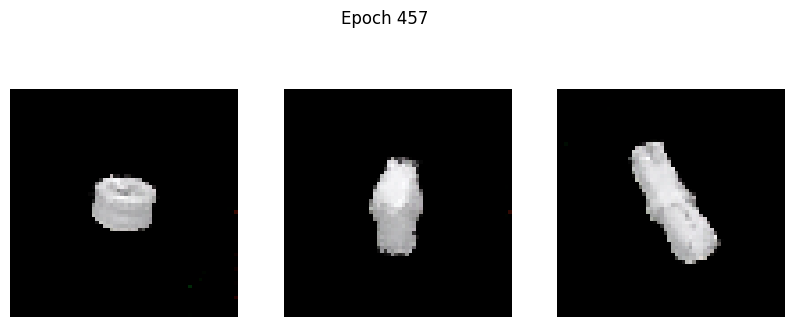

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1061 - g_loss: 6.0214
Epoch 458/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0374 - g_loss: 6.7708

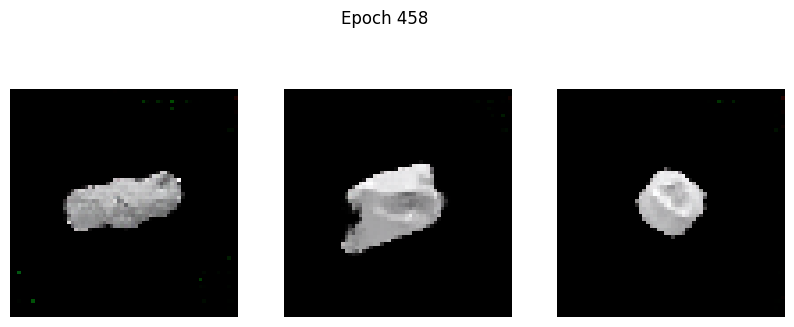

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0380 - g_loss: 6.7662
Epoch 459/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1297 - g_loss: 5.7692

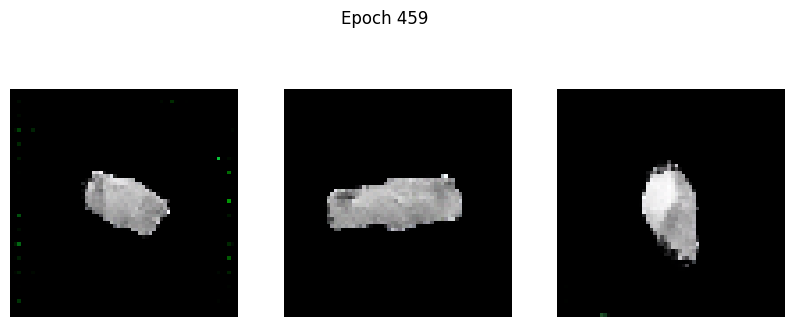

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1290 - g_loss: 5.7771
Epoch 460/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1236 - g_loss: 6.0200

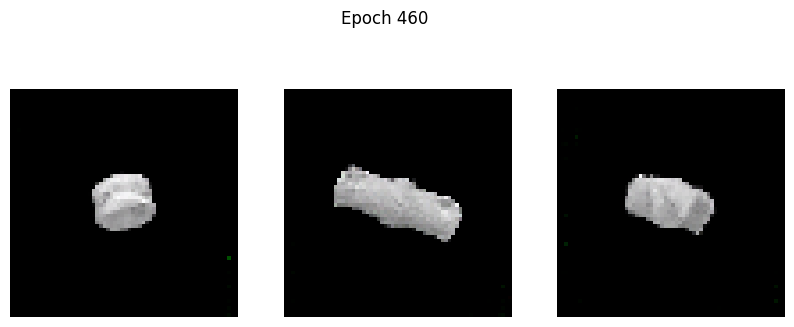

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1239 - g_loss: 6.0170
Epoch 461/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0450 - g_loss: 7.3192

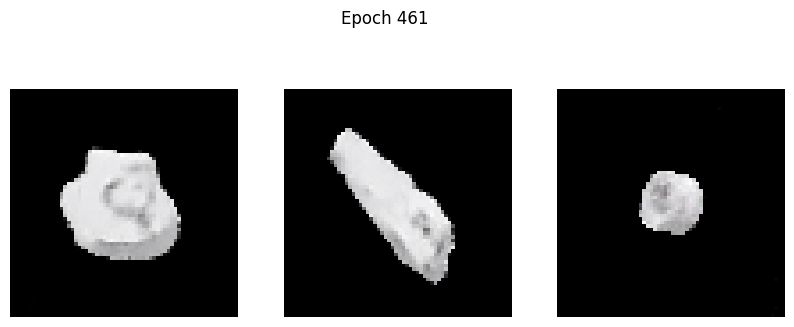

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0452 - g_loss: 7.3124
Epoch 462/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0587 - g_loss: 6.7707

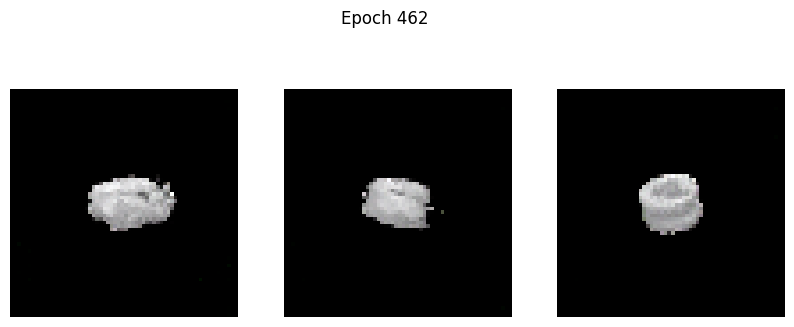

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0586 - g_loss: 6.7700
Epoch 463/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0887 - g_loss: 6.0225

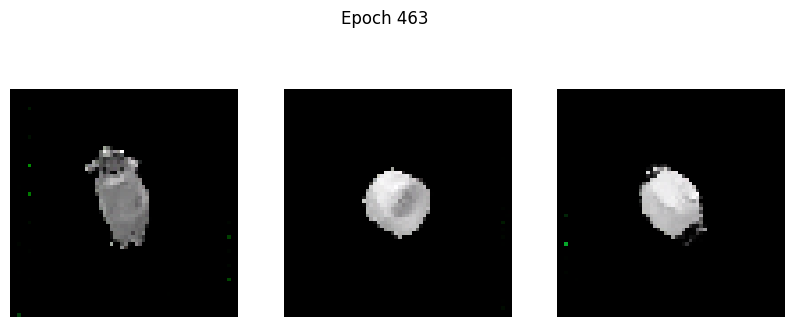

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - d_loss: -0.0888 - g_loss: 6.0245
Epoch 464/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0627 - g_loss: 6.7711

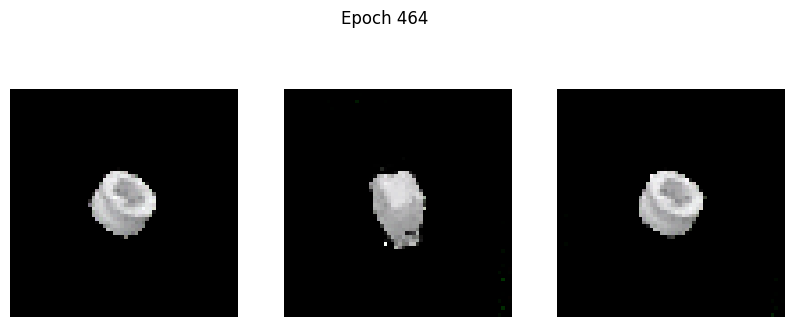

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0631 - g_loss: 6.7691
Epoch 465/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0622 - g_loss: 6.5522

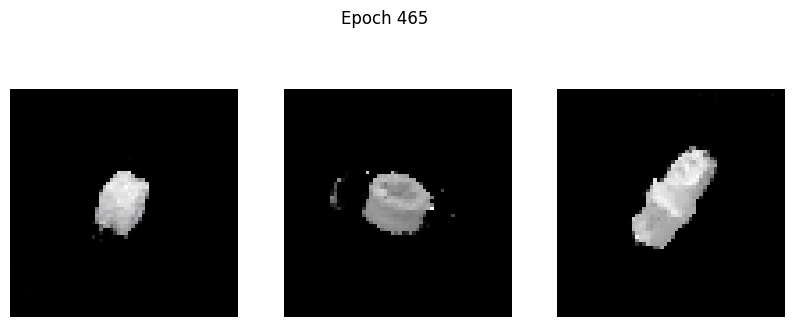

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0624 - g_loss: 6.5514
Epoch 466/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1751 - g_loss: 6.0704

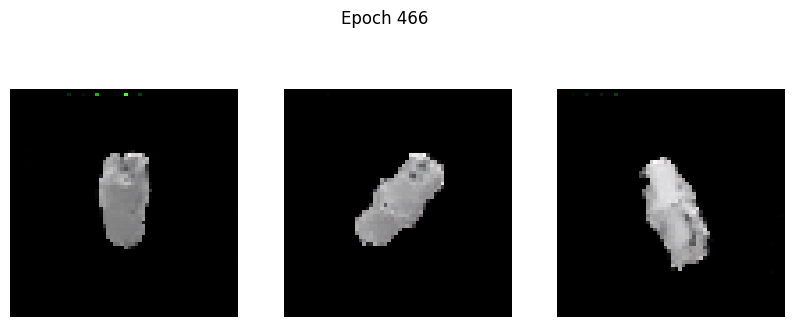

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1750 - g_loss: 6.0702
Epoch 467/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1606 - g_loss: 6.6413

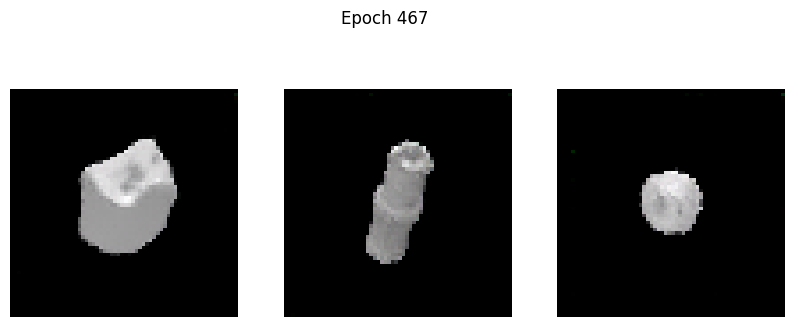

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.1599 - g_loss: 6.6430
Epoch 468/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1159 - g_loss: 6.6213

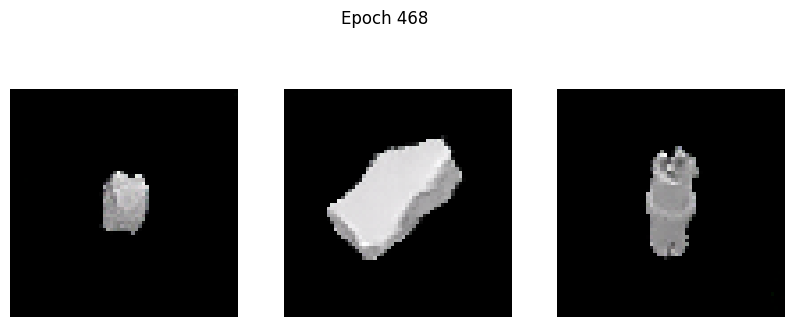

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.1157 - g_loss: 6.6211
Epoch 469/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1475 - g_loss: 6.4471

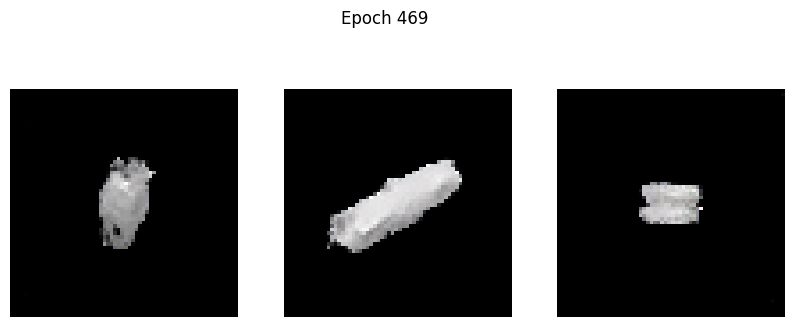

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.1472 - g_loss: 6.4503
Epoch 470/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1637 - g_loss: 6.4096

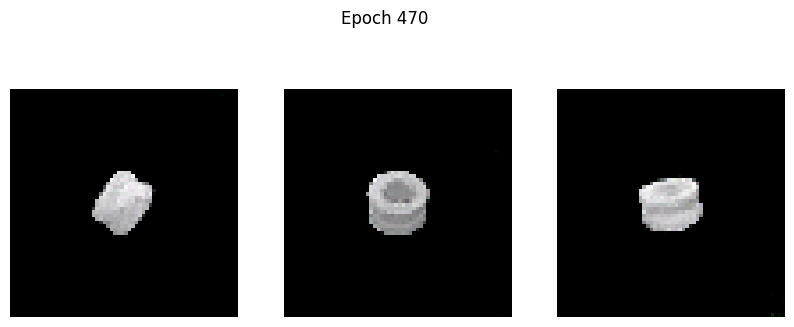

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.1636 - g_loss: 6.4102
Epoch 471/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.1427 - g_loss: 6.5070

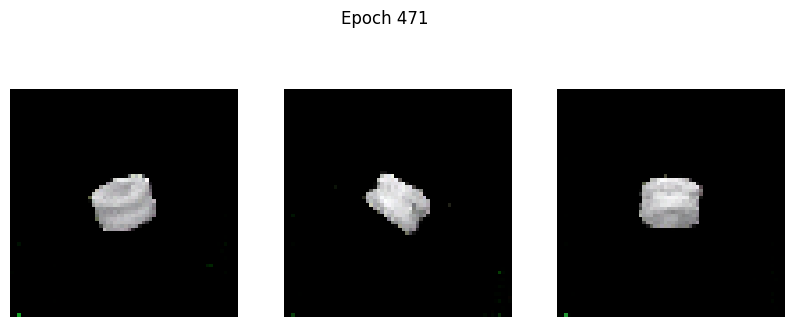

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.1426 - g_loss: 6.5087
Epoch 472/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.1404 - g_loss: 6.4302

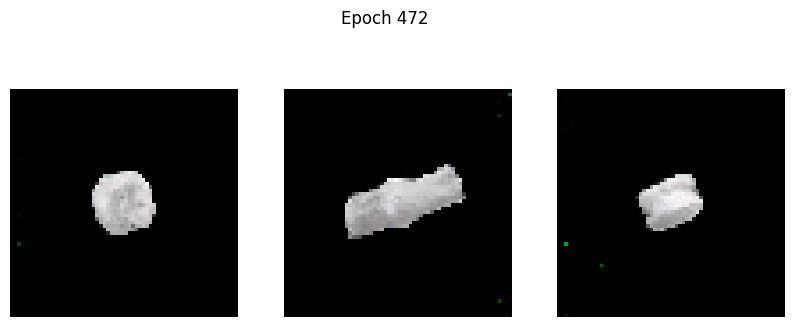

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.1401 - g_loss: 6.4313
Epoch 473/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.0192 - g_loss: 7.8603

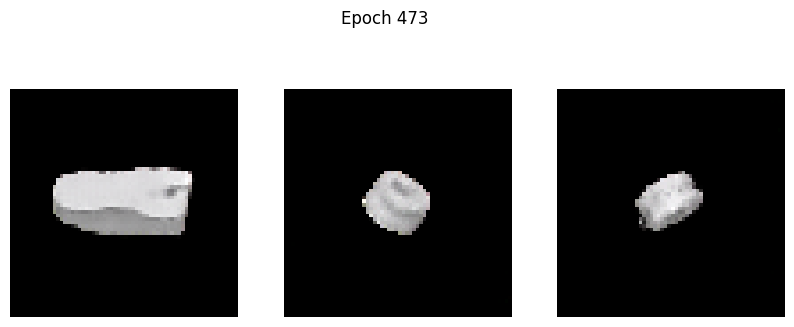

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.0184 - g_loss: 7.8596
Epoch 474/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: 0.0137 - g_loss: 6.8014

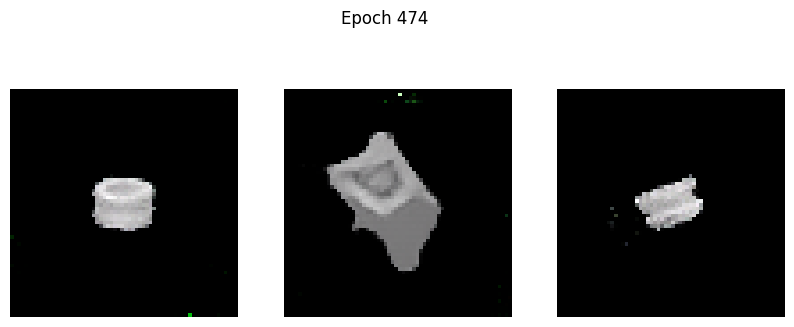

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: 0.0130 - g_loss: 6.7993
Epoch 475/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1644 - g_loss: 5.9873

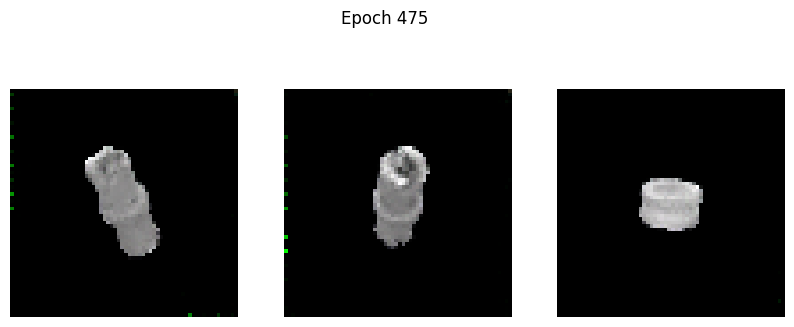

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1643 - g_loss: 5.9884
Epoch 476/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1657 - g_loss: 6.3958

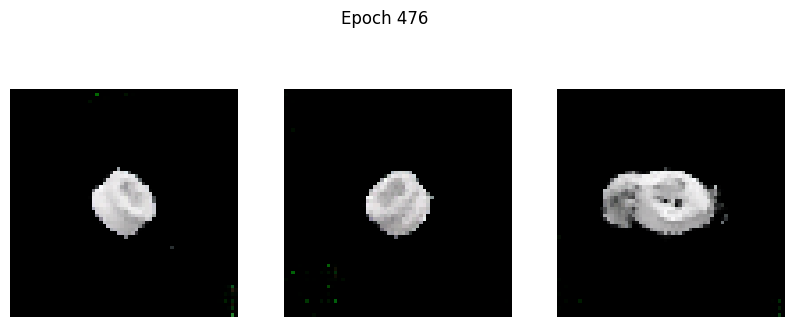

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1656 - g_loss: 6.3958
Epoch 477/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0788 - g_loss: 7.0657

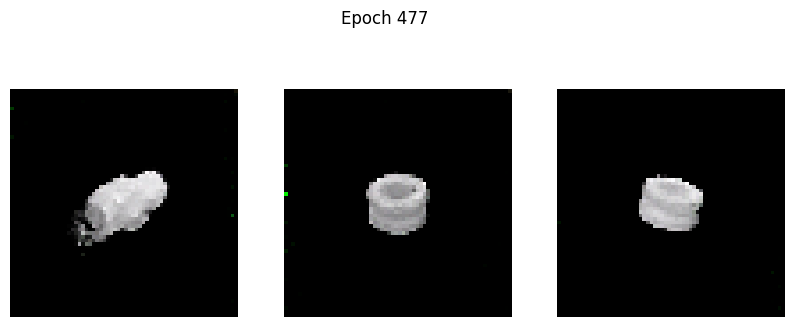

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0781 - g_loss: 7.0704
Epoch 478/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1634 - g_loss: 6.6113

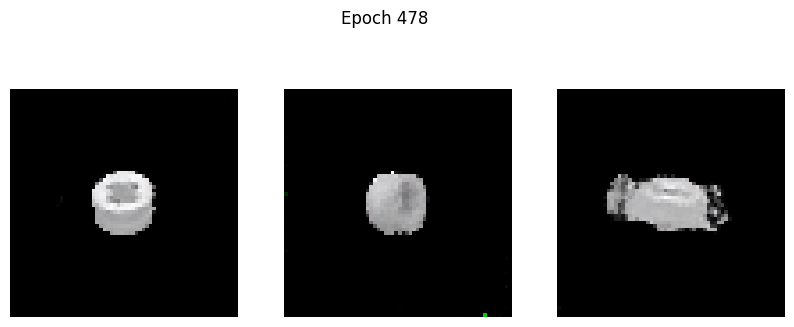

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1633 - g_loss: 6.6107
Epoch 479/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0984 - g_loss: 7.3157

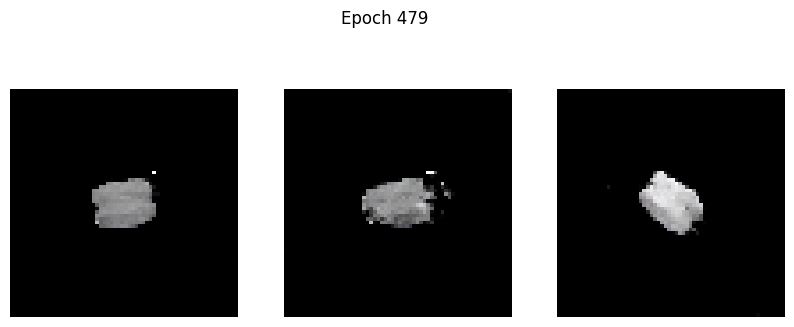

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.0986 - g_loss: 7.3118
Epoch 480/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.0460 - g_loss: 7.3329

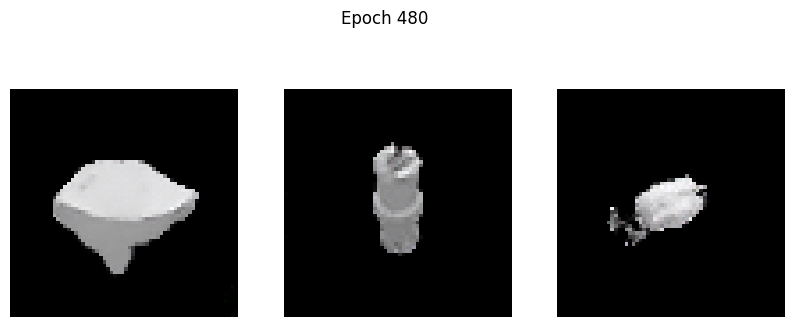

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.0470 - g_loss: 7.3279
Epoch 481/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1389 - g_loss: 6.8553

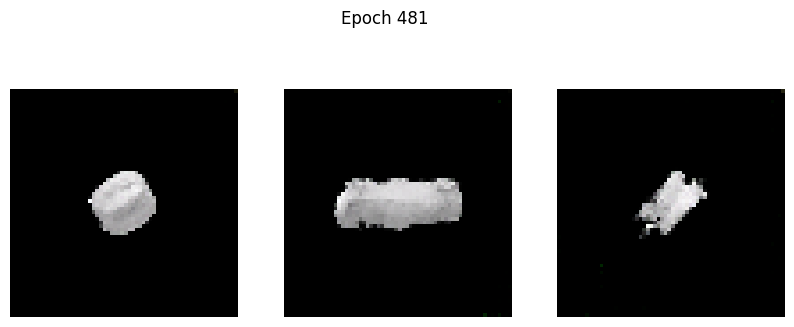

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1385 - g_loss: 6.8577
Epoch 482/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1040 - g_loss: 7.0524

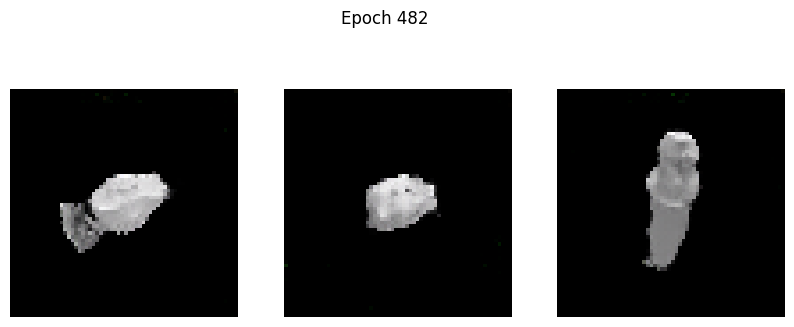

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1042 - g_loss: 7.0503
Epoch 483/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1303 - g_loss: 7.3952

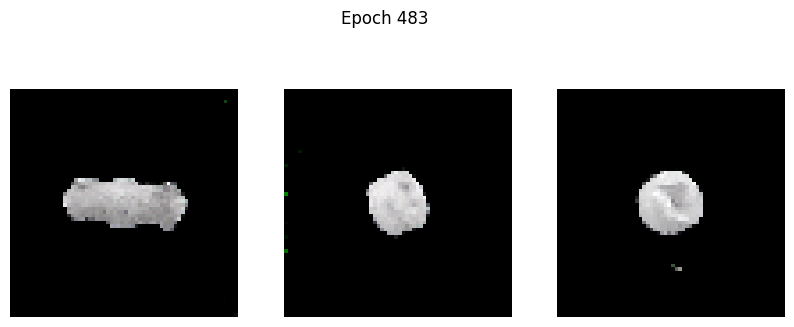

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1305 - g_loss: 7.3909
Epoch 484/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.2794 - g_loss: 6.1519

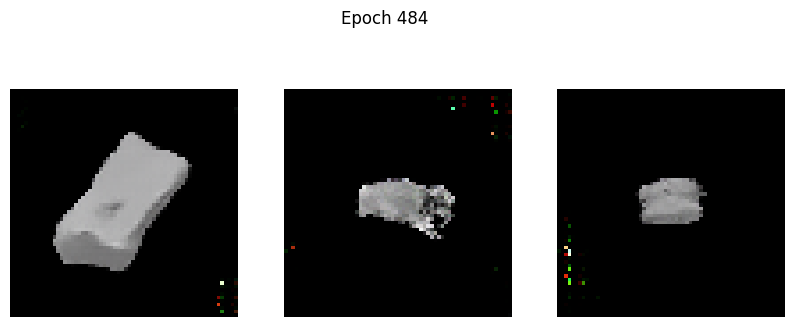

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.2790 - g_loss: 6.1546
Epoch 485/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1634 - g_loss: 7.1867

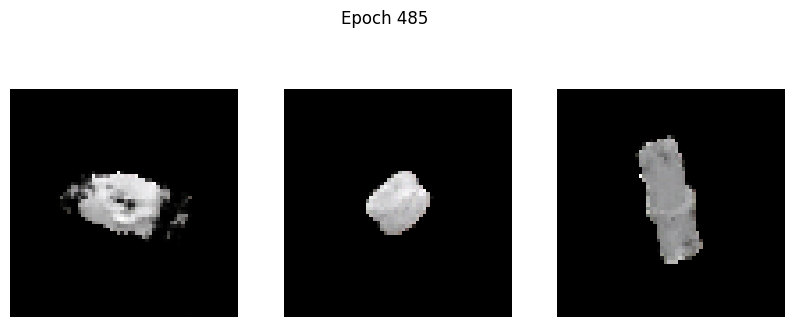

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1630 - g_loss: 7.1859
Epoch 486/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.2077 - g_loss: 6.7440

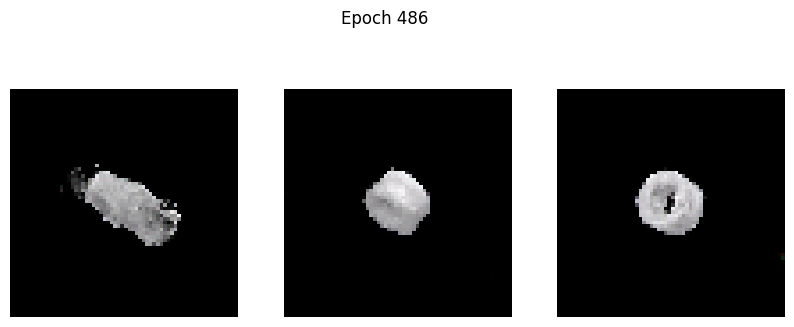

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.2077 - g_loss: 6.7447
Epoch 487/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1409 - g_loss: 7.1804

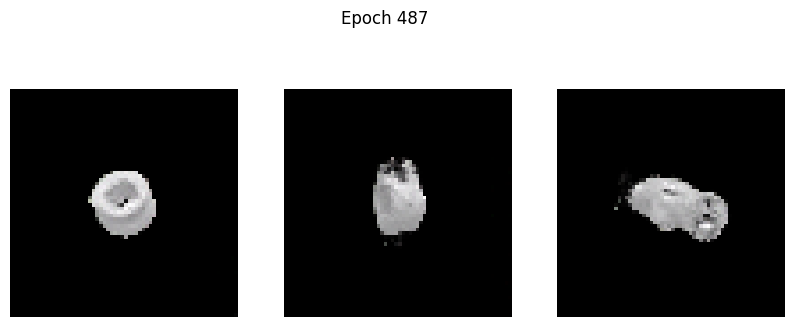

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.1409 - g_loss: 7.1798
Epoch 488/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1236 - g_loss: 6.6932

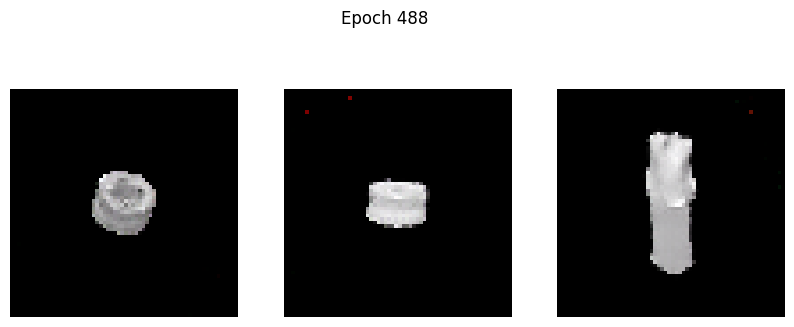

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.1229 - g_loss: 6.6972
Epoch 489/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1753 - g_loss: 6.5641

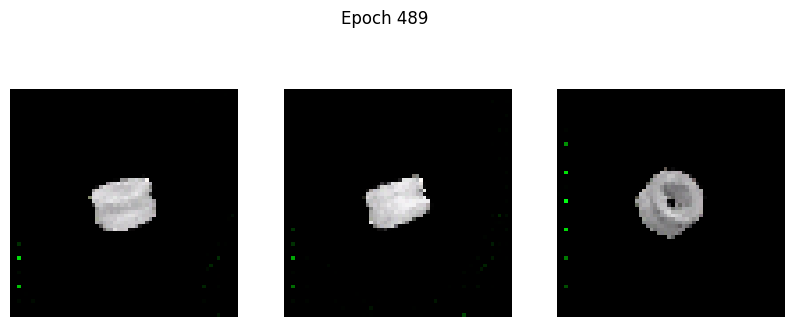

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.1750 - g_loss: 6.5679
Epoch 490/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.1290 - g_loss: 7.1180

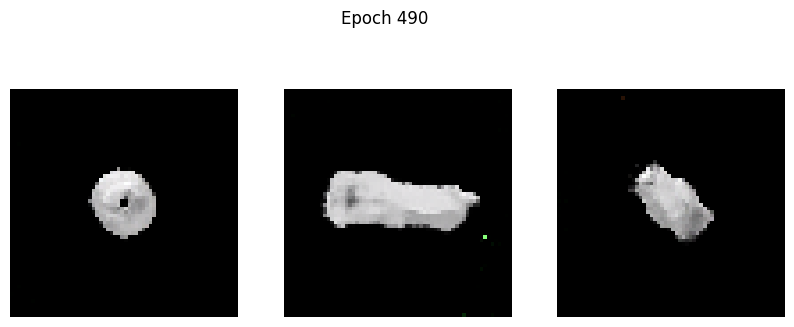

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.1291 - g_loss: 7.1189
Epoch 491/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.0830 - g_loss: 7.2792

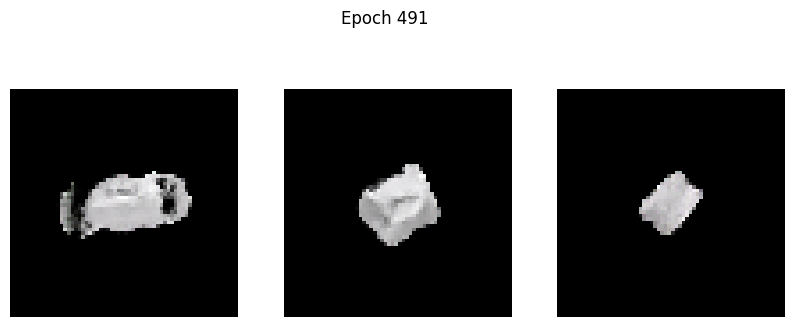

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.0828 - g_loss: 7.2801
Epoch 492/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.1364 - g_loss: 7.5159

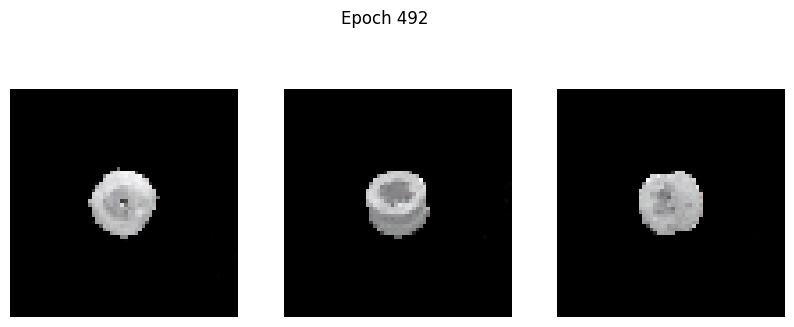

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.1360 - g_loss: 7.5186
Epoch 493/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - d_loss: -0.1579 - g_loss: 7.3661

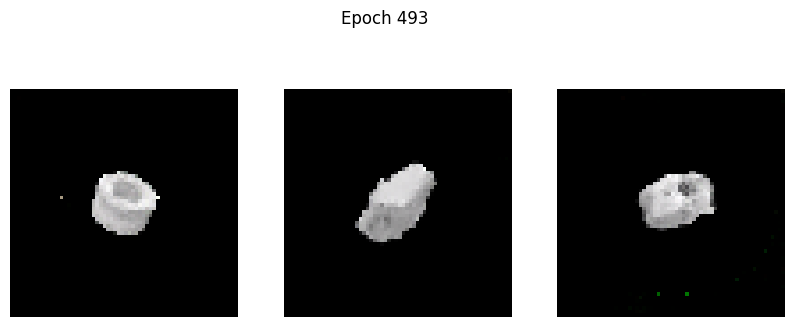

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - d_loss: -0.1573 - g_loss: 7.3668
Epoch 494/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.2355 - g_loss: 6.9773

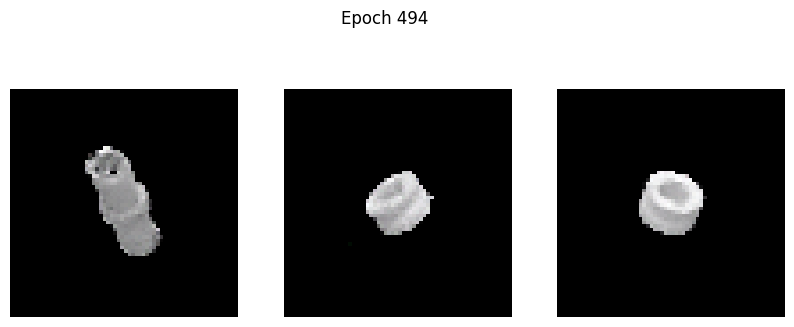

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.2352 - g_loss: 6.9802
Epoch 495/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1219 - g_loss: 7.4691

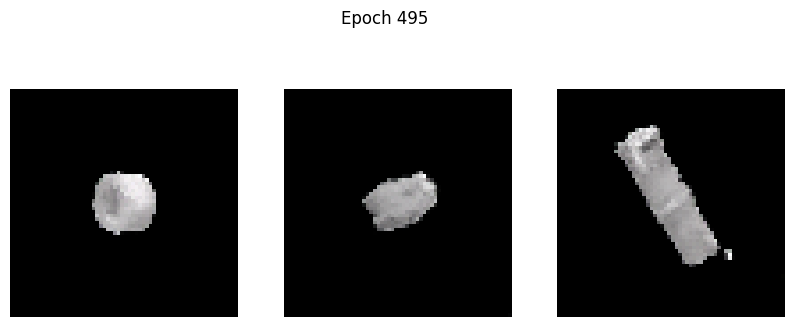

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1222 - g_loss: 7.4673
Epoch 496/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.2535 - g_loss: 6.9057

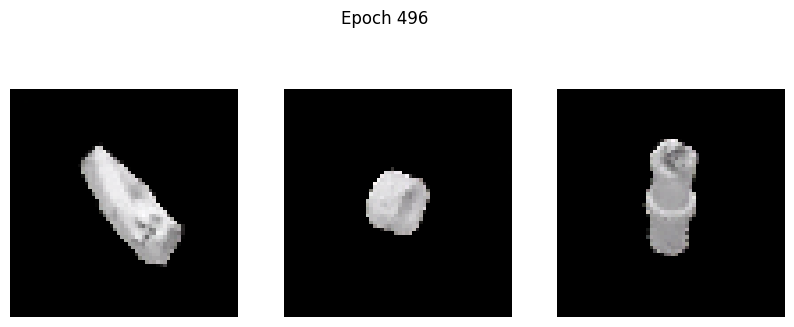

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.2530 - g_loss: 6.9092
Epoch 497/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.1622 - g_loss: 7.2944

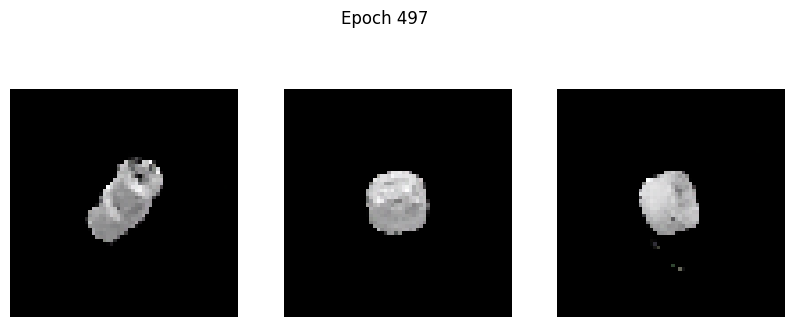

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.1628 - g_loss: 7.2937
Epoch 498/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.2109 - g_loss: 6.9090

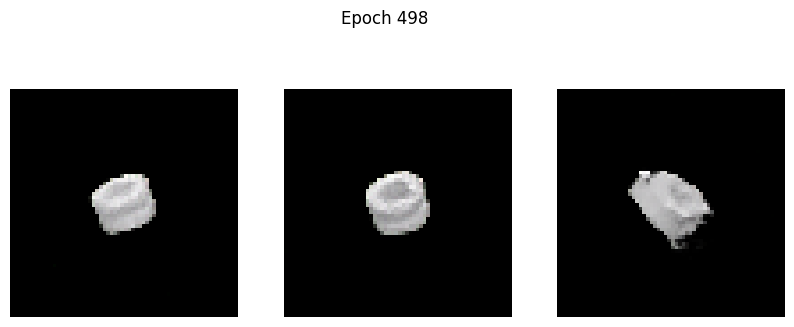

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.2103 - g_loss: 6.9138
Epoch 499/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.0158 - g_loss: 8.1769

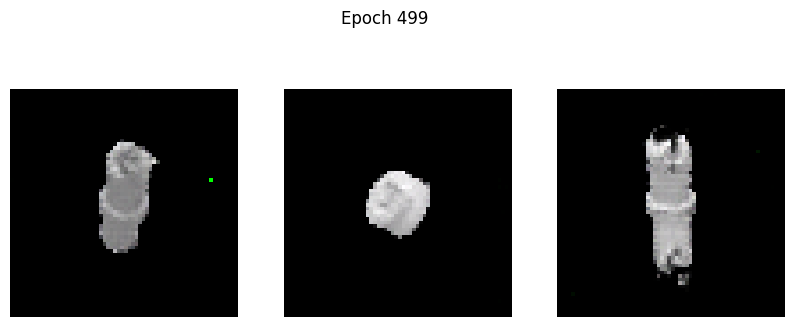

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.0171 - g_loss: 8.1677
Epoch 500/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -0.2580 - g_loss: 7.0471

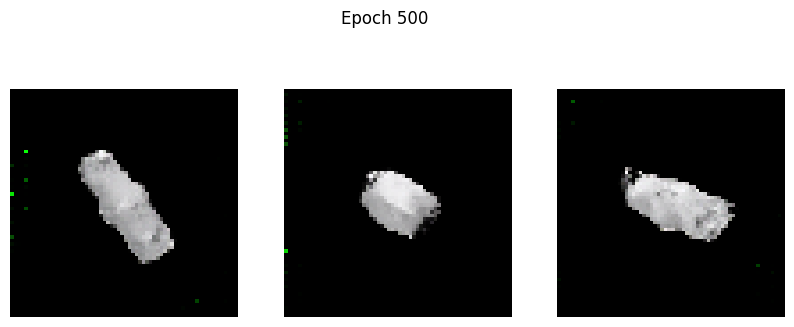

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - d_loss: -0.2574 - g_loss: 7.0486


In [12]:
# Hyperparameters
EPOCHS = 500  # Tambahkan jumlah epoch untuk hasil lebih baik (misal: 100-200)
lr_generator = 0.0002
lr_discriminator = 0.0002

# Inisialisasi DCGAN
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# Compile
dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=lr_discriminator, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=lr_generator, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Jalankan Training
print("Mulai Training...")
dcgan.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)